In [1]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install codecarbon --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.0/356.0 kB 5.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.21.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.
langchain-core 0.3.66 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.


### DL Input Pipeline

In [1]:
import os
from glob import glob
import tensorflow as tf

# config
BASE_DIR = '/kaggle/input/image-watermarking/dataset'
TRAIN_COVER_DIR = os.path.join(BASE_DIR, "train", "cover")
TRAIN_MARK_DIR  = os.path.join(BASE_DIR, "train", "mark")
TEST_COVER_DIR  = os.path.join(BASE_DIR, "test",  "cover")
TEST_MARK_DIR   = os.path.join(BASE_DIR, "test",  "mark")

IMG_H, IMG_W, C = 128, 128, 3
ALPHA = 0.3
BATCH_SIZE = 32
SEED = 42  # for reproducible shuffling

# File listing 
def _list_many(patterns):
    files = []
    for p in patterns:
        files.extend(glob(p))
    return sorted(files)

train_cover_paths = _list_many([f"{TRAIN_COVER_DIR}/*.JPEG", f"{TRAIN_COVER_DIR}/*.JPG",
                                f"{TRAIN_COVER_DIR}/*.jpg",  f"{TRAIN_COVER_DIR}/*.jpeg"])
train_mark_paths  = _list_many([f"{TRAIN_MARK_DIR}/*.png",  f"{TRAIN_MARK_DIR}/*.PNG"])
test_cover_paths  = _list_many([f"{TEST_COVER_DIR}/*.JPEG", f"{TEST_COVER_DIR}/*.JPG",
                                f"{TEST_COVER_DIR}/*.jpg",  f"{TEST_COVER_DIR}/*.jpeg"])
test_mark_paths   = _list_many([f"{TEST_MARK_DIR}/*.png",   f"{TEST_MARK_DIR}/*.PNG"])

# ensure equal counts by truncating to the minimum (keeps pairing aligned)
n_train = min(len(train_cover_paths), len(train_mark_paths))
n_test  = min(len(test_cover_paths),  len(test_mark_paths))
train_cover_paths, train_mark_paths = train_cover_paths[:n_train], train_mark_paths[:n_train]
test_cover_paths,  test_mark_paths  = test_cover_paths[:n_test],   test_mark_paths[:n_test]
assert n_train > 0 and n_test > 0, "No images found—check dataset paths."

# ML: 5000 train / 1000 test
MAX_TRAIN, MAX_TEST = 5000, 1000
n_train = min(MAX_TRAIN, len(train_cover_paths))
n_test  = min(MAX_TEST,  len(test_cover_paths))
train_cover_paths, train_mark_paths = train_cover_paths[:n_train], train_mark_paths[:n_train]
test_cover_paths,  test_mark_paths  = test_cover_paths[:n_test],   test_mark_paths[:n_test]
print(f"[DATA] Train pairs: {n_train} (cap {MAX_TRAIN}) | Test pairs: {n_test} (cap {MAX_TEST})")

# decode/resize to [0,1]
def _read_resize_any(path, size=(IMG_H, IMG_W)):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)  # auto JPEG/PNG
    img = tf.image.convert_image_dtype(img, tf.float32)                 # [0,1]
    img = tf.image.resize(img, size)                                    # (H,W,3)
    img.set_shape((IMG_H, IMG_W, 3))                                    # fix static shape
    return img

# (cover, mark) -> (input6, blended3)
def dlprocess_image_pair(cover_path, mark_path, alpha=ALPHA):
    cover_img = _read_resize_any(cover_path)
    mark_img  = _read_resize_any(mark_path)
    x = tf.concat([cover_img, mark_img], axis=-1)            # (H,W,6)
    y = (1.0 - alpha) * cover_img + alpha * mark_img         # (H,W,3)
    return x, y

# dataset builders
def dlcreate_dataset(cover_paths, mark_paths, alpha=ALPHA, shuffle=False, seed=SEED):
    ds = tf.data.Dataset.from_tensor_slices((cover_paths, mark_paths))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=seed, reshuffle_each_iteration=True)
    ds = ds.map(lambda c, m: dlprocess_image_pair(c, m, alpha),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

#final datasets for DL models
train_image_ds = dlcreate_dataset(train_cover_paths, train_mark_paths, alpha=ALPHA, shuffle=True)
test_image_ds  = dlcreate_dataset(test_cover_paths,  test_mark_paths,  alpha=ALPHA, shuffle=False)


2025-11-16 22:36:42.609481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763332602.794086      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763332602.845466      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[DATA] Train pairs: 5000 (cap 5000) | Test pairs: 1000 (cap 1000)


I0000 00:00:1763332615.667783      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763332615.668521      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### CNN PIPELINE

In [3]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from time import perf_counter
from contextlib import suppress

# CodeCarbon (wrappers)
try:
    from codecarbon import EmissionsTracker
    def _cc_start(name):
        try:
            tr = EmissionsTracker(project_name=name, output_dir=".", measure_power_secs=1)
            tr.start(); return tr
        except Exception:
            return None
    def _cc_stop(tr):
        if tr is None: return None
        with suppress(Exception): return tr.stop()
        return None
except Exception:
    def _cc_start(name): return None
    def _cc_stop(tr):    return None

# small helpers
def _bytes_to_mb(n): return n / (1024**2)

def _count_images(ds):
    # Try cardinality * batch_size; fallback to iterate
    try:
        card = int(ds.cardinality().numpy())
        if card > 0:
            for batch in ds.take(1):
                bs = int(batch[0].shape[0]) if isinstance(batch, (tuple, list)) else int(batch.shape[0])
            return card * bs
    except Exception:
        pass
    cnt = 0
    for batch in ds:
        bs = int(batch[0].shape[0]) if isinstance(batch, (tuple, list)) else int(batch.shape[0])
        cnt += bs
    return cnt

def _dataset_ssim_one_number(y_true_imgs, y_pred_imgs):
    from skimage.metrics import structural_similarity as ssim
    y_true_big = np.concatenate(list(y_true_imgs), axis=0)  # (N*H, W, C)
    y_pred_big = np.concatenate(list(y_pred_imgs), axis=0)
    try:
        return float(ssim(y_true_big, y_pred_big, data_range=1.0, channel_axis=2))
    except TypeError:
        return float(ssim(y_true_big, y_pred_big, data_range=1.0, multichannel=True))

def _psnr_from_mse(mse, max_i=1.0, eps=1e-12):
    return 10.0 * np.log10((max_i**2) / (mse + eps))

# model
def get_cnn_model(input_shape=(128, 128, 6)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # RGB output
    ])
    return model

cnn_model = get_cnn_model()
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# count dataset sizes 
N_train = _count_images(train_image_ds)
N_test  = _count_images(test_image_ds)

# TRAIN (timing + CO₂)
train_tracker = _cc_start("CNN_Watermark_Train")
t0 = perf_counter()
history = cnn_model.fit(train_image_ds, epochs=10, validation_data=test_image_ds, verbose=1)
train_time_s = perf_counter() - t0
train_emissions_kg = _cc_stop(train_tracker)

train_ms_per_img = (train_time_s / max(1, N_train)) * 1000.0
print(f"[TRAIN] CNN total: {train_time_s:.2f}s for {N_train} imgs "
      f"({train_ms_per_img:.2f} ms/img) | CO2: {train_emissions_kg if train_emissions_kg is not None else 'n/a'}")

# INFERENCE (timing + CO₂) + EVAL
# (collect preds + gts for metrics)
# warm-up one batch to ensure kernels are built
for xb, _ in test_image_ds.take(1):
    _ = cnn_model(xb, training=False)

infer_tracker = _cc_start("CNN_Watermark_Inference")
t1 = perf_counter()

y_pred_list = []
y_true_list = []
for xb, yb in test_image_ds:
    yhat = cnn_model.predict(xb, verbose=0)
    y_pred_list.append(yhat)
    y_true_list.append(yb.numpy())

infer_time_s = perf_counter() - t1
infer_emissions_kg = _cc_stop(infer_tracker)

Yp = np.clip(np.concatenate(y_pred_list, axis=0), 0.0, 1.0).astype(np.float32)  # (N, H, W, 3)
Yt = np.clip(np.concatenate(y_true_list, axis=0), 0.0, 1.0).astype(np.float32)  # (N, H, W, 3)
N_out = Yp.shape[0]  # should match N_test

infer_ms_per_img = (infer_time_s / max(1, N_out)) * 1000.0
print(f"[INFER] CNN total: {infer_time_s:.3f}s for {N_out} imgs "
      f"({infer_ms_per_img:.2f} ms/img) | CO2: {infer_emissions_kg if infer_emissions_kg is not None else 'n/a'}")

# EVALUATION
# Global MSE/PSNR across all pixel
eps = 1e-12
mse_global = float(np.mean((Yt - Yp) ** 2))
psnr_global = float(_psnr_from_mse(mse_global, max_i=1.0, eps=eps))

# Single SSIM over entire set
ssim_single = _dataset_ssim_one_number(Yt, Yp)

print(f"[EVAL] CNN MSE: {mse_global:.6f} | PSNR: {psnr_global:.2f} dB | SSIM: {ssim_single:.4f}")

# SAVE ARTIFACTS and model size
model_path = "cnn_model.h5"
cnn_model.save(model_path)
size_mb = _bytes_to_mb(os.path.getsize(model_path)) if os.path.exists(model_path) else 0.0
print(f"[SAVE] Artifacts written: {model_path}")
print(f"[SIZE] CNN (artifacts on disk): {size_mb:.2f} MB")


[codecarbon WARNING @ 18:34:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:34:23] [setup] RAM Tracking...
[codecarbon INFO @ 18:34:23] [setup] CPU Tracking...
[codecarbon WARNING @ 18:34:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 18:34:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 18:34:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 18:34:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:34:24] [setup] GPU Tracking...
[codecarbon INFO @ 18:34:24] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:34:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/10


[codecarbon INFO @ 18:34:28] Energy consumed for RAM : 0.000006 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:28] Energy consumed for All CPU : 0.000012 kWh
[codecarbon INFO @ 18:34:28] Energy consumed for all GPUs : 0.000015 kWh. Total GPU Power : 53.91569095659639 W
[codecarbon INFO @ 18:34:28] 0.000033 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:29] Energy consumed for RAM : 0.000011 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:29] Energy consumed for All CPU : 0.000024 kWh
[codecarbon INFO @ 18:34:29] Energy consumed for all GPUs : 0.000031 kWh. Total GPU Power : 55.55055060304528 W
[codecarbon INFO @ 18:34:29] 0.000065 kWh of electricity used since the beginning.
I0000 00:00:1757788470.525750     110 service.cc:148] XLA service 0x799f50086c00 i

  3/157 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0521 - mae: 0.1879 

I0000 00:00:1757788477.149958     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  7/157 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 0.0510 - mae: 0.1856

[codecarbon INFO @ 18:34:37] Energy consumed for RAM : 0.000055 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:37] Energy consumed for All CPU : 0.000117 kWh
[codecarbon INFO @ 18:34:37] Energy consumed for all GPUs : 0.000200 kWh. Total GPU Power : 76.61150095365815 W
[codecarbon INFO @ 18:34:37] 0.000372 kWh of electricity used since the beginning.


 13/157 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - loss: 0.0483 - mae: 0.1793

[codecarbon INFO @ 18:34:38] Energy consumed for RAM : 0.000060 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:38] Energy consumed for All CPU : 0.000128 kWh
[codecarbon INFO @ 18:34:38] Energy consumed for all GPUs : 0.000221 kWh. Total GPU Power : 75.24785300060114 W
[codecarbon INFO @ 18:34:38] 0.000410 kWh of electricity used since the beginning.


 18/157 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - loss: 0.0459 - mae: 0.1736

[codecarbon INFO @ 18:34:39] Energy consumed for RAM : 0.000066 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:39] Energy consumed for All CPU : 0.000140 kWh
[codecarbon INFO @ 18:34:39] Energy consumed for all GPUs : 0.000240 kWh. Total GPU Power : 69.06406427730782 W
[codecarbon INFO @ 18:34:39] 0.000446 kWh of electricity used since the beginning.


 24/157 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - loss: 0.0432 - mae: 0.1671

[codecarbon INFO @ 18:34:40] Energy consumed for RAM : 0.000071 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:40] Energy consumed for All CPU : 0.000152 kWh
[codecarbon INFO @ 18:34:40] Energy consumed for all GPUs : 0.000258 kWh. Total GPU Power : 65.51345476372822 W
[codecarbon INFO @ 18:34:40] 0.000481 kWh of electricity used since the beginning.


 30/157 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 0.0407 - mae: 0.1609

[codecarbon INFO @ 18:34:41] Energy consumed for RAM : 0.000077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:41] Energy consumed for All CPU : 0.000163 kWh
[codecarbon INFO @ 18:34:41] Energy consumed for all GPUs : 0.000276 kWh. Total GPU Power : 65.29322562761097 W
[codecarbon INFO @ 18:34:41] 0.000516 kWh of electricity used since the beginning.


 35/157 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - loss: 0.0388 - mae: 0.1560

[codecarbon INFO @ 18:34:42] Energy consumed for RAM : 0.000082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:42] Energy consumed for All CPU : 0.000175 kWh
[codecarbon INFO @ 18:34:42] Energy consumed for all GPUs : 0.000294 kWh. Total GPU Power : 64.64158731577939 W
[codecarbon INFO @ 18:34:42] 0.000551 kWh of electricity used since the beginning.


 42/157 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - loss: 0.0365 - mae: 0.1497

[codecarbon INFO @ 18:34:43] Energy consumed for RAM : 0.000088 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:43] Energy consumed for All CPU : 0.000187 kWh
[codecarbon INFO @ 18:34:43] Energy consumed for all GPUs : 0.000312 kWh. Total GPU Power : 65.87267804940333 W
[codecarbon INFO @ 18:34:43] 0.000587 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:43] 0.016516 g.CO2eq/s mean an estimation of 520.8630202052861 kg.CO2eq/year


 47/157 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 0.0350 - mae: 0.1457

[codecarbon INFO @ 18:34:44] Energy consumed for RAM : 0.000093 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:44] Energy consumed for All CPU : 0.000199 kWh


 48/157 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 0.0347 - mae: 0.1449

[codecarbon INFO @ 18:34:44] Energy consumed for all GPUs : 0.000330 kWh. Total GPU Power : 65.1608550007488 W
[codecarbon INFO @ 18:34:44] 0.000622 kWh of electricity used since the beginning.


 53/157 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 0.0334 - mae: 0.1413

[codecarbon INFO @ 18:34:45] Energy consumed for RAM : 0.000099 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:45] Energy consumed for All CPU : 0.000210 kWh
[codecarbon INFO @ 18:34:45] Energy consumed for all GPUs : 0.000348 kWh. Total GPU Power : 65.29314600536857 W
[codecarbon INFO @ 18:34:45] 0.000657 kWh of electricity used since the beginning.


 59/157 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 0.0320 - mae: 0.1372

[codecarbon INFO @ 18:34:46] Energy consumed for RAM : 0.000104 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:46] Energy consumed for All CPU : 0.000222 kWh
[codecarbon INFO @ 18:34:46] Energy consumed for all GPUs : 0.000366 kWh. Total GPU Power : 65.5753373634803 W
[codecarbon INFO @ 18:34:46] 0.000693 kWh of electricity used since the beginning.


 65/157 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - loss: 0.0308 - mae: 0.1335

[codecarbon INFO @ 18:34:47] Energy consumed for RAM : 0.000110 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:47] Energy consumed for All CPU : 0.000234 kWh
[codecarbon INFO @ 18:34:47] Energy consumed for all GPUs : 0.000384 kWh. Total GPU Power : 65.50614226675677 W
[codecarbon INFO @ 18:34:47] 0.000728 kWh of electricity used since the beginning.


 71/157 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - loss: 0.0296 - mae: 0.1301

[codecarbon INFO @ 18:34:48] Energy consumed for RAM : 0.000115 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:48] Energy consumed for All CPU : 0.000246 kWh
[codecarbon INFO @ 18:34:48] Energy consumed for all GPUs : 0.000403 kWh. Total GPU Power : 65.85392274913197 W
[codecarbon INFO @ 18:34:48] 0.000763 kWh of electricity used since the beginning.


 77/157 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - loss: 0.0286 - mae: 0.1270

[codecarbon INFO @ 18:34:49] Energy consumed for RAM : 0.000121 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:49] Energy consumed for All CPU : 0.000257 kWh
[codecarbon INFO @ 18:34:49] Energy consumed for all GPUs : 0.000421 kWh. Total GPU Power : 65.72146659905941 W
[codecarbon INFO @ 18:34:49] 0.000799 kWh of electricity used since the beginning.


 82/157 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - loss: 0.0278 - mae: 0.1246

[codecarbon INFO @ 18:34:50] Energy consumed for RAM : 0.000126 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:50] Energy consumed for All CPU : 0.000269 kWh
[codecarbon INFO @ 18:34:50] Energy consumed for all GPUs : 0.000439 kWh. Total GPU Power : 64.00247578150628 W
[codecarbon INFO @ 18:34:50] 0.000834 kWh of electricity used since the beginning.


 88/157 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0269 - mae: 0.1219

[codecarbon INFO @ 18:34:51] Energy consumed for RAM : 0.000132 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:51] Energy consumed for All CPU : 0.000281 kWh
[codecarbon INFO @ 18:34:51] Energy consumed for all GPUs : 0.000457 kWh. Total GPU Power : 65.68981364758042 W
[codecarbon INFO @ 18:34:51] 0.000869 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:51] 0.015962 g.CO2eq/s mean an estimation of 503.3779717480007 kg.CO2eq/year


 94/157 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.0261 - mae: 0.1194

[codecarbon INFO @ 18:34:52] Energy consumed for RAM : 0.000137 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:52] Energy consumed for All CPU : 0.000292 kWh
[codecarbon INFO @ 18:34:52] Energy consumed for all GPUs : 0.000476 kWh. Total GPU Power : 68.02957605969215 W
[codecarbon INFO @ 18:34:52] 0.000905 kWh of electricity used since the beginning.


100/157 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 0.0253 - mae: 0.1171

[codecarbon INFO @ 18:34:53] Energy consumed for RAM : 0.000143 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:53] Energy consumed for All CPU : 0.000304 kWh
[codecarbon INFO @ 18:34:53] Energy consumed for all GPUs : 0.000494 kWh. Total GPU Power : 65.92722872928917 W
[codecarbon INFO @ 18:34:53] 0.000941 kWh of electricity used since the beginning.


106/157 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.0247 - mae: 0.1150

[codecarbon INFO @ 18:34:54] Energy consumed for RAM : 0.000148 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:54] Energy consumed for All CPU : 0.000316 kWh
[codecarbon INFO @ 18:34:54] Energy consumed for all GPUs : 0.000511 kWh. Total GPU Power : 61.647374463675355 W
[codecarbon INFO @ 18:34:54] 0.000975 kWh of electricity used since the beginning.


112/157 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.0240 - mae: 0.1129

[codecarbon INFO @ 18:34:55] Energy consumed for RAM : 0.000154 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:55] Energy consumed for All CPU : 0.000328 kWh
[codecarbon INFO @ 18:34:55] Energy consumed for all GPUs : 0.000529 kWh. Total GPU Power : 67.4480778907327 W
[codecarbon INFO @ 18:34:55] 0.001011 kWh of electricity used since the beginning.


117/157 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 0.0235 - mae: 0.1113

[codecarbon INFO @ 18:34:56] Energy consumed for RAM : 0.000159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:56] Energy consumed for All CPU : 0.000339 kWh
[codecarbon INFO @ 18:34:56] Energy consumed for all GPUs : 0.000547 kWh. Total GPU Power : 64.59569316239069 W
[codecarbon INFO @ 18:34:56] 0.001046 kWh of electricity used since the beginning.


124/157 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 0.0229 - mae: 0.1093

[codecarbon INFO @ 18:34:57] Energy consumed for RAM : 0.000165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:57] Energy consumed for All CPU : 0.000351 kWh
[codecarbon INFO @ 18:34:57] Energy consumed for all GPUs : 0.000565 kWh. Total GPU Power : 66.1111344710204 W
[codecarbon INFO @ 18:34:57] 0.001081 kWh of electricity used since the beginning.


130/157 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.0223 - mae: 0.1076

[codecarbon INFO @ 18:34:58] Energy consumed for RAM : 0.000170 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:58] Energy consumed for All CPU : 0.000363 kWh
[codecarbon INFO @ 18:34:58] Energy consumed for all GPUs : 0.000584 kWh. Total GPU Power : 66.364021147126 W
[codecarbon INFO @ 18:34:58] 0.001117 kWh of electricity used since the beginning.


136/157 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0218 - mae: 0.1060

[codecarbon INFO @ 18:34:59] Energy consumed for RAM : 0.000176 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:34:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:34:59] Energy consumed for All CPU : 0.000374 kWh
[codecarbon INFO @ 18:34:59] Energy consumed for all GPUs : 0.000602 kWh. Total GPU Power : 64.610188350986 W
[codecarbon INFO @ 18:34:59] 0.001152 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:59] 0.015985 g.CO2eq/s mean an estimation of 504.10255208656326 kg.CO2eq/year


141/157 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.0215 - mae: 0.1047

[codecarbon INFO @ 18:35:00] Energy consumed for RAM : 0.000181 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:00] Energy consumed for All CPU : 0.000386 kWh
[codecarbon INFO @ 18:35:00] Energy consumed for all GPUs : 0.000620 kWh. Total GPU Power : 65.04606556528097 W
[codecarbon INFO @ 18:35:00] 0.001187 kWh of electricity used since the beginning.


147/157 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0210 - mae: 0.1033

[codecarbon INFO @ 18:35:01] Energy consumed for RAM : 0.000187 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:01] Energy consumed for All CPU : 0.000398 kWh
[codecarbon INFO @ 18:35:01] Energy consumed for all GPUs : 0.000638 kWh. Total GPU Power : 65.85768143471508 W
[codecarbon INFO @ 18:35:01] 0.001223 kWh of electricity used since the beginning.


153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0206 - mae: 0.1019

[codecarbon INFO @ 18:35:02] Energy consumed for RAM : 0.000192 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:02] Energy consumed for All CPU : 0.000410 kWh
[codecarbon INFO @ 18:35:02] Energy consumed for all GPUs : 0.000656 kWh. Total GPU Power : 65.56267620750361 W
[codecarbon INFO @ 18:35:02] 0.001258 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0204 - mae: 0.1012

[codecarbon INFO @ 18:35:03] Energy consumed for RAM : 0.000198 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:03] Energy consumed for All CPU : 0.000421 kWh
[codecarbon INFO @ 18:35:03] Energy consumed for all GPUs : 0.000675 kWh. Total GPU Power : 67.77036349213212 W
[codecarbon INFO @ 18:35:03] 0.001294 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:04] Energy consumed for RAM : 0.000203 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:04] Energy consumed for All CPU : 0.000433 kWh
[codecarbon INFO @ 18:35:04] Energy consumed for all GPUs : 0.000701 kWh. Total GPU Power : 93.94516707202428 W
[codecarbon INFO @ 18:35:04] 0.001337 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:05] Energy consumed for RAM : 0.000209 kWh. RAM Power : 2

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0203 - mae: 0.1010

[codecarbon INFO @ 18:35:06] Energy consumed for RAM : 0.000214 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:06] Energy consumed for All CPU : 0.000457 kWh
[codecarbon INFO @ 18:35:06] Energy consumed for all GPUs : 0.000742 kWh. Total GPU Power : 79.4145898747805 W
[codecarbon INFO @ 18:35:06] 0.001413 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:07] Energy consumed for RAM : 0.000220 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:07] Energy consumed for All CPU : 0.000468 kWh
[codecarbon INFO @ 18:35:07] Energy consumed for all GPUs : 0.000765 kWh. Total GPU Power : 81.45359414362632 W
[codecarbon INFO @ 18:35:07] 0.001453 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:07] 0.017019 g.CO2eq/s mean an estimation of 536.716689222

157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 230ms/step - loss: 0.0203 - mae: 0.1008 - val_loss: 0.0038 - val_mae: 0.0411
Epoch 2/10
 11/157 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0034 - mae: 0.0387

[codecarbon INFO @ 18:35:13] Energy consumed for RAM : 0.000253 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:13] Energy consumed for All CPU : 0.000539 kWh
[codecarbon INFO @ 18:35:13] Energy consumed for all GPUs : 0.000877 kWh. Total GPU Power : 78.5812961379472 W
[codecarbon INFO @ 18:35:13] 0.001668 kWh of electricity used since the beginning.


 27/157 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0035 - mae: 0.0395

[codecarbon INFO @ 18:35:14] Energy consumed for RAM : 0.000259 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:14] Energy consumed for All CPU : 0.000550 kWh
[codecarbon INFO @ 18:35:14] Energy consumed for all GPUs : 0.000902 kWh. Total GPU Power : 92.41936826320219 W
[codecarbon INFO @ 18:35:14] 0.001711 kWh of electricity used since the beginning.


 43/157 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0036 - mae: 0.0409

[codecarbon INFO @ 18:35:15] Energy consumed for RAM : 0.000264 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:15] Energy consumed for All CPU : 0.000562 kWh
[codecarbon INFO @ 18:35:15] Energy consumed for all GPUs : 0.000927 kWh. Total GPU Power : 90.98438563563585 W
[codecarbon INFO @ 18:35:15] 0.001753 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:15] 0.016930 g.CO2eq/s mean an estimation of 533.9026523487461 kg.CO2eq/year


 60/157 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0037 - mae: 0.0413

[codecarbon INFO @ 18:35:16] Energy consumed for RAM : 0.000269 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:16] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:16] Energy consumed for All CPU : 0.000573 kWh
[codecarbon INFO @ 18:35:16] Energy consumed for all GPUs : 0.000952 kWh. Total GPU Power : 91.19175682652639 W
[codecarbon INFO @ 18:35:16] 0.001795 kWh of electricity used since the beginning.


 76/157 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0037 - mae: 0.0413

[codecarbon INFO @ 18:35:17] Energy consumed for RAM : 0.000275 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:17] Energy consumed for All CPU : 0.000585 kWh
[codecarbon INFO @ 18:35:17] Energy consumed for all GPUs : 0.000977 kWh. Total GPU Power : 90.57030079420663 W
[codecarbon INFO @ 18:35:17] 0.001837 kWh of electricity used since the beginning.


 93/157 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0037 - mae: 0.0412

[codecarbon INFO @ 18:35:18] Energy consumed for RAM : 0.000280 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:18] Energy consumed for All CPU : 0.000597 kWh
[codecarbon INFO @ 18:35:18] Energy consumed for all GPUs : 0.001002 kWh. Total GPU Power : 92.69937899609025 W
[codecarbon INFO @ 18:35:18] 0.001880 kWh of electricity used since the beginning.


109/157 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0036 - mae: 0.0410

[codecarbon INFO @ 18:35:19] Energy consumed for RAM : 0.000286 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:19] Energy consumed for All CPU : 0.000609 kWh
[codecarbon INFO @ 18:35:19] Energy consumed for all GPUs : 0.001028 kWh. Total GPU Power : 91.38509465747494 W


110/157 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0036 - mae: 0.0410

[codecarbon INFO @ 18:35:19] 0.001922 kWh of electricity used since the beginning.


121/157 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0036 - mae: 0.0409

[codecarbon INFO @ 18:35:20] Energy consumed for RAM : 0.000291 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:20] Energy consumed for All CPU : 0.000620 kWh
[codecarbon INFO @ 18:35:20] Energy consumed for all GPUs : 0.001051 kWh. Total GPU Power : 85.79038106937658 W
[codecarbon INFO @ 18:35:20] 0.001963 kWh of electricity used since the beginning.


140/157 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0036 - mae: 0.0406

[codecarbon INFO @ 18:35:21] Energy consumed for RAM : 0.000297 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:21] Energy consumed for All CPU : 0.000632 kWh
[codecarbon INFO @ 18:35:21] Energy consumed for all GPUs : 0.001076 kWh. Total GPU Power : 91.68853734784432 W
[codecarbon INFO @ 18:35:21] 0.002005 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0035 - mae: 0.0404

[codecarbon INFO @ 18:35:22] Energy consumed for RAM : 0.000302 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:22] Energy consumed for All CPU : 0.000644 kWh
[codecarbon INFO @ 18:35:22] Energy consumed for all GPUs : 0.001100 kWh. Total GPU Power : 84.56506311258327 W
[codecarbon INFO @ 18:35:22] 0.002046 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:23] Energy consumed for RAM : 0.000308 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:23] Energy consumed for All CPU : 0.000655 kWh
[codecarbon INFO @ 18:35:23] Energy consumed for all GPUs : 0.001122 kWh. Total GPU Power : 79.4551953202868 W
[codecarbon INFO @ 18:35:23] 0.002085 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:23] 0.018796 g.CO2eq/s mean an estimation of 592.752978232

157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.0035 - mae: 0.0404 - val_loss: 0.0027 - val_mae: 0.0346
Epoch 3/10


[codecarbon INFO @ 18:35:24] Energy consumed for RAM : 0.000313 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:24] Energy consumed for All CPU : 0.000667 kWh
[codecarbon INFO @ 18:35:24] Energy consumed for all GPUs : 0.001144 kWh. Total GPU Power : 79.71097220295394 W
[codecarbon INFO @ 18:35:24] 0.002124 kWh of electricity used since the beginning.


 16/157 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0028 - mae: 0.0355

[codecarbon INFO @ 18:35:25] Energy consumed for RAM : 0.000319 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:25] Energy consumed for All CPU : 0.000679 kWh
[codecarbon INFO @ 18:35:25] Energy consumed for all GPUs : 0.001167 kWh. Total GPU Power : 86.00158523595961 W
[codecarbon INFO @ 18:35:25] 0.002165 kWh of electricity used since the beginning.


 31/157 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0028 - mae: 0.0351

[codecarbon INFO @ 18:35:26] Energy consumed for RAM : 0.000324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:26] Energy consumed for All CPU : 0.000690 kWh
[codecarbon INFO @ 18:35:26] Energy consumed for all GPUs : 0.001192 kWh. Total GPU Power : 90.69221178213401 W
[codecarbon INFO @ 18:35:26] 0.002207 kWh of electricity used since the beginning.


 49/157 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0027 - mae: 0.0348

[codecarbon INFO @ 18:35:27] Energy consumed for RAM : 0.000330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:27] Energy consumed for All CPU : 0.000702 kWh
[codecarbon INFO @ 18:35:27] Energy consumed for all GPUs : 0.001218 kWh. Total GPU Power : 91.46545948392891 W
[codecarbon INFO @ 18:35:27] 0.002249 kWh of electricity used since the beginning.


 66/157 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0027 - mae: 0.0346

[codecarbon INFO @ 18:35:28] Energy consumed for RAM : 0.000335 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:28] Energy consumed for All CPU : 0.000714 kWh
[codecarbon INFO @ 18:35:28] Energy consumed for all GPUs : 0.001243 kWh. Total GPU Power : 92.82632639737679 W
[codecarbon INFO @ 18:35:28] 0.002292 kWh of electricity used since the beginning.


 82/157 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0027 - mae: 0.0345

[codecarbon INFO @ 18:35:29] Energy consumed for RAM : 0.000341 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:29] Energy consumed for All CPU : 0.000725 kWh
[codecarbon INFO @ 18:35:29] Energy consumed for all GPUs : 0.001268 kWh. Total GPU Power : 90.45019748143908 W
[codecarbon INFO @ 18:35:29] 0.002335 kWh of electricity used since the beginning.


 97/157 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0027 - mae: 0.0344

[codecarbon INFO @ 18:35:30] Energy consumed for RAM : 0.000346 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:30] Energy consumed for All CPU : 0.000737 kWh
[codecarbon INFO @ 18:35:30] Energy consumed for all GPUs : 0.001293 kWh. Total GPU Power : 92.1596512597434 W
[codecarbon INFO @ 18:35:30] 0.002377 kWh of electricity used since the beginning.


112/157 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0026 - mae: 0.0343

[codecarbon INFO @ 18:35:31] Energy consumed for RAM : 0.000352 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:31] Energy consumed for All CPU : 0.000749 kWh
[codecarbon INFO @ 18:35:31] Energy consumed for all GPUs : 0.001318 kWh. Total GPU Power : 89.92202136002551 W
[codecarbon INFO @ 18:35:31] 0.002419 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:31] 0.018885 g.CO2eq/s mean an estimation of 595.5478014548338 kg.CO2eq/year


128/157 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0026 - mae: 0.0342

[codecarbon INFO @ 18:35:32] Energy consumed for RAM : 0.000357 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:32] Energy consumed for All CPU : 0.000761 kWh
[codecarbon INFO @ 18:35:32] Energy consumed for all GPUs : 0.001341 kWh. Total GPU Power : 84.44010184173669 W
[codecarbon INFO @ 18:35:32] 0.002459 kWh of electricity used since the beginning.


142/157 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0026 - mae: 0.0341

[codecarbon INFO @ 18:35:33] Energy consumed for RAM : 0.000363 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:33] Energy consumed for All CPU : 0.000772 kWh
[codecarbon INFO @ 18:35:33] Energy consumed for all GPUs : 0.001367 kWh. Total GPU Power : 90.85532013258621 W
[codecarbon INFO @ 18:35:33] 0.002501 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0026 - mae: 0.0341

[codecarbon INFO @ 18:35:34] Energy consumed for RAM : 0.000368 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:34] Energy consumed for All CPU : 0.000784 kWh
[codecarbon INFO @ 18:35:34] Energy consumed for all GPUs : 0.001391 kWh. Total GPU Power : 88.06653566388059 W
[codecarbon INFO @ 18:35:34] 0.002543 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:35] Energy consumed for RAM : 0.000374 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:35] Energy consumed for All CPU : 0.000796 kWh
[codecarbon INFO @ 18:35:35] Energy consumed for all GPUs : 0.001413 kWh. Total GPU Power : 79.63524996743934 W
[codecarbon INFO @ 18:35:35] 0.002582 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0026 - mae: 0.0341 - val_loss: 0.0023 - val_mae: 0.0319
Epoch 4/10
  2/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0022 - mae: 0.0308  

[codecarbon INFO @ 18:35:36] Energy consumed for RAM : 0.000379 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:36] Energy consumed for All CPU : 0.000807 kWh
[codecarbon INFO @ 18:35:36] Energy consumed for all GPUs : 0.001434 kWh. Total GPU Power : 77.5277456365988 W
[codecarbon INFO @ 18:35:36] 0.002620 kWh of electricity used since the beginning.


 18/157 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0023 - mae: 0.0315

[codecarbon INFO @ 18:35:37] Energy consumed for RAM : 0.000385 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:37] Energy consumed for All CPU : 0.000819 kWh
[codecarbon INFO @ 18:35:37] Energy consumed for all GPUs : 0.001459 kWh. Total GPU Power : 89.54710648139488 W
[codecarbon INFO @ 18:35:37] 0.002662 kWh of electricity used since the beginning.


 32/157 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0022 - mae: 0.0312

[codecarbon INFO @ 18:35:38] Energy consumed for RAM : 0.000390 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:38] Energy consumed for All CPU : 0.000831 kWh
[codecarbon INFO @ 18:35:38] Energy consumed for all GPUs : 0.001484 kWh. Total GPU Power : 90.6294385933943 W
[codecarbon INFO @ 18:35:38] 0.002704 kWh of electricity used since the beginning.


 50/157 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0022 - mae: 0.0311

[codecarbon INFO @ 18:35:39] Energy consumed for RAM : 0.000396 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:39] Energy consumed for All CPU : 0.000842 kWh
[codecarbon INFO @ 18:35:39] Energy consumed for all GPUs : 0.001509 kWh. Total GPU Power : 92.67510134617217 W
[codecarbon INFO @ 18:35:39] 0.002747 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:39] 0.018567 g.CO2eq/s mean an estimation of 585.5366500093612 kg.CO2eq/year


 67/157 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0022 - mae: 0.0309

[codecarbon INFO @ 18:35:40] Energy consumed for RAM : 0.000401 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:40] Energy consumed for All CPU : 0.000854 kWh
[codecarbon INFO @ 18:35:40] Energy consumed for all GPUs : 0.001534 kWh. Total GPU Power : 89.63328796939408 W
[codecarbon INFO @ 18:35:40] 0.002789 kWh of electricity used since the beginning.


 83/157 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0022 - mae: 0.0309

[codecarbon INFO @ 18:35:41] Energy consumed for RAM : 0.000407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:41] Energy consumed for All CPU : 0.000866 kWh
[codecarbon INFO @ 18:35:41] Energy consumed for all GPUs : 0.001559 kWh. Total GPU Power : 91.89193401523707 W


 84/157 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0022 - mae: 0.0309

[codecarbon INFO @ 18:35:41] 0.002832 kWh of electricity used since the beginning.


 99/157 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0022 - mae: 0.0309

[codecarbon INFO @ 18:35:42] Energy consumed for RAM : 0.000412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:42] Energy consumed for All CPU : 0.000877 kWh
[codecarbon INFO @ 18:35:42] Energy consumed for all GPUs : 0.001583 kWh. Total GPU Power : 85.31187173337392 W
[codecarbon INFO @ 18:35:42] 0.002872 kWh of electricity used since the beginning.


115/157 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0022 - mae: 0.0309

[codecarbon INFO @ 18:35:43] Energy consumed for RAM : 0.000418 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:43] Energy consumed for All CPU : 0.000889 kWh
[codecarbon INFO @ 18:35:43] Energy consumed for all GPUs : 0.001607 kWh. Total GPU Power : 88.5364598571071 W
[codecarbon INFO @ 18:35:43] 0.002914 kWh of electricity used since the beginning.


127/157 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0022 - mae: 0.0309

[codecarbon INFO @ 18:35:44] Energy consumed for RAM : 0.000423 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:44] Energy consumed for All CPU : 0.000901 kWh
[codecarbon INFO @ 18:35:44] Energy consumed for all GPUs : 0.001631 kWh. Total GPU Power : 86.92086013959853 W
[codecarbon INFO @ 18:35:44] 0.002955 kWh of electricity used since the beginning.


144/157 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0022 - mae: 0.0309

[codecarbon INFO @ 18:35:45] Energy consumed for RAM : 0.000429 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:45] Energy consumed for All CPU : 0.000912 kWh
[codecarbon INFO @ 18:35:45] Energy consumed for all GPUs : 0.001656 kWh. Total GPU Power : 88.78993288594434 W
[codecarbon INFO @ 18:35:45] 0.002997 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0022 - mae: 0.0308

[codecarbon INFO @ 18:35:46] Energy consumed for RAM : 0.000434 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:46] Energy consumed for All CPU : 0.000924 kWh
[codecarbon INFO @ 18:35:46] Energy consumed for all GPUs : 0.001680 kWh. Total GPU Power : 87.55340111589078 W
[codecarbon INFO @ 18:35:46] 0.003038 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:47] Energy consumed for RAM : 0.000440 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:47] Energy consumed for All CPU : 0.000936 kWh
[codecarbon INFO @ 18:35:47] Energy consumed for all GPUs : 0.001700 kWh. Total GPU Power : 73.55839318613536 W
[codecarbon INFO @ 18:35:47] 0.003075 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:47] 0.018565 g.CO2eq/s mean an estimation of 585.47067248

157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0022 - mae: 0.0308 - val_loss: 0.0021 - val_mae: 0.0297
Epoch 5/10
  4/157 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0021 - mae: 0.0296

[codecarbon INFO @ 18:35:48] Energy consumed for RAM : 0.000445 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:48] Energy consumed for All CPU : 0.000947 kWh
[codecarbon INFO @ 18:35:48] Energy consumed for all GPUs : 0.001721 kWh. Total GPU Power : 75.60297813788961 W
[codecarbon INFO @ 18:35:48] 0.003113 kWh of electricity used since the beginning.


 22/157 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0020 - mae: 0.0292

[codecarbon INFO @ 18:35:49] Energy consumed for RAM : 0.000451 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:49] Energy consumed for All CPU : 0.000959 kWh
[codecarbon INFO @ 18:35:49] Energy consumed for all GPUs : 0.001746 kWh. Total GPU Power : 92.38933952569461 W
[codecarbon INFO @ 18:35:49] 0.003156 kWh of electricity used since the beginning.


 38/157 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0021 - mae: 0.0300

[codecarbon INFO @ 18:35:50] Energy consumed for RAM : 0.000456 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:50] Energy consumed for All CPU : 0.000971 kWh
[codecarbon INFO @ 18:35:50] Energy consumed for all GPUs : 0.001772 kWh. Total GPU Power : 91.77303185986679 W
[codecarbon INFO @ 18:35:50] 0.003198 kWh of electricity used since the beginning.


 55/157 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0021 - mae: 0.0301

[codecarbon INFO @ 18:35:51] Energy consumed for RAM : 0.000462 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:51] Energy consumed for All CPU : 0.000983 kWh
[codecarbon INFO @ 18:35:51] Energy consumed for all GPUs : 0.001796 kWh. Total GPU Power : 89.74283206202809 W
[codecarbon INFO @ 18:35:51] 0.003241 kWh of electricity used since the beginning.


 72/157 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0021 - mae: 0.0301

[codecarbon INFO @ 18:35:52] Energy consumed for RAM : 0.000467 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:52] Energy consumed for All CPU : 0.000994 kWh
[codecarbon INFO @ 18:35:52] Energy consumed for all GPUs : 0.001820 kWh. Total GPU Power : 86.58747971385445 W
[codecarbon INFO @ 18:35:52] 0.003282 kWh of electricity used since the beginning.


 87/157 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0021 - mae: 0.0300

[codecarbon INFO @ 18:35:53] Energy consumed for RAM : 0.000473 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:53] Energy consumed for All CPU : 0.001006 kWh
[codecarbon INFO @ 18:35:53] Energy consumed for all GPUs : 0.001846 kWh. Total GPU Power : 92.01927996209076 W
[codecarbon INFO @ 18:35:53] 0.003324 kWh of electricity used since the beginning.


102/157 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0021 - mae: 0.0300

[codecarbon INFO @ 18:35:54] Energy consumed for RAM : 0.000478 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:54] Energy consumed for All CPU : 0.001018 kWh
[codecarbon INFO @ 18:35:54] Energy consumed for all GPUs : 0.001870 kWh. Total GPU Power : 89.0233568210447 W
[codecarbon INFO @ 18:35:54] 0.003366 kWh of electricity used since the beginning.


119/157 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0021 - mae: 0.0299

[codecarbon INFO @ 18:35:55] Energy consumed for RAM : 0.000484 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:55] Energy consumed for All CPU : 0.001029 kWh
[codecarbon INFO @ 18:35:55] Energy consumed for all GPUs : 0.001895 kWh. Total GPU Power : 91.08185733050995 W
[codecarbon INFO @ 18:35:55] 0.003408 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:55] 0.018803 g.CO2eq/s mean an estimation of 592.9809349229105 kg.CO2eq/year


135/157 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0020 - mae: 0.0299

[codecarbon INFO @ 18:35:56] Energy consumed for RAM : 0.000489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:56] Energy consumed for All CPU : 0.001041 kWh
[codecarbon INFO @ 18:35:56] Energy consumed for all GPUs : 0.001921 kWh. Total GPU Power : 92.50097646058724 W
[codecarbon INFO @ 18:35:56] 0.003451 kWh of electricity used since the beginning.


151/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0020 - mae: 0.0299

[codecarbon INFO @ 18:35:57] Energy consumed for RAM : 0.000495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:57] Energy consumed for All CPU : 0.001053 kWh
[codecarbon INFO @ 18:35:57] Energy consumed for all GPUs : 0.001946 kWh. Total GPU Power : 91.07754652887432 W
[codecarbon INFO @ 18:35:57] 0.003493 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0020 - mae: 0.0298

[codecarbon INFO @ 18:35:58] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:58] Energy consumed for All CPU : 0.001064 kWh
[codecarbon INFO @ 18:35:58] Energy consumed for all GPUs : 0.001968 kWh. Total GPU Power : 82.40591299093487 W
[codecarbon INFO @ 18:35:58] 0.003533 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:35:59] Energy consumed for RAM : 0.000506 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:35:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:35:59] Energy consumed for All CPU : 0.001076 kWh
[codecarbon INFO @ 18:35:59] Energy consumed for all GPUs : 0.001991 kWh. Total GPU Power : 81.84667736664969 W
[codecarbon INFO @ 18:35:59] 0.003573 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.0020 - mae: 0.0298 - val_loss: 0.0019 - val_mae: 0.0286
Epoch 6/10
  9/157 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0016 - mae: 0.0257

[codecarbon INFO @ 18:36:00] Energy consumed for RAM : 0.000511 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:00] Energy consumed for All CPU : 0.001088 kWh
[codecarbon INFO @ 18:36:00] Energy consumed for all GPUs : 0.002013 kWh. Total GPU Power : 81.38966826254871 W
[codecarbon INFO @ 18:36:00] 0.003612 kWh of electricity used since the beginning.


 26/157 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0017 - mae: 0.0264

[codecarbon INFO @ 18:36:01] Energy consumed for RAM : 0.000517 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:01] Energy consumed for All CPU : 0.001099 kWh
[codecarbon INFO @ 18:36:01] Energy consumed for all GPUs : 0.002038 kWh. Total GPU Power : 87.25352800386426 W
[codecarbon INFO @ 18:36:01] 0.003654 kWh of electricity used since the beginning.


 42/157 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0017 - mae: 0.0267

[codecarbon INFO @ 18:36:02] Energy consumed for RAM : 0.000522 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:02] Energy consumed for All CPU : 0.001111 kWh
[codecarbon INFO @ 18:36:02] Energy consumed for all GPUs : 0.002063 kWh. Total GPU Power : 91.10710843911171 W
[codecarbon INFO @ 18:36:02] 0.003696 kWh of electricity used since the beginning.


 57/157 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0017 - mae: 0.0269

[codecarbon INFO @ 18:36:03] Energy consumed for RAM : 0.000527 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:03] Energy consumed for All CPU : 0.001123 kWh
[codecarbon INFO @ 18:36:03] Energy consumed for all GPUs : 0.002088 kWh. Total GPU Power : 91.00402483458166 W
[codecarbon INFO @ 18:36:03] 0.003738 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:03] 0.018660 g.CO2eq/s mean an estimation of 588.4542820183111 kg.CO2eq/year


 75/157 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0017 - mae: 0.0271

[codecarbon INFO @ 18:36:04] Energy consumed for RAM : 0.000533 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:04] Energy consumed for All CPU : 0.001134 kWh
[codecarbon INFO @ 18:36:04] Energy consumed for all GPUs : 0.002113 kWh. Total GPU Power : 93.46537345862173 W
[codecarbon INFO @ 18:36:04] 0.003781 kWh of electricity used since the beginning.


 91/157 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0018 - mae: 0.0273

[codecarbon INFO @ 18:36:05] Energy consumed for RAM : 0.000538 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:05] Energy consumed for All CPU : 0.001146 kWh
[codecarbon INFO @ 18:36:05] Energy consumed for all GPUs : 0.002138 kWh. Total GPU Power : 90.66017764130892 W
[codecarbon INFO @ 18:36:05] 0.003823 kWh of electricity used since the beginning.


106/157 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0018 - mae: 0.0274

[codecarbon INFO @ 18:36:06] Energy consumed for RAM : 0.000544 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:06] Energy consumed for All CPU : 0.001158 kWh
[codecarbon INFO @ 18:36:06] Energy consumed for all GPUs : 0.002164 kWh. Total GPU Power : 91.49906083518641 W
[codecarbon INFO @ 18:36:06] 0.003866 kWh of electricity used since the beginning.


120/157 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0018 - mae: 0.0274

[codecarbon INFO @ 18:36:07] Energy consumed for RAM : 0.000549 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:07] Energy consumed for All CPU : 0.001170 kWh


122/157 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0018 - mae: 0.0274

[codecarbon INFO @ 18:36:07] Energy consumed for all GPUs : 0.002188 kWh. Total GPU Power : 88.70093906143076 W
[codecarbon INFO @ 18:36:07] 0.003907 kWh of electricity used since the beginning.


138/157 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0018 - mae: 0.0275

[codecarbon INFO @ 18:36:08] Energy consumed for RAM : 0.000555 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:08] Energy consumed for All CPU : 0.001181 kWh
[codecarbon INFO @ 18:36:08] Energy consumed for all GPUs : 0.002214 kWh. Total GPU Power : 92.43320954343322 W
[codecarbon INFO @ 18:36:08] 0.003950 kWh of electricity used since the beginning.


153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0018 - mae: 0.0275

[codecarbon INFO @ 18:36:09] Energy consumed for RAM : 0.000560 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:09] Energy consumed for All CPU : 0.001193 kWh


154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0018 - mae: 0.0275

[codecarbon INFO @ 18:36:09] Energy consumed for all GPUs : 0.002238 kWh. Total GPU Power : 90.05295194979398 W
[codecarbon INFO @ 18:36:09] 0.003992 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0018 - mae: 0.0275

[codecarbon INFO @ 18:36:10] Energy consumed for RAM : 0.000566 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:10] Energy consumed for All CPU : 0.001204 kWh
[codecarbon INFO @ 18:36:10] Energy consumed for all GPUs : 0.002260 kWh. Total GPU Power : 78.41504310179361 W
[codecarbon INFO @ 18:36:10] 0.004030 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:11] Energy consumed for RAM : 0.000571 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:11] Energy consumed for All CPU : 0.001216 kWh
[codecarbon INFO @ 18:36:11] Energy consumed for all GPUs : 0.002282 kWh. Total GPU Power : 82.00073455691152 W
[codecarbon INFO @ 18:36:11] 0.004070 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:11] 0.018756 g.CO2eq/s mean an estimation of 591.49366237

157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0018 - mae: 0.0275 - val_loss: 0.0017 - val_mae: 0.0270
Epoch 7/10
 13/157 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0018 - mae: 0.0274

[codecarbon INFO @ 18:36:12] Energy consumed for RAM : 0.000577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:12] Energy consumed for All CPU : 0.001228 kWh
[codecarbon INFO @ 18:36:12] Energy consumed for all GPUs : 0.002306 kWh. Total GPU Power : 83.94488152188958 W
[codecarbon INFO @ 18:36:12] 0.004110 kWh of electricity used since the beginning.


 30/157 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0018 - mae: 0.0279

[codecarbon INFO @ 18:36:13] Energy consumed for RAM : 0.000582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:13] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 18:36:13] Energy consumed for all GPUs : 0.002331 kWh. Total GPU Power : 91.66798956546238 W
[codecarbon INFO @ 18:36:13] 0.004153 kWh of electricity used since the beginning.


 47/157 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0018 - mae: 0.0278

[codecarbon INFO @ 18:36:14] Energy consumed for RAM : 0.000588 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:14] Energy consumed for All CPU : 0.001251 kWh
[codecarbon INFO @ 18:36:14] Energy consumed for all GPUs : 0.002356 kWh. Total GPU Power : 91.90943185643121 W
[codecarbon INFO @ 18:36:14] 0.004195 kWh of electricity used since the beginning.


 63/157 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0018 - mae: 0.0276

[codecarbon INFO @ 18:36:15] Energy consumed for RAM : 0.000593 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:15] Energy consumed for All CPU : 0.001263 kWh
[codecarbon INFO @ 18:36:15] Energy consumed for all GPUs : 0.002381 kWh. Total GPU Power : 90.91654458703302 W
[codecarbon INFO @ 18:36:15] 0.004238 kWh of electricity used since the beginning.


 78/157 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0018 - mae: 0.0276

[codecarbon INFO @ 18:36:16] Energy consumed for RAM : 0.000599 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:16] Energy consumed for All CPU : 0.001275 kWh
[codecarbon INFO @ 18:36:16] Energy consumed for all GPUs : 0.002406 kWh. Total GPU Power : 91.4344540464343 W
[codecarbon INFO @ 18:36:16] 0.004280 kWh of electricity used since the beginning.


 94/157 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0018 - mae: 0.0276

[codecarbon INFO @ 18:36:17] Energy consumed for RAM : 0.000604 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:17] Energy consumed for All CPU : 0.001286 kWh
[codecarbon INFO @ 18:36:17] Energy consumed for all GPUs : 0.002431 kWh. Total GPU Power : 90.2533395251622 W
[codecarbon INFO @ 18:36:17] 0.004322 kWh of electricity used since the beginning.


107/157 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0017 - mae: 0.0275

[codecarbon INFO @ 18:36:18] Energy consumed for RAM : 0.000610 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:18] Energy consumed for All CPU : 0.001298 kWh
[codecarbon INFO @ 18:36:18] Energy consumed for all GPUs : 0.002455 kWh. Total GPU Power : 86.73192926220283 W
[codecarbon INFO @ 18:36:18] 0.004363 kWh of electricity used since the beginning.


124/157 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0017 - mae: 0.0275

[codecarbon INFO @ 18:36:19] Energy consumed for RAM : 0.000615 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:19] Energy consumed for All CPU : 0.001310 kWh
[codecarbon INFO @ 18:36:19] Energy consumed for all GPUs : 0.002480 kWh. Total GPU Power : 90.82991108924435 W
[codecarbon INFO @ 18:36:19] 0.004405 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:19] 0.018958 g.CO2eq/s mean an estimation of 597.855893869431 kg.CO2eq/year


141/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0017 - mae: 0.0274

[codecarbon INFO @ 18:36:20] Energy consumed for RAM : 0.000621 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:20] Energy consumed for All CPU : 0.001321 kWh
[codecarbon INFO @ 18:36:20] Energy consumed for all GPUs : 0.002504 kWh. Total GPU Power : 85.39836149006288 W
[codecarbon INFO @ 18:36:20] 0.004446 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0017 - mae: 0.0274

[codecarbon INFO @ 18:36:21] Energy consumed for RAM : 0.000626 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:21] Energy consumed for All CPU : 0.001333 kWh
[codecarbon INFO @ 18:36:21] Energy consumed for all GPUs : 0.002529 kWh. Total GPU Power : 91.59364303424384 W
[codecarbon INFO @ 18:36:21] 0.004488 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:22] Energy consumed for RAM : 0.000632 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:22] Energy consumed for All CPU : 0.001345 kWh
[codecarbon INFO @ 18:36:22] Energy consumed for all GPUs : 0.002550 kWh. Total GPU Power : 76.03134605320622 W
[codecarbon INFO @ 18:36:22] 0.004527 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0017 - mae: 0.0274 - val_loss: 0.0017 - val_mae: 0.0267
Epoch 8/10


[codecarbon INFO @ 18:36:23] Energy consumed for RAM : 0.000637 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:23] Energy consumed for All CPU : 0.001356 kWh
[codecarbon INFO @ 18:36:23] Energy consumed for all GPUs : 0.002572 kWh. Total GPU Power : 77.65777458336085 W
[codecarbon INFO @ 18:36:23] 0.004565 kWh of electricity used since the beginning.


 17/157 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0016 - mae: 0.0262

[codecarbon INFO @ 18:36:24] Energy consumed for RAM : 0.000643 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:24] Energy consumed for All CPU : 0.001368 kWh
[codecarbon INFO @ 18:36:24] Energy consumed for all GPUs : 0.002596 kWh. Total GPU Power : 88.49458800246082 W
[codecarbon INFO @ 18:36:24] 0.004607 kWh of electricity used since the beginning.


 34/157 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0016 - mae: 0.0264

[codecarbon INFO @ 18:36:25] Energy consumed for RAM : 0.000648 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:25] Energy consumed for All CPU : 0.001380 kWh
[codecarbon INFO @ 18:36:25] Energy consumed for all GPUs : 0.002621 kWh. Total GPU Power : 91.77013984694958 W
[codecarbon INFO @ 18:36:25] 0.004649 kWh of electricity used since the beginning.


 49/157 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0016 - mae: 0.0266

[codecarbon INFO @ 18:36:26] Energy consumed for RAM : 0.000654 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:26] Energy consumed for All CPU : 0.001391 kWh
[codecarbon INFO @ 18:36:26] Energy consumed for all GPUs : 0.002646 kWh. Total GPU Power : 91.48023251069712 W
[codecarbon INFO @ 18:36:26] 0.004691 kWh of electricity used since the beginning.


 66/157 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0016 - mae: 0.0266

[codecarbon INFO @ 18:36:27] Energy consumed for RAM : 0.000659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:27] Energy consumed for All CPU : 0.001403 kWh
[codecarbon INFO @ 18:36:27] Energy consumed for all GPUs : 0.002672 kWh. Total GPU Power : 91.49578694234326 W
[codecarbon INFO @ 18:36:27] 0.004734 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:27] 0.018584 g.CO2eq/s mean an estimation of 586.0621847591226 kg.CO2eq/year


 82/157 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0016 - mae: 0.0266

[codecarbon INFO @ 18:36:28] Energy consumed for RAM : 0.000665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:28] Energy consumed for All CPU : 0.001415 kWh
[codecarbon INFO @ 18:36:28] Energy consumed for all GPUs : 0.002696 kWh. Total GPU Power : 87.56951953172052 W
[codecarbon INFO @ 18:36:28] 0.004775 kWh of electricity used since the beginning.


 99/157 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0016 - mae: 0.0266

[codecarbon INFO @ 18:36:29] Energy consumed for RAM : 0.000670 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:29] Energy consumed for All CPU : 0.001427 kWh
[codecarbon INFO @ 18:36:29] Energy consumed for all GPUs : 0.002721 kWh. Total GPU Power : 91.50269061315869 W
[codecarbon INFO @ 18:36:29] 0.004818 kWh of electricity used since the beginning.


114/157 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0016 - mae: 0.0265

[codecarbon INFO @ 18:36:30] Energy consumed for RAM : 0.000676 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:30] Energy consumed for All CPU : 0.001438 kWh
[codecarbon INFO @ 18:36:30] Energy consumed for all GPUs : 0.002744 kWh. Total GPU Power : 84.17174651701545 W
[codecarbon INFO @ 18:36:30] 0.004858 kWh of electricity used since the beginning.


127/157 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0016 - mae: 0.0265

[codecarbon INFO @ 18:36:31] Energy consumed for RAM : 0.000681 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:31] Energy consumed for All CPU : 0.001450 kWh
[codecarbon INFO @ 18:36:31] Energy consumed for all GPUs : 0.002768 kWh. Total GPU Power : 87.8829877285271 W
[codecarbon INFO @ 18:36:31] 0.004899 kWh of electricity used since the beginning.


145/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0016 - mae: 0.0265

[codecarbon INFO @ 18:36:32] Energy consumed for RAM : 0.000687 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:32] Energy consumed for All CPU : 0.001462 kWh
[codecarbon INFO @ 18:36:32] Energy consumed for all GPUs : 0.002794 kWh. Total GPU Power : 92.23837210845012 W
[codecarbon INFO @ 18:36:32] 0.004942 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0016 - mae: 0.0265

[codecarbon INFO @ 18:36:33] Energy consumed for RAM : 0.000692 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:33] Energy consumed for All CPU : 0.001473 kWh
[codecarbon INFO @ 18:36:33] Energy consumed for all GPUs : 0.002818 kWh. Total GPU Power : 88.07413565231425 W
[codecarbon INFO @ 18:36:33] 0.004983 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:34] Energy consumed for RAM : 0.000698 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:34] Energy consumed for All CPU : 0.001485 kWh
[codecarbon INFO @ 18:36:34] Energy consumed for all GPUs : 0.002840 kWh. Total GPU Power : 81.4453114994227 W
[codecarbon INFO @ 18:36:34] 0.005023 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0016 - mae: 0.0265 - val_loss: 0.0016 - val_mae: 0.0265
Epoch 9/10
  3/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0016 - mae: 0.0266

[codecarbon INFO @ 18:36:35] Energy consumed for RAM : 0.000703 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:35] Energy consumed for All CPU : 0.001497 kWh
[codecarbon INFO @ 18:36:35] Energy consumed for all GPUs : 0.002862 kWh. Total GPU Power : 79.63538149327236 W
[codecarbon INFO @ 18:36:35] 0.005062 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:35] 0.018547 g.CO2eq/s mean an estimation of 584.9093961155899 kg.CO2eq/year


 20/157 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0016 - mae: 0.0269

[codecarbon INFO @ 18:36:36] Energy consumed for RAM : 0.000709 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:36] Energy consumed for All CPU : 0.001508 kWh
[codecarbon INFO @ 18:36:36] Energy consumed for all GPUs : 0.002888 kWh. Total GPU Power : 92.54668522527419 W
[codecarbon INFO @ 18:36:36] 0.005105 kWh of electricity used since the beginning.


 36/157 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0016 - mae: 0.0265

[codecarbon INFO @ 18:36:37] Energy consumed for RAM : 0.000714 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:37] Energy consumed for All CPU : 0.001520 kWh
[codecarbon INFO @ 18:36:37] Energy consumed for all GPUs : 0.002913 kWh. Total GPU Power : 91.3802375336238 W
[codecarbon INFO @ 18:36:37] 0.005147 kWh of electricity used since the beginning.


 52/157 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0016 - mae: 0.0264

[codecarbon INFO @ 18:36:38] Energy consumed for RAM : 0.000720 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:38] Energy consumed for All CPU : 0.001532 kWh
[codecarbon INFO @ 18:36:38] Energy consumed for all GPUs : 0.002938 kWh. Total GPU Power : 91.59232695208591 W
[codecarbon INFO @ 18:36:38] 0.005189 kWh of electricity used since the beginning.


 67/157 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0016 - mae: 0.0262

[codecarbon INFO @ 18:36:39] Energy consumed for RAM : 0.000725 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:39] Energy consumed for All CPU : 0.001543 kWh


 68/157 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0016 - mae: 0.0262

[codecarbon INFO @ 18:36:39] Energy consumed for all GPUs : 0.002963 kWh. Total GPU Power : 90.96770896999334 W
[codecarbon INFO @ 18:36:39] 0.005231 kWh of electricity used since the beginning.


 82/157 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0016 - mae: 0.0261

[codecarbon INFO @ 18:36:40] Energy consumed for RAM : 0.000730 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:40] Energy consumed for All CPU : 0.001555 kWh
[codecarbon INFO @ 18:36:40] Energy consumed for all GPUs : 0.002986 kWh. Total GPU Power : 83.94426547388186 W
[codecarbon INFO @ 18:36:40] 0.005272 kWh of electricity used since the beginning.


100/157 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0016 - mae: 0.0261

[codecarbon INFO @ 18:36:41] Energy consumed for RAM : 0.000736 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:41] Energy consumed for All CPU : 0.001567 kWh
[codecarbon INFO @ 18:36:41] Energy consumed for all GPUs : 0.003011 kWh. Total GPU Power : 91.46173715536185 W
[codecarbon INFO @ 18:36:41] 0.005314 kWh of electricity used since the beginning.


114/157 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0016 - mae: 0.0260

[codecarbon INFO @ 18:36:42] Energy consumed for RAM : 0.000741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:42] Energy consumed for All CPU : 0.001578 kWh


115/157 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0016 - mae: 0.0260

[codecarbon INFO @ 18:36:42] Energy consumed for all GPUs : 0.003036 kWh. Total GPU Power : 87.06562887109153 W
[codecarbon INFO @ 18:36:42] 0.005355 kWh of electricity used since the beginning.


129/157 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0016 - mae: 0.0260

[codecarbon INFO @ 18:36:43] Energy consumed for RAM : 0.000747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:43] Energy consumed for All CPU : 0.001590 kWh
[codecarbon INFO @ 18:36:43] Energy consumed for all GPUs : 0.003060 kWh. Total GPU Power : 88.94956064043072 W
[codecarbon INFO @ 18:36:43] 0.005397 kWh of electricity used since the beginning.


130/157 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0016 - mae: 0.0260

[codecarbon INFO @ 18:36:43] 0.018923 g.CO2eq/s mean an estimation of 596.7410280884855 kg.CO2eq/year


146/157 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0016 - mae: 0.0260

[codecarbon INFO @ 18:36:44] Energy consumed for RAM : 0.000752 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:44] Energy consumed for All CPU : 0.001602 kWh
[codecarbon INFO @ 18:36:44] Energy consumed for all GPUs : 0.003085 kWh. Total GPU Power : 91.84637008939683 W
[codecarbon INFO @ 18:36:44] 0.005439 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0015 - mae: 0.0259

[codecarbon INFO @ 18:36:45] Energy consumed for RAM : 0.000758 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:45] Energy consumed for All CPU : 0.001613 kWh
[codecarbon INFO @ 18:36:45] Energy consumed for all GPUs : 0.003109 kWh. Total GPU Power : 85.92760798429775 W
[codecarbon INFO @ 18:36:45] 0.005480 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:46] Energy consumed for RAM : 0.000763 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:46] Energy consumed for All CPU : 0.001625 kWh
[codecarbon INFO @ 18:36:46] Energy consumed for all GPUs : 0.003130 kWh. Total GPU Power : 78.53523422880885 W
[codecarbon INFO @ 18:36:46] 0.005519 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0015 - mae: 0.0259 - val_loss: 0.0015 - val_mae: 0.0254
Epoch 10/10
  4/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0016 - mae: 0.0253

[codecarbon INFO @ 18:36:47] Energy consumed for RAM : 0.000769 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:47] Energy consumed for All CPU : 0.001637 kWh


  6/157 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0016 - mae: 0.0254

[codecarbon INFO @ 18:36:47] Energy consumed for all GPUs : 0.003152 kWh. Total GPU Power : 78.10627622097039 W
[codecarbon INFO @ 18:36:47] 0.005558 kWh of electricity used since the beginning.


 22/157 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0015 - mae: 0.0251

[codecarbon INFO @ 18:36:48] Energy consumed for RAM : 0.000774 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:48] Energy consumed for All CPU : 0.001648 kWh
[codecarbon INFO @ 18:36:48] Energy consumed for all GPUs : 0.003177 kWh. Total GPU Power : 92.48261965294219 W
[codecarbon INFO @ 18:36:48] 0.005600 kWh of electricity used since the beginning.


 39/157 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0015 - mae: 0.0253

[codecarbon INFO @ 18:36:49] Energy consumed for RAM : 0.000780 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:49] Energy consumed for All CPU : 0.001660 kWh
[codecarbon INFO @ 18:36:49] Energy consumed for all GPUs : 0.003203 kWh. Total GPU Power : 92.50201810346242 W
[codecarbon INFO @ 18:36:49] 0.005643 kWh of electricity used since the beginning.


 56/157 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0015 - mae: 0.0255

[codecarbon INFO @ 18:36:50] Energy consumed for RAM : 0.000785 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:50] Energy consumed for All CPU : 0.001672 kWh
[codecarbon INFO @ 18:36:50] Energy consumed for all GPUs : 0.003226 kWh. Total GPU Power : 84.22946831991383 W
[codecarbon INFO @ 18:36:50] 0.005683 kWh of electricity used since the beginning.


 73/157 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0015 - mae: 0.0255

[codecarbon INFO @ 18:36:51] Energy consumed for RAM : 0.000791 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:51] Energy consumed for All CPU : 0.001683 kWh
[codecarbon INFO @ 18:36:51] Energy consumed for all GPUs : 0.003252 kWh. Total GPU Power : 92.36015422709926 W
[codecarbon INFO @ 18:36:51] 0.005726 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:51] 0.018613 g.CO2eq/s mean an estimation of 586.9751546789132 kg.CO2eq/year


 87/157 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0015 - mae: 0.0255

[codecarbon INFO @ 18:36:52] Energy consumed for RAM : 0.000796 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:52] Energy consumed for All CPU : 0.001695 kWh
[codecarbon INFO @ 18:36:52] Energy consumed for all GPUs : 0.003276 kWh. Total GPU Power : 88.92548760252902 W
[codecarbon INFO @ 18:36:52] 0.005767 kWh of electricity used since the beginning.


103/157 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0015 - mae: 0.0255

[codecarbon INFO @ 18:36:53] Energy consumed for RAM : 0.000802 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:53] Energy consumed for All CPU : 0.001707 kWh
[codecarbon INFO @ 18:36:53] Energy consumed for all GPUs : 0.003300 kWh. Total GPU Power : 87.57692770371841 W
[codecarbon INFO @ 18:36:53] 0.005809 kWh of electricity used since the beginning.


121/157 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0015 - mae: 0.0256

[codecarbon INFO @ 18:36:54] Energy consumed for RAM : 0.000807 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:54] Energy consumed for All CPU : 0.001718 kWh
[codecarbon INFO @ 18:36:54] Energy consumed for all GPUs : 0.003326 kWh. Total GPU Power : 93.15215417514769 W
[codecarbon INFO @ 18:36:54] 0.005851 kWh of electricity used since the beginning.


137/157 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0015 - mae: 0.0258

[codecarbon INFO @ 18:36:55] Energy consumed for RAM : 0.000813 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:55] Energy consumed for All CPU : 0.001730 kWh
[codecarbon INFO @ 18:36:55] Energy consumed for all GPUs : 0.003351 kWh. Total GPU Power : 90.22233700593489 W
[codecarbon INFO @ 18:36:55] 0.005894 kWh of electricity used since the beginning.


153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0015 - mae: 0.0259

[codecarbon INFO @ 18:36:56] Energy consumed for RAM : 0.000818 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:56] Energy consumed for All CPU : 0.001742 kWh
[codecarbon INFO @ 18:36:56] Energy consumed for all GPUs : 0.003376 kWh. Total GPU Power : 90.28631409363351 W
[codecarbon INFO @ 18:36:56] 0.005936 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0015 - mae: 0.0259

[codecarbon INFO @ 18:36:57] Energy consumed for RAM : 0.000824 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:57] Energy consumed for All CPU : 0.001754 kWh
[codecarbon INFO @ 18:36:57] Energy consumed for all GPUs : 0.003398 kWh. Total GPU Power : 82.31128119337602 W
[codecarbon INFO @ 18:36:57] 0.005976 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:58] Energy consumed for RAM : 0.000829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:58] Energy consumed for All CPU : 0.001765 kWh
[codecarbon INFO @ 18:36:58] Energy consumed for all GPUs : 0.003419 kWh. Total GPU Power : 74.64994379673948 W
[codecarbon INFO @ 18:36:58] 0.006013 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.0015 - mae: 0.0259 - val_loss: 0.0014 - val_mae: 0.0245


[codecarbon INFO @ 18:36:59] Energy consumed for RAM : 0.000830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 18:36:59] Delta energy consumed for CPU with constant : 0.000002 kWh, power : 42.5 W
[codecarbon INFO @ 18:36:59] Energy consumed for All CPU : 0.001767 kWh
[codecarbon INFO @ 18:36:59] Energy consumed for all GPUs : 0.003421 kWh. Total GPU Power : 43.11898646628856 W
[codecarbon INFO @ 18:36:59] 0.006018 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:36:59] 0.018462 g.CO2eq/s mean an estimation of 582.2126693748356 kg.CO2eq/year


[TRAIN] CNN total: 151.26s for 5024 imgs (30.11 ms/img) | CO2: 0.0027238873379184405


[codecarbon WARNING @ 18:37:00] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:37:00] [setup] RAM Tracking...
[codecarbon INFO @ 18:37:00] [setup] CPU Tracking...
[codecarbon WARNING @ 18:37:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 18:37:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 18:37:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 18:37:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:37:01] [setup] GPU Tracking...
[codecarbon INFO @ 18:37:01] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:37:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

[INFER] CNN total: 4.950s for 1000 imgs (4.95 ms/img) | CO2: 7.613634703619594e-05
[EVAL] CNN MSE: 0.001438 | PSNR: 28.42 dB | SSIM: 0.9082
[SAVE] Artifacts written: cnn_model.h5
[SIZE] CNN (artifacts on disk): 0.82 MB


### CNN (Noise attack and Extraction)


[ROBUSTNESS — dataset mean metrics]
Clean        -> MSE: 0.001438 | PSNR: 29.47 dB | SSIM: 0.9063 | BER: 0.2449 (n=1000) | NC(±1): 0.5102
JPEG(q=50)   -> MSE: 0.002185 | PSNR: 27.40 dB | SSIM: 0.8456 | BER: 0.2493 (n=1000) | NC(±1): 0.5015
Gaussian(0.01) -> MSE: 0.001538 | PSNR: 29.01 dB | SSIM: 0.8852 | BER: 0.2449 (n=1000) | NC(±1): 0.5101
Crop(10%)    -> MSE: 0.037938 | PSNR: 14.59 dB | SSIM: 0.2027 | BER: 0.3516 (n=1000) | NC(±1): 0.2969


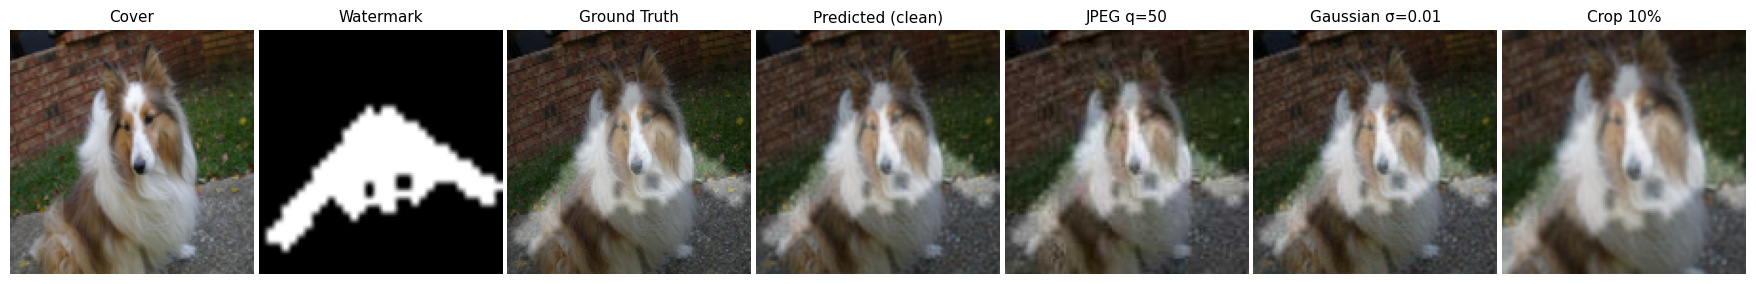

[SAVED] cnn_robustness_row.png


In [4]:
import numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# config for extraction
ALPHA  = 0.3     # blend alpha used to create blended target
THRESH = 0.5     # binarization threshold for watermark bits

# helpers (expects float images in [0,1], HxWxC)
def _jpeg(img01, quality=50):
    buf = BytesIO()
    Image.fromarray((img01 * 255.0).astype(np.uint8)).save(buf, format="JPEG", quality=int(quality))
    buf.seek(0)
    out = np.asarray(Image.open(buf).convert("RGB"), dtype=np.float32) / 255.0
    return out

def _gaussian(img01, sigma=0.01):
    n = np.random.normal(0.0, float(sigma), img01.shape).astype(np.float32)
    return np.clip(img01 + n, 0.0, 1.0)

def _crop_and_resize(img01, crop_ratio=0.10):
    h, w = img01.shape[:2]
    dy = int(round(h * crop_ratio)); dx = int(round(w * crop_ratio))
    if dy == 0 and dx == 0 or (h - 2*dy) <= 0 or (w - 2*dx) <= 0:
        return img01.copy()
    crop = img01[dy:h-dy, dx:w-dx, :]
    out = np.asarray(
        Image.fromarray((crop * 255).astype(np.uint8)).resize((w, h), Image.BILINEAR),
        dtype=np.float32
    ) / 255.0
    return out

def _psnr_from_images(a, b, eps=1e-12):
    mse = float(np.mean((a - b) ** 2))
    psnr = 10.0 * np.log10((1.0**2) / (mse + eps))
    return mse, psnr

def _ssim_img(a, b):
    try:    return ssim(a, b, data_range=1.0, channel_axis=2)
    except TypeError: return ssim(a, b, data_range=1.0, multichannel=True)

# extraction helpers
def _to_gray01(img):
    if img.ndim == 3 and img.shape[2] == 3:
        return (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.float32)
    return img.astype(np.float32)

def _binarize01(gray, thr=0.5):
    return (gray >= float(thr)).astype(np.uint8)

def _ber(a_bin, b_bin):
    return float(np.mean(a_bin != b_bin))

def _nc_classic(a_bin, b_bin, eps=1e-12):
    # Convert {0,1} -> {-1,+1}, then cosine similarity
    a = (a_bin.astype(np.float32) * 2.0) - 1.0
    b = (b_bin.astype(np.float32) * 2.0) - 1.0
    return float((a*b).sum() / (np.sqrt((a*a).sum())*np.sqrt((b*b).sum()) + eps))

def _extract_watermark(Y_obs, C_cover, alpha=ALPHA):
    if alpha <= 0:
        raise ValueError("ALPHA must be > 0 for extraction.")
    W_hat = (Y_obs - C_cover) / float(alpha)
    return np.clip(W_hat, 0.0, 1.0)

def _get_cover_mark(i, H, W):
    try:
        cov = Image.open(test_cover_paths[i]).convert("RGB").resize((W, H))
        mrk = Image.open(test_mark_paths[i]).convert("RGB").resize((W, H))
        return (np.asarray(cov, dtype=np.float32)/255.0,
                np.asarray(mrk, dtype=np.float32)/255.0)
    except Exception:
        return None, None

# CNN already has image tensors
# Yp, Yt are (N, H, W, 3) from your CNN eval block
N, H, W, C = Yp.shape

# evaluate the transform over the whole test set:
# mean per-image MSE/PSNR/SSIM and (if cover/mark available) BER/NC from extraction
def _eval_attack(transform):
    mses, psnrs, ssims = [], [], []
    bers, ncs = [], []
    have_pairs = True
    for i in range(N):
        Yt_i = Yt[i]               # blended ground truth
        Yp_i = Yp[i]               # clean predicted
        Ya   = transform(Yp_i)     # attacked predicted

        # image-level metrics vs ground truth blended
        mse_i, psnr_i = _psnr_from_images(Yt_i, Ya)
        mses.append(mse_i); psnrs.append(psnr_i); ssims.append(_ssim_img(Yt_i, Ya))

        # extraction metrics (require cover & true watermark)
        C_img, W_true = _get_cover_mark(i, H, W)
        if C_img is None or W_true is None:
            have_pairs = False
            continue
        W_hat  = _extract_watermark(Ya, C_img, alpha=ALPHA)
        Wt_bin = _binarize01(_to_gray01(W_true), thr=THRESH)
        Wh_bin = _binarize01(_to_gray01(W_hat),  thr=THRESH)
        bers.append(_ber(Wt_bin, Wh_bin))
        ncs.append(_nc_classic(Wt_bin, Wh_bin))   # classic ±1 NC

    out = {
        "mse": float(np.mean(mses)),
        "psnr": float(np.mean(psnrs)),
        "ssim": float(np.mean(ssims)),
        "have_pairs": have_pairs and len(bers) == N,   # True if we had pairs for all i
        "ber": float(np.mean(bers)) if len(bers) else None,
        "nc":  float(np.mean(ncs))  if len(ncs)  else None,
        "ber_n": len(bers)
    }
    return out

# Run clean + three attacks
res_clean = _eval_attack(lambda img: img)                # identity (no attack)
res_jpeg  = _eval_attack(lambda img: _jpeg(img, quality=50))
res_gaus  = _eval_attack(lambda img: _gaussian(img, sigma=0.01))
res_crop  = _eval_attack(lambda img: _crop_and_resize(img, crop_ratio=0.10))

print("\n[ROBUSTNESS — dataset mean metrics]")
def _line(name, r):
    base = f"{name:<12} -> MSE: {r['mse']:.6f} | PSNR: {r['psnr']:.2f} dB | SSIM: {r['ssim']:.4f}"
    if r['ber'] is not None and r['nc'] is not None:
        base += f" | BER: {r['ber']:.4f} (n={r['ber_n']}) | NC(±1): {r['nc']:.4f}"
    else:
        base += " | BER/NC: n/a (need cover+watermark)"
    print(base)

_line("Clean",          res_clean)
_line("JPEG(q=50)",     res_jpeg)
_line("Gaussian(0.01)", res_gaus)
_line("Crop(10%)",      res_crop)


# Visualization
viz_idx = 2  # change to view a different test sample

Yt_v = Yt[viz_idx]
Yp_v = Yp[viz_idx]
Yp_jpeg = _jpeg(Yp_v, quality=50)
Yp_gaus = _gaussian(Yp_v, sigma=0.01)
Yp_crop = _crop_and_resize(Yp_v, crop_ratio=0.10)

cover_img, mark_img = _get_cover_mark(viz_idx, H, W)

panels = [
    (cover_img if cover_img is not None else np.zeros_like(Yt_v), "Cover"),
    (mark_img  if mark_img  is not None else np.zeros_like(Yt_v), "Watermark"),
    (Yt_v,     "Ground Truth"),
    (Yp_v,     "Predicted (clean)"),
    (Yp_jpeg,  "JPEG q=50"),
    (Yp_gaus,  "Gaussian σ=0.01"),
    (Yp_crop,  "Crop 10%"),
]

w_per_img, h_in = 3.2, 3.2
fig, axes = plt.subplots(1, len(panels), figsize=(w_per_img*len(panels), h_in))
for ax, (img, title) in zip(axes, panels):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title, fontsize=11)
    ax.axis("off")
plt.subplots_adjust(wspace=0.02, hspace=0)

out_path = "cnn_robustness_row.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()
print(f"[SAVED] {out_path}")

XCPETION

### XCEPTION (Frozen) PIPELINE - PSNR, MSE, SSIM

In [16]:
import os, numpy as np, tensorflow as tf
from time import perf_counter
from contextlib import suppress
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import Xception, xception

# Config
INPUT_HW   = 299      # native Xception input size
TARGET_HW  = 128      # blended output size
RESIDUAL_SCALE = 0.8
EPOCHS = 4            # your setting

#CodeCarbon
try:
    from codecarbon import EmissionsTracker
    def _cc_start(name):
        try:
            tr = EmissionsTracker(project_name=name, output_dir=".", measure_power_secs=1)
            tr.start(); return tr
        except Exception:
            return None
    def _cc_stop(tr):
        if tr is None: return None
        with suppress(Exception): return tr.stop()
        return None
except Exception:
    def _cc_start(name): return None
    def _cc_stop(tr):    return None

# helpers
def _bytes_to_mb(n): return n / (1024**2)

def _count_images(ds):
    try:
        card = int(ds.cardinality().numpy())
        if card > 0:
            x, y = next(iter(ds.take(1)))
            # grab any tensor from dict for batch size
            if isinstance(x, dict):
                any_t = next(iter(x.values()))
            else:
                any_t = x
            bs = int(any_t.shape[0])
            return card * bs
    except Exception:
        pass
    # fallback: iterate (costly but reliable)
    cnt = 0
    for x, y in ds:
        if isinstance(x, dict):
            any_t = next(iter(x.values()))
        else:
            any_t = x
        cnt += int(any_t.shape[0])
    return cnt

def _dataset_ssim_one_number(y_true_imgs, y_pred_imgs):
    from skimage.metrics import structural_similarity as ssim
    y_true_big = np.concatenate(list(y_true_imgs), axis=0)  # (N*H, W, C)
    y_pred_big = np.concatenate(list(y_pred_imgs), axis=0)
    try:
        return float(ssim(y_true_big, y_pred_big, data_range=1.0, channel_axis=2))
    except TypeError:
        return float(ssim(y_true_big, y_pred_big, data_range=1.0, multichannel=True))

def _psnr_from_mse(mse, max_i=1.0, eps=1e-12):
    return 10.0 * np.log10((max_i**2) / (mse + eps))

# Mapping
def map_cover_mark(input_img, blended_img):
    cover = input_img[..., :3]      # (128,128,3)
    wm    = input_img[..., 3:6]     # (128,128,3)
    raw_128 = cover                 # residual base
    x_in    = tf.image.resize(cover, [INPUT_HW, INPUT_HW])
    x_in    = xception.preprocess_input(x_in * 255.0)  # [-1,1]
    y_out   = tf.image.resize(blended_img, [TARGET_HW, TARGET_HW])
    return {"raw": raw_128, "ximg": x_in, "wm": wm}, y_out

train_ds = train_image_ds.map(map_cover_mark, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_ds  =  test_image_ds.map(map_cover_mark,  num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Loss & metrics
def _sanitize01(x):
    x = tf.where(tf.math.is_finite(x), x, tf.zeros_like(x))
    return tf.clip_by_value(x, 0.0, 1.0)

def psnr_metric(y_true, y_pred):
    y_true = _sanitize01(y_true); y_pred = _sanitize01(y_pred)
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def ssim_metric(y_true, y_pred):
    y_true = _sanitize01(y_true); y_pred = _sanitize01(y_pred)
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def l1_ssim_grad_loss(y_true, y_pred, w_ssim=0.15, w_grad=0.10, eps=1e-9):
    y_true = _sanitize01(y_true); y_pred = _sanitize01(y_pred)
    l1 = tf.reduce_mean(tf.abs(y_true - y_pred))
    ssim_val = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    gt_edges = tf.image.sobel_edges(y_true)
    pr_edges = tf.image.sobel_edges(y_pred)
    gt_mag = tf.sqrt(tf.reduce_sum(tf.square(gt_edges), axis=-1) + eps)
    pr_mag = tf.sqrt(tf.reduce_sum(tf.square(pr_edges), axis=-1) + eps)
    grad_l1 = tf.reduce_mean(tf.abs(gt_mag - pr_mag))
    return l1 + w_ssim * (1.0 - ssim_val) + w_grad * grad_l1

# Model: frozen Xception + residual head (unchanged)
def shallow_pyramid_6ch(x6):
    s1 = layers.Conv2D(32, 3, padding='same', activation='relu')(x6)                 # 128x
    s2 = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(s1)      # 64x
    s3 = layers.Conv2D(128,3, strides=2, padding='same', activation='relu')(s2)      # 32x
    s4 = layers.Conv2D(256,3, strides=2, padding='same', activation='relu')(s3)      # 16x
    return s1, s2, s3, s4

def resize_like(x, ref, name=None):
    h = int(ref.shape[1]); w = int(ref.shape[2])
    return layers.Resizing(h, w, interpolation='bilinear', name=name)(x)

def build_xception_cover_wm(input_hw=INPUT_HW, target_hw=TARGET_HW):
    inp_raw = Input(shape=(target_hw, target_hw, 3), name="raw")   # cover @128 in [0,1]
    inp_x   = Input(shape=(input_hw, input_hw, 3),   name="ximg")  # preprocessed [-1,1]
    inp_wm  = Input(shape=(target_hw, target_hw, 3), name="wm")    # watermark @128 in [0,1]

    base = Xception(include_top=False, weights='imagenet', input_tensor=inp_x)
    base.trainable = False

    shallow_in = layers.Concatenate(name="shallow_in_cover_wm")([inp_raw, inp_wm])  # (128,128,6)
    s1, s2, s3, s4 = shallow_pyramid_6ch(shallow_in)

    x = base.output
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    # 16x
    x = resize_like(x, s4, name="to_16x"); x = layers.Concatenate()([x, s4])
    x = layers.Conv2D(192, 3, padding='same', activation='relu')(x)
    # 32x
    x = layers.UpSampling2D(2)(x); x = resize_like(x, s3, name="to_32x"); x = layers.Concatenate()([x, s3])
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    # 64x
    x = layers.UpSampling2D(2)(x); x = resize_like(x, s2, name="to_64x"); x = layers.Concatenate()([x, s2])
    x = layers.Conv2D(96,  3, padding='same', activation='relu')(x)
    # 128x
    x = layers.UpSampling2D(2)(x); x = resize_like(x, s1, name="to_128x"); x = layers.Concatenate()([x, s1])
    x = layers.Conv2D(64,  3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32,  3, padding='same', activation='relu')(x)

    delta = layers.Conv2D(3, 3, padding='same', activation='tanh', name="delta")(x)
    y_hat = layers.Lambda(lambda t: tf.clip_by_value(t[0] + RESIDUAL_SCALE * t[1], 0.0, 1.0),
                          name="add_residual")([inp_raw, delta])

    return Model({"raw": inp_raw, "ximg": inp_x, "wm": inp_wm}, y_hat,
                 name=f"xcept_frozen_res_in{input_hw}_out{target_hw}")

model = build_xception_cover_wm()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
              loss=l1_ssim_grad_loss, metrics=[psnr_metric, ssim_metric])

# dataset sizes (for ms/img )
N_train = _count_images(train_ds)
N_test  = _count_images(test_ds)

# TRAIN (timing + CO₂)
train_tracker = _cc_start("Xception_Watermark_Train")
t0 = perf_counter()
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds, verbose=1)
train_time_s = perf_counter() - t0
train_emissions_kg = _cc_stop(train_tracker)

train_ms_per_img = (train_time_s / max(1, N_train)) * 1000.0
print(f"[TRAIN] Xception total: {train_time_s:.2f}s for {N_train} imgs "
      f"({train_ms_per_img:.2f} ms/img) | CO2: {train_emissions_kg if train_emissions_kg is not None else 'n/a'}")

# INFERENCE (timing + CO₂) + EVAL (global MSE/PSNR + single SSIM)
for xb, yb in test_ds.take(1):
    _ = model(xb, training=False)

infer_tracker = _cc_start("Xception_Watermark_Inference")
t1 = perf_counter()

y_pred_list, y_true_list = [], []
for xb, yb in test_ds:
    yhat = model.predict(xb, verbose=0)
    y_pred_list.append(yhat)
    y_true_list.append(yb.numpy())

infer_time_s = perf_counter() - t1
infer_emissions_kg = _cc_stop(infer_tracker)

Yp = np.clip(np.concatenate(y_pred_list, axis=0), 0.0, 1.0).astype(np.float32)  # (N,H,W,3)
Yt = np.clip(np.concatenate(y_true_list, axis=0), 0.0, 1.0).astype(np.float32)
N_out = Yp.shape[0]

infer_ms_per_img = (infer_time_s / max(1, N_out)) * 1000.0
print(f"[INFER] Xception total: {infer_time_s:.3f}s for {N_out} imgs "
      f"({infer_ms_per_img:.2f} ms/img) | CO2: {infer_emissions_kg if infer_emissions_kg is not None else 'n/a'}")

# Global metrics (match LinearSVR/GBM/CNN-global)
eps = 1e-12
mse_global  = float(np.mean((Yt - Yp) ** 2))
psnr_global = float(_psnr_from_mse(mse_global, max_i=1.0, eps=eps))
ssim_single = _dataset_ssim_one_number(Yt, Yp)

print(f"[EVAL] Xception MSE: {mse_global:.6f} | PSNR: {psnr_global:.2f} dB | SSIM: {ssim_single:.4f}")

# SAVE ARTIFACTS and size
model_path = f"xception_frozen_res_in{INPUT_HW}_out{TARGET_HW}.h5"
model.save(model_path)
size_mb = _bytes_to_mb(os.path.getsize(model_path)) if os.path.exists(model_path) else 0.0
print(f"[SAVE] Artifacts written: {model_path}")
print(f"[SIZE] Xception (artifacts on disk): {size_mb:.2f} MB")

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[codecarbon WARNING @ 12:36:54] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:36:54] [setup] RAM Tracking...
[codecarbon INFO @ 12:36:54] [setup] CPU Tracking...
[codecarbon WARNING @ 12:36:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:36:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:36:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 12:36:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:36:55] [setup] GPU Tracking...
[codecarbon INFO @ 12:36:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:36:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/4


[codecarbon INFO @ 12:36:59] Energy consumed for RAM : 0.000006 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:36:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:36:59] Energy consumed for All CPU : 0.000012 kWh
[codecarbon INFO @ 12:36:59] Energy consumed for all GPUs : 0.000016 kWh. Total GPU Power : 56.607789002749904 W
[codecarbon INFO @ 12:36:59] 0.000034 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:00] Energy consumed for RAM : 0.000011 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:00] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:00] Energy consumed for All CPU : 0.000023 kWh
[codecarbon INFO @ 12:37:00] Energy consumed for all GPUs : 0.000032 kWh. Total GPU Power : 59.85743823320222 W
[codecarbon INFO @ 12:37:00] 0.000067 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:01] Energy consumed for RAM : 0.000016 kWh. RAM Power : 

  2/157 ━━━━━━━━━━━━━━━━━━━━ 1:20 517ms/step - loss: 0.2220 - psnr_metric: 14.4209 - ssim_metric: 0.7198 

[codecarbon INFO @ 12:37:45] Energy consumed for RAM : 0.000253 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:45] Energy consumed for All CPU : 0.000539 kWh
[codecarbon INFO @ 12:37:45] Energy consumed for all GPUs : 0.001024 kWh. Total GPU Power : 91.60685157510581 W
[codecarbon INFO @ 12:37:45] 0.001815 kWh of electricity used since the beginning.


  4/157 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - loss: 0.2096 - psnr_metric: 14.8722 - ssim_metric: 0.7364

[codecarbon INFO @ 12:37:46] Energy consumed for RAM : 0.000258 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:46] Energy consumed for All CPU : 0.000550 kWh
[codecarbon INFO @ 12:37:46] Energy consumed for all GPUs : 0.001051 kWh. Total GPU Power : 98.86034147571355 W
[codecarbon INFO @ 12:37:46] 0.001859 kWh of electricity used since the beginning.


  6/157 ━━━━━━━━━━━━━━━━━━━━ 1:07 445ms/step - loss: 0.1978 - psnr_metric: 15.4350 - ssim_metric: 0.7511

[codecarbon INFO @ 12:37:47] Energy consumed for RAM : 0.000264 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:47] Energy consumed for All CPU : 0.000562 kWh
[codecarbon INFO @ 12:37:47] Energy consumed for all GPUs : 0.001078 kWh. Total GPU Power : 97.38082125882305 W
[codecarbon INFO @ 12:37:47] 0.001903 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:47] 0.017411 g.CO2eq/s mean an estimation of 549.0684620530093 kg.CO2eq/year


  9/157 ━━━━━━━━━━━━━━━━━━━━ 1:04 437ms/step - loss: 0.1829 - psnr_metric: 16.2331 - ssim_metric: 0.7710

[codecarbon INFO @ 12:37:48] Energy consumed for RAM : 0.000269 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:48] Energy consumed for All CPU : 0.000574 kWh
[codecarbon INFO @ 12:37:48] Energy consumed for all GPUs : 0.001105 kWh. Total GPU Power : 98.3101430938316 W
[codecarbon INFO @ 12:37:48] 0.001948 kWh of electricity used since the beginning.


 11/157 ━━━━━━━━━━━━━━━━━━━━ 1:03 435ms/step - loss: 0.1749 - psnr_metric: 16.7001 - ssim_metric: 0.7819

[codecarbon INFO @ 12:37:49] Energy consumed for RAM : 0.000275 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:49] Energy consumed for All CPU : 0.000586 kWh
[codecarbon INFO @ 12:37:49] Energy consumed for all GPUs : 0.001132 kWh. Total GPU Power : 98.72978284955678 W
[codecarbon INFO @ 12:37:49] 0.001992 kWh of electricity used since the beginning.


 13/157 ━━━━━━━━━━━━━━━━━━━━ 1:02 435ms/step - loss: 0.1678 - psnr_metric: 17.1381 - ssim_metric: 0.7916

[codecarbon INFO @ 12:37:50] Energy consumed for RAM : 0.000280 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:50] Energy consumed for All CPU : 0.000597 kWh
[codecarbon INFO @ 12:37:50] Energy consumed for all GPUs : 0.001159 kWh. Total GPU Power : 97.55942697921893 W
[codecarbon INFO @ 12:37:50] 0.002036 kWh of electricity used since the beginning.


 16/157 ━━━━━━━━━━━━━━━━━━━━ 1:01 434ms/step - loss: 0.1586 - psnr_metric: 17.7459 - ssim_metric: 0.8042

[codecarbon INFO @ 12:37:51] Energy consumed for RAM : 0.000286 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:51] Energy consumed for All CPU : 0.000609 kWh
[codecarbon INFO @ 12:37:51] Energy consumed for all GPUs : 0.001186 kWh. Total GPU Power : 98.34592513247722 W
[codecarbon INFO @ 12:37:51] 0.002080 kWh of electricity used since the beginning.


 18/157 ━━━━━━━━━━━━━━━━━━━━ 1:00 434ms/step - loss: 0.1532 - psnr_metric: 18.1213 - ssim_metric: 0.8115

[codecarbon INFO @ 12:37:52] Energy consumed for RAM : 0.000291 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:52] Energy consumed for All CPU : 0.000621 kWh
[codecarbon INFO @ 12:37:52] Energy consumed for all GPUs : 0.001211 kWh. Total GPU Power : 91.28579705607694 W
[codecarbon INFO @ 12:37:52] 0.002123 kWh of electricity used since the beginning.


 20/157 ━━━━━━━━━━━━━━━━━━━━ 59s 434ms/step - loss: 0.1484 - psnr_metric: 18.4719 - ssim_metric: 0.8181

[codecarbon INFO @ 12:37:53] Energy consumed for RAM : 0.000297 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:53] Energy consumed for All CPU : 0.000632 kWh
[codecarbon INFO @ 12:37:53] Energy consumed for all GPUs : 0.001238 kWh. Total GPU Power : 97.53894908299607 W
[codecarbon INFO @ 12:37:53] 0.002167 kWh of electricity used since the beginning.


 23/157 ━━━━━━━━━━━━━━━━━━━━ 58s 434ms/step - loss: 0.1419 - psnr_metric: 18.9583 - ssim_metric: 0.8268

[codecarbon INFO @ 12:37:54] Energy consumed for RAM : 0.000302 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:54] Energy consumed for All CPU : 0.000644 kWh
[codecarbon INFO @ 12:37:54] Energy consumed for all GPUs : 0.001265 kWh. Total GPU Power : 97.69409359953004 W
[codecarbon INFO @ 12:37:54] 0.002211 kWh of electricity used since the beginning.


 25/157 ━━━━━━━━━━━━━━━━━━━━ 57s 433ms/step - loss: 0.1381 - psnr_metric: 19.2581 - ssim_metric: 0.8320

[codecarbon INFO @ 12:37:55] Energy consumed for RAM : 0.000308 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:55] Energy consumed for All CPU : 0.000656 kWh
[codecarbon INFO @ 12:37:55] Energy consumed for all GPUs : 0.001292 kWh. Total GPU Power : 98.77444861553994 W
[codecarbon INFO @ 12:37:55] 0.002256 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:55] 0.019939 g.CO2eq/s mean an estimation of 628.8058322999397 kg.CO2eq/year


 27/157 ━━━━━━━━━━━━━━━━━━━━ 56s 433ms/step - loss: 0.1346 - psnr_metric: 19.5390 - ssim_metric: 0.8368

[codecarbon INFO @ 12:37:56] Energy consumed for RAM : 0.000313 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:56] Energy consumed for All CPU : 0.000668 kWh
[codecarbon INFO @ 12:37:56] Energy consumed for all GPUs : 0.001319 kWh. Total GPU Power : 97.32866389667575 W
[codecarbon INFO @ 12:37:56] 0.002300 kWh of electricity used since the beginning.


 30/157 ━━━━━━━━━━━━━━━━━━━━ 55s 433ms/step - loss: 0.1298 - psnr_metric: 19.9300 - ssim_metric: 0.8433

[codecarbon INFO @ 12:37:57] Energy consumed for RAM : 0.000319 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:57] Energy consumed for All CPU : 0.000679 kWh
[codecarbon INFO @ 12:37:57] Energy consumed for all GPUs : 0.001346 kWh. Total GPU Power : 98.27649944839351 W
[codecarbon INFO @ 12:37:57] 0.002344 kWh of electricity used since the beginning.


 32/157 ━━━━━━━━━━━━━━━━━━━━ 54s 432ms/step - loss: 0.1269 - psnr_metric: 20.1741 - ssim_metric: 0.8472

[codecarbon INFO @ 12:37:58] Energy consumed for RAM : 0.000324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:58] Energy consumed for All CPU : 0.000691 kWh
[codecarbon INFO @ 12:37:58] Energy consumed for all GPUs : 0.001374 kWh. Total GPU Power : 99.6740724487664 W
[codecarbon INFO @ 12:37:58] 0.002389 kWh of electricity used since the beginning.


 34/157 ━━━━━━━━━━━━━━━━━━━━ 53s 432ms/step - loss: 0.1242 - psnr_metric: 20.4053 - ssim_metric: 0.8509

[codecarbon INFO @ 12:37:59] Energy consumed for RAM : 0.000330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:37:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:59] Energy consumed for All CPU : 0.000703 kWh
[codecarbon INFO @ 12:37:59] Energy consumed for all GPUs : 0.001400 kWh. Total GPU Power : 96.86593081638838 W
[codecarbon INFO @ 12:37:59] 0.002433 kWh of electricity used since the beginning.


 37/157 ━━━━━━━━━━━━━━━━━━━━ 51s 433ms/step - loss: 0.1204 - psnr_metric: 20.7318 - ssim_metric: 0.8560

[codecarbon INFO @ 12:38:00] Energy consumed for RAM : 0.000335 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:00] Energy consumed for All CPU : 0.000714 kWh
[codecarbon INFO @ 12:38:00] Energy consumed for all GPUs : 0.001428 kWh. Total GPU Power : 98.68843879833291 W
[codecarbon INFO @ 12:38:00] 0.002477 kWh of electricity used since the beginning.


 39/157 ━━━━━━━━━━━━━━━━━━━━ 51s 433ms/step - loss: 0.1181 - psnr_metric: 20.9384 - ssim_metric: 0.8591

[codecarbon INFO @ 12:38:01] Energy consumed for RAM : 0.000341 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:01] Energy consumed for All CPU : 0.000726 kWh
[codecarbon INFO @ 12:38:01] Energy consumed for all GPUs : 0.001453 kWh. Total GPU Power : 91.26348448953658 W
[codecarbon INFO @ 12:38:01] 0.002519 kWh of electricity used since the beginning.


 41/157 ━━━━━━━━━━━━━━━━━━━━ 50s 433ms/step - loss: 0.1159 - psnr_metric: 21.1361 - ssim_metric: 0.8620

[codecarbon INFO @ 12:38:02] Energy consumed for RAM : 0.000346 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:02] Energy consumed for All CPU : 0.000738 kWh
[codecarbon INFO @ 12:38:02] Energy consumed for all GPUs : 0.001480 kWh. Total GPU Power : 98.50008904770095 W
[codecarbon INFO @ 12:38:02] 0.002564 kWh of electricity used since the beginning.


 43/157 ━━━━━━━━━━━━━━━━━━━━ 49s 433ms/step - loss: 0.1138 - psnr_metric: 21.3257 - ssim_metric: 0.8648

[codecarbon INFO @ 12:38:03] Energy consumed for RAM : 0.000352 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:03] Energy consumed for All CPU : 0.000749 kWh
[codecarbon INFO @ 12:38:03] Energy consumed for all GPUs : 0.001507 kWh. Total GPU Power : 96.9056310266348 W
[codecarbon INFO @ 12:38:03] 0.002608 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:03] 0.019903 g.CO2eq/s mean an estimation of 627.6727611095313 kg.CO2eq/year


 46/157 ━━━━━━━━━━━━━━━━━━━━ 48s 434ms/step - loss: 0.1109 - psnr_metric: 21.5968 - ssim_metric: 0.8687

[codecarbon INFO @ 12:38:04] Energy consumed for RAM : 0.000357 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:04] Energy consumed for All CPU : 0.000761 kWh
[codecarbon INFO @ 12:38:04] Energy consumed for all GPUs : 0.001534 kWh. Total GPU Power : 97.71208552364686 W
[codecarbon INFO @ 12:38:04] 0.002652 kWh of electricity used since the beginning.


 48/157 ━━━━━━━━━━━━━━━━━━━━ 47s 434ms/step - loss: 0.1091 - psnr_metric: 21.7691 - ssim_metric: 0.8711

[codecarbon INFO @ 12:38:05] Energy consumed for RAM : 0.000363 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:05] Energy consumed for All CPU : 0.000773 kWh
[codecarbon INFO @ 12:38:05] Energy consumed for all GPUs : 0.001561 kWh. Total GPU Power : 98.64416525932617 W
[codecarbon INFO @ 12:38:05] 0.002696 kWh of electricity used since the beginning.


 50/157 ━━━━━━━━━━━━━━━━━━━━ 46s 434ms/step - loss: 0.1074 - psnr_metric: 21.9356 - ssim_metric: 0.8734

[codecarbon INFO @ 12:38:06] Energy consumed for RAM : 0.000368 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:06] Energy consumed for All CPU : 0.000785 kWh
[codecarbon INFO @ 12:38:06] Energy consumed for all GPUs : 0.001588 kWh. Total GPU Power : 97.5426028622129 W
[codecarbon INFO @ 12:38:06] 0.002740 kWh of electricity used since the beginning.


 53/157 ━━━━━━━━━━━━━━━━━━━━ 45s 434ms/step - loss: 0.1049 - psnr_metric: 22.1745 - ssim_metric: 0.8767

[codecarbon INFO @ 12:38:07] Energy consumed for RAM : 0.000374 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:07] Energy consumed for All CPU : 0.000796 kWh
[codecarbon INFO @ 12:38:07] Energy consumed for all GPUs : 0.001615 kWh. Total GPU Power : 98.00089187804791 W
[codecarbon INFO @ 12:38:07] 0.002785 kWh of electricity used since the beginning.


 55/157 ━━━━━━━━━━━━━━━━━━━━ 44s 435ms/step - loss: 0.1034 - psnr_metric: 22.3276 - ssim_metric: 0.8787

[codecarbon INFO @ 12:38:08] Energy consumed for RAM : 0.000379 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:08] Energy consumed for All CPU : 0.000808 kWh
[codecarbon INFO @ 12:38:08] Energy consumed for all GPUs : 0.001642 kWh. Total GPU Power : 99.16133775470468 W
[codecarbon INFO @ 12:38:08] 0.002829 kWh of electricity used since the beginning.


 57/157 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - loss: 0.1019 - psnr_metric: 22.4758 - ssim_metric: 0.8807

[codecarbon INFO @ 12:38:09] Energy consumed for RAM : 0.000385 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:09] Energy consumed for All CPU : 0.000820 kWh
[codecarbon INFO @ 12:38:09] Energy consumed for all GPUs : 0.001669 kWh. Total GPU Power : 97.32512589639289 W
[codecarbon INFO @ 12:38:09] 0.002873 kWh of electricity used since the beginning.


 59/157 ━━━━━━━━━━━━━━━━━━━━ 42s 435ms/step - loss: 0.1005 - psnr_metric: 22.6196 - ssim_metric: 0.8826

[codecarbon INFO @ 12:38:10] Energy consumed for RAM : 0.000390 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:10] Energy consumed for All CPU : 0.000831 kWh
[codecarbon INFO @ 12:38:10] Energy consumed for all GPUs : 0.001694 kWh. Total GPU Power : 90.76128223016599 W
[codecarbon INFO @ 12:38:10] 0.002915 kWh of electricity used since the beginning.


 62/157 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step - loss: 0.0985 - psnr_metric: 22.8274 - ssim_metric: 0.8852

[codecarbon INFO @ 12:38:11] Energy consumed for RAM : 0.000396 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:11] Energy consumed for All CPU : 0.000843 kWh
[codecarbon INFO @ 12:38:11] Energy consumed for all GPUs : 0.001721 kWh. Total GPU Power : 97.42507725307058 W
[codecarbon INFO @ 12:38:11] 0.002960 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:11] 0.019885 g.CO2eq/s mean an estimation of 627.0878333890238 kg.CO2eq/year


 64/157 ━━━━━━━━━━━━━━━━━━━━ 40s 436ms/step - loss: 0.0972 - psnr_metric: 22.9611 - ssim_metric: 0.8869

[codecarbon INFO @ 12:38:12] Energy consumed for RAM : 0.000401 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:12] Energy consumed for All CPU : 0.000855 kWh
[codecarbon INFO @ 12:38:12] Energy consumed for all GPUs : 0.001748 kWh. Total GPU Power : 98.01610310667056 W
[codecarbon INFO @ 12:38:12] 0.003004 kWh of electricity used since the beginning.


 66/157 ━━━━━━━━━━━━━━━━━━━━ 39s 436ms/step - loss: 0.0960 - psnr_metric: 23.0910 - ssim_metric: 0.8885

[codecarbon INFO @ 12:38:13] Energy consumed for RAM : 0.000407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:13] Energy consumed for All CPU : 0.000866 kWh
[codecarbon INFO @ 12:38:13] Energy consumed for all GPUs : 0.001775 kWh. Total GPU Power : 98.3167062233824 W
[codecarbon INFO @ 12:38:13] 0.003048 kWh of electricity used since the beginning.


 68/157 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - loss: 0.0948 - psnr_metric: 23.2174 - ssim_metric: 0.8901

[codecarbon INFO @ 12:38:14] Energy consumed for RAM : 0.000412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:14] Energy consumed for All CPU : 0.000878 kWh
[codecarbon INFO @ 12:38:14] Energy consumed for all GPUs : 0.001802 kWh. Total GPU Power : 96.57202972695514 W
[codecarbon INFO @ 12:38:14] 0.003092 kWh of electricity used since the beginning.


 71/157 ━━━━━━━━━━━━━━━━━━━━ 37s 437ms/step - loss: 0.0931 - psnr_metric: 23.4008 - ssim_metric: 0.8923

[codecarbon INFO @ 12:38:15] Energy consumed for RAM : 0.000418 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:15] Energy consumed for All CPU : 0.000890 kWh
[codecarbon INFO @ 12:38:15] Energy consumed for all GPUs : 0.001829 kWh. Total GPU Power : 97.8177404025499 W
[codecarbon INFO @ 12:38:15] 0.003136 kWh of electricity used since the beginning.


 73/157 ━━━━━━━━━━━━━━━━━━━━ 36s 437ms/step - loss: 0.0920 - psnr_metric: 23.5191 - ssim_metric: 0.8937

[codecarbon INFO @ 12:38:16] Energy consumed for RAM : 0.000423 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:16] Energy consumed for All CPU : 0.000902 kWh
[codecarbon INFO @ 12:38:16] Energy consumed for all GPUs : 0.001856 kWh. Total GPU Power : 98.14690988279241 W
[codecarbon INFO @ 12:38:16] 0.003180 kWh of electricity used since the beginning.


 75/157 ━━━━━━━━━━━━━━━━━━━━ 35s 437ms/step - loss: 0.0910 - psnr_metric: 23.6345 - ssim_metric: 0.8951

[codecarbon INFO @ 12:38:17] Energy consumed for RAM : 0.000429 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:17] Energy consumed for All CPU : 0.000913 kWh
[codecarbon INFO @ 12:38:17] Energy consumed for all GPUs : 0.001883 kWh. Total GPU Power : 97.1267125700164 W
[codecarbon INFO @ 12:38:17] 0.003224 kWh of electricity used since the beginning.


 77/157 ━━━━━━━━━━━━━━━━━━━━ 34s 437ms/step - loss: 0.0900 - psnr_metric: 23.7467 - ssim_metric: 0.8964

[codecarbon INFO @ 12:38:18] Energy consumed for RAM : 0.000434 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:18] Energy consumed for All CPU : 0.000925 kWh
[codecarbon INFO @ 12:38:18] Energy consumed for all GPUs : 0.001909 kWh. Total GPU Power : 94.71826089533945 W
[codecarbon INFO @ 12:38:18] 0.003268 kWh of electricity used since the beginning.


 80/157 ━━━━━━━━━━━━━━━━━━━━ 33s 437ms/step - loss: 0.0885 - psnr_metric: 23.9102 - ssim_metric: 0.8983

[codecarbon INFO @ 12:38:19] Energy consumed for RAM : 0.000440 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:19] Energy consumed for All CPU : 0.000937 kWh
[codecarbon INFO @ 12:38:19] Energy consumed for all GPUs : 0.001935 kWh. Total GPU Power : 93.90873734898608 W
[codecarbon INFO @ 12:38:19] 0.003311 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:19] 0.019853 g.CO2eq/s mean an estimation of 626.0863426236702 kg.CO2eq/year


 82/157 ━━━━━━━━━━━━━━━━━━━━ 32s 438ms/step - loss: 0.0876 - psnr_metric: 24.0161 - ssim_metric: 0.8996

[codecarbon INFO @ 12:38:20] Energy consumed for RAM : 0.000445 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:20] Energy consumed for All CPU : 0.000948 kWh
[codecarbon INFO @ 12:38:20] Energy consumed for all GPUs : 0.001961 kWh. Total GPU Power : 95.92437930732834 W
[codecarbon INFO @ 12:38:20] 0.003354 kWh of electricity used since the beginning.


 84/157 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - loss: 0.0867 - psnr_metric: 24.1199 - ssim_metric: 0.9007

[codecarbon INFO @ 12:38:21] Energy consumed for RAM : 0.000451 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:21] Energy consumed for All CPU : 0.000960 kWh
[codecarbon INFO @ 12:38:21] Energy consumed for all GPUs : 0.001988 kWh. Total GPU Power : 97.76184979122651 W
[codecarbon INFO @ 12:38:21] 0.003398 kWh of electricity used since the beginning.


 86/157 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - loss: 0.0858 - psnr_metric: 24.2215 - ssim_metric: 0.9019

[codecarbon INFO @ 12:38:22] Energy consumed for RAM : 0.000456 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:22] Energy consumed for All CPU : 0.000972 kWh
[codecarbon INFO @ 12:38:22] Energy consumed for all GPUs : 0.002015 kWh. Total GPU Power : 96.59262117242665 W
[codecarbon INFO @ 12:38:22] 0.003442 kWh of electricity used since the beginning.


 89/157 ━━━━━━━━━━━━━━━━━━━━ 29s 438ms/step - loss: 0.0845 - psnr_metric: 24.3702 - ssim_metric: 0.9035

[codecarbon INFO @ 12:38:23] Energy consumed for RAM : 0.000462 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:23] Energy consumed for All CPU : 0.000983 kWh
[codecarbon INFO @ 12:38:23] Energy consumed for all GPUs : 0.002042 kWh. Total GPU Power : 98.0521612708183 W
[codecarbon INFO @ 12:38:23] 0.003487 kWh of electricity used since the beginning.


 91/157 ━━━━━━━━━━━━━━━━━━━━ 28s 439ms/step - loss: 0.0837 - psnr_metric: 24.4667 - ssim_metric: 0.9046

[codecarbon INFO @ 12:38:24] Energy consumed for RAM : 0.000467 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:24] Energy consumed for All CPU : 0.000995 kWh
[codecarbon INFO @ 12:38:24] Energy consumed for all GPUs : 0.002069 kWh. Total GPU Power : 98.80973007641016 W
[codecarbon INFO @ 12:38:24] 0.003531 kWh of electricity used since the beginning.


 93/157 ━━━━━━━━━━━━━━━━━━━━ 28s 439ms/step - loss: 0.0829 - psnr_metric: 24.5613 - ssim_metric: 0.9056

[codecarbon INFO @ 12:38:25] Energy consumed for RAM : 0.000473 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:25] Energy consumed for All CPU : 0.001007 kWh
[codecarbon INFO @ 12:38:25] Energy consumed for all GPUs : 0.002096 kWh. Total GPU Power : 97.53054553927025 W
[codecarbon INFO @ 12:38:25] 0.003575 kWh of electricity used since the beginning.


 95/157 ━━━━━━━━━━━━━━━━━━━━ 27s 439ms/step - loss: 0.0821 - psnr_metric: 24.6541 - ssim_metric: 0.9066

[codecarbon INFO @ 12:38:26] Energy consumed for RAM : 0.000478 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:26] Energy consumed for All CPU : 0.001019 kWh
[codecarbon INFO @ 12:38:26] Energy consumed for all GPUs : 0.002122 kWh. Total GPU Power : 96.77286087327347 W
[codecarbon INFO @ 12:38:26] 0.003619 kWh of electricity used since the beginning.


 97/157 ━━━━━━━━━━━━━━━━━━━━ 26s 439ms/step - loss: 0.0814 - psnr_metric: 24.7450 - ssim_metric: 0.9076

[codecarbon INFO @ 12:38:27] Energy consumed for RAM : 0.000484 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:27] Energy consumed for All CPU : 0.001030 kWh


 98/157 ━━━━━━━━━━━━━━━━━━━━ 25s 439ms/step - loss: 0.0810 - psnr_metric: 24.7899 - ssim_metric: 0.9081

[codecarbon INFO @ 12:38:27] Energy consumed for all GPUs : 0.002149 kWh. Total GPU Power : 97.70648503413148 W
[codecarbon INFO @ 12:38:27] 0.003663 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:27] 0.019928 g.CO2eq/s mean an estimation of 628.4396651414147 kg.CO2eq/year


100/157 ━━━━━━━━━━━━━━━━━━━━ 25s 439ms/step - loss: 0.0803 - psnr_metric: 24.8782 - ssim_metric: 0.9090

[codecarbon INFO @ 12:38:28] Energy consumed for RAM : 0.000489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:28] Energy consumed for All CPU : 0.001042 kWh
[codecarbon INFO @ 12:38:28] Energy consumed for all GPUs : 0.002174 kWh. Total GPU Power : 91.57293309443546 W
[codecarbon INFO @ 12:38:28] 0.003705 kWh of electricity used since the beginning.


102/157 ━━━━━━━━━━━━━━━━━━━━ 24s 440ms/step - loss: 0.0796 - psnr_metric: 24.9651 - ssim_metric: 0.9099

[codecarbon INFO @ 12:38:29] Energy consumed for RAM : 0.000495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:29] Energy consumed for All CPU : 0.001054 kWh
[codecarbon INFO @ 12:38:29] Energy consumed for all GPUs : 0.002202 kWh. Total GPU Power : 98.86249934861216 W
[codecarbon INFO @ 12:38:29] 0.003750 kWh of electricity used since the beginning.


104/157 ━━━━━━━━━━━━━━━━━━━━ 23s 440ms/step - loss: 0.0789 - psnr_metric: 25.0505 - ssim_metric: 0.9108

[codecarbon INFO @ 12:38:30] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:30] Energy consumed for All CPU : 0.001065 kWh
[codecarbon INFO @ 12:38:30] Energy consumed for all GPUs : 0.002229 kWh. Total GPU Power : 97.46720522988619 W
[codecarbon INFO @ 12:38:30] 0.003794 kWh of electricity used since the beginning.


106/157 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - loss: 0.0782 - psnr_metric: 25.1343 - ssim_metric: 0.9117

[codecarbon INFO @ 12:38:31] Energy consumed for RAM : 0.000506 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:31] Energy consumed for All CPU : 0.001077 kWh
[codecarbon INFO @ 12:38:31] Energy consumed for all GPUs : 0.002255 kWh. Total GPU Power : 97.01679377831417 W
[codecarbon INFO @ 12:38:31] 0.003838 kWh of electricity used since the beginning.


109/157 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - loss: 0.0772 - psnr_metric: 25.2572 - ssim_metric: 0.9129

[codecarbon INFO @ 12:38:32] Energy consumed for RAM : 0.000511 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:32] Energy consumed for All CPU : 0.001089 kWh
[codecarbon INFO @ 12:38:32] Energy consumed for all GPUs : 0.002282 kWh. Total GPU Power : 97.2895725422011 W
[codecarbon INFO @ 12:38:32] 0.003882 kWh of electricity used since the beginning.


111/157 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - loss: 0.0766 - psnr_metric: 25.3375 - ssim_metric: 0.9138

[codecarbon INFO @ 12:38:33] Energy consumed for RAM : 0.000517 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:33] Energy consumed for All CPU : 0.001100 kWh
[codecarbon INFO @ 12:38:33] Energy consumed for all GPUs : 0.002309 kWh. Total GPU Power : 97.9522096844701 W
[codecarbon INFO @ 12:38:33] 0.003926 kWh of electricity used since the beginning.


113/157 ━━━━━━━━━━━━━━━━━━━━ 19s 440ms/step - loss: 0.0760 - psnr_metric: 25.4163 - ssim_metric: 0.9146

[codecarbon INFO @ 12:38:34] Energy consumed for RAM : 0.000522 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:34] Energy consumed for All CPU : 0.001112 kWh
[codecarbon INFO @ 12:38:34] Energy consumed for all GPUs : 0.002336 kWh. Total GPU Power : 96.67107901267319 W
[codecarbon INFO @ 12:38:34] 0.003970 kWh of electricity used since the beginning.


115/157 ━━━━━━━━━━━━━━━━━━━━ 18s 440ms/step - loss: 0.0754 - psnr_metric: 25.4937 - ssim_metric: 0.9153

[codecarbon INFO @ 12:38:35] Energy consumed for RAM : 0.000528 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:35] Energy consumed for All CPU : 0.001124 kWh
[codecarbon INFO @ 12:38:35] Energy consumed for all GPUs : 0.002363 kWh. Total GPU Power : 97.25196075357044 W
[codecarbon INFO @ 12:38:35] 0.004014 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:35] 0.019865 g.CO2eq/s mean an estimation of 626.4774657914588 kg.CO2eq/year


118/157 ━━━━━━━━━━━━━━━━━━━━ 17s 441ms/step - loss: 0.0745 - psnr_metric: 25.6075 - ssim_metric: 0.9165

[codecarbon INFO @ 12:38:36] Energy consumed for RAM : 0.000533 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:36] Energy consumed for All CPU : 0.001136 kWh
[codecarbon INFO @ 12:38:36] Energy consumed for all GPUs : 0.002388 kWh. Total GPU Power : 91.03245563404208 W
[codecarbon INFO @ 12:38:36] 0.004057 kWh of electricity used since the beginning.


120/157 ━━━━━━━━━━━━━━━━━━━━ 16s 441ms/step - loss: 0.0739 - psnr_metric: 25.6819 - ssim_metric: 0.9172

[codecarbon INFO @ 12:38:37] Energy consumed for RAM : 0.000539 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:37] Energy consumed for All CPU : 0.001147 kWh
[codecarbon INFO @ 12:38:37] Energy consumed for all GPUs : 0.002415 kWh. Total GPU Power : 97.71612273627007 W
[codecarbon INFO @ 12:38:37] 0.004101 kWh of electricity used since the beginning.


122/157 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - loss: 0.0734 - psnr_metric: 25.7551 - ssim_metric: 0.9179

[codecarbon INFO @ 12:38:38] Energy consumed for RAM : 0.000544 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:38] Energy consumed for All CPU : 0.001159 kWh
[codecarbon INFO @ 12:38:38] Energy consumed for all GPUs : 0.002442 kWh. Total GPU Power : 98.05495184160782 W
[codecarbon INFO @ 12:38:38] 0.004145 kWh of electricity used since the beginning.


124/157 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step - loss: 0.0728 - psnr_metric: 25.8271 - ssim_metric: 0.9186

[codecarbon INFO @ 12:38:39] Energy consumed for RAM : 0.000550 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:39] Energy consumed for All CPU : 0.001171 kWh
[codecarbon INFO @ 12:38:39] Energy consumed for all GPUs : 0.002468 kWh. Total GPU Power : 96.66072316315699 W
[codecarbon INFO @ 12:38:39] 0.004189 kWh of electricity used since the beginning.


126/157 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step - loss: 0.0723 - psnr_metric: 25.8979 - ssim_metric: 0.9193

[codecarbon INFO @ 12:38:40] Energy consumed for RAM : 0.000555 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:40] Energy consumed for All CPU : 0.001182 kWh
[codecarbon INFO @ 12:38:40] Energy consumed for all GPUs : 0.002495 kWh. Total GPU Power : 97.54922894104294 W
[codecarbon INFO @ 12:38:40] 0.004233 kWh of electricity used since the beginning.


129/157 ━━━━━━━━━━━━━━━━━━━━ 12s 442ms/step - loss: 0.0715 - psnr_metric: 26.0022 - ssim_metric: 0.9203

[codecarbon INFO @ 12:38:41] Energy consumed for RAM : 0.000561 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:41] Energy consumed for All CPU : 0.001194 kWh
[codecarbon INFO @ 12:38:41] Energy consumed for all GPUs : 0.002522 kWh. Total GPU Power : 97.02336487108123 W
[codecarbon INFO @ 12:38:41] 0.004277 kWh of electricity used since the beginning.


131/157 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - loss: 0.0710 - psnr_metric: 26.0704 - ssim_metric: 0.9209

[codecarbon INFO @ 12:38:42] Energy consumed for RAM : 0.000566 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:42] Energy consumed for All CPU : 0.001206 kWh
[codecarbon INFO @ 12:38:42] Energy consumed for all GPUs : 0.002549 kWh. Total GPU Power : 98.00615614049455 W
[codecarbon INFO @ 12:38:42] 0.004321 kWh of electricity used since the beginning.


133/157 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step - loss: 0.0705 - psnr_metric: 26.1376 - ssim_metric: 0.9216

[codecarbon INFO @ 12:38:43] Energy consumed for RAM : 0.000572 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:43] Energy consumed for All CPU : 0.001218 kWh
[codecarbon INFO @ 12:38:43] Energy consumed for all GPUs : 0.002576 kWh. Total GPU Power : 97.10747801734867 W
[codecarbon INFO @ 12:38:43] 0.004365 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:43] 0.019859 g.CO2eq/s mean an estimation of 626.2619019297217 kg.CO2eq/year


135/157 ━━━━━━━━━━━━━━━━━━━━ 9s 442ms/step - loss: 0.0700 - psnr_metric: 26.2038 - ssim_metric: 0.9222 

[codecarbon INFO @ 12:38:44] Energy consumed for RAM : 0.000577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:44] Energy consumed for All CPU : 0.001229 kWh
[codecarbon INFO @ 12:38:44] Energy consumed for all GPUs : 0.002603 kWh. Total GPU Power : 97.00068400956428 W
[codecarbon INFO @ 12:38:44] 0.004409 kWh of electricity used since the beginning.


138/157 ━━━━━━━━━━━━━━━━━━━━ 8s 442ms/step - loss: 0.0693 - psnr_metric: 26.3012 - ssim_metric: 0.9231

[codecarbon INFO @ 12:38:45] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:45] Energy consumed for All CPU : 0.001241 kWh
[codecarbon INFO @ 12:38:45] Energy consumed for all GPUs : 0.002628 kWh. Total GPU Power : 90.61210695747488 W
[codecarbon INFO @ 12:38:45] 0.004452 kWh of electricity used since the beginning.


140/157 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - loss: 0.0688 - psnr_metric: 26.3650 - ssim_metric: 0.9237

[codecarbon INFO @ 12:38:46] Energy consumed for RAM : 0.000588 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:46] Energy consumed for All CPU : 0.001253 kWh
[codecarbon INFO @ 12:38:46] Energy consumed for all GPUs : 0.002655 kWh. Total GPU Power : 98.37949603732856 W
[codecarbon INFO @ 12:38:46] 0.004495 kWh of electricity used since the beginning.


142/157 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - loss: 0.0684 - psnr_metric: 26.4279 - ssim_metric: 0.9243

[codecarbon INFO @ 12:38:47] Energy consumed for RAM : 0.000594 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:47] Energy consumed for All CPU : 0.001264 kWh
[codecarbon INFO @ 12:38:47] Energy consumed for all GPUs : 0.002682 kWh. Total GPU Power : 98.67231230887494 W
[codecarbon INFO @ 12:38:47] 0.004540 kWh of electricity used since the beginning.


144/157 ━━━━━━━━━━━━━━━━━━━━ 5s 443ms/step - loss: 0.0679 - psnr_metric: 26.4901 - ssim_metric: 0.9248

[codecarbon INFO @ 12:38:48] Energy consumed for RAM : 0.000599 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:48] Energy consumed for All CPU : 0.001276 kWh
[codecarbon INFO @ 12:38:48] Energy consumed for all GPUs : 0.002709 kWh. Total GPU Power : 97.19232832345403 W
[codecarbon INFO @ 12:38:48] 0.004584 kWh of electricity used since the beginning.


146/157 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - loss: 0.0675 - psnr_metric: 26.5515 - ssim_metric: 0.9254

[codecarbon INFO @ 12:38:49] Energy consumed for RAM : 0.000605 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:49] Energy consumed for All CPU : 0.001288 kWh
[codecarbon INFO @ 12:38:49] Energy consumed for all GPUs : 0.002735 kWh. Total GPU Power : 96.92158771907827 W
[codecarbon INFO @ 12:38:49] 0.004628 kWh of electricity used since the beginning.


148/157 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - loss: 0.0671 - psnr_metric: 26.6121 - ssim_metric: 0.9260

[codecarbon INFO @ 12:38:50] Energy consumed for RAM : 0.000610 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:50] Energy consumed for All CPU : 0.001299 kWh
[codecarbon INFO @ 12:38:50] Energy consumed for all GPUs : 0.002762 kWh. Total GPU Power : 97.54303673780734 W
[codecarbon INFO @ 12:38:50] 0.004672 kWh of electricity used since the beginning.


151/157 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - loss: 0.0665 - psnr_metric: 26.7015 - ssim_metric: 0.9268

[codecarbon INFO @ 12:38:51] Energy consumed for RAM : 0.000616 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:51] Energy consumed for All CPU : 0.001311 kWh
[codecarbon INFO @ 12:38:51] Energy consumed for all GPUs : 0.002789 kWh. Total GPU Power : 97.89667865219214 W
[codecarbon INFO @ 12:38:51] 0.004716 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:51] 0.019828 g.CO2eq/s mean an estimation of 625.304767704309 kg.CO2eq/year


153/157 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - loss: 0.0660 - psnr_metric: 26.7603 - ssim_metric: 0.9273

[codecarbon INFO @ 12:38:52] Energy consumed for RAM : 0.000621 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:52] Energy consumed for All CPU : 0.001323 kWh
[codecarbon INFO @ 12:38:52] Energy consumed for all GPUs : 0.002816 kWh. Total GPU Power : 97.89109512516781 W
[codecarbon INFO @ 12:38:52] 0.004760 kWh of electricity used since the beginning.


155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 0.0656 - psnr_metric: 26.8185 - ssim_metric: 0.9278

[codecarbon INFO @ 12:38:53] Energy consumed for RAM : 0.000627 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:53] Energy consumed for All CPU : 0.001335 kWh
[codecarbon INFO @ 12:38:53] Energy consumed for all GPUs : 0.002843 kWh. Total GPU Power : 97.15943335140523 W
[codecarbon INFO @ 12:38:53] 0.004804 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 0.0654 - psnr_metric: 26.8472 - ssim_metric: 0.9280

W0000 00:00:1757767134.008964     113 assert_op.cc:38] Ignoring Assert operator compile_loss/l1_ssim_grad_loss/SSIM/Assert/Assert
W0000 00:00:1757767134.009009     113 assert_op.cc:38] Ignoring Assert operator compile_loss/l1_ssim_grad_loss/SSIM/Assert_1/Assert
W0000 00:00:1757767134.009091     113 assert_op.cc:38] Ignoring Assert operator compile_loss/l1_ssim_grad_loss/SSIM/Assert_2/Assert
W0000 00:00:1757767134.009127     113 assert_op.cc:38] Ignoring Assert operator compile_loss/l1_ssim_grad_loss/SSIM/Assert_3/Assert
[codecarbon INFO @ 12:38:54] Energy consumed for RAM : 0.000632 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:38:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:54] Energy consumed for All CPU : 0.001346 kWh
[codecarbon INFO @ 12:38:54] Energy consumed for all GPUs : 0.002864 kWh. Total GPU Power : 75.99271563978053 W
[codecarbon INFO @ 12:38:54] 0.004843 kWh of electricity used since the beginning.
W0000 00:00:175

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.0652 - psnr_metric: 26.8759 - ssim_metric: 0.9283

[codecarbon INFO @ 12:39:11] Energy consumed for RAM : 0.000726 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:11] Energy consumed for All CPU : 0.001546 kWh
[codecarbon INFO @ 12:39:11] Energy consumed for all GPUs : 0.003260 kWh. Total GPU Power : 68.60609252922939 W
[codecarbon INFO @ 12:39:11] 0.005531 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:12] Energy consumed for RAM : 0.000731 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:12] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:12] Energy consumed for All CPU : 0.001557 kWh
[codecarbon INFO @ 12:39:12] Energy consumed for all GPUs : 0.003277 kWh. Total GPU Power : 61.76837937531987 W
[codecarbon INFO @ 12:39:12] 0.005565 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:13] Energy consumed for RAM : 0.000736 kWh. RAM Power : 2

157/157 ━━━━━━━━━━━━━━━━━━━━ 158s 719ms/step - loss: 0.0650 - psnr_metric: 26.9042 - ssim_metric: 0.9285 - val_loss: 0.0135 - val_psnr_metric: 36.3602 - val_ssim_metric: 0.9914
Epoch 2/4


[codecarbon INFO @ 12:39:37] Energy consumed for RAM : 0.000868 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:37] Energy consumed for All CPU : 0.001849 kWh
[codecarbon INFO @ 12:39:37] Energy consumed for all GPUs : 0.003884 kWh. Total GPU Power : 76.6456390951748 W
[codecarbon INFO @ 12:39:37] 0.006602 kWh of electricity used since the beginning.


  2/157 ━━━━━━━━━━━━━━━━━━━━ 1:12 466ms/step - loss: 0.0136 - psnr_metric: 36.0152 - ssim_metric: 0.9912

[codecarbon INFO @ 12:39:38] Energy consumed for RAM : 0.000874 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:38] Energy consumed for All CPU : 0.001861 kWh
[codecarbon INFO @ 12:39:38] Energy consumed for all GPUs : 0.003911 kWh. Total GPU Power : 97.11095703394817 W
[codecarbon INFO @ 12:39:38] 0.006646 kWh of electricity used since the beginning.


  5/157 ━━━━━━━━━━━━━━━━━━━━ 1:10 465ms/step - loss: 0.0138 - psnr_metric: 35.8720 - ssim_metric: 0.9914

[codecarbon INFO @ 12:39:39] Energy consumed for RAM : 0.000879 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:39] Energy consumed for All CPU : 0.001873 kWh
[codecarbon INFO @ 12:39:39] Energy consumed for all GPUs : 0.003938 kWh. Total GPU Power : 96.89691995309762 W
[codecarbon INFO @ 12:39:39] 0.006690 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:39] 0.018645 g.CO2eq/s mean an estimation of 587.9811979879778 kg.CO2eq/year


  7/157 ━━━━━━━━━━━━━━━━━━━━ 1:09 465ms/step - loss: 0.0139 - psnr_metric: 35.8694 - ssim_metric: 0.9914

[codecarbon INFO @ 12:39:40] Energy consumed for RAM : 0.000885 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:40] Energy consumed for All CPU : 0.001884 kWh
[codecarbon INFO @ 12:39:40] Energy consumed for all GPUs : 0.003965 kWh. Total GPU Power : 98.68005070254503 W
[codecarbon INFO @ 12:39:40] 0.006734 kWh of electricity used since the beginning.


  9/157 ━━━━━━━━━━━━━━━━━━━━ 1:08 466ms/step - loss: 0.0139 - psnr_metric: 35.8853 - ssim_metric: 0.9915

[codecarbon INFO @ 12:39:41] Energy consumed for RAM : 0.000890 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:41] Energy consumed for All CPU : 0.001896 kWh
[codecarbon INFO @ 12:39:41] Energy consumed for all GPUs : 0.003992 kWh. Total GPU Power : 97.82246159187196 W
[codecarbon INFO @ 12:39:41] 0.006778 kWh of electricity used since the beginning.


 11/157 ━━━━━━━━━━━━━━━━━━━━ 1:07 466ms/step - loss: 0.0139 - psnr_metric: 35.9129 - ssim_metric: 0.9915

[codecarbon INFO @ 12:39:42] Energy consumed for RAM : 0.000896 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:42] Energy consumed for All CPU : 0.001908 kWh
[codecarbon INFO @ 12:39:42] Energy consumed for all GPUs : 0.004018 kWh. Total GPU Power : 96.84559248687485 W
[codecarbon INFO @ 12:39:42] 0.006822 kWh of electricity used since the beginning.


 13/157 ━━━━━━━━━━━━━━━━━━━━ 1:07 466ms/step - loss: 0.0139 - psnr_metric: 35.9458 - ssim_metric: 0.9915

[codecarbon INFO @ 12:39:43] Energy consumed for RAM : 0.000901 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:43] Energy consumed for All CPU : 0.001920 kWh
[codecarbon INFO @ 12:39:43] Energy consumed for all GPUs : 0.004043 kWh. Total GPU Power : 90.32833070011547 W
[codecarbon INFO @ 12:39:43] 0.006864 kWh of electricity used since the beginning.


 15/157 ━━━━━━━━━━━━━━━━━━━━ 1:06 467ms/step - loss: 0.0139 - psnr_metric: 35.9756 - ssim_metric: 0.9916

[codecarbon INFO @ 12:39:44] Energy consumed for RAM : 0.000907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:44] Energy consumed for All CPU : 0.001931 kWh
[codecarbon INFO @ 12:39:44] Energy consumed for all GPUs : 0.004070 kWh. Total GPU Power : 96.87016084713645 W
[codecarbon INFO @ 12:39:44] 0.006908 kWh of electricity used since the beginning.


 17/157 ━━━━━━━━━━━━━━━━━━━━ 1:05 466ms/step - loss: 0.0138 - psnr_metric: 36.0063 - ssim_metric: 0.9916

[codecarbon INFO @ 12:39:45] Energy consumed for RAM : 0.000912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:45] Energy consumed for All CPU : 0.001943 kWh
[codecarbon INFO @ 12:39:45] Energy consumed for all GPUs : 0.004097 kWh. Total GPU Power : 96.99852545762784 W
[codecarbon INFO @ 12:39:45] 0.006952 kWh of electricity used since the beginning.


 19/157 ━━━━━━━━━━━━━━━━━━━━ 1:04 467ms/step - loss: 0.0138 - psnr_metric: 36.0425 - ssim_metric: 0.9916

[codecarbon INFO @ 12:39:46] Energy consumed for RAM : 0.000918 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:46] Energy consumed for All CPU : 0.001955 kWh


 20/157 ━━━━━━━━━━━━━━━━━━━━ 1:03 467ms/step - loss: 0.0138 - psnr_metric: 36.0581 - ssim_metric: 0.9917

[codecarbon INFO @ 12:39:46] Energy consumed for all GPUs : 0.004124 kWh. Total GPU Power : 97.12125293460458 W
[codecarbon INFO @ 12:39:46] 0.006996 kWh of electricity used since the beginning.


 22/157 ━━━━━━━━━━━━━━━━━━━━ 1:02 464ms/step - loss: 0.0137 - psnr_metric: 36.0874 - ssim_metric: 0.9917

[codecarbon INFO @ 12:39:47] Energy consumed for RAM : 0.000923 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:47] Energy consumed for All CPU : 0.001966 kWh
[codecarbon INFO @ 12:39:47] Energy consumed for all GPUs : 0.004151 kWh. Total GPU Power : 101.41311666838742 W
[codecarbon INFO @ 12:39:47] 0.007041 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:47] 0.019872 g.CO2eq/s mean an estimation of 626.6868582224001 kg.CO2eq/year


 24/157 ━━━━━━━━━━━━━━━━━━━━ 1:01 464ms/step - loss: 0.0137 - psnr_metric: 36.1188 - ssim_metric: 0.9917

[codecarbon INFO @ 12:39:48] Energy consumed for RAM : 0.000929 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:48] Energy consumed for All CPU : 0.001978 kWh
[codecarbon INFO @ 12:39:48] Energy consumed for all GPUs : 0.004178 kWh. Total GPU Power : 97.02279367145145 W
[codecarbon INFO @ 12:39:48] 0.007085 kWh of electricity used since the beginning.


 26/157 ━━━━━━━━━━━━━━━━━━━━ 1:00 465ms/step - loss: 0.0137 - psnr_metric: 36.1506 - ssim_metric: 0.9917

[codecarbon INFO @ 12:39:49] Energy consumed for RAM : 0.000934 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:49] Energy consumed for All CPU : 0.001990 kWh
[codecarbon INFO @ 12:39:49] Energy consumed for all GPUs : 0.004204 kWh. Total GPU Power : 94.02228445331114 W
[codecarbon INFO @ 12:39:49] 0.007128 kWh of electricity used since the beginning.


 28/157 ━━━━━━━━━━━━━━━━━━━━ 1:00 465ms/step - loss: 0.0137 - psnr_metric: 36.1821 - ssim_metric: 0.9918

[codecarbon INFO @ 12:39:50] Energy consumed for RAM : 0.000940 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:50] Energy consumed for All CPU : 0.002001 kWh
[codecarbon INFO @ 12:39:50] Energy consumed for all GPUs : 0.004231 kWh. Total GPU Power : 96.67243158789428 W
[codecarbon INFO @ 12:39:50] 0.007172 kWh of electricity used since the beginning.


 30/157 ━━━━━━━━━━━━━━━━━━━━ 59s 466ms/step - loss: 0.0136 - psnr_metric: 36.2127 - ssim_metric: 0.9918

[codecarbon INFO @ 12:39:51] Energy consumed for RAM : 0.000945 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:51] Energy consumed for All CPU : 0.002013 kWh
[codecarbon INFO @ 12:39:51] Energy consumed for all GPUs : 0.004257 kWh. Total GPU Power : 96.58971444574394 W
[codecarbon INFO @ 12:39:51] 0.007216 kWh of electricity used since the beginning.


 32/157 ━━━━━━━━━━━━━━━━━━━━ 58s 466ms/step - loss: 0.0136 - psnr_metric: 36.2437 - ssim_metric: 0.9918

[codecarbon INFO @ 12:39:52] Energy consumed for RAM : 0.000951 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:52] Energy consumed for All CPU : 0.002025 kWh
[codecarbon INFO @ 12:39:52] Energy consumed for all GPUs : 0.004282 kWh. Total GPU Power : 90.19747005464457 W
[codecarbon INFO @ 12:39:52] 0.007258 kWh of electricity used since the beginning.


 35/157 ━━━━━━━━━━━━━━━━━━━━ 56s 466ms/step - loss: 0.0136 - psnr_metric: 36.2906 - ssim_metric: 0.9919

[codecarbon INFO @ 12:39:53] Energy consumed for RAM : 0.000956 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:53] Energy consumed for All CPU : 0.002037 kWh
[codecarbon INFO @ 12:39:53] Energy consumed for all GPUs : 0.004309 kWh. Total GPU Power : 97.29532381175251 W
[codecarbon INFO @ 12:39:53] 0.007302 kWh of electricity used since the beginning.


 37/157 ━━━━━━━━━━━━━━━━━━━━ 55s 467ms/step - loss: 0.0135 - psnr_metric: 36.3225 - ssim_metric: 0.9919

[codecarbon INFO @ 12:39:54] Energy consumed for RAM : 0.000962 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:54] Energy consumed for All CPU : 0.002048 kWh
[codecarbon INFO @ 12:39:54] Energy consumed for all GPUs : 0.004336 kWh. Total GPU Power : 97.00018074181556 W
[codecarbon INFO @ 12:39:54] 0.007346 kWh of electricity used since the beginning.


 39/157 ━━━━━━━━━━━━━━━━━━━━ 55s 467ms/step - loss: 0.0135 - psnr_metric: 36.3547 - ssim_metric: 0.9919

[codecarbon INFO @ 12:39:55] Energy consumed for RAM : 0.000967 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:55] Energy consumed for All CPU : 0.002060 kWh
[codecarbon INFO @ 12:39:55] Energy consumed for all GPUs : 0.004363 kWh. Total GPU Power : 97.58120546034814 W
[codecarbon INFO @ 12:39:55] 0.007390 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:55] 0.019744 g.CO2eq/s mean an estimation of 622.6465796250911 kg.CO2eq/year


 41/157 ━━━━━━━━━━━━━━━━━━━━ 54s 467ms/step - loss: 0.0135 - psnr_metric: 36.3874 - ssim_metric: 0.9919

[codecarbon INFO @ 12:39:56] Energy consumed for RAM : 0.000973 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:56] Energy consumed for All CPU : 0.002072 kWh
[codecarbon INFO @ 12:39:56] Energy consumed for all GPUs : 0.004390 kWh. Total GPU Power : 97.34500403413811 W
[codecarbon INFO @ 12:39:56] 0.007434 kWh of electricity used since the beginning.


 43/157 ━━━━━━━━━━━━━━━━━━━━ 53s 467ms/step - loss: 0.0135 - psnr_metric: 36.4206 - ssim_metric: 0.9920

[codecarbon INFO @ 12:39:57] Energy consumed for RAM : 0.000978 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:57] Energy consumed for All CPU : 0.002083 kWh
[codecarbon INFO @ 12:39:57] Energy consumed for all GPUs : 0.004416 kWh. Total GPU Power : 96.98440372363993 W
[codecarbon INFO @ 12:39:57] 0.007478 kWh of electricity used since the beginning.


 45/157 ━━━━━━━━━━━━━━━━━━━━ 52s 467ms/step - loss: 0.0134 - psnr_metric: 36.4539 - ssim_metric: 0.9920

[codecarbon INFO @ 12:39:58] Energy consumed for RAM : 0.000984 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:58] Energy consumed for All CPU : 0.002095 kWh
[codecarbon INFO @ 12:39:58] Energy consumed for all GPUs : 0.004443 kWh. Total GPU Power : 96.89360192693002 W
[codecarbon INFO @ 12:39:58] 0.007522 kWh of electricity used since the beginning.


 47/157 ━━━━━━━━━━━━━━━━━━━━ 51s 468ms/step - loss: 0.0134 - psnr_metric: 36.4872 - ssim_metric: 0.9920

[codecarbon INFO @ 12:39:59] Energy consumed for RAM : 0.000989 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:39:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:59] Energy consumed for All CPU : 0.002107 kWh
[codecarbon INFO @ 12:39:59] Energy consumed for all GPUs : 0.004470 kWh. Total GPU Power : 96.42717119494016 W
[codecarbon INFO @ 12:39:59] 0.007566 kWh of electricity used since the beginning.


 49/157 ━━━━━━━━━━━━━━━━━━━━ 50s 468ms/step - loss: 0.0134 - psnr_metric: 36.5206 - ssim_metric: 0.9920

[codecarbon INFO @ 12:40:00] Energy consumed for RAM : 0.000995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:00] Energy consumed for All CPU : 0.002119 kWh
[codecarbon INFO @ 12:40:00] Energy consumed for all GPUs : 0.004497 kWh. Total GPU Power : 97.92148441883712 W
[codecarbon INFO @ 12:40:00] 0.007610 kWh of electricity used since the beginning.


 52/157 ━━━━━━━━━━━━━━━━━━━━ 49s 468ms/step - loss: 0.0133 - psnr_metric: 36.5711 - ssim_metric: 0.9921

[codecarbon INFO @ 12:40:01] Energy consumed for RAM : 0.001000 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:01] Energy consumed for All CPU : 0.002130 kWh
[codecarbon INFO @ 12:40:01] Energy consumed for all GPUs : 0.004523 kWh. Total GPU Power : 96.1445164173915 W
[codecarbon INFO @ 12:40:01] 0.007654 kWh of electricity used since the beginning.


 54/157 ━━━━━━━━━━━━━━━━━━━━ 48s 468ms/step - loss: 0.0133 - psnr_metric: 36.6043 - ssim_metric: 0.9921

[codecarbon INFO @ 12:40:02] Energy consumed for RAM : 0.001006 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:02] Energy consumed for All CPU : 0.002142 kWh
[codecarbon INFO @ 12:40:02] Energy consumed for all GPUs : 0.004550 kWh. Total GPU Power : 98.26401146760092 W
[codecarbon INFO @ 12:40:02] 0.007698 kWh of electricity used since the beginning.


 56/157 ━━━━━━━━━━━━━━━━━━━━ 47s 468ms/step - loss: 0.0133 - psnr_metric: 36.6376 - ssim_metric: 0.9921

[codecarbon INFO @ 12:40:03] Energy consumed for RAM : 0.001011 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:03] Energy consumed for All CPU : 0.002154 kWh
[codecarbon INFO @ 12:40:03] Energy consumed for all GPUs : 0.004575 kWh. Total GPU Power : 89.84283449972527 W
[codecarbon INFO @ 12:40:03] 0.007740 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:03] 0.019792 g.CO2eq/s mean an estimation of 624.160521995727 kg.CO2eq/year


 58/157 ━━━━━━━━━━━━━━━━━━━━ 46s 468ms/step - loss: 0.0133 - psnr_metric: 36.6711 - ssim_metric: 0.9921

[codecarbon INFO @ 12:40:04] Energy consumed for RAM : 0.001017 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:04] Energy consumed for All CPU : 0.002165 kWh
[codecarbon INFO @ 12:40:04] Energy consumed for all GPUs : 0.004602 kWh. Total GPU Power : 97.8035490499945 W
[codecarbon INFO @ 12:40:04] 0.007784 kWh of electricity used since the beginning.


 60/157 ━━━━━━━━━━━━━━━━━━━━ 45s 468ms/step - loss: 0.0132 - psnr_metric: 36.7040 - ssim_metric: 0.9921

[codecarbon INFO @ 12:40:05] Energy consumed for RAM : 0.001022 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:05] Energy consumed for All CPU : 0.002177 kWh
[codecarbon INFO @ 12:40:05] Energy consumed for all GPUs : 0.004629 kWh. Total GPU Power : 96.94692711223333 W
[codecarbon INFO @ 12:40:05] 0.007828 kWh of electricity used since the beginning.


 62/157 ━━━━━━━━━━━━━━━━━━━━ 44s 468ms/step - loss: 0.0132 - psnr_metric: 36.7369 - ssim_metric: 0.9922

[codecarbon INFO @ 12:40:06] Energy consumed for RAM : 0.001028 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:06] Energy consumed for All CPU : 0.002189 kWh
[codecarbon INFO @ 12:40:06] Energy consumed for all GPUs : 0.004656 kWh. Total GPU Power : 96.58823051702943 W
[codecarbon INFO @ 12:40:06] 0.007872 kWh of electricity used since the beginning.


 64/157 ━━━━━━━━━━━━━━━━━━━━ 43s 468ms/step - loss: 0.0132 - psnr_metric: 36.7698 - ssim_metric: 0.9922

[codecarbon INFO @ 12:40:07] Energy consumed for RAM : 0.001033 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:07] Energy consumed for All CPU : 0.002200 kWh
[codecarbon INFO @ 12:40:07] Energy consumed for all GPUs : 0.004682 kWh. Total GPU Power : 95.79082882959759 W
[codecarbon INFO @ 12:40:07] 0.007916 kWh of electricity used since the beginning.


 66/157 ━━━━━━━━━━━━━━━━━━━━ 42s 468ms/step - loss: 0.0132 - psnr_metric: 36.8033 - ssim_metric: 0.9922

[codecarbon INFO @ 12:40:08] Energy consumed for RAM : 0.001039 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:08] Energy consumed for All CPU : 0.002212 kWh
[codecarbon INFO @ 12:40:08] Energy consumed for all GPUs : 0.004709 kWh. Total GPU Power : 98.06175404839632 W
[codecarbon INFO @ 12:40:08] 0.007960 kWh of electricity used since the beginning.


 69/157 ━━━━━━━━━━━━━━━━━━━━ 41s 468ms/step - loss: 0.0131 - psnr_metric: 36.8521 - ssim_metric: 0.9922

[codecarbon INFO @ 12:40:09] Energy consumed for RAM : 0.001044 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:09] Energy consumed for All CPU : 0.002224 kWh
[codecarbon INFO @ 12:40:09] Energy consumed for all GPUs : 0.004736 kWh. Total GPU Power : 96.54540512106651 W
[codecarbon INFO @ 12:40:09] 0.008004 kWh of electricity used since the beginning.


 71/157 ━━━━━━━━━━━━━━━━━━━━ 40s 468ms/step - loss: 0.0131 - psnr_metric: 36.8846 - ssim_metric: 0.9922

[codecarbon INFO @ 12:40:10] Energy consumed for RAM : 0.001050 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:10] Energy consumed for All CPU : 0.002236 kWh
[codecarbon INFO @ 12:40:10] Energy consumed for all GPUs : 0.004763 kWh. Total GPU Power : 98.49250185481776 W
[codecarbon INFO @ 12:40:10] 0.008048 kWh of electricity used since the beginning.


 73/157 ━━━━━━━━━━━━━━━━━━━━ 39s 468ms/step - loss: 0.0131 - psnr_metric: 36.9167 - ssim_metric: 0.9923

[codecarbon INFO @ 12:40:11] Energy consumed for RAM : 0.001055 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:11] Energy consumed for All CPU : 0.002247 kWh
[codecarbon INFO @ 12:40:11] Energy consumed for all GPUs : 0.004790 kWh. Total GPU Power : 97.04110507655808 W
[codecarbon INFO @ 12:40:11] 0.008092 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:11] 0.019897 g.CO2eq/s mean an estimation of 627.4702032538825 kg.CO2eq/year


 75/157 ━━━━━━━━━━━━━━━━━━━━ 38s 468ms/step - loss: 0.0130 - psnr_metric: 36.9484 - ssim_metric: 0.9923

[codecarbon INFO @ 12:40:12] Energy consumed for RAM : 0.001061 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:12] Energy consumed for All CPU : 0.002259 kWh
[codecarbon INFO @ 12:40:12] Energy consumed for all GPUs : 0.004815 kWh. Total GPU Power : 90.97984810288646 W
[codecarbon INFO @ 12:40:12] 0.008134 kWh of electricity used since the beginning.


 77/157 ━━━━━━━━━━━━━━━━━━━━ 37s 468ms/step - loss: 0.0130 - psnr_metric: 36.9795 - ssim_metric: 0.9923

[codecarbon INFO @ 12:40:13] Energy consumed for RAM : 0.001066 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:13] Energy consumed for All CPU : 0.002271 kWh
[codecarbon INFO @ 12:40:13] Energy consumed for all GPUs : 0.004841 kWh. Total GPU Power : 97.1871381908586 W
[codecarbon INFO @ 12:40:13] 0.008178 kWh of electricity used since the beginning.


 79/157 ━━━━━━━━━━━━━━━━━━━━ 36s 468ms/step - loss: 0.0130 - psnr_metric: 37.0101 - ssim_metric: 0.9923

[codecarbon INFO @ 12:40:14] Energy consumed for RAM : 0.001072 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:14] Energy consumed for All CPU : 0.002282 kWh
[codecarbon INFO @ 12:40:14] Energy consumed for all GPUs : 0.004868 kWh. Total GPU Power : 96.5329031581469 W
[codecarbon INFO @ 12:40:14] 0.008222 kWh of electricity used since the beginning.


 81/157 ━━━━━━━━━━━━━━━━━━━━ 35s 468ms/step - loss: 0.0130 - psnr_metric: 37.0404 - ssim_metric: 0.9923

[codecarbon INFO @ 12:40:15] Energy consumed for RAM : 0.001077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:15] Energy consumed for All CPU : 0.002294 kWh
[codecarbon INFO @ 12:40:15] Energy consumed for all GPUs : 0.004895 kWh. Total GPU Power : 97.14195241390573 W
[codecarbon INFO @ 12:40:15] 0.008266 kWh of electricity used since the beginning.


 84/157 ━━━━━━━━━━━━━━━━━━━━ 34s 468ms/step - loss: 0.0129 - psnr_metric: 37.0850 - ssim_metric: 0.9924

[codecarbon INFO @ 12:40:16] Energy consumed for RAM : 0.001083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:16] Energy consumed for All CPU : 0.002306 kWh
[codecarbon INFO @ 12:40:16] Energy consumed for all GPUs : 0.004922 kWh. Total GPU Power : 97.09822463124212 W
[codecarbon INFO @ 12:40:16] 0.008310 kWh of electricity used since the beginning.


 86/157 ━━━━━━━━━━━━━━━━━━━━ 33s 468ms/step - loss: 0.0129 - psnr_metric: 37.1144 - ssim_metric: 0.9924

[codecarbon INFO @ 12:40:17] Energy consumed for RAM : 0.001088 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:17] Energy consumed for All CPU : 0.002318 kWh
[codecarbon INFO @ 12:40:17] Energy consumed for all GPUs : 0.004948 kWh. Total GPU Power : 96.83914728352202 W
[codecarbon INFO @ 12:40:17] 0.008354 kWh of electricity used since the beginning.


 88/157 ━━━━━━━━━━━━━━━━━━━━ 32s 468ms/step - loss: 0.0129 - psnr_metric: 37.1432 - ssim_metric: 0.9924

[codecarbon INFO @ 12:40:18] Energy consumed for RAM : 0.001094 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:18] Energy consumed for All CPU : 0.002329 kWh
[codecarbon INFO @ 12:40:18] Energy consumed for all GPUs : 0.004975 kWh. Total GPU Power : 98.1628850575353 W
[codecarbon INFO @ 12:40:18] 0.008399 kWh of electricity used since the beginning.


 90/157 ━━━━━━━━━━━━━━━━━━━━ 31s 468ms/step - loss: 0.0129 - psnr_metric: 37.1718 - ssim_metric: 0.9924

[codecarbon INFO @ 12:40:19] Energy consumed for RAM : 0.001099 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:19] Energy consumed for All CPU : 0.002341 kWh
[codecarbon INFO @ 12:40:19] Energy consumed for all GPUs : 0.005002 kWh. Total GPU Power : 97.47326776664119 W
[codecarbon INFO @ 12:40:19] 0.008443 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:19] 0.019831 g.CO2eq/s mean an estimation of 625.3903312940707 kg.CO2eq/year


 92/157 ━━━━━━━━━━━━━━━━━━━━ 30s 468ms/step - loss: 0.0128 - psnr_metric: 37.2000 - ssim_metric: 0.9924

[codecarbon INFO @ 12:40:20] Energy consumed for RAM : 0.001105 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:20] Energy consumed for All CPU : 0.002353 kWh
[codecarbon INFO @ 12:40:20] Energy consumed for all GPUs : 0.005029 kWh. Total GPU Power : 96.71542376456108 W
[codecarbon INFO @ 12:40:20] 0.008487 kWh of electricity used since the beginning.


 94/157 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - loss: 0.0128 - psnr_metric: 37.2281 - ssim_metric: 0.9924

[codecarbon INFO @ 12:40:21] Energy consumed for RAM : 0.001110 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:21] Energy consumed for All CPU : 0.002364 kWh
[codecarbon INFO @ 12:40:21] Energy consumed for all GPUs : 0.005056 kWh. Total GPU Power : 97.3807741444237 W
[codecarbon INFO @ 12:40:21] 0.008530 kWh of electricity used since the beginning.


 96/157 ━━━━━━━━━━━━━━━━━━━━ 28s 468ms/step - loss: 0.0128 - psnr_metric: 37.2561 - ssim_metric: 0.9925

[codecarbon INFO @ 12:40:22] Energy consumed for RAM : 0.001116 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:22] Energy consumed for All CPU : 0.002376 kWh
[codecarbon INFO @ 12:40:22] Energy consumed for all GPUs : 0.005081 kWh. Total GPU Power : 90.25384911153269 W
[codecarbon INFO @ 12:40:22] 0.008573 kWh of electricity used since the beginning.


 99/157 ━━━━━━━━━━━━━━━━━━━━ 27s 468ms/step - loss: 0.0128 - psnr_metric: 37.2973 - ssim_metric: 0.9925

[codecarbon INFO @ 12:40:23] Energy consumed for RAM : 0.001121 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:23] Energy consumed for All CPU : 0.002388 kWh
[codecarbon INFO @ 12:40:23] Energy consumed for all GPUs : 0.005108 kWh. Total GPU Power : 98.03988550684777 W
[codecarbon INFO @ 12:40:23] 0.008617 kWh of electricity used since the beginning.


101/157 ━━━━━━━━━━━━━━━━━━━━ 26s 468ms/step - loss: 0.0127 - psnr_metric: 37.3243 - ssim_metric: 0.9925

[codecarbon INFO @ 12:40:24] Energy consumed for RAM : 0.001127 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:24] Energy consumed for All CPU : 0.002399 kWh
[codecarbon INFO @ 12:40:24] Energy consumed for all GPUs : 0.005134 kWh. Total GPU Power : 96.741844337711 W
[codecarbon INFO @ 12:40:24] 0.008661 kWh of electricity used since the beginning.


103/157 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - loss: 0.0127 - psnr_metric: 37.3512 - ssim_metric: 0.9925

[codecarbon INFO @ 12:40:25] Energy consumed for RAM : 0.001132 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:25] Energy consumed for All CPU : 0.002411 kWh
[codecarbon INFO @ 12:40:25] Energy consumed for all GPUs : 0.005162 kWh. Total GPU Power : 98.52043066596298 W
[codecarbon INFO @ 12:40:25] 0.008705 kWh of electricity used since the beginning.


105/157 ━━━━━━━━━━━━━━━━━━━━ 24s 468ms/step - loss: 0.0127 - psnr_metric: 37.3776 - ssim_metric: 0.9925

[codecarbon INFO @ 12:40:26] Energy consumed for RAM : 0.001138 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:26] Energy consumed for All CPU : 0.002423 kWh
[codecarbon INFO @ 12:40:26] Energy consumed for all GPUs : 0.005188 kWh. Total GPU Power : 96.67771239123167 W
[codecarbon INFO @ 12:40:26] 0.008749 kWh of electricity used since the beginning.


107/157 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - loss: 0.0127 - psnr_metric: 37.4037 - ssim_metric: 0.9925

[codecarbon INFO @ 12:40:27] Energy consumed for RAM : 0.001143 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:27] Energy consumed for All CPU : 0.002435 kWh
[codecarbon INFO @ 12:40:27] Energy consumed for all GPUs : 0.005215 kWh. Total GPU Power : 97.26360923036157 W
[codecarbon INFO @ 12:40:27] 0.008793 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:27] 0.019811 g.CO2eq/s mean an estimation of 624.7676768672238 kg.CO2eq/year


109/157 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step - loss: 0.0126 - psnr_metric: 37.4293 - ssim_metric: 0.9926

[codecarbon INFO @ 12:40:28] Energy consumed for RAM : 0.001149 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:28] Energy consumed for All CPU : 0.002446 kWh
[codecarbon INFO @ 12:40:28] Energy consumed for all GPUs : 0.005242 kWh. Total GPU Power : 96.25367377834566 W
[codecarbon INFO @ 12:40:28] 0.008837 kWh of electricity used since the beginning.


111/157 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - loss: 0.0126 - psnr_metric: 37.4546 - ssim_metric: 0.9926

[codecarbon INFO @ 12:40:29] Energy consumed for RAM : 0.001154 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:29] Energy consumed for All CPU : 0.002458 kWh
[codecarbon INFO @ 12:40:29] Energy consumed for all GPUs : 0.005269 kWh. Total GPU Power : 98.1634339402371 W
[codecarbon INFO @ 12:40:29] 0.008881 kWh of electricity used since the beginning.


114/157 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - loss: 0.0126 - psnr_metric: 37.4913 - ssim_metric: 0.9926

[codecarbon INFO @ 12:40:30] Energy consumed for RAM : 0.001160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:30] Energy consumed for All CPU : 0.002470 kWh
[codecarbon INFO @ 12:40:30] Energy consumed for all GPUs : 0.005295 kWh. Total GPU Power : 96.29863487112867 W
[codecarbon INFO @ 12:40:30] 0.008925 kWh of electricity used since the beginning.


116/157 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - loss: 0.0126 - psnr_metric: 37.5150 - ssim_metric: 0.9926

[codecarbon INFO @ 12:40:31] Energy consumed for RAM : 0.001165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:31] Energy consumed for All CPU : 0.002481 kWh
[codecarbon INFO @ 12:40:31] Energy consumed for all GPUs : 0.005322 kWh. Total GPU Power : 99.25750217886932 W
[codecarbon INFO @ 12:40:31] 0.008969 kWh of electricity used since the beginning.


118/157 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - loss: 0.0126 - psnr_metric: 37.5383 - ssim_metric: 0.9926

[codecarbon INFO @ 12:40:32] Energy consumed for RAM : 0.001171 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:32] Energy consumed for All CPU : 0.002493 kWh
[codecarbon INFO @ 12:40:32] Energy consumed for all GPUs : 0.005347 kWh. Total GPU Power : 90.47887811393898 W
[codecarbon INFO @ 12:40:32] 0.009011 kWh of electricity used since the beginning.


120/157 ━━━━━━━━━━━━━━━━━━━━ 17s 468ms/step - loss: 0.0125 - psnr_metric: 37.5608 - ssim_metric: 0.9926

[codecarbon INFO @ 12:40:33] Energy consumed for RAM : 0.001176 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:33] Energy consumed for All CPU : 0.002505 kWh
[codecarbon INFO @ 12:40:33] Energy consumed for all GPUs : 0.005374 kWh. Total GPU Power : 96.79498572011255 W
[codecarbon INFO @ 12:40:33] 0.009055 kWh of electricity used since the beginning.


122/157 ━━━━━━━━━━━━━━━━━━━━ 16s 468ms/step - loss: 0.0125 - psnr_metric: 37.5829 - ssim_metric: 0.9926

[codecarbon INFO @ 12:40:34] Energy consumed for RAM : 0.001182 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:34] Energy consumed for All CPU : 0.002516 kWh
[codecarbon INFO @ 12:40:34] Energy consumed for all GPUs : 0.005400 kWh. Total GPU Power : 94.42273152560216 W
[codecarbon INFO @ 12:40:34] 0.009099 kWh of electricity used since the beginning.


124/157 ━━━━━━━━━━━━━━━━━━━━ 15s 468ms/step - loss: 0.0125 - psnr_metric: 37.6044 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:35] Energy consumed for RAM : 0.001187 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:35] Energy consumed for All CPU : 0.002528 kWh
[codecarbon INFO @ 12:40:35] Energy consumed for all GPUs : 0.005427 kWh. Total GPU Power : 96.47238196670922 W
[codecarbon INFO @ 12:40:35] 0.009142 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:35] 0.019744 g.CO2eq/s mean an estimation of 622.6369567139691 kg.CO2eq/year


126/157 ━━━━━━━━━━━━━━━━━━━━ 14s 468ms/step - loss: 0.0125 - psnr_metric: 37.6256 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:36] Energy consumed for RAM : 0.001193 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:36] Energy consumed for All CPU : 0.002540 kWh


127/157 ━━━━━━━━━━━━━━━━━━━━ 14s 467ms/step - loss: 0.0125 - psnr_metric: 37.6360 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:36] Energy consumed for all GPUs : 0.005454 kWh. Total GPU Power : 98.04902288610182 W
[codecarbon INFO @ 12:40:36] 0.009187 kWh of electricity used since the beginning.


129/157 ━━━━━━━━━━━━━━━━━━━━ 13s 467ms/step - loss: 0.0125 - psnr_metric: 37.6563 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:37] Energy consumed for RAM : 0.001198 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:37] Energy consumed for All CPU : 0.002552 kWh
[codecarbon INFO @ 12:40:37] Energy consumed for all GPUs : 0.005481 kWh. Total GPU Power : 97.41425456154315 W
[codecarbon INFO @ 12:40:37] 0.009231 kWh of electricity used since the beginning.


131/157 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - loss: 0.0124 - psnr_metric: 37.6762 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:38] Energy consumed for RAM : 0.001204 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:38] Energy consumed for All CPU : 0.002563 kWh
[codecarbon INFO @ 12:40:38] Energy consumed for all GPUs : 0.005508 kWh. Total GPU Power : 98.03185223300507 W
[codecarbon INFO @ 12:40:38] 0.009275 kWh of electricity used since the beginning.


133/157 ━━━━━━━━━━━━━━━━━━━━ 11s 467ms/step - loss: 0.0124 - psnr_metric: 37.6952 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:39] Energy consumed for RAM : 0.001209 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:39] Energy consumed for All CPU : 0.002575 kWh
[codecarbon INFO @ 12:40:39] Energy consumed for all GPUs : 0.005535 kWh. Total GPU Power : 97.44693296282803 W
[codecarbon INFO @ 12:40:39] 0.009319 kWh of electricity used since the beginning.


135/157 ━━━━━━━━━━━━━━━━━━━━ 10s 467ms/step - loss: 0.0124 - psnr_metric: 37.7137 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:40] Energy consumed for RAM : 0.001215 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:40] Energy consumed for All CPU : 0.002587 kWh
[codecarbon INFO @ 12:40:40] Energy consumed for all GPUs : 0.005561 kWh. Total GPU Power : 96.67710829318729 W
[codecarbon INFO @ 12:40:40] 0.009363 kWh of electricity used since the beginning.


137/157 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - loss: 0.0124 - psnr_metric: 37.7317 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:41] Energy consumed for RAM : 0.001220 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:41] Energy consumed for All CPU : 0.002598 kWh
[codecarbon INFO @ 12:40:41] Energy consumed for all GPUs : 0.005586 kWh. Total GPU Power : 91.64633514177129 W
[codecarbon INFO @ 12:40:41] 0.009405 kWh of electricity used since the beginning.


139/157 ━━━━━━━━━━━━━━━━━━━━ 8s 467ms/step - loss: 0.0124 - psnr_metric: 37.7495 - ssim_metric: 0.9927

[codecarbon INFO @ 12:40:42] Energy consumed for RAM : 0.001226 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:42] Energy consumed for All CPU : 0.002610 kWh
[codecarbon INFO @ 12:40:42] Energy consumed for all GPUs : 0.005613 kWh. Total GPU Power : 96.62860297235653 W
[codecarbon INFO @ 12:40:42] 0.009449 kWh of electricity used since the beginning.


142/157 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - loss: 0.0124 - psnr_metric: 37.7753 - ssim_metric: 0.9928

[codecarbon INFO @ 12:40:43] Energy consumed for RAM : 0.001231 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:43] Energy consumed for All CPU : 0.002622 kWh
[codecarbon INFO @ 12:40:43] Energy consumed for all GPUs : 0.005640 kWh. Total GPU Power : 96.72258317145746 W
[codecarbon INFO @ 12:40:43] 0.009493 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:43] 0.019833 g.CO2eq/s mean an estimation of 625.4646746239727 kg.CO2eq/year


144/157 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - loss: 0.0123 - psnr_metric: 37.7920 - ssim_metric: 0.9928

[codecarbon INFO @ 12:40:44] Energy consumed for RAM : 0.001237 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:44] Energy consumed for All CPU : 0.002633 kWh
[codecarbon INFO @ 12:40:44] Energy consumed for all GPUs : 0.005667 kWh. Total GPU Power : 97.987457259032 W
[codecarbon INFO @ 12:40:44] 0.009537 kWh of electricity used since the beginning.


146/157 ━━━━━━━━━━━━━━━━━━━━ 5s 467ms/step - loss: 0.0123 - psnr_metric: 37.8082 - ssim_metric: 0.9928

[codecarbon INFO @ 12:40:45] Energy consumed for RAM : 0.001242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:45] Energy consumed for All CPU : 0.002645 kWh
[codecarbon INFO @ 12:40:45] Energy consumed for all GPUs : 0.005694 kWh. Total GPU Power : 97.76285721721287 W
[codecarbon INFO @ 12:40:45] 0.009582 kWh of electricity used since the beginning.


148/157 ━━━━━━━━━━━━━━━━━━━━ 4s 467ms/step - loss: 0.0123 - psnr_metric: 37.8242 - ssim_metric: 0.9928

[codecarbon INFO @ 12:40:46] Energy consumed for RAM : 0.001248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:46] Energy consumed for All CPU : 0.002657 kWh
[codecarbon INFO @ 12:40:46] Energy consumed for all GPUs : 0.005721 kWh. Total GPU Power : 97.32635084687327 W
[codecarbon INFO @ 12:40:46] 0.009626 kWh of electricity used since the beginning.


150/157 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - loss: 0.0123 - psnr_metric: 37.8399 - ssim_metric: 0.9928

[codecarbon INFO @ 12:40:47] Energy consumed for RAM : 0.001253 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:47] Energy consumed for All CPU : 0.002669 kWh
[codecarbon INFO @ 12:40:47] Energy consumed for all GPUs : 0.005747 kWh. Total GPU Power : 96.29245589568791 W
[codecarbon INFO @ 12:40:47] 0.009669 kWh of electricity used since the beginning.


152/157 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - loss: 0.0123 - psnr_metric: 37.8555 - ssim_metric: 0.9928

[codecarbon INFO @ 12:40:48] Energy consumed for RAM : 0.001259 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:48] Energy consumed for All CPU : 0.002680 kWh
[codecarbon INFO @ 12:40:48] Energy consumed for all GPUs : 0.005775 kWh. Total GPU Power : 98.52621397721106 W
[codecarbon INFO @ 12:40:48] 0.009714 kWh of electricity used since the beginning.


155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 0.0123 - psnr_metric: 37.8788 - ssim_metric: 0.9928

[codecarbon INFO @ 12:40:49] Energy consumed for RAM : 0.001264 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:49] Energy consumed for All CPU : 0.002692 kWh
[codecarbon INFO @ 12:40:49] Energy consumed for all GPUs : 0.005800 kWh. Total GPU Power : 90.95768792307827 W
[codecarbon INFO @ 12:40:49] 0.009756 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 0.0123 - psnr_metric: 37.8940 - ssim_metric: 0.9928

[codecarbon INFO @ 12:40:50] Energy consumed for RAM : 0.001270 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:50] Energy consumed for All CPU : 0.002704 kWh
[codecarbon INFO @ 12:40:50] Energy consumed for all GPUs : 0.005826 kWh. Total GPU Power : 93.95686372271703 W
[codecarbon INFO @ 12:40:50] 0.009800 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:51] Energy consumed for RAM : 0.001275 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:40:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:51] Energy consumed for All CPU : 0.002715 kWh
[codecarbon INFO @ 12:40:51] Energy consumed for all GPUs : 0.005853 kWh. Total GPU Power : 97.55082497896073 W
[codecarbon INFO @ 12:40:51] 0.009843 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:40:51] 0.019816 g.CO2eq/s mean an estimation of 624.92328924

157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 533ms/step - loss: 0.0123 - psnr_metric: 37.9016 - ssim_metric: 0.9929 - val_loss: 0.0101 - val_psnr_metric: 40.4168 - val_ssim_metric: 0.9950
Epoch 3/4
  1/157 ━━━━━━━━━━━━━━━━━━━━ 1:30 578ms/step - loss: 0.0097 - psnr_metric: 40.6845 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:01] Energy consumed for RAM : 0.001330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:01] Energy consumed for All CPU : 0.002833 kWh
[codecarbon INFO @ 12:41:01] Energy consumed for all GPUs : 0.006118 kWh. Total GPU Power : 94.30806350063054 W
[codecarbon INFO @ 12:41:01] 0.010281 kWh of electricity used since the beginning.


  3/157 ━━━━━━━━━━━━━━━━━━━━ 1:11 464ms/step - loss: 0.0101 - psnr_metric: 40.3528 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:02] Energy consumed for RAM : 0.001336 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:02] Energy consumed for All CPU : 0.002844 kWh
[codecarbon INFO @ 12:41:02] Energy consumed for all GPUs : 0.006145 kWh. Total GPU Power : 96.9652985192826 W
[codecarbon INFO @ 12:41:02] 0.010325 kWh of electricity used since the beginning.


  5/157 ━━━━━━━━━━━━━━━━━━━━ 1:10 464ms/step - loss: 0.0100 - psnr_metric: 40.4382 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:03] Energy consumed for RAM : 0.001341 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:03] Energy consumed for All CPU : 0.002856 kWh
[codecarbon INFO @ 12:41:03] Energy consumed for all GPUs : 0.006171 kWh. Total GPU Power : 96.28536695477544 W
[codecarbon INFO @ 12:41:03] 0.010369 kWh of electricity used since the beginning.


  7/157 ━━━━━━━━━━━━━━━━━━━━ 1:09 464ms/step - loss: 0.0099 - psnr_metric: 40.5207 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:04] Energy consumed for RAM : 0.001347 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:04] Energy consumed for All CPU : 0.002868 kWh
[codecarbon INFO @ 12:41:04] Energy consumed for all GPUs : 0.006198 kWh. Total GPU Power : 97.72060096936161 W
[codecarbon INFO @ 12:41:04] 0.010413 kWh of electricity used since the beginning.


 10/157 ━━━━━━━━━━━━━━━━━━━━ 1:08 465ms/step - loss: 0.0099 - psnr_metric: 40.5492 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:05] Energy consumed for RAM : 0.001352 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:05] Energy consumed for All CPU : 0.002879 kWh
[codecarbon INFO @ 12:41:05] Energy consumed for all GPUs : 0.006225 kWh. Total GPU Power : 96.30586034520864 W
[codecarbon INFO @ 12:41:05] 0.010457 kWh of electricity used since the beginning.


 12/157 ━━━━━━━━━━━━━━━━━━━━ 1:07 465ms/step - loss: 0.0099 - psnr_metric: 40.5577 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:06] Energy consumed for RAM : 0.001358 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:06] Energy consumed for All CPU : 0.002891 kWh
[codecarbon INFO @ 12:41:06] Energy consumed for all GPUs : 0.006252 kWh. Total GPU Power : 98.6804803412407 W
[codecarbon INFO @ 12:41:06] 0.010501 kWh of electricity used since the beginning.


 14/157 ━━━━━━━━━━━━━━━━━━━━ 1:06 465ms/step - loss: 0.0099 - psnr_metric: 40.5622 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:07] Energy consumed for RAM : 0.001363 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:07] Energy consumed for All CPU : 0.002903 kWh
[codecarbon INFO @ 12:41:07] Energy consumed for all GPUs : 0.006279 kWh. Total GPU Power : 97.10192040804183 W
[codecarbon INFO @ 12:41:07] 0.010545 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:07] 0.019879 g.CO2eq/s mean an estimation of 626.9065182475717 kg.CO2eq/year


 16/157 ━━━━━━━━━━━━━━━━━━━━ 1:05 465ms/step - loss: 0.0099 - psnr_metric: 40.5738 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:08] Energy consumed for RAM : 0.001369 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:08] Energy consumed for All CPU : 0.002915 kWh
[codecarbon INFO @ 12:41:08] Energy consumed for all GPUs : 0.006304 kWh. Total GPU Power : 90.0074572221062 W
[codecarbon INFO @ 12:41:08] 0.010588 kWh of electricity used since the beginning.


 18/157 ━━━━━━━━━━━━━━━━━━━━ 1:04 465ms/step - loss: 0.0099 - psnr_metric: 40.5809 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:09] Energy consumed for RAM : 0.001375 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:09] Energy consumed for All CPU : 0.002926 kWh
[codecarbon INFO @ 12:41:09] Energy consumed for all GPUs : 0.006331 kWh. Total GPU Power : 97.21997295973541 W
[codecarbon INFO @ 12:41:09] 0.010632 kWh of electricity used since the beginning.


 20/157 ━━━━━━━━━━━━━━━━━━━━ 1:03 465ms/step - loss: 0.0099 - psnr_metric: 40.5824 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:10] Energy consumed for RAM : 0.001380 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:10] Energy consumed for All CPU : 0.002938 kWh
[codecarbon INFO @ 12:41:10] Energy consumed for all GPUs : 0.006357 kWh. Total GPU Power : 96.57156315190447 W
[codecarbon INFO @ 12:41:10] 0.010675 kWh of electricity used since the beginning.


 23/157 ━━━━━━━━━━━━━━━━━━━━ 1:02 465ms/step - loss: 0.0099 - psnr_metric: 40.5722 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:11] Energy consumed for RAM : 0.001386 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:11] Energy consumed for All CPU : 0.002950 kWh
[codecarbon INFO @ 12:41:11] Energy consumed for all GPUs : 0.006384 kWh. Total GPU Power : 96.8963082548016 W
[codecarbon INFO @ 12:41:11] 0.010720 kWh of electricity used since the beginning.


 25/157 ━━━━━━━━━━━━━━━━━━━━ 1:01 465ms/step - loss: 0.0099 - psnr_metric: 40.5616 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:12] Energy consumed for RAM : 0.001391 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:12] Energy consumed for All CPU : 0.002962 kWh
[codecarbon INFO @ 12:41:12] Energy consumed for all GPUs : 0.006411 kWh. Total GPU Power : 96.30842754071408 W
[codecarbon INFO @ 12:41:12] 0.010763 kWh of electricity used since the beginning.


 27/157 ━━━━━━━━━━━━━━━━━━━━ 1:00 465ms/step - loss: 0.0099 - psnr_metric: 40.5531 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:13] Energy consumed for RAM : 0.001396 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:13] Energy consumed for All CPU : 0.002973 kWh
[codecarbon INFO @ 12:41:13] Energy consumed for all GPUs : 0.006438 kWh. Total GPU Power : 99.55214184559551 W
[codecarbon INFO @ 12:41:13] 0.010808 kWh of electricity used since the beginning.


 29/157 ━━━━━━━━━━━━━━━━━━━━ 59s 465ms/step - loss: 0.0099 - psnr_metric: 40.5425 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:14] Energy consumed for RAM : 0.001402 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:14] Energy consumed for All CPU : 0.002985 kWh
[codecarbon INFO @ 12:41:14] Energy consumed for all GPUs : 0.006465 kWh. Total GPU Power : 97.4502255945773 W
[codecarbon INFO @ 12:41:14] 0.010852 kWh of electricity used since the beginning.


 31/157 ━━━━━━━━━━━━━━━━━━━━ 58s 465ms/step - loss: 0.0099 - psnr_metric: 40.5311 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:15] Energy consumed for RAM : 0.001407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:15] Energy consumed for All CPU : 0.002996 kWh
[codecarbon INFO @ 12:41:15] Energy consumed for all GPUs : 0.006492 kWh. Total GPU Power : 96.74991920619703 W
[codecarbon INFO @ 12:41:15] 0.010896 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:15] 0.019781 g.CO2eq/s mean an estimation of 623.8094341079525 kg.CO2eq/year


 33/157 ━━━━━━━━━━━━━━━━━━━━ 57s 465ms/step - loss: 0.0099 - psnr_metric: 40.5188 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:16] Energy consumed for RAM : 0.001413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:16] Energy consumed for All CPU : 0.003008 kWh
[codecarbon INFO @ 12:41:16] Energy consumed for all GPUs : 0.006518 kWh. Total GPU Power : 96.76652697433383 W
[codecarbon INFO @ 12:41:16] 0.010939 kWh of electricity used since the beginning.


 35/157 ━━━━━━━━━━━━━━━━━━━━ 56s 465ms/step - loss: 0.0099 - psnr_metric: 40.5051 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:17] Energy consumed for RAM : 0.001418 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:17] Energy consumed for All CPU : 0.003020 kWh
[codecarbon INFO @ 12:41:17] Energy consumed for all GPUs : 0.006545 kWh. Total GPU Power : 97.14166510271112 W
[codecarbon INFO @ 12:41:17] 0.010983 kWh of electricity used since the beginning.


 38/157 ━━━━━━━━━━━━━━━━━━━━ 55s 465ms/step - loss: 0.0099 - psnr_metric: 40.4892 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:18] Energy consumed for RAM : 0.001424 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:18] Energy consumed for All CPU : 0.003032 kWh
[codecarbon INFO @ 12:41:18] Energy consumed for all GPUs : 0.006572 kWh. Total GPU Power : 96.45414307843902 W
[codecarbon INFO @ 12:41:18] 0.011027 kWh of electricity used since the beginning.


 40/157 ━━━━━━━━━━━━━━━━━━━━ 54s 465ms/step - loss: 0.0099 - psnr_metric: 40.4820 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:19] Energy consumed for RAM : 0.001429 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:19] Energy consumed for All CPU : 0.003043 kWh
[codecarbon INFO @ 12:41:19] Energy consumed for all GPUs : 0.006597 kWh. Total GPU Power : 90.64126713874423 W
[codecarbon INFO @ 12:41:19] 0.011069 kWh of electricity used since the beginning.


 42/157 ━━━━━━━━━━━━━━━━━━━━ 53s 465ms/step - loss: 0.0099 - psnr_metric: 40.4752 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:20] Energy consumed for RAM : 0.001435 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:20] Energy consumed for All CPU : 0.003055 kWh
[codecarbon INFO @ 12:41:20] Energy consumed for all GPUs : 0.006624 kWh. Total GPU Power : 98.20925170446284 W
[codecarbon INFO @ 12:41:20] 0.011114 kWh of electricity used since the beginning.


 44/157 ━━━━━━━━━━━━━━━━━━━━ 52s 465ms/step - loss: 0.0099 - psnr_metric: 40.4715 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:21] Energy consumed for RAM : 0.001440 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:21] Energy consumed for All CPU : 0.003067 kWh
[codecarbon INFO @ 12:41:21] Energy consumed for all GPUs : 0.006650 kWh. Total GPU Power : 96.66718291275491 W
[codecarbon INFO @ 12:41:21] 0.011158 kWh of electricity used since the beginning.


 46/157 ━━━━━━━━━━━━━━━━━━━━ 51s 465ms/step - loss: 0.0100 - psnr_metric: 40.4696 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:22] Energy consumed for RAM : 0.001446 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:22] Energy consumed for All CPU : 0.003078 kWh
[codecarbon INFO @ 12:41:22] Energy consumed for all GPUs : 0.006676 kWh. Total GPU Power : 94.22309926845877 W
[codecarbon INFO @ 12:41:22] 0.011201 kWh of electricity used since the beginning.


 48/157 ━━━━━━━━━━━━━━━━━━━━ 50s 465ms/step - loss: 0.0100 - psnr_metric: 40.4687 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:23] Energy consumed for RAM : 0.001451 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:23] Energy consumed for All CPU : 0.003090 kWh
[codecarbon INFO @ 12:41:23] Energy consumed for all GPUs : 0.006704 kWh. Total GPU Power : 98.80628543341972 W
[codecarbon INFO @ 12:41:23] 0.011245 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:23] 0.019781 g.CO2eq/s mean an estimation of 623.8003519418726 kg.CO2eq/year


 50/157 ━━━━━━━━━━━━━━━━━━━━ 49s 465ms/step - loss: 0.0100 - psnr_metric: 40.4676 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:24] Energy consumed for RAM : 0.001457 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:24] Energy consumed for All CPU : 0.003102 kWh
[codecarbon INFO @ 12:41:24] Energy consumed for all GPUs : 0.006730 kWh. Total GPU Power : 95.48058753649943 W
[codecarbon INFO @ 12:41:24] 0.011289 kWh of electricity used since the beginning.


 53/157 ━━━━━━━━━━━━━━━━━━━━ 48s 465ms/step - loss: 0.0099 - psnr_metric: 40.4683 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:25] Energy consumed for RAM : 0.001462 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:25] Energy consumed for All CPU : 0.003114 kWh
[codecarbon INFO @ 12:41:25] Energy consumed for all GPUs : 0.006757 kWh. Total GPU Power : 95.98510602557059 W
[codecarbon INFO @ 12:41:25] 0.011333 kWh of electricity used since the beginning.


 55/157 ━━━━━━━━━━━━━━━━━━━━ 47s 465ms/step - loss: 0.0099 - psnr_metric: 40.4700 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:26] Energy consumed for RAM : 0.001468 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:26] Energy consumed for All CPU : 0.003125 kWh
[codecarbon INFO @ 12:41:26] Energy consumed for all GPUs : 0.006784 kWh. Total GPU Power : 98.73079033033821 W
[codecarbon INFO @ 12:41:26] 0.011377 kWh of electricity used since the beginning.


 57/157 ━━━━━━━━━━━━━━━━━━━━ 46s 465ms/step - loss: 0.0099 - psnr_metric: 40.4727 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:27] Energy consumed for RAM : 0.001473 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:27] Energy consumed for All CPU : 0.003137 kWh
[codecarbon INFO @ 12:41:27] Energy consumed for all GPUs : 0.006810 kWh. Total GPU Power : 96.58653385008134 W
[codecarbon INFO @ 12:41:27] 0.011421 kWh of electricity used since the beginning.


 59/157 ━━━━━━━━━━━━━━━━━━━━ 45s 465ms/step - loss: 0.0099 - psnr_metric: 40.4760 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:28] Energy consumed for RAM : 0.001479 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:28] Energy consumed for All CPU : 0.003149 kWh
[codecarbon INFO @ 12:41:28] Energy consumed for all GPUs : 0.006837 kWh. Total GPU Power : 97.45402068503621 W
[codecarbon INFO @ 12:41:28] 0.011465 kWh of electricity used since the beginning.


 61/157 ━━━━━━━━━━━━━━━━━━━━ 44s 465ms/step - loss: 0.0099 - psnr_metric: 40.4800 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:29] Energy consumed for RAM : 0.001484 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:29] Energy consumed for All CPU : 0.003160 kWh
[codecarbon INFO @ 12:41:29] Energy consumed for all GPUs : 0.006862 kWh. Total GPU Power : 90.14192793974205 W
[codecarbon INFO @ 12:41:29] 0.011507 kWh of electricity used since the beginning.


 63/157 ━━━━━━━━━━━━━━━━━━━━ 43s 465ms/step - loss: 0.0099 - psnr_metric: 40.4839 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:30] Energy consumed for RAM : 0.001490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:30] Energy consumed for All CPU : 0.003172 kWh
[codecarbon INFO @ 12:41:30] Energy consumed for all GPUs : 0.006889 kWh. Total GPU Power : 96.034384886556 W
[codecarbon INFO @ 12:41:30] 0.011550 kWh of electricity used since the beginning.


 65/157 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - loss: 0.0099 - psnr_metric: 40.4877 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:31] Energy consumed for RAM : 0.001495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:31] Energy consumed for All CPU : 0.003184 kWh
[codecarbon INFO @ 12:41:31] Energy consumed for all GPUs : 0.006915 kWh. Total GPU Power : 97.21556629783315 W
[codecarbon INFO @ 12:41:31] 0.011595 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:31] 0.019762 g.CO2eq/s mean an estimation of 623.2210688616242 kg.CO2eq/year


 68/157 ━━━━━━━━━━━━━━━━━━━━ 41s 466ms/step - loss: 0.0099 - psnr_metric: 40.4931 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:32] Energy consumed for RAM : 0.001501 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:32] Energy consumed for All CPU : 0.003195 kWh
[codecarbon INFO @ 12:41:32] Energy consumed for all GPUs : 0.006942 kWh. Total GPU Power : 96.78660913602717 W
[codecarbon INFO @ 12:41:32] 0.011639 kWh of electricity used since the beginning.


 70/157 ━━━━━━━━━━━━━━━━━━━━ 40s 466ms/step - loss: 0.0099 - psnr_metric: 40.4964 - ssim_metric: 0.9952

[codecarbon INFO @ 12:41:33] Energy consumed for RAM : 0.001506 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:33] Energy consumed for All CPU : 0.003207 kWh
[codecarbon INFO @ 12:41:33] Energy consumed for all GPUs : 0.006969 kWh. Total GPU Power : 97.31742346375961 W
[codecarbon INFO @ 12:41:33] 0.011683 kWh of electricity used since the beginning.


 72/157 ━━━━━━━━━━━━━━━━━━━━ 39s 466ms/step - loss: 0.0099 - psnr_metric: 40.4994 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:34] Energy consumed for RAM : 0.001512 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:34] Energy consumed for All CPU : 0.003219 kWh
[codecarbon INFO @ 12:41:34] Energy consumed for all GPUs : 0.006996 kWh. Total GPU Power : 97.10426242397095 W
[codecarbon INFO @ 12:41:34] 0.011727 kWh of electricity used since the beginning.


 74/157 ━━━━━━━━━━━━━━━━━━━━ 38s 466ms/step - loss: 0.0099 - psnr_metric: 40.5022 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:35] Energy consumed for RAM : 0.001517 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:35] Energy consumed for All CPU : 0.003231 kWh
[codecarbon INFO @ 12:41:35] Energy consumed for all GPUs : 0.007023 kWh. Total GPU Power : 96.65862207486336 W
[codecarbon INFO @ 12:41:35] 0.011771 kWh of electricity used since the beginning.


 76/157 ━━━━━━━━━━━━━━━━━━━━ 37s 466ms/step - loss: 0.0099 - psnr_metric: 40.5047 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:36] Energy consumed for RAM : 0.001523 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:36] Energy consumed for All CPU : 0.003242 kWh
[codecarbon INFO @ 12:41:36] Energy consumed for all GPUs : 0.007049 kWh. Total GPU Power : 96.38996234234637 W
[codecarbon INFO @ 12:41:36] 0.011815 kWh of electricity used since the beginning.


 78/157 ━━━━━━━━━━━━━━━━━━━━ 36s 466ms/step - loss: 0.0099 - psnr_metric: 40.5077 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:37] Energy consumed for RAM : 0.001528 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:37] Energy consumed for All CPU : 0.003254 kWh
[codecarbon INFO @ 12:41:37] Energy consumed for all GPUs : 0.007076 kWh. Total GPU Power : 97.55664197806252 W
[codecarbon INFO @ 12:41:37] 0.011859 kWh of electricity used since the beginning.


 80/157 ━━━━━━━━━━━━━━━━━━━━ 35s 466ms/step - loss: 0.0099 - psnr_metric: 40.5109 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:38] Energy consumed for RAM : 0.001534 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:38] Energy consumed for All CPU : 0.003266 kWh


 81/157 ━━━━━━━━━━━━━━━━━━━━ 35s 466ms/step - loss: 0.0099 - psnr_metric: 40.5124 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:38] Energy consumed for all GPUs : 0.007101 kWh. Total GPU Power : 89.85682589019228 W
[codecarbon INFO @ 12:41:38] 0.011901 kWh of electricity used since the beginning.


 83/157 ━━━━━━━━━━━━━━━━━━━━ 34s 466ms/step - loss: 0.0099 - psnr_metric: 40.5157 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:39] Energy consumed for RAM : 0.001540 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:39] Energy consumed for All CPU : 0.003278 kWh
[codecarbon INFO @ 12:41:39] Energy consumed for all GPUs : 0.007128 kWh. Total GPU Power : 97.4524508841505 W
[codecarbon INFO @ 12:41:39] 0.011945 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:39] 0.019790 g.CO2eq/s mean an estimation of 624.087160056759 kg.CO2eq/year


 85/157 ━━━━━━━━━━━━━━━━━━━━ 33s 466ms/step - loss: 0.0099 - psnr_metric: 40.5186 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:40] Energy consumed for RAM : 0.001545 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:40] Energy consumed for All CPU : 0.003289 kWh
[codecarbon INFO @ 12:41:40] Energy consumed for all GPUs : 0.007155 kWh. Total GPU Power : 97.5254811948077 W
[codecarbon INFO @ 12:41:40] 0.011989 kWh of electricity used since the beginning.


 87/157 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - loss: 0.0099 - psnr_metric: 40.5217 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:41] Energy consumed for RAM : 0.001550 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:41] Energy consumed for All CPU : 0.003301 kWh
[codecarbon INFO @ 12:41:41] Energy consumed for all GPUs : 0.007182 kWh. Total GPU Power : 97.962865714676 W
[codecarbon INFO @ 12:41:41] 0.012033 kWh of electricity used since the beginning.


 89/157 ━━━━━━━━━━━━━━━━━━━━ 31s 466ms/step - loss: 0.0099 - psnr_metric: 40.5250 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:42] Energy consumed for RAM : 0.001556 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:42] Energy consumed for All CPU : 0.003313 kWh
[codecarbon INFO @ 12:41:42] Energy consumed for all GPUs : 0.007208 kWh. Total GPU Power : 97.11617397375136 W
[codecarbon INFO @ 12:41:42] 0.012077 kWh of electricity used since the beginning.


 91/157 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - loss: 0.0099 - psnr_metric: 40.5284 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:43] Energy consumed for RAM : 0.001562 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:43] Energy consumed for All CPU : 0.003324 kWh
[codecarbon INFO @ 12:41:43] Energy consumed for all GPUs : 0.007235 kWh. Total GPU Power : 96.95984981895919 W
[codecarbon INFO @ 12:41:43] 0.012121 kWh of electricity used since the beginning.


 93/157 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - loss: 0.0099 - psnr_metric: 40.5319 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:44] Energy consumed for RAM : 0.001567 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:44] Energy consumed for All CPU : 0.003336 kWh
[codecarbon INFO @ 12:41:44] Energy consumed for all GPUs : 0.007262 kWh. Total GPU Power : 96.55568704764508 W
[codecarbon INFO @ 12:41:44] 0.012165 kWh of electricity used since the beginning.


 95/157 ━━━━━━━━━━━━━━━━━━━━ 28s 466ms/step - loss: 0.0099 - psnr_metric: 40.5351 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:45] Energy consumed for RAM : 0.001573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:45] Energy consumed for All CPU : 0.003348 kWh
[codecarbon INFO @ 12:41:45] Energy consumed for all GPUs : 0.007289 kWh. Total GPU Power : 97.44645869613647 W
[codecarbon INFO @ 12:41:45] 0.012209 kWh of electricity used since the beginning.


 98/157 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - loss: 0.0099 - psnr_metric: 40.5402 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:46] Energy consumed for RAM : 0.001578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:46] Energy consumed for All CPU : 0.003359 kWh
[codecarbon INFO @ 12:41:46] Energy consumed for all GPUs : 0.007316 kWh. Total GPU Power : 97.68045633852851 W
[codecarbon INFO @ 12:41:46] 0.012253 kWh of electricity used since the beginning.


100/157 ━━━━━━━━━━━━━━━━━━━━ 26s 466ms/step - loss: 0.0099 - psnr_metric: 40.5442 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:47] Energy consumed for RAM : 0.001583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:47] Energy consumed for All CPU : 0.003371 kWh
[codecarbon INFO @ 12:41:47] Energy consumed for all GPUs : 0.007340 kWh. Total GPU Power : 90.38013285571039 W
[codecarbon INFO @ 12:41:47] 0.012295 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:47] 0.019810 g.CO2eq/s mean an estimation of 624.7381519322763 kg.CO2eq/year


102/157 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step - loss: 0.0099 - psnr_metric: 40.5487 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:48] Energy consumed for RAM : 0.001589 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:48] Energy consumed for All CPU : 0.003383 kWh
[codecarbon INFO @ 12:41:48] Energy consumed for all GPUs : 0.007367 kWh. Total GPU Power : 97.81153243092042 W
[codecarbon INFO @ 12:41:48] 0.012339 kWh of electricity used since the beginning.


104/157 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - loss: 0.0098 - psnr_metric: 40.5535 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:49] Energy consumed for RAM : 0.001594 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:49] Energy consumed for All CPU : 0.003394 kWh
[codecarbon INFO @ 12:41:49] Energy consumed for all GPUs : 0.007394 kWh. Total GPU Power : 97.52788982215625 W
[codecarbon INFO @ 12:41:49] 0.012383 kWh of electricity used since the beginning.


106/157 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - loss: 0.0098 - psnr_metric: 40.5585 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:50] Energy consumed for RAM : 0.001600 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:50] Energy consumed for All CPU : 0.003406 kWh
[codecarbon INFO @ 12:41:50] Energy consumed for all GPUs : 0.007421 kWh. Total GPU Power : 96.89396726926074 W
[codecarbon INFO @ 12:41:50] 0.012427 kWh of electricity used since the beginning.


108/157 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step - loss: 0.0098 - psnr_metric: 40.5639 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:51] Energy consumed for RAM : 0.001605 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:51] Energy consumed for All CPU : 0.003418 kWh
[codecarbon INFO @ 12:41:51] Energy consumed for all GPUs : 0.007448 kWh. Total GPU Power : 96.69554364522573 W
[codecarbon INFO @ 12:41:51] 0.012471 kWh of electricity used since the beginning.


110/157 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - loss: 0.0098 - psnr_metric: 40.5696 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:52] Energy consumed for RAM : 0.001611 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:52] Energy consumed for All CPU : 0.003430 kWh
[codecarbon INFO @ 12:41:52] Energy consumed for all GPUs : 0.007475 kWh. Total GPU Power : 97.63200022881318 W
[codecarbon INFO @ 12:41:52] 0.012515 kWh of electricity used since the beginning.


113/157 ━━━━━━━━━━━━━━━━━━━━ 20s 466ms/step - loss: 0.0098 - psnr_metric: 40.5788 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:53] Energy consumed for RAM : 0.001616 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:53] Energy consumed for All CPU : 0.003441 kWh
[codecarbon INFO @ 12:41:53] Energy consumed for all GPUs : 0.007501 kWh. Total GPU Power : 96.45356729622137 W
[codecarbon INFO @ 12:41:53] 0.012559 kWh of electricity used since the beginning.


115/157 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - loss: 0.0098 - psnr_metric: 40.5853 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:54] Energy consumed for RAM : 0.001622 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:54] Energy consumed for All CPU : 0.003453 kWh
[codecarbon INFO @ 12:41:54] Energy consumed for all GPUs : 0.007528 kWh. Total GPU Power : 98.43977769946758 W
[codecarbon INFO @ 12:41:54] 0.012603 kWh of electricity used since the beginning.


117/157 ━━━━━━━━━━━━━━━━━━━━ 18s 466ms/step - loss: 0.0098 - psnr_metric: 40.5921 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:55] Energy consumed for RAM : 0.001627 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:55] Energy consumed for All CPU : 0.003465 kWh
[codecarbon INFO @ 12:41:55] Energy consumed for all GPUs : 0.007553 kWh. Total GPU Power : 90.44099534645427 W
[codecarbon INFO @ 12:41:55] 0.012645 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:55] 0.019815 g.CO2eq/s mean an estimation of 624.8955387325655 kg.CO2eq/year


119/157 ━━━━━━━━━━━━━━━━━━━━ 17s 466ms/step - loss: 0.0098 - psnr_metric: 40.5992 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:56] Energy consumed for RAM : 0.001633 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:56] Energy consumed for All CPU : 0.003476 kWh
[codecarbon INFO @ 12:41:56] Energy consumed for all GPUs : 0.007580 kWh. Total GPU Power : 96.63737199002085 W
[codecarbon INFO @ 12:41:56] 0.012689 kWh of electricity used since the beginning.


121/157 ━━━━━━━━━━━━━━━━━━━━ 16s 466ms/step - loss: 0.0098 - psnr_metric: 40.6066 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:57] Energy consumed for RAM : 0.001638 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:57] Energy consumed for All CPU : 0.003488 kWh
[codecarbon INFO @ 12:41:57] Energy consumed for all GPUs : 0.007607 kWh. Total GPU Power : 96.68587620849921 W
[codecarbon INFO @ 12:41:57] 0.012733 kWh of electricity used since the beginning.


123/157 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - loss: 0.0098 - psnr_metric: 40.6141 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:58] Energy consumed for RAM : 0.001644 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:58] Energy consumed for All CPU : 0.003500 kWh
[codecarbon INFO @ 12:41:58] Energy consumed for all GPUs : 0.007633 kWh. Total GPU Power : 95.6892071723791 W
[codecarbon INFO @ 12:41:58] 0.012777 kWh of electricity used since the beginning.


125/157 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - loss: 0.0098 - psnr_metric: 40.6218 - ssim_metric: 0.9953

[codecarbon INFO @ 12:41:59] Energy consumed for RAM : 0.001650 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:41:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:59] Energy consumed for All CPU : 0.003512 kWh
[codecarbon INFO @ 12:41:59] Energy consumed for all GPUs : 0.007660 kWh. Total GPU Power : 97.48063145664746 W
[codecarbon INFO @ 12:41:59] 0.012821 kWh of electricity used since the beginning.


128/157 ━━━━━━━━━━━━━━━━━━━━ 13s 466ms/step - loss: 0.0098 - psnr_metric: 40.6334 - ssim_metric: 0.9953

[codecarbon INFO @ 12:42:00] Energy consumed for RAM : 0.001655 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:00] Energy consumed for All CPU : 0.003523 kWh
[codecarbon INFO @ 12:42:00] Energy consumed for all GPUs : 0.007687 kWh. Total GPU Power : 96.21085453414777 W
[codecarbon INFO @ 12:42:00] 0.012865 kWh of electricity used since the beginning.


130/157 ━━━━━━━━━━━━━━━━━━━━ 12s 466ms/step - loss: 0.0098 - psnr_metric: 40.6413 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:01] Energy consumed for RAM : 0.001661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:01] Energy consumed for All CPU : 0.003535 kWh
[codecarbon INFO @ 12:42:01] Energy consumed for all GPUs : 0.007714 kWh. Total GPU Power : 98.1524413556544 W
[codecarbon INFO @ 12:42:01] 0.012909 kWh of electricity used since the beginning.


132/157 ━━━━━━━━━━━━━━━━━━━━ 11s 466ms/step - loss: 0.0097 - psnr_metric: 40.6493 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:02] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:02] Energy consumed for All CPU : 0.003547 kWh
[codecarbon INFO @ 12:42:02] Energy consumed for all GPUs : 0.007741 kWh. Total GPU Power : 97.0149653754059 W
[codecarbon INFO @ 12:42:02] 0.012953 kWh of electricity used since the beginning.


134/157 ━━━━━━━━━━━━━━━━━━━━ 10s 466ms/step - loss: 0.0097 - psnr_metric: 40.6573 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:03] Energy consumed for RAM : 0.001672 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:03] Energy consumed for All CPU : 0.003558 kWh
[codecarbon INFO @ 12:42:03] Energy consumed for all GPUs : 0.007767 kWh. Total GPU Power : 97.13552815573765 W
[codecarbon INFO @ 12:42:03] 0.012997 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:03] 0.019913 g.CO2eq/s mean an estimation of 627.9608049933859 kg.CO2eq/year


136/157 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - loss: 0.0097 - psnr_metric: 40.6653 - ssim_metric: 0.9954 

[codecarbon INFO @ 12:42:04] Energy consumed for RAM : 0.001677 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:04] Energy consumed for All CPU : 0.003570 kWh
[codecarbon INFO @ 12:42:04] Energy consumed for all GPUs : 0.007794 kWh. Total GPU Power : 95.95428750206162 W
[codecarbon INFO @ 12:42:04] 0.013041 kWh of electricity used since the beginning.


138/157 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - loss: 0.0097 - psnr_metric: 40.6735 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:05] Energy consumed for RAM : 0.001683 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:05] Energy consumed for All CPU : 0.003582 kWh
[codecarbon INFO @ 12:42:05] Energy consumed for all GPUs : 0.007819 kWh. Total GPU Power : 90.80364587634493 W
[codecarbon INFO @ 12:42:05] 0.013083 kWh of electricity used since the beginning.


140/157 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - loss: 0.0097 - psnr_metric: 40.6817 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:06] Energy consumed for RAM : 0.001688 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:06] Energy consumed for All CPU : 0.003594 kWh


141/157 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - loss: 0.0097 - psnr_metric: 40.6859 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:06] Energy consumed for all GPUs : 0.007846 kWh. Total GPU Power : 96.70246299709673 W
[codecarbon INFO @ 12:42:06] 0.013127 kWh of electricity used since the beginning.


143/157 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step - loss: 0.0097 - psnr_metric: 40.6942 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:07] Energy consumed for RAM : 0.001694 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:07] Energy consumed for All CPU : 0.003605 kWh
[codecarbon INFO @ 12:42:07] Energy consumed for all GPUs : 0.007872 kWh. Total GPU Power : 94.2475648549715 W
[codecarbon INFO @ 12:42:07] 0.013171 kWh of electricity used since the beginning.


145/157 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - loss: 0.0097 - psnr_metric: 40.7027 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:08] Energy consumed for RAM : 0.001699 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:08] Energy consumed for All CPU : 0.003617 kWh
[codecarbon INFO @ 12:42:08] Energy consumed for all GPUs : 0.007899 kWh. Total GPU Power : 97.20400224004909 W
[codecarbon INFO @ 12:42:08] 0.013215 kWh of electricity used since the beginning.


147/157 ━━━━━━━━━━━━━━━━━━━━ 4s 466ms/step - loss: 0.0097 - psnr_metric: 40.7113 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:09] Energy consumed for RAM : 0.001705 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:09] Energy consumed for All CPU : 0.003629 kWh
[codecarbon INFO @ 12:42:09] Energy consumed for all GPUs : 0.007925 kWh. Total GPU Power : 97.17767245965165 W
[codecarbon INFO @ 12:42:09] 0.013259 kWh of electricity used since the beginning.


149/157 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - loss: 0.0097 - psnr_metric: 40.7198 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:10] Energy consumed for RAM : 0.001710 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:10] Energy consumed for All CPU : 0.003641 kWh
[codecarbon INFO @ 12:42:10] Energy consumed for all GPUs : 0.007952 kWh. Total GPU Power : 96.9984912817598 W
[codecarbon INFO @ 12:42:10] 0.013303 kWh of electricity used since the beginning.


151/157 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - loss: 0.0097 - psnr_metric: 40.7283 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:11] Energy consumed for RAM : 0.001716 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:11] Energy consumed for All CPU : 0.003652 kWh
[codecarbon INFO @ 12:42:11] Energy consumed for all GPUs : 0.007979 kWh. Total GPU Power : 96.04281752691321 W
[codecarbon INFO @ 12:42:11] 0.013346 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:11] 0.019740 g.CO2eq/s mean an estimation of 622.5170716189407 kg.CO2eq/year


153/157 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step - loss: 0.0097 - psnr_metric: 40.7369 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:12] Energy consumed for RAM : 0.001721 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:12] Energy consumed for All CPU : 0.003664 kWh
[codecarbon INFO @ 12:42:12] Energy consumed for all GPUs : 0.008006 kWh. Total GPU Power : 97.80813150617277 W
[codecarbon INFO @ 12:42:12] 0.013391 kWh of electricity used since the beginning.


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 0.0096 - psnr_metric: 40.7496 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:13] Energy consumed for RAM : 0.001727 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:13] Energy consumed for All CPU : 0.003676 kWh
[codecarbon INFO @ 12:42:13] Energy consumed for all GPUs : 0.008033 kWh. Total GPU Power : 97.11665535318761 W
[codecarbon INFO @ 12:42:13] 0.013435 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 0.0096 - psnr_metric: 40.7538 - ssim_metric: 0.9954

[codecarbon INFO @ 12:42:14] Energy consumed for RAM : 0.001732 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:14] Energy consumed for All CPU : 0.003687 kWh
[codecarbon INFO @ 12:42:14] Energy consumed for all GPUs : 0.008059 kWh. Total GPU Power : 95.60375868384021 W
[codecarbon INFO @ 12:42:14] 0.013479 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:15] Energy consumed for RAM : 0.001738 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:15] Energy consumed for All CPU : 0.003699 kWh
[codecarbon INFO @ 12:42:15] Energy consumed for all GPUs : 0.008086 kWh. Total GPU Power : 97.37077811653394 W
[codecarbon INFO @ 12:42:15] 0.013523 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:16] Energy consumed for RAM : 0.001743 kWh. RAM Power : 2

157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 532ms/step - loss: 0.0096 - psnr_metric: 40.7580 - ssim_metric: 0.9954 - val_loss: 0.0073 - val_psnr_metric: 43.2322 - val_ssim_metric: 0.9963
Epoch 4/4


[codecarbon INFO @ 12:42:24] Energy consumed for RAM : 0.001787 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:24] Energy consumed for All CPU : 0.003804 kWh
[codecarbon INFO @ 12:42:24] Energy consumed for all GPUs : 0.008325 kWh. Total GPU Power : 94.77302694691548 W
[codecarbon INFO @ 12:42:24] 0.013916 kWh of electricity used since the beginning.


  2/157 ━━━━━━━━━━━━━━━━━━━━ 1:11 462ms/step - loss: 0.0077 - psnr_metric: 42.8893 - ssim_metric: 0.9960

[codecarbon INFO @ 12:42:25] Energy consumed for RAM : 0.001793 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:25] Energy consumed for All CPU : 0.003816 kWh
[codecarbon INFO @ 12:42:25] Energy consumed for all GPUs : 0.008352 kWh. Total GPU Power : 97.62009349034217 W
[codecarbon INFO @ 12:42:25] 0.013960 kWh of electricity used since the beginning.


  4/157 ━━━━━━━━━━━━━━━━━━━━ 1:10 463ms/step - loss: 0.0077 - psnr_metric: 42.8523 - ssim_metric: 0.9960

[codecarbon INFO @ 12:42:26] Energy consumed for RAM : 0.001798 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:26] Energy consumed for All CPU : 0.003828 kWh
[codecarbon INFO @ 12:42:26] Energy consumed for all GPUs : 0.008377 kWh. Total GPU Power : 90.16796298662472 W
[codecarbon INFO @ 12:42:26] 0.014002 kWh of electricity used since the beginning.


  6/157 ━━━━━━━━━━━━━━━━━━━━ 1:10 464ms/step - loss: 0.0078 - psnr_metric: 42.7305 - ssim_metric: 0.9960

[codecarbon INFO @ 12:42:27] Energy consumed for RAM : 0.001804 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:27] Energy consumed for All CPU : 0.003839 kWh
[codecarbon INFO @ 12:42:27] Energy consumed for all GPUs : 0.008403 kWh. Total GPU Power : 97.3949954053167 W
[codecarbon INFO @ 12:42:27] 0.014046 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:27] 0.019790 g.CO2eq/s mean an estimation of 624.0866336369993 kg.CO2eq/year


  8/157 ━━━━━━━━━━━━━━━━━━━━ 1:09 464ms/step - loss: 0.0079 - psnr_metric: 42.6589 - ssim_metric: 0.9960

[codecarbon INFO @ 12:42:28] Energy consumed for RAM : 0.001809 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:28] Energy consumed for All CPU : 0.003851 kWh
[codecarbon INFO @ 12:42:28] Energy consumed for all GPUs : 0.008430 kWh. Total GPU Power : 96.33685474528251 W
[codecarbon INFO @ 12:42:28] 0.014090 kWh of electricity used since the beginning.


 11/157 ━━━━━━━━━━━━━━━━━━━━ 1:07 464ms/step - loss: 0.0079 - psnr_metric: 42.6051 - ssim_metric: 0.9960

[codecarbon INFO @ 12:42:29] Energy consumed for RAM : 0.001815 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:29] Energy consumed for All CPU : 0.003863 kWh
[codecarbon INFO @ 12:42:29] Energy consumed for all GPUs : 0.008457 kWh. Total GPU Power : 96.48846850984269 W
[codecarbon INFO @ 12:42:29] 0.014135 kWh of electricity used since the beginning.


 13/157 ━━━━━━━━━━━━━━━━━━━━ 1:06 464ms/step - loss: 0.0079 - psnr_metric: 42.5754 - ssim_metric: 0.9960

[codecarbon INFO @ 12:42:30] Energy consumed for RAM : 0.001820 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:30] Energy consumed for All CPU : 0.003875 kWh
[codecarbon INFO @ 12:42:30] Energy consumed for all GPUs : 0.008483 kWh. Total GPU Power : 97.23044970448107 W
[codecarbon INFO @ 12:42:30] 0.014178 kWh of electricity used since the beginning.


 15/157 ━━━━━━━━━━━━━━━━━━━━ 1:05 465ms/step - loss: 0.0079 - psnr_metric: 42.5722 - ssim_metric: 0.9961

[codecarbon INFO @ 12:42:31] Energy consumed for RAM : 0.001826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:31] Energy consumed for All CPU : 0.003886 kWh
[codecarbon INFO @ 12:42:31] Energy consumed for all GPUs : 0.008511 kWh. Total GPU Power : 98.61830996740468 W
[codecarbon INFO @ 12:42:31] 0.014223 kWh of electricity used since the beginning.


 17/157 ━━━━━━━━━━━━━━━━━━━━ 1:05 465ms/step - loss: 0.0079 - psnr_metric: 42.5752 - ssim_metric: 0.9961

[codecarbon INFO @ 12:42:32] Energy consumed for RAM : 0.001831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:32] Energy consumed for All CPU : 0.003898 kWh
[codecarbon INFO @ 12:42:32] Energy consumed for all GPUs : 0.008537 kWh. Total GPU Power : 96.95500102127868 W
[codecarbon INFO @ 12:42:32] 0.014267 kWh of electricity used since the beginning.


 19/157 ━━━━━━━━━━━━━━━━━━━━ 1:04 465ms/step - loss: 0.0079 - psnr_metric: 42.5750 - ssim_metric: 0.9961

[codecarbon INFO @ 12:42:33] Energy consumed for RAM : 0.001837 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:33] Energy consumed for All CPU : 0.003910 kWh
[codecarbon INFO @ 12:42:33] Energy consumed for all GPUs : 0.008564 kWh. Total GPU Power : 96.83433765765723 W
[codecarbon INFO @ 12:42:33] 0.014311 kWh of electricity used since the beginning.


 21/157 ━━━━━━━━━━━━━━━━━━━━ 1:03 465ms/step - loss: 0.0079 - psnr_metric: 42.5709 - ssim_metric: 0.9961

[codecarbon INFO @ 12:42:34] Energy consumed for RAM : 0.001842 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:34] Energy consumed for All CPU : 0.003921 kWh
[codecarbon INFO @ 12:42:34] Energy consumed for all GPUs : 0.008591 kWh. Total GPU Power : 96.79330067248674 W
[codecarbon INFO @ 12:42:34] 0.014354 kWh of electricity used since the beginning.


 23/157 ━━━━━━━━━━━━━━━━━━━━ 1:02 465ms/step - loss: 0.0079 - psnr_metric: 42.5735 - ssim_metric: 0.9962

[codecarbon INFO @ 12:42:35] Energy consumed for RAM : 0.001848 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:35] Energy consumed for All CPU : 0.003933 kWh
[codecarbon INFO @ 12:42:35] Energy consumed for all GPUs : 0.008618 kWh. Total GPU Power : 97.64490729332964 W
[codecarbon INFO @ 12:42:35] 0.014399 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:35] 0.019903 g.CO2eq/s mean an estimation of 627.6547370287118 kg.CO2eq/year


 26/157 ━━━━━━━━━━━━━━━━━━━━ 1:00 465ms/step - loss: 0.0079 - psnr_metric: 42.5787 - ssim_metric: 0.9962

[codecarbon INFO @ 12:42:36] Energy consumed for RAM : 0.001853 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:36] Energy consumed for All CPU : 0.003945 kWh
[codecarbon INFO @ 12:42:36] Energy consumed for all GPUs : 0.008643 kWh. Total GPU Power : 89.95095293395853 W
[codecarbon INFO @ 12:42:36] 0.014441 kWh of electricity used since the beginning.


 28/157 ━━━━━━━━━━━━━━━━━━━━ 59s 465ms/step - loss: 0.0079 - psnr_metric: 42.5865 - ssim_metric: 0.9962 

[codecarbon INFO @ 12:42:37] Energy consumed for RAM : 0.001859 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:37] Energy consumed for All CPU : 0.003957 kWh
[codecarbon INFO @ 12:42:37] Energy consumed for all GPUs : 0.008669 kWh. Total GPU Power : 97.53654466323937 W
[codecarbon INFO @ 12:42:37] 0.014485 kWh of electricity used since the beginning.


 30/157 ━━━━━━━━━━━━━━━━━━━━ 59s 465ms/step - loss: 0.0079 - psnr_metric: 42.5952 - ssim_metric: 0.9962

[codecarbon INFO @ 12:42:38] Energy consumed for RAM : 0.001864 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:38] Energy consumed for All CPU : 0.003968 kWh
[codecarbon INFO @ 12:42:38] Energy consumed for all GPUs : 0.008697 kWh. Total GPU Power : 98.2687290366807 W
[codecarbon INFO @ 12:42:38] 0.014529 kWh of electricity used since the beginning.


 32/157 ━━━━━━━━━━━━━━━━━━━━ 58s 465ms/step - loss: 0.0079 - psnr_metric: 42.6002 - ssim_metric: 0.9962

[codecarbon INFO @ 12:42:39] Energy consumed for RAM : 0.001870 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:39] Energy consumed for All CPU : 0.003980 kWh
[codecarbon INFO @ 12:42:39] Energy consumed for all GPUs : 0.008723 kWh. Total GPU Power : 97.7080585199388 W
[codecarbon INFO @ 12:42:39] 0.014573 kWh of electricity used since the beginning.


 34/157 ━━━━━━━━━━━━━━━━━━━━ 57s 465ms/step - loss: 0.0079 - psnr_metric: 42.6052 - ssim_metric: 0.9962

[codecarbon INFO @ 12:42:40] Energy consumed for RAM : 0.001875 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:40] Energy consumed for All CPU : 0.003992 kWh
[codecarbon INFO @ 12:42:40] Energy consumed for all GPUs : 0.008750 kWh. Total GPU Power : 96.89742918318738 W
[codecarbon INFO @ 12:42:40] 0.014617 kWh of electricity used since the beginning.


 36/157 ━━━━━━━━━━━━━━━━━━━━ 56s 465ms/step - loss: 0.0079 - psnr_metric: 42.6102 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:41] Energy consumed for RAM : 0.001881 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:41] Energy consumed for All CPU : 0.004003 kWh
[codecarbon INFO @ 12:42:41] Energy consumed for all GPUs : 0.008777 kWh. Total GPU Power : 96.41164919403289 W
[codecarbon INFO @ 12:42:41] 0.014661 kWh of electricity used since the beginning.


 39/157 ━━━━━━━━━━━━━━━━━━━━ 54s 465ms/step - loss: 0.0079 - psnr_metric: 42.6131 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:42] Energy consumed for RAM : 0.001886 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:42] Energy consumed for All CPU : 0.004015 kWh
[codecarbon INFO @ 12:42:42] Energy consumed for all GPUs : 0.008804 kWh. Total GPU Power : 97.46139782895932 W
[codecarbon INFO @ 12:42:42] 0.014705 kWh of electricity used since the beginning.


 41/157 ━━━━━━━━━━━━━━━━━━━━ 53s 465ms/step - loss: 0.0079 - psnr_metric: 42.6139 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:43] Energy consumed for RAM : 0.001892 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:43] Energy consumed for All CPU : 0.004027 kWh
[codecarbon INFO @ 12:42:43] Energy consumed for all GPUs : 0.008831 kWh. Total GPU Power : 98.10745579201716 W
[codecarbon INFO @ 12:42:43] 0.014749 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:43] 0.019815 g.CO2eq/s mean an estimation of 624.8954862842455 kg.CO2eq/year


 43/157 ━━━━━━━━━━━━━━━━━━━━ 52s 464ms/step - loss: 0.0079 - psnr_metric: 42.6125 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:44] Energy consumed for RAM : 0.001897 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:44] Energy consumed for All CPU : 0.004038 kWh
[codecarbon INFO @ 12:42:44] Energy consumed for all GPUs : 0.008858 kWh. Total GPU Power : 97.6290496030041 W
[codecarbon INFO @ 12:42:44] 0.014793 kWh of electricity used since the beginning.


 45/157 ━━━━━━━━━━━━━━━━━━━━ 52s 465ms/step - loss: 0.0079 - psnr_metric: 42.6077 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:45] Energy consumed for RAM : 0.001903 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:45] Energy consumed for All CPU : 0.004050 kWh
[codecarbon INFO @ 12:42:45] Energy consumed for all GPUs : 0.008884 kWh. Total GPU Power : 96.91488872357384 W
[codecarbon INFO @ 12:42:45] 0.014837 kWh of electricity used since the beginning.


 47/157 ━━━━━━━━━━━━━━━━━━━━ 51s 464ms/step - loss: 0.0079 - psnr_metric: 42.5995 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:46] Energy consumed for RAM : 0.001908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:46] Energy consumed for All CPU : 0.004062 kWh
[codecarbon INFO @ 12:42:46] Energy consumed for all GPUs : 0.008910 kWh. Total GPU Power : 91.06070275997027 W
[codecarbon INFO @ 12:42:46] 0.014880 kWh of electricity used since the beginning.


 49/157 ━━━━━━━━━━━━━━━━━━━━ 50s 465ms/step - loss: 0.0079 - psnr_metric: 42.5882 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:47] Energy consumed for RAM : 0.001914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:47] Energy consumed for All CPU : 0.004074 kWh
[codecarbon INFO @ 12:42:47] Energy consumed for all GPUs : 0.008936 kWh. Total GPU Power : 96.75946291257756 W
[codecarbon INFO @ 12:42:47] 0.014924 kWh of electricity used since the beginning.


 51/157 ━━━━━━━━━━━━━━━━━━━━ 49s 465ms/step - loss: 0.0079 - psnr_metric: 42.5752 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:48] Energy consumed for RAM : 0.001919 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:48] Energy consumed for All CPU : 0.004085 kWh
[codecarbon INFO @ 12:42:48] Energy consumed for all GPUs : 0.008963 kWh. Total GPU Power : 97.58171737368951 W
[codecarbon INFO @ 12:42:48] 0.014968 kWh of electricity used since the beginning.


 54/157 ━━━━━━━━━━━━━━━━━━━━ 47s 465ms/step - loss: 0.0079 - psnr_metric: 42.5540 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:49] Energy consumed for RAM : 0.001925 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:49] Energy consumed for All CPU : 0.004097 kWh
[codecarbon INFO @ 12:42:49] Energy consumed for all GPUs : 0.008990 kWh. Total GPU Power : 97.24151891007769 W
[codecarbon INFO @ 12:42:49] 0.015012 kWh of electricity used since the beginning.


 56/157 ━━━━━━━━━━━━━━━━━━━━ 46s 465ms/step - loss: 0.0079 - psnr_metric: 42.5389 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:50] Energy consumed for RAM : 0.001930 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:50] Energy consumed for All CPU : 0.004109 kWh
[codecarbon INFO @ 12:42:50] Energy consumed for all GPUs : 0.009017 kWh. Total GPU Power : 98.27185202027599 W
[codecarbon INFO @ 12:42:50] 0.015056 kWh of electricity used since the beginning.


 58/157 ━━━━━━━━━━━━━━━━━━━━ 45s 464ms/step - loss: 0.0079 - psnr_metric: 42.5240 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:51] Energy consumed for RAM : 0.001936 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:51] Energy consumed for All CPU : 0.004120 kWh
[codecarbon INFO @ 12:42:51] Energy consumed for all GPUs : 0.009044 kWh. Total GPU Power : 96.62916652424484 W
[codecarbon INFO @ 12:42:51] 0.015100 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:51] 0.019840 g.CO2eq/s mean an estimation of 625.6791907474869 kg.CO2eq/year


 60/157 ━━━━━━━━━━━━━━━━━━━━ 45s 464ms/step - loss: 0.0079 - psnr_metric: 42.5091 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:52] Energy consumed for RAM : 0.001941 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:52] Energy consumed for All CPU : 0.004132 kWh
[codecarbon INFO @ 12:42:52] Energy consumed for all GPUs : 0.009071 kWh. Total GPU Power : 97.27314012935393 W
[codecarbon INFO @ 12:42:52] 0.015144 kWh of electricity used since the beginning.


 62/157 ━━━━━━━━━━━━━━━━━━━━ 44s 465ms/step - loss: 0.0080 - psnr_metric: 42.4941 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:53] Energy consumed for RAM : 0.001947 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:53] Energy consumed for All CPU : 0.004144 kWh
[codecarbon INFO @ 12:42:53] Energy consumed for all GPUs : 0.009097 kWh. Total GPU Power : 96.66454662201761 W
[codecarbon INFO @ 12:42:53] 0.015188 kWh of electricity used since the beginning.


 64/157 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - loss: 0.0080 - psnr_metric: 42.4790 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:54] Energy consumed for RAM : 0.001952 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:54] Energy consumed for All CPU : 0.004156 kWh
[codecarbon INFO @ 12:42:54] Energy consumed for all GPUs : 0.009122 kWh. Total GPU Power : 90.39948164322311 W
[codecarbon INFO @ 12:42:54] 0.015230 kWh of electricity used since the beginning.


 67/157 ━━━━━━━━━━━━━━━━━━━━ 41s 464ms/step - loss: 0.0080 - psnr_metric: 42.4555 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:55] Energy consumed for RAM : 0.001958 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:55] Energy consumed for All CPU : 0.004167 kWh
[codecarbon INFO @ 12:42:55] Energy consumed for all GPUs : 0.009149 kWh. Total GPU Power : 97.12410526273732 W
[codecarbon INFO @ 12:42:55] 0.015274 kWh of electricity used since the beginning.


 69/157 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - loss: 0.0080 - psnr_metric: 42.4403 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:56] Energy consumed for RAM : 0.001963 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:56] Energy consumed for All CPU : 0.004179 kWh
[codecarbon INFO @ 12:42:56] Energy consumed for all GPUs : 0.009176 kWh. Total GPU Power : 97.24489340182053 W
[codecarbon INFO @ 12:42:56] 0.015318 kWh of electricity used since the beginning.


 71/157 ━━━━━━━━━━━━━━━━━━━━ 39s 464ms/step - loss: 0.0080 - psnr_metric: 42.4263 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:57] Energy consumed for RAM : 0.001969 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:57] Energy consumed for All CPU : 0.004191 kWh
[codecarbon INFO @ 12:42:57] Energy consumed for all GPUs : 0.009203 kWh. Total GPU Power : 98.3373367410724 W
[codecarbon INFO @ 12:42:57] 0.015362 kWh of electricity used since the beginning.


 73/157 ━━━━━━━━━━━━━━━━━━━━ 39s 464ms/step - loss: 0.0080 - psnr_metric: 42.4134 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:58] Energy consumed for RAM : 0.001974 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:58] Energy consumed for All CPU : 0.004202 kWh
[codecarbon INFO @ 12:42:58] Energy consumed for all GPUs : 0.009229 kWh. Total GPU Power : 94.62127743102612 W
[codecarbon INFO @ 12:42:58] 0.015406 kWh of electricity used since the beginning.


 75/157 ━━━━━━━━━━━━━━━━━━━━ 38s 464ms/step - loss: 0.0080 - psnr_metric: 42.4018 - ssim_metric: 0.9963

[codecarbon INFO @ 12:42:59] Energy consumed for RAM : 0.001980 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:42:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:59] Energy consumed for All CPU : 0.004214 kWh
[codecarbon INFO @ 12:42:59] Energy consumed for all GPUs : 0.009256 kWh. Total GPU Power : 96.93078768937558 W
[codecarbon INFO @ 12:42:59] 0.015450 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:59] 0.019768 g.CO2eq/s mean an estimation of 623.41849232724 kg.CO2eq/year


 77/157 ━━━━━━━━━━━━━━━━━━━━ 37s 464ms/step - loss: 0.0080 - psnr_metric: 42.3912 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:00] Energy consumed for RAM : 0.001985 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:00] Energy consumed for All CPU : 0.004226 kWh
[codecarbon INFO @ 12:43:00] Energy consumed for all GPUs : 0.009282 kWh. Total GPU Power : 96.55703723454667 W
[codecarbon INFO @ 12:43:00] 0.015494 kWh of electricity used since the beginning.


 79/157 ━━━━━━━━━━━━━━━━━━━━ 36s 464ms/step - loss: 0.0081 - psnr_metric: 42.3815 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:01] Energy consumed for RAM : 0.001991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:01] Energy consumed for All CPU : 0.004238 kWh
[codecarbon INFO @ 12:43:01] Energy consumed for all GPUs : 0.009309 kWh. Total GPU Power : 97.28204926562275 W
[codecarbon INFO @ 12:43:01] 0.015538 kWh of electricity used since the beginning.


 82/157 ━━━━━━━━━━━━━━━━━━━━ 34s 465ms/step - loss: 0.0081 - psnr_metric: 42.3674 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:02] Energy consumed for RAM : 0.001996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:02] Energy consumed for All CPU : 0.004249 kWh
[codecarbon INFO @ 12:43:02] Energy consumed for all GPUs : 0.009336 kWh. Total GPU Power : 97.9096357106816 W
[codecarbon INFO @ 12:43:02] 0.015582 kWh of electricity used since the beginning.


 84/157 ━━━━━━━━━━━━━━━━━━━━ 33s 465ms/step - loss: 0.0081 - psnr_metric: 42.3583 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:03] Energy consumed for RAM : 0.002002 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:03] Energy consumed for All CPU : 0.004261 kWh
[codecarbon INFO @ 12:43:03] Energy consumed for all GPUs : 0.009361 kWh. Total GPU Power : 90.1534325184406 W
[codecarbon INFO @ 12:43:03] 0.015624 kWh of electricity used since the beginning.


 86/157 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - loss: 0.0081 - psnr_metric: 42.3494 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:04] Energy consumed for RAM : 0.002007 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:04] Energy consumed for All CPU : 0.004273 kWh
[codecarbon INFO @ 12:43:04] Energy consumed for all GPUs : 0.009388 kWh. Total GPU Power : 98.18238548710737 W
[codecarbon INFO @ 12:43:04] 0.015668 kWh of electricity used since the beginning.


 88/157 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - loss: 0.0081 - psnr_metric: 42.3411 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:05] Energy consumed for RAM : 0.002013 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:05] Energy consumed for All CPU : 0.004284 kWh
[codecarbon INFO @ 12:43:05] Energy consumed for all GPUs : 0.009415 kWh. Total GPU Power : 96.52363921666199 W
[codecarbon INFO @ 12:43:05] 0.015712 kWh of electricity used since the beginning.


 90/157 ━━━━━━━━━━━━━━━━━━━━ 31s 465ms/step - loss: 0.0081 - psnr_metric: 42.3337 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:06] Energy consumed for RAM : 0.002018 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:06] Energy consumed for All CPU : 0.004296 kWh
[codecarbon INFO @ 12:43:06] Energy consumed for all GPUs : 0.009442 kWh. Total GPU Power : 96.61101136203219 W
[codecarbon INFO @ 12:43:06] 0.015756 kWh of electricity used since the beginning.


 92/157 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - loss: 0.0081 - psnr_metric: 42.3270 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:07] Energy consumed for RAM : 0.002024 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:07] Energy consumed for All CPU : 0.004308 kWh
[codecarbon INFO @ 12:43:07] Energy consumed for all GPUs : 0.009468 kWh. Total GPU Power : 96.53850846146928 W
[codecarbon INFO @ 12:43:07] 0.015800 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:07] 0.019802 g.CO2eq/s mean an estimation of 624.4632032592575 kg.CO2eq/year


 94/157 ━━━━━━━━━━━━━━━━━━━━ 29s 465ms/step - loss: 0.0081 - psnr_metric: 42.3209 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:08] Energy consumed for RAM : 0.002029 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W


 95/157 ━━━━━━━━━━━━━━━━━━━━ 28s 465ms/step - loss: 0.0081 - psnr_metric: 42.3181 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:08] Energy consumed for All CPU : 0.004320 kWh
[codecarbon INFO @ 12:43:08] Energy consumed for all GPUs : 0.009495 kWh. Total GPU Power : 96.97517346461095 W
[codecarbon INFO @ 12:43:08] 0.015844 kWh of electricity used since the beginning.


 97/157 ━━━━━━━━━━━━━━━━━━━━ 27s 465ms/step - loss: 0.0081 - psnr_metric: 42.3129 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:09] Energy consumed for RAM : 0.002035 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:09] Energy consumed for All CPU : 0.004331 kWh
[codecarbon INFO @ 12:43:09] Energy consumed for all GPUs : 0.009522 kWh. Total GPU Power : 96.5669849912005 W
[codecarbon INFO @ 12:43:09] 0.015888 kWh of electricity used since the beginning.


 99/157 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - loss: 0.0081 - psnr_metric: 42.3083 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:10] Energy consumed for RAM : 0.002040 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:10] Energy consumed for All CPU : 0.004343 kWh
[codecarbon INFO @ 12:43:10] Energy consumed for all GPUs : 0.009549 kWh. Total GPU Power : 98.01575894828507 W
[codecarbon INFO @ 12:43:10] 0.015932 kWh of electricity used since the beginning.


101/157 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - loss: 0.0081 - psnr_metric: 42.3041 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:11] Energy consumed for RAM : 0.002046 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:11] Energy consumed for All CPU : 0.004355 kWh
[codecarbon INFO @ 12:43:11] Energy consumed for all GPUs : 0.009576 kWh. Total GPU Power : 97.23878409556636 W
[codecarbon INFO @ 12:43:11] 0.015976 kWh of electricity used since the beginning.


103/157 ━━━━━━━━━━━━━━━━━━━━ 25s 465ms/step - loss: 0.0081 - psnr_metric: 42.3005 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:12] Energy consumed for RAM : 0.002051 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:12] Energy consumed for All CPU : 0.004366 kWh
[codecarbon INFO @ 12:43:12] Energy consumed for all GPUs : 0.009602 kWh. Total GPU Power : 96.50875413815277 W
[codecarbon INFO @ 12:43:12] 0.016020 kWh of electricity used since the beginning.


105/157 ━━━━━━━━━━━━━━━━━━━━ 24s 465ms/step - loss: 0.0081 - psnr_metric: 42.2974 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:13] Energy consumed for RAM : 0.002057 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:13] Energy consumed for All CPU : 0.004378 kWh
[codecarbon INFO @ 12:43:13] Energy consumed for all GPUs : 0.009627 kWh. Total GPU Power : 90.63791408926154 W
[codecarbon INFO @ 12:43:13] 0.016062 kWh of electricity used since the beginning.


107/157 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - loss: 0.0081 - psnr_metric: 42.2949 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:14] Energy consumed for RAM : 0.002062 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:14] Energy consumed for All CPU : 0.004390 kWh
[codecarbon INFO @ 12:43:14] Energy consumed for all GPUs : 0.009654 kWh. Total GPU Power : 96.26460704281895 W
[codecarbon INFO @ 12:43:14] 0.016106 kWh of electricity used since the beginning.


110/157 ━━━━━━━━━━━━━━━━━━━━ 21s 465ms/step - loss: 0.0081 - psnr_metric: 42.2922 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:15] Energy consumed for RAM : 0.002068 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:15] Energy consumed for All CPU : 0.004402 kWh
[codecarbon INFO @ 12:43:15] Energy consumed for all GPUs : 0.009681 kWh. Total GPU Power : 97.73885591346396 W
[codecarbon INFO @ 12:43:15] 0.016150 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:15] 0.019805 g.CO2eq/s mean an estimation of 624.571541198513 kg.CO2eq/year


112/157 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - loss: 0.0081 - psnr_metric: 42.2910 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:16] Energy consumed for RAM : 0.002073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:16] Energy consumed for All CPU : 0.004413 kWh
[codecarbon INFO @ 12:43:16] Energy consumed for all GPUs : 0.009707 kWh. Total GPU Power : 96.22608864227644 W
[codecarbon INFO @ 12:43:16] 0.016194 kWh of electricity used since the beginning.


114/157 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - loss: 0.0081 - psnr_metric: 42.2903 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:17] Energy consumed for RAM : 0.002079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:17] Energy consumed for All CPU : 0.004425 kWh
[codecarbon INFO @ 12:43:17] Energy consumed for all GPUs : 0.009735 kWh. Total GPU Power : 98.55513582371562 W
[codecarbon INFO @ 12:43:17] 0.016238 kWh of electricity used since the beginning.


116/157 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - loss: 0.0081 - psnr_metric: 42.2901 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:18] Energy consumed for RAM : 0.002084 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:18] Energy consumed for All CPU : 0.004437 kWh
[codecarbon INFO @ 12:43:18] Energy consumed for all GPUs : 0.009761 kWh. Total GPU Power : 97.00860257066012 W
[codecarbon INFO @ 12:43:18] 0.016282 kWh of electricity used since the beginning.


118/157 ━━━━━━━━━━━━━━━━━━━━ 18s 465ms/step - loss: 0.0081 - psnr_metric: 42.2903 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:19] Energy consumed for RAM : 0.002090 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:19] Energy consumed for All CPU : 0.004448 kWh
[codecarbon INFO @ 12:43:19] Energy consumed for all GPUs : 0.009788 kWh. Total GPU Power : 97.01270188861446 W
[codecarbon INFO @ 12:43:19] 0.016326 kWh of electricity used since the beginning.


120/157 ━━━━━━━━━━━━━━━━━━━━ 17s 465ms/step - loss: 0.0081 - psnr_metric: 42.2908 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:20] Energy consumed for RAM : 0.002095 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:20] Energy consumed for All CPU : 0.004460 kWh
[codecarbon INFO @ 12:43:20] Energy consumed for all GPUs : 0.009815 kWh. Total GPU Power : 96.5288419439127 W
[codecarbon INFO @ 12:43:20] 0.016370 kWh of electricity used since the beginning.


122/157 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step - loss: 0.0081 - psnr_metric: 42.2916 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:21] Energy consumed for RAM : 0.002101 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:21] Energy consumed for All CPU : 0.004472 kWh
[codecarbon INFO @ 12:43:21] Energy consumed for all GPUs : 0.009842 kWh. Total GPU Power : 97.16391236981222 W
[codecarbon INFO @ 12:43:21] 0.016414 kWh of electricity used since the beginning.


125/157 ━━━━━━━━━━━━━━━━━━━━ 14s 465ms/step - loss: 0.0081 - psnr_metric: 42.2932 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:22] Energy consumed for RAM : 0.002106 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:22] Energy consumed for All CPU : 0.004484 kWh
[codecarbon INFO @ 12:43:22] Energy consumed for all GPUs : 0.009868 kWh. Total GPU Power : 96.59354193282161 W
[codecarbon INFO @ 12:43:22] 0.016458 kWh of electricity used since the beginning.


127/157 ━━━━━━━━━━━━━━━━━━━━ 13s 465ms/step - loss: 0.0081 - psnr_metric: 42.2944 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:23] Energy consumed for RAM : 0.002112 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:23] Energy consumed for All CPU : 0.004495 kWh
[codecarbon INFO @ 12:43:23] Energy consumed for all GPUs : 0.009893 kWh. Total GPU Power : 90.63655339962423 W
[codecarbon INFO @ 12:43:23] 0.016500 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:23] 0.019801 g.CO2eq/s mean an estimation of 624.4443844184215 kg.CO2eq/year


129/157 ━━━━━━━━━━━━━━━━━━━━ 13s 465ms/step - loss: 0.0081 - psnr_metric: 42.2956 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:24] Energy consumed for RAM : 0.002117 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:24] Energy consumed for All CPU : 0.004507 kWh
[codecarbon INFO @ 12:43:24] Energy consumed for all GPUs : 0.009920 kWh. Total GPU Power : 97.9379794736961 W
[codecarbon INFO @ 12:43:24] 0.016545 kWh of electricity used since the beginning.


131/157 ━━━━━━━━━━━━━━━━━━━━ 12s 465ms/step - loss: 0.0081 - psnr_metric: 42.2969 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:25] Energy consumed for RAM : 0.002123 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:25] Energy consumed for All CPU : 0.004519 kWh
[codecarbon INFO @ 12:43:25] Energy consumed for all GPUs : 0.009947 kWh. Total GPU Power : 96.83918272250077 W
[codecarbon INFO @ 12:43:25] 0.016589 kWh of electricity used since the beginning.


133/157 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - loss: 0.0081 - psnr_metric: 42.2984 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:26] Energy consumed for RAM : 0.002128 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:26] Energy consumed for All CPU : 0.004530 kWh
[codecarbon INFO @ 12:43:26] Energy consumed for all GPUs : 0.009974 kWh. Total GPU Power : 97.11754938890718 W
[codecarbon INFO @ 12:43:26] 0.016633 kWh of electricity used since the beginning.


135/157 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - loss: 0.0081 - psnr_metric: 42.3000 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:27] Energy consumed for RAM : 0.002134 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:27] Energy consumed for All CPU : 0.004542 kWh
[codecarbon INFO @ 12:43:27] Energy consumed for all GPUs : 0.010000 kWh. Total GPU Power : 95.98437645355888 W
[codecarbon INFO @ 12:43:27] 0.016676 kWh of electricity used since the beginning.


137/157 ━━━━━━━━━━━━━━━━━━━━ 9s 465ms/step - loss: 0.0081 - psnr_metric: 42.3019 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:28] Energy consumed for RAM : 0.002139 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:28] Energy consumed for All CPU : 0.004554 kWh
[codecarbon INFO @ 12:43:28] Energy consumed for all GPUs : 0.010027 kWh. Total GPU Power : 97.50411783573168 W
[codecarbon INFO @ 12:43:28] 0.016720 kWh of electricity used since the beginning.


140/157 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step - loss: 0.0081 - psnr_metric: 42.3045 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:29] Energy consumed for RAM : 0.002145 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:29] Energy consumed for All CPU : 0.004566 kWh
[codecarbon INFO @ 12:43:29] Energy consumed for all GPUs : 0.010054 kWh. Total GPU Power : 95.59163448458209 W
[codecarbon INFO @ 12:43:29] 0.016764 kWh of electricity used since the beginning.


142/157 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - loss: 0.0081 - psnr_metric: 42.3062 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:30] Energy consumed for RAM : 0.002150 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:30] Energy consumed for All CPU : 0.004577 kWh
[codecarbon INFO @ 12:43:30] Energy consumed for all GPUs : 0.010081 kWh. Total GPU Power : 98.77810166258568 W
[codecarbon INFO @ 12:43:30] 0.016809 kWh of electricity used since the beginning.


144/157 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - loss: 0.0081 - psnr_metric: 42.3079 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:31] Energy consumed for RAM : 0.002156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:31] Energy consumed for All CPU : 0.004589 kWh
[codecarbon INFO @ 12:43:31] Energy consumed for all GPUs : 0.010108 kWh. Total GPU Power : 96.53585645777899 W
[codecarbon INFO @ 12:43:31] 0.016852 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:31] 0.019906 g.CO2eq/s mean an estimation of 627.7440470941117 kg.CO2eq/year


146/157 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - loss: 0.0081 - psnr_metric: 42.3095 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:32] Energy consumed for RAM : 0.002161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:32] Energy consumed for All CPU : 0.004601 kWh
[codecarbon INFO @ 12:43:32] Energy consumed for all GPUs : 0.010134 kWh. Total GPU Power : 97.33966488652568 W
[codecarbon INFO @ 12:43:32] 0.016896 kWh of electricity used since the beginning.


148/157 ━━━━━━━━━━━━━━━━━━━━ 4s 465ms/step - loss: 0.0081 - psnr_metric: 42.3111 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:33] Energy consumed for RAM : 0.002167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:33] Energy consumed for All CPU : 0.004612 kWh
[codecarbon INFO @ 12:43:33] Energy consumed for all GPUs : 0.010159 kWh. Total GPU Power : 90.28030159523078 W
[codecarbon INFO @ 12:43:33] 0.016939 kWh of electricity used since the beginning.


150/157 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step - loss: 0.0081 - psnr_metric: 42.3126 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:34] Energy consumed for RAM : 0.002172 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:34] Energy consumed for All CPU : 0.004624 kWh
[codecarbon INFO @ 12:43:34] Energy consumed for all GPUs : 0.010186 kWh. Total GPU Power : 96.56067187801143 W
[codecarbon INFO @ 12:43:34] 0.016982 kWh of electricity used since the beginning.


152/157 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - loss: 0.0081 - psnr_metric: 42.3142 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:35] Energy consumed for RAM : 0.002178 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:35] Energy consumed for All CPU : 0.004636 kWh


153/157 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - loss: 0.0081 - psnr_metric: 42.3150 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:35] Energy consumed for all GPUs : 0.010213 kWh. Total GPU Power : 97.22271465791326 W
[codecarbon INFO @ 12:43:35] 0.017026 kWh of electricity used since the beginning.


155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 0.0081 - psnr_metric: 42.3168 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:36] Energy consumed for RAM : 0.002183 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:36] Energy consumed for All CPU : 0.004647 kWh
[codecarbon INFO @ 12:43:36] Energy consumed for all GPUs : 0.010239 kWh. Total GPU Power : 96.84522569136358 W
[codecarbon INFO @ 12:43:36] 0.017070 kWh of electricity used since the beginning.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 0.0081 - psnr_metric: 42.3187 - ssim_metric: 0.9964

[codecarbon INFO @ 12:43:37] Energy consumed for RAM : 0.002189 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:37] Energy consumed for All CPU : 0.004659 kWh
[codecarbon INFO @ 12:43:37] Energy consumed for all GPUs : 0.010265 kWh. Total GPU Power : 94.36846142923756 W
[codecarbon INFO @ 12:43:37] 0.017114 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:38] Energy consumed for RAM : 0.002194 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:38] Energy consumed for All CPU : 0.004671 kWh
[codecarbon INFO @ 12:43:38] Energy consumed for all GPUs : 0.010292 kWh. Total GPU Power : 96.4427565265994 W
[codecarbon INFO @ 12:43:38] 0.017158 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:39] Energy consumed for RAM : 0.002200 kWh. RAM Power : 20

157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 532ms/step - loss: 0.0081 - psnr_metric: 42.3197 - ssim_metric: 0.9964 - val_loss: 0.0072 - val_psnr_metric: 43.2842 - val_ssim_metric: 0.9970


[codecarbon INFO @ 12:43:47] Energy consumed for RAM : 0.002245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:43:47] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:47] Energy consumed for All CPU : 0.004779 kWh
[codecarbon INFO @ 12:43:47] Energy consumed for all GPUs : 0.010539 kWh. Total GPU Power : 105.93842128042621 W
[codecarbon INFO @ 12:43:47] 0.017563 kWh of electricity used since the beginning.


[TRAIN] Xception total: 408.75s for 5024 imgs (81.36 ms/img) | CO2: 0.007949440841752184


[codecarbon WARNING @ 12:43:50] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:43:50] [setup] RAM Tracking...
[codecarbon INFO @ 12:43:50] [setup] CPU Tracking...
[codecarbon WARNING @ 12:43:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:43:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:43:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 12:43:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:43:51] [setup] GPU Tracking...
[codecarbon INFO @ 12:43:51] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:43:51] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

[INFER] Xception total: 22.593s for 1000 imgs (22.59 ms/img) | CO2: 0.00040114087391185735
[EVAL] Xception MSE: 0.000055 | PSNR: 42.59 dB | SSIM: 0.9970
[SAVE] Artifacts written: xception_frozen_res_in299_out128.h5
[SIZE] Xception (artifacts on disk): 155.86 MB


### XCEPTION (noise attack and extraction)


[ROBUSTNESS — dataset mean metrics]
Clean        -> MSE: 0.000055 | PSNR: 43.27 dB | SSIM: 0.9971 | BER: 0.2521 (n=1000) | NC(±1): 0.4958
JPEG(q=50)   -> MSE: 0.001629 | PSNR: 28.60 dB | SSIM: 0.8752 | BER: 0.2566 (n=1000) | NC(±1): 0.4867
Gaussian(0.01) -> MSE: 0.000153 | PSNR: 38.23 dB | SSIM: 0.9751 | BER: 0.2522 (n=1000) | NC(±1): 0.4956
Crop(10%)    -> MSE: 0.038426 | PSNR: 14.54 dB | SSIM: 0.2009 | BER: 0.3556 (n=1000) | NC(±1): 0.2887


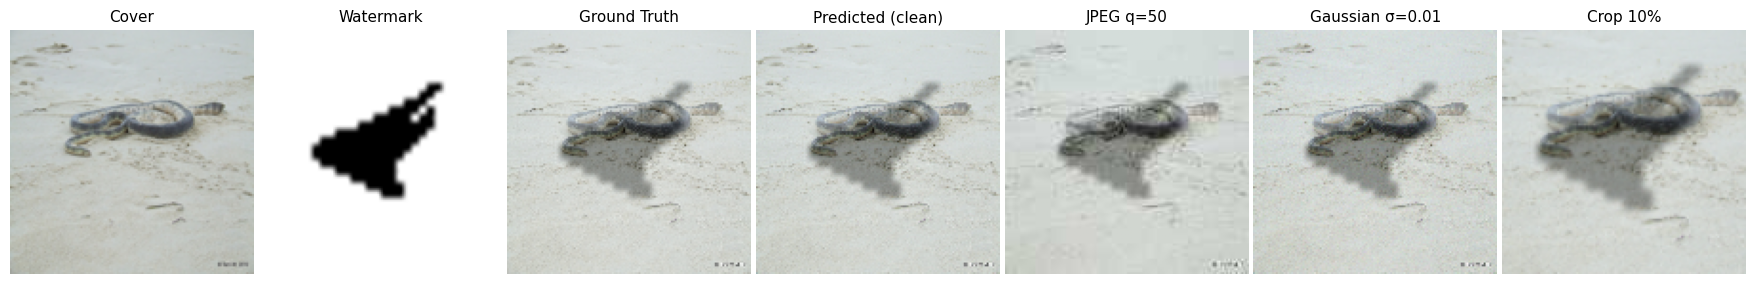

[SAVED] xception_robustness_row.png


In [20]:
import numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# config
ALPHA  = 0.3
THRESH = 0.5

# attacks (expects float images in [0,1], HxWxC)
def _jpeg(img01, quality=50):
    buf = BytesIO()
    Image.fromarray((img01 * 255.0).astype(np.uint8)).save(buf, format="JPEG", quality=int(quality))
    buf.seek(0)
    out = np.asarray(Image.open(buf).convert("RGB"), dtype=np.float32) / 255.0
    return out

def _gaussian(img01, sigma=0.01):
    n = np.random.normal(0.0, float(sigma), img01.shape).astype(np.float32)
    return np.clip(img01 + n, 0.0, 1.0)

def _crop_and_resize(img01, crop_ratio=0.10):
    h, w = img01.shape[:2]
    dy = int(round(h * crop_ratio)); dx = int(round(w * crop_ratio))
    if dy == 0 and dx == 0 or (h - 2*dy) <= 0 or (w - 2*dx) <= 0:
        return img01.copy()
    crop = img01[dy:h-dy, dx:w-dx, :]
    out = np.asarray(Image.fromarray((crop * 255).astype(np.uint8)).resize((w, h), Image.BILINEAR), dtype=np.float32) / 255.0
    return out

def _psnr_from_images(a, b, eps=1e-12):
    mse = float(np.mean((a - b) ** 2))
    psnr = 10.0 * np.log10((1.0**2) / (mse + eps))
    return mse, psnr

def _ssim_img(a, b):
    try:    return ssim(a, b, data_range=1.0, channel_axis=2)
    except TypeError: return ssim(a, b, data_range=1.0, multichannel=True)

# extraction helpers
def _to_gray01(img):
    if img.ndim == 3 and img.shape[2] == 3:
        return (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.float32)
    return img.astype(np.float32)

def _binarize01(gray, thr=0.5): return (gray >= float(thr)).astype(np.uint8)
def _ber(a_bin, b_bin):        return float(np.mean(a_bin != b_bin))

def _nc_classic(a_bin, b_bin, eps=1e-12):
    # Convert {0,1} -> {-1,+1}, then cosine similarity
    a = (a_bin.astype(np.float32) * 2.0) - 1.0
    b = (b_bin.astype(np.float32) * 2.0) - 1.0
    return float((a*b).sum() / (np.sqrt((a*a).sum())*np.sqrt((b*b).sum()) + eps))

def _extract_watermark(Y_obs, C_cover, alpha=ALPHA):
    W_hat = (Y_obs - C_cover) / float(alpha)
    return np.clip(W_hat, 0.0, 1.0)

def _get_cover_mark(i, H, W):
    if i >= len(test_cover_paths) or i >= len(test_mark_paths): return None, None
    try:
        cov = Image.open(test_cover_paths[i]).convert("RGB").resize((W, H))
        mrk = Image.open(test_mark_paths[i]).convert("RGB").resize((W, H))
        return (np.asarray(cov, dtype=np.float32)/255.0,
                np.asarray(mrk, dtype=np.float32)/255.0)
    except Exception:
        return None, None

# PREP: use Yp, Yt from training cell
N, H, W, C = Yp.shape  # raise if missing

# evaluate a transform over the whole test set:
# mean per-image MSE/PSNR/SSIM and (if cover/mark available) BER/NC from extraction
def _eval_attack(transform):
    mses, psnrs, ssims = [], [], []
    bers, ncs = [], []
    have_pairs = True
    for i in range(N):
        Yt_i = Yt[i]
        Yp_i = Yp[i]
        Ya   = transform(Yp_i)

        mse_i, psnr_i = _psnr_from_images(Yt_i, Ya)
        mses.append(mse_i); psnrs.append(psnr_i); ssims.append(_ssim_img(Yt_i, Ya))

        C_img, W_true = _get_cover_mark(i, H, W)
        if C_img is None or W_true is None:
            have_pairs = False
            continue
        W_hat  = _extract_watermark(Ya, C_img, alpha=ALPHA)
        Wt_bin = _binarize01(_to_gray01(W_true), thr=THRESH)
        Wh_bin = _binarize01(_to_gray01(W_hat),  thr=THRESH)
        bers.append(_ber(Wt_bin, Wh_bin))
        ncs.append(_nc_classic(Wt_bin, Wh_bin))
    return {
        "mse": float(np.mean(mses)),
        "psnr": float(np.mean(psnrs)),
        "ssim": float(np.mean(ssims)),
        "have_pairs": have_pairs and len(bers) == N,
        "ber": float(np.mean(bers)) if len(bers) else None,
        "nc":  float(np.mean(ncs))  if len(ncs)  else None,
        "ber_n": len(bers)
    }

#Run function call
res_clean = _eval_attack(lambda img: img)
res_jpeg  = _eval_attack(lambda img: _jpeg(img, quality=50))
res_gaus  = _eval_attack(lambda img: _gaussian(img, sigma=0.01))
res_crop  = _eval_attack(lambda img: _crop_and_resize(img, crop_ratio=0.10))

print("\n[ROBUSTNESS — dataset mean metrics]")
def _line(name, r):
    base = f"{name:<12} -> MSE: {r['mse']:.6f} | PSNR: {r['psnr']:.2f} dB | SSIM: {r['ssim']:.4f}"
    if r['ber'] is not None and r['nc'] is not None:
        base += f" | BER: {r['ber']:.4f} (n={r['ber_n']}) | NC(±1): {r['nc']:.4f}"
    else:
        base += " | BER/NC: n/a (need cover+watermark)"
    print(base)

_line("Clean",          res_clean)
_line("JPEG(q=50)",     res_jpeg)
_line("Gaussian(0.01)", res_gaus)
_line("Crop(10%)",      res_crop)

# Visualization
viz_idx = 0
Yt_v, Yp_v = Yt[viz_idx], Yp[viz_idx]
Yp_jpeg = _jpeg(Yp_v, quality=50)
Yp_gaus = _gaussian(Yp_v, sigma=0.01)
Yp_crop = _crop_and_resize(Yp_v, crop_ratio=0.10)
cover_img, mark_img = _get_cover_mark(viz_idx, H, W)

panels = [
    (cover_img if cover_img is not None else np.zeros_like(Yt_v), "Cover"),
    (mark_img  if mark_img  is not None else np.zeros_like(Yt_v), "Watermark"),
    (Yt_v,     "Ground Truth"),
    (Yp_v,     "Predicted (clean)"),
    (Yp_jpeg,  "JPEG q=50"),
    (Yp_gaus,  "Gaussian σ=0.01"),
    (Yp_crop,  "Crop 10%"),
]
w_per_img, h_in = 3.2, 3.2
fig, axes = plt.subplots(1, len(panels), figsize=(w_per_img*len(panels), h_in))
for ax, (img, title) in zip(axes, panels):
    ax.imshow(np.clip(img, 0, 1)); ax.set_title(title, fontsize=11); ax.axis("off")
plt.subplots_adjust(wspace=0.02, hspace=0)
out_path = "xception_robustness_row.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()
print(f"[SAVED] {out_path}")

### cGAN PIPELINE

In [6]:
#Define dataset
import os
from glob import glob

def _first_nonempty(*patterns):
    for p in patterns:
        if len(glob(p)): 
            return os.path.dirname(p.rstrip("*/"))
    return None

if "TRAIN_COVER_DIR" not in globals() or "TRAIN_MARK_DIR" not in globals() \
   or "TEST_COVER_DIR"  not in globals() or "TEST_MARK_DIR"  not in globals():

    # try your two known layouts
    candidates = [
        "/kaggle/input/image-watermarking/dataset"
    ]

    TRAIN_COVER_DIR = TRAIN_MARK_DIR = TEST_COVER_DIR = TEST_MARK_DIR = None
    for base in candidates:
        tc = f"{base}/train/cover/*"
        tm = f"{base}/train/mark/*"
        vc = f"{base}/test/cover/*"
        vm = f"{base}/test/mark/*"
        if len(glob(tc)) and len(glob(tm)) and len(glob(vc)) and len(glob(vm)):
            TRAIN_COVER_DIR = os.path.dirname(tc)
            TRAIN_MARK_DIR  = os.path.dirname(tm)
            TEST_COVER_DIR  = os.path.dirname(vc)
            TEST_MARK_DIR   = os.path.dirname(vm)
            break

    if any(v is None for v in [TRAIN_COVER_DIR, TRAIN_MARK_DIR, TEST_COVER_DIR, TEST_MARK_DIR]):
        raise FileNotFoundError(
            "Could not locate dataset folders. Set TRAIN_COVER_DIR / TRAIN_MARK_DIR / "
            "TEST_COVER_DIR / TEST_MARK_DIR to your dataset paths."
        )

print("[PATHS]")
print("TRAIN_COVER_DIR:", TRAIN_COVER_DIR)
print("TRAIN_MARK_DIR :", TRAIN_MARK_DIR)
print("TEST_COVER_DIR :", TEST_COVER_DIR)
print("TEST_MARK_DIR  :", TEST_MARK_DIR)

# --- build capped datasets using your existing make_ds(...) ---
TRAIN_MAX = 5000
TEST_MAX  = 1000

train_ds = make_ds(f"{TRAIN_COVER_DIR}/*", f"{TRAIN_MARK_DIR}/*",
                   batch=16, shuffle=True,  max_items=TRAIN_MAX)

val_ds   = make_ds(f"{TEST_COVER_DIR}/*",  f"{TEST_MARK_DIR}/*",
                   batch=16, shuffle=False, max_items=TEST_MAX)

# quick check
xb, yb = next(iter(train_ds))
print("shapes:", xb.shape, yb.shape)


[PATHS]
TRAIN_COVER_DIR: /kaggle/input/image-watermarking/dataset/train/cover
TRAIN_MARK_DIR : /kaggle/input/image-watermarking/dataset/train/mark
TEST_COVER_DIR : /kaggle/input/image-watermarking/dataset/test/cover
TEST_MARK_DIR  : /kaggle/input/image-watermarking/dataset/test/mark
[DATA] Using 5000 pairs from:
  /kaggle/input/image-watermarking/dataset/train/cover/*
  /kaggle/input/image-watermarking/dataset/train/mark/*
[DATA] Using 1000 pairs from:
  /kaggle/input/image-watermarking/dataset/test/cover/*
  /kaggle/input/image-watermarking/dataset/test/mark/*
shapes: (16, 128, 128, 4) (16, 128, 128, 3)


In [7]:
#cGAN model
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = globals().get("IMG_SIZE", 128)

# Generator (U-Net-ish)
def build_generator(input_shape=(IMG_SIZE, IMG_SIZE, 4)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64,  4, strides=2, padding="same")(inputs);  c1 = layers.LeakyReLU(0.2)(c1)
    c2 = layers.Conv2D(128, 4, strides=2, padding="same")(c1);      c2 = layers.BatchNormalization()(c2); c2 = layers.LeakyReLU(0.2)(c2)
    c3 = layers.Conv2D(256, 4, strides=2, padding="same")(c2);      c3 = layers.BatchNormalization()(c3); c3 = layers.LeakyReLU(0.2)(c3)
    c4 = layers.Conv2D(512, 4, strides=2, padding="same")(c3);      c4 = layers.BatchNormalization()(c4); c4 = layers.LeakyReLU(0.2)(c4)

    # Bottleneck
    b  = layers.Conv2D(512, 3, padding="same", activation="relu")(c4)

    # Decoder + skips
    u1 = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(b);  u1 = layers.Concatenate()([u1, c3])
    u2 = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(u1); u2 = layers.Concatenate()([u2, c2])
    u3 = layers.Conv2DTranspose(64,  4, strides=2, padding="same", activation="relu")(u2); u3 = layers.Concatenate()([u3, c1])
    u4 = layers.Conv2DTranspose(64,  4, strides=2, padding="same", activation="relu")(u3)

    out = layers.Conv2D(3, 1, padding="same", activation="sigmoid")(u4)
    return models.Model(inputs, out, name="cgan_generator")

# Patch Discriminator
def build_discriminator(cover_channels=4, out_channels=3):
    inp_cond = layers.Input(shape=(IMG_SIZE, IMG_SIZE, cover_channels))
    inp_img  = layers.Input(shape=(IMG_SIZE, IMG_SIZE, out_channels))
    x = layers.Concatenate(axis=-1)([inp_cond, inp_img])  # 7 channels total

    x = layers.Conv2D(64,  4, strides=2, padding="same")(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding="same")(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding="same")(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512, 4, strides=1, padding="same")(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)

    out = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(x)
    return models.Model([inp_cond, inp_img], out, name="cgan_discriminator")

# cGAN wrapper
# only the class changes below; G/D architectures stay the same
class WatermarkCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, lambda_l1=100.0, lambda_tv=1e-4):
        super().__init__()
        self.gen = generator
        self.disc = discriminator
        self.lambda_l1 = lambda_l1
        self.lambda_tv = lambda_tv   # <-- new: TV weight
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.l1_loss_tracker  = tf.keras.metrics.Mean(name="l1")
        self.adv_loss_tracker = tf.keras.metrics.Mean(name="adv")
        self.disc_loss_tracker= tf.keras.metrics.Mean(name="disc_loss")
        self.tv_loss_tracker  = tf.keras.metrics.Mean(name="tv")  # <-- track TV

    def compile(self, g_opt, d_opt):
        super().compile(run_eagerly=False)
        self.g_opt = g_opt
        self.d_opt = d_opt

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.l1_loss_tracker,
                self.adv_loss_tracker, self.disc_loss_tracker,
                self.tv_loss_tracker]

    def call(self, inputs, training=False):
        return self.gen(inputs, training=training)

    def train_step(self, data):
        cond, real = data

        # Train D (unchanged)
        with tf.GradientTape() as d_tape:
            fake = self.gen(cond, training=True)
            pr = self.disc([cond, real], training=True)
            pf = self.disc([cond, fake], training=True)
            d_loss_real = self.bce(tf.ones_like(pr), pr)
            d_loss_fake = self.bce(tf.zeros_like(pf), pf)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_grads = d_tape.gradient(d_loss, self.disc.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grads, self.disc.trainable_variables))

        # Train G (+TV)
        with tf.GradientTape() as g_tape:
            fake = self.gen(cond, training=True)
            pf = self.disc([cond, fake], training=False)
            adv_loss = self.bce(tf.ones_like(pf), pf)
            l1 = tf.reduce_mean(tf.abs(real - fake))
            tv = tf.reduce_mean(tf.image.total_variation(fake))   # <-- TV on [0,1] output
            g_loss = adv_loss + self.lambda_l1 * l1 + self.lambda_tv * tv
        g_grads = g_tape.gradient(g_loss, self.gen.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.gen.trainable_variables))

        self.gen_loss_tracker.update_state(g_loss)
        self.l1_loss_tracker.update_state(l1)
        self.adv_loss_tracker.update_state(adv_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.tv_loss_tracker.update_state(tv)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        cond, real = data
        fake = self.gen(cond, training=False)
        pf = self.disc([cond, fake], training=False)
        adv_loss = self.bce(tf.ones_like(pf), pf)
        l1 = tf.reduce_mean(tf.abs(real - fake))
        tv = tf.reduce_mean(tf.image.total_variation(fake))       # <-- TV in val metric
        g_loss = adv_loss + self.lambda_l1 * l1 + self.lambda_tv * tv

        pr = self.disc([cond, real], training=False)
        d_loss_real = self.bce(tf.ones_like(pr), pr)
        d_loss_fake = self.bce(tf.zeros_like(pf), pf)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        self.gen_loss_tracker.update_state(g_loss)
        self.l1_loss_tracker.update_state(l1)
        self.adv_loss_tracker.update_state(adv_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.tv_loss_tracker.update_state(tv)
        return {m.name: m.result() for m in self.metrics}



In [9]:
# cGAN — Train/Infer timings + CO₂ + Eval (global) + Model size (MB)
# (Uses build_generator, build_discriminator, WatermarkCGAN)
# Assumes: train_ds, val_ds exist and yield (input_pair[H,W,4], target_rgb[H,W,3]) in [0,1]
import os, time, numpy as np, tensorflow as tf
from contextlib import suppress
from skimage.metrics import structural_similarity as ssim

# CodeCarbon
def _cc_start(name):
    try:
        from codecarbon import EmissionsTracker
    except Exception as e:
        print(f"[CodeCarbon import failed] {e}")
        return None
    try:
        tr = EmissionsTracker(
            project_name=name,
            output_dir="/kaggle/working",
            measure_power_secs=1,
            tracking_mode="process",
            gpu_ids=[],            # <-- important: empty list, not "all"
            save_to_file=True,
        )
        tr.start()
        return tr
    except Exception as e:
        print(f"[CodeCarbon disabled for '{name}'] {type(e).__name__}: {e}")
        return None

def _cc_stop(tr):
    if tr is None: return None
    try:
        return tr.stop()
    except Exception as e:
        print(f"[CodeCarbon stop error] {e}")
        return None


# helpers
def _count_images(ds):
    # Try cardinality; fallback to iteration
    try:
        card = int(ds.cardinality().numpy())
        if card > 0:
            bs = int(next(iter(ds.take(1)))[0].shape[0])
            return card * bs
    except Exception:
        pass
    total = 0
    for xb, _ in ds:
        total += int(xb.shape[0])
    return total

def _psnr_from_mse(mse, max_i=1.0, eps=1e-12):
    return 10.0 * np.log10((max_i**2) / (mse + eps))

def _dataset_ssim_one_number(Yt, Yp):
    big_t = np.concatenate(list(Yt), axis=0)  # (N*H, W, 3)
    big_p = np.concatenate(list(Yp), axis=0)
    try:
        return float(ssim(big_t, big_p, data_range=1.0, channel_axis=2))
    except TypeError:
        return float(ssim(big_t, big_p, data_range=1.0, multichannel=True))

# Build/compile
# Reuse definitions:
#  - build_generator(input_shape=(128,128,4))
#  - build_discriminator()
#  - class WatermarkCGAN(tf.keras.Model)

lambda_l1 = 100.0
lambda_tv = 1e-4   # try 1e-5 … 5e-4 if needed
lr_g = 2e-4; lr_d = 2e-4
EPOCHS = 10

gen  = build_generator()
disc = build_discriminator()
cgan = WatermarkCGAN(gen, disc, lambda_l1=lambda_l1, lambda_tv=lambda_tv)

g_opt = tf.keras.optimizers.Adam(lr_g, beta_1=0.5, beta_2=0.999)
d_opt = tf.keras.optimizers.Adam(lr_d, beta_1=0.5, beta_2=0.999)
cgan.compile(g_opt=g_opt, d_opt=d_opt)

# Dataset sizes (for ms/img)
N_train = _count_images(train_ds)
N_val   = _count_images(val_ds)

# TRAIN (timing + CO₂)
train_tracker = _cc_start("cGAN_Watermark_Train")
t0 = time.perf_counter()
history = cgan.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)
train_time_s = time.perf_counter() - t0
train_emissions_kg = _cc_stop(train_tracker)

train_ms_per_img = (train_time_s / max(1, N_train)) * 1000.0
print(f"[TRAIN] cGAN total: {train_time_s:.2f}s for {N_train} imgs "
      f"({train_ms_per_img:.2f} ms/img) | CO2: {train_emissions_kg if train_emissions_kg is not None else 'n/a'}")

# INFERENCE (timing + CO₂) + EVAL
for xb, _ in val_ds.take(1):
    _ = cgan.gen(xb, training=False)

infer_tracker = _cc_start("cGAN_Watermark_Inference")
t1 = time.perf_counter()

Yp_list, Yt_list = [], []
for xb, yb in val_ds:
    yhat = cgan.gen.predict(xb, verbose=0)
    Yp_list.append(yhat)
    Yt_list.append(yb.numpy())

infer_time_s = time.perf_counter() - t1
infer_emissions_kg = _cc_stop(infer_tracker)

Yp = np.clip(np.concatenate(Yp_list, axis=0), 0.0, 1.0).astype(np.float32)   # (N,H,W,3)
Yt = np.clip(np.concatenate(Yt_list, axis=0), 0.0, 1.0).astype(np.float32)   # (N,H,W,3)
N_out = Yp.shape[0]

infer_ms_per_img = (infer_time_s / max(1, N_out)) * 1000.0
print(f"[INFER] cGAN total: {infer_time_s:.3f}s for {N_out} imgs "
      f"({infer_ms_per_img:.2f} ms/img) | CO2: {infer_emissions_kg if infer_emissions_kg is not None else 'n/a'}")

# GLOBAL metrics across all pixels
eps = 1e-12
mse_global  = float(np.mean((Yt - Yp) ** 2))
psnr_global = float(_psnr_from_mse(mse_global, max_i=1.0, eps=eps))
ssim_one    = _dataset_ssim_one_number(Yt, Yp)

print(f"[EVAL] cGAN MSE: {mse_global:.6f} | PSNR: {psnr_global:.2f} dB | SSIM: {ssim_one:.4f}")

# SAVE ARTIFACTS and size
gen_path  = "cgan_generator.h5"
disc_path = "cgan_discriminator.h5"
cgan.gen.save(gen_path)
cgan.disc.save(disc_path)

size_mb = 0.0
for p in (gen_path, disc_path):
    if os.path.exists(p):
        size_mb += os.path.getsize(p) / (1024**2)

print(f"[SAVE] Artifacts: {gen_path}, {disc_path}")
print(f"[SIZE] cGAN (gen+disc on disk): {size_mb:.2f} MB")

[codecarbon WARNING @ 17:26:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:26:05] [setup] RAM Tracking...
[codecarbon INFO @ 17:26:05] [setup] CPU Tracking...
[codecarbon WARNING @ 17:26:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:26:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:26:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 17:26:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:26:06] [setup] GPU Tracking...
[codecarbon INFO @ 17:26:06] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:26:06] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:06] GPU number 1 will not be 

Epoch 1/10


[codecarbon INFO @ 17:26:10] Energy consumed for RAM : 0.000003 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:10] Energy consumed for All CPU : 0.000012 kWh
[codecarbon INFO @ 17:26:10] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:10] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:10] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:10] 0.000015 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:11] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:11] Energy consumed for All CPU : 0.000024 kWh
[codecarbon INFO @ 17:26:11] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:11] GPU number 1 will 

  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:28:27 17s/step - adv: 0.8645 - disc_loss: 0.8210 - gen_loss: 23.1458 - l1: 0.2205 - tv: 2317.4678

[codecarbon INFO @ 17:26:26] Energy consumed for RAM : 0.000044 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:26] Energy consumed for All CPU : 0.000196 kWh
[codecarbon INFO @ 17:26:26] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:26] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:26] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:26] 0.000240 kWh of electricity used since the beginning.


  8/313 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - adv: 0.7476 - disc_loss: 1.0918 - gen_loss: 21.5616 - l1: 0.2061 - tv: 2068.0635

[codecarbon INFO @ 17:26:27] Energy consumed for RAM : 0.000046 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:27] Energy consumed for All CPU : 0.000208 kWh
[codecarbon INFO @ 17:26:27] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:27] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:27] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:27] 0.000254 kWh of electricity used since the beginning.


 16/313 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - adv: 0.7225 - disc_loss: 1.0036 - gen_loss: 19.5545 - l1: 0.1861 - tv: 2248.8381

[codecarbon INFO @ 17:26:28] Energy consumed for RAM : 0.000049 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:28] Energy consumed for All CPU : 0.000219 kWh
[codecarbon INFO @ 17:26:28] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:28] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:28] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:28] 0.000269 kWh of electricity used since the beginning.


 24/313 ━━━━━━━━━━━━━━━━━━━━ 37s 129ms/step - adv: 0.7123 - disc_loss: 0.9546 - gen_loss: 17.9412 - l1: 0.1700 - tv: 2283.3103

[codecarbon INFO @ 17:26:29] Energy consumed for RAM : 0.000052 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:29] Energy consumed for All CPU : 0.000231 kWh
[codecarbon INFO @ 17:26:29] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:29] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:29] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:29] 0.000283 kWh of electricity used since the beginning.


 32/313 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - adv: 0.7070 - disc_loss: 0.9196 - gen_loss: 16.7010 - l1: 0.1577 - tv: 2286.6050

[codecarbon INFO @ 17:26:30] Energy consumed for RAM : 0.000055 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:30] Energy consumed for All CPU : 0.000243 kWh
[codecarbon INFO @ 17:26:30] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:30] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:30] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:30] 0.000297 kWh of electricity used since the beginning.


 39/313 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - adv: 0.7040 - disc_loss: 0.8966 - gen_loss: 15.8662 - l1: 0.1493 - tv: 2284.7969

[codecarbon INFO @ 17:26:31] Energy consumed for RAM : 0.000057 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:31] Energy consumed for All CPU : 0.000254 kWh
[codecarbon INFO @ 17:26:31] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:31] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:31] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:31] 0.000312 kWh of electricity used since the beginning.


 47/313 ━━━━━━━━━━━━━━━━━━━━ 34s 129ms/step - adv: 0.7018 - disc_loss: 0.8762 - gen_loss: 15.1068 - l1: 0.1418 - tv: 2279.9934

[codecarbon INFO @ 17:26:32] Energy consumed for RAM : 0.000060 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:32] Energy consumed for All CPU : 0.000266 kWh
[codecarbon INFO @ 17:26:32] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:32] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:32] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:32] 0.000326 kWh of electricity used since the beginning.


 55/313 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - adv: 0.6999 - disc_loss: 0.8602 - gen_loss: 14.4826 - l1: 0.1356 - tv: 2274.1721

[codecarbon INFO @ 17:26:33] Energy consumed for RAM : 0.000063 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:33] Energy consumed for All CPU : 0.000278 kWh
[codecarbon INFO @ 17:26:33] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:33] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:33] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:33] 0.000341 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:33] 0.006524 g.CO2eq/s mean an estimation of 205.73476547842495 kg.CO2eq/year


 63/313 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - adv: 0.6983 - disc_loss: 0.8472 - gen_loss: 13.9621 - l1: 0.1304 - tv: 2268.6167

[codecarbon INFO @ 17:26:34] Energy consumed for RAM : 0.000066 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:34] Energy consumed for All CPU : 0.000289 kWh
[codecarbon INFO @ 17:26:34] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:34] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:34] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:34] 0.000355 kWh of electricity used since the beginning.


 70/313 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - adv: 0.6973 - disc_loss: 0.8376 - gen_loss: 13.5774 - l1: 0.1265 - tv: 2263.6528

[codecarbon INFO @ 17:26:35] Energy consumed for RAM : 0.000068 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:35] Energy consumed for All CPU : 0.000301 kWh
[codecarbon INFO @ 17:26:35] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:35] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:35] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:35] 0.000369 kWh of electricity used since the beginning.


 78/313 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - adv: 0.6964 - disc_loss: 0.8282 - gen_loss: 13.1951 - l1: 0.1227 - tv: 2258.3594

[codecarbon INFO @ 17:26:36] Energy consumed for RAM : 0.000071 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:36] Energy consumed for All CPU : 0.000313 kWh
[codecarbon INFO @ 17:26:36] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:36] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:36] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:36] 0.000384 kWh of electricity used since the beginning.


 86/313 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - adv: 0.6957 - disc_loss: 0.8202 - gen_loss: 12.8650 - l1: 0.1194 - tv: 2253.6848

[codecarbon INFO @ 17:26:37] Energy consumed for RAM : 0.000074 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:37] Energy consumed for All CPU : 0.000324 kWh
[codecarbon INFO @ 17:26:37] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:37] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:37] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:37] 0.000398 kWh of electricity used since the beginning.


 94/313 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - adv: 0.6953 - disc_loss: 0.8131 - gen_loss: 12.5704 - l1: 0.1165 - tv: 2249.7830

[codecarbon INFO @ 17:26:38] Energy consumed for RAM : 0.000077 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:38] Energy consumed for All CPU : 0.000336 kWh
[codecarbon INFO @ 17:26:38] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:38] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:38] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:38] 0.000413 kWh of electricity used since the beginning.


101/313 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - adv: 0.6951 - disc_loss: 0.8076 - gen_loss: 12.3362 - l1: 0.1142 - tv: 2247.1343

[codecarbon INFO @ 17:26:39] Energy consumed for RAM : 0.000079 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:39] Energy consumed for All CPU : 0.000348 kWh
[codecarbon INFO @ 17:26:39] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:39] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:39] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:39] 0.000427 kWh of electricity used since the beginning.


109/313 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - adv: 0.6952 - disc_loss: 0.8021 - gen_loss: 12.0906 - l1: 0.1117 - tv: 2244.7341

[codecarbon INFO @ 17:26:40] Energy consumed for RAM : 0.000082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:40] Energy consumed for All CPU : 0.000360 kWh
[codecarbon INFO @ 17:26:40] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:40] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:40] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:40] 0.000442 kWh of electricity used since the beginning.


117/313 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - adv: 0.6954 - disc_loss: 0.7974 - gen_loss: 11.8658 - l1: 0.1095 - tv: 2242.8792

[codecarbon INFO @ 17:26:41] Energy consumed for RAM : 0.000085 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:41] Energy consumed for All CPU : 0.000371 kWh
[codecarbon INFO @ 17:26:41] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:41] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:41] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:41] 0.000456 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:41] 0.006531 g.CO2eq/s mean an estimation of 205.9646271925813 kg.CO2eq/year


124/313 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - adv: 0.6955 - disc_loss: 0.7937 - gen_loss: 11.6848 - l1: 0.1077 - tv: 2241.3630

[codecarbon INFO @ 17:26:42] Energy consumed for RAM : 0.000088 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:42] Energy consumed for All CPU : 0.000383 kWh
[codecarbon INFO @ 17:26:42] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:42] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:42] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:42] 0.000470 kWh of electricity used since the beginning.


132/313 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - adv: 0.6957 - disc_loss: 0.7897 - gen_loss: 11.4942 - l1: 0.1057 - tv: 2239.7537

[codecarbon INFO @ 17:26:43] Energy consumed for RAM : 0.000090 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:43] Energy consumed for All CPU : 0.000395 kWh
[codecarbon INFO @ 17:26:43] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:43] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:43] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:43] 0.000485 kWh of electricity used since the beginning.


139/313 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - adv: 0.6960 - disc_loss: 0.7865 - gen_loss: 11.3386 - l1: 0.1042 - tv: 2238.4370

[codecarbon INFO @ 17:26:44] Energy consumed for RAM : 0.000093 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:44] Energy consumed for All CPU : 0.000406 kWh
[codecarbon INFO @ 17:26:44] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:44] GPU number 1 will not be monitored, at your request.


140/313 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - adv: 0.6960 - disc_loss: 0.7861 - gen_loss: 11.3172 - l1: 0.1040 - tv: 2238.2654

[codecarbon INFO @ 17:26:44] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:44] 0.000499 kWh of electricity used since the beginning.


147/313 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - adv: 0.6963 - disc_loss: 0.7831 - gen_loss: 11.1732 - l1: 0.1025 - tv: 2237.1794

[codecarbon INFO @ 17:26:45] Energy consumed for RAM : 0.000096 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:45] Energy consumed for All CPU : 0.000418 kWh
[codecarbon INFO @ 17:26:45] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:45] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:45] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:45] 0.000514 kWh of electricity used since the beginning.


155/313 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - adv: 0.6968 - disc_loss: 0.7800 - gen_loss: 11.0199 - l1: 0.1010 - tv: 2236.3352

[codecarbon INFO @ 17:26:46] Energy consumed for RAM : 0.000099 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:46] Energy consumed for All CPU : 0.000430 kWh
[codecarbon INFO @ 17:26:46] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:46] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:46] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:46] 0.000528 kWh of electricity used since the beginning.


162/313 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - adv: 0.6971 - disc_loss: 0.7775 - gen_loss: 10.8941 - l1: 0.0997 - tv: 2235.8398

[codecarbon INFO @ 17:26:47] Energy consumed for RAM : 0.000101 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:47] Energy consumed for All CPU : 0.000441 kWh
[codecarbon INFO @ 17:26:47] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:47] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:47] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:47] 0.000543 kWh of electricity used since the beginning.


170/313 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - adv: 0.6974 - disc_loss: 0.7747 - gen_loss: 10.7597 - l1: 0.0984 - tv: 2235.4009

[codecarbon INFO @ 17:26:48] Energy consumed for RAM : 0.000104 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:48] Energy consumed for All CPU : 0.000453 kWh
[codecarbon INFO @ 17:26:48] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:48] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:48] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:48] 0.000557 kWh of electricity used since the beginning.


177/313 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - adv: 0.6977 - disc_loss: 0.7725 - gen_loss: 10.6488 - l1: 0.0973 - tv: 2235.0991

[codecarbon INFO @ 17:26:49] Energy consumed for RAM : 0.000107 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:49] Energy consumed for All CPU : 0.000465 kWh
[codecarbon INFO @ 17:26:49] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:49] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:49] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:49] 0.000572 kWh of electricity used since the beginning.


178/313 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - adv: 0.6977 - disc_loss: 0.7722 - gen_loss: 10.6333 - l1: 0.0971 - tv: 2235.0649

[codecarbon INFO @ 17:26:49] 0.006534 g.CO2eq/s mean an estimation of 206.0712076457328 kg.CO2eq/year


185/313 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - adv: 0.6980 - disc_loss: 0.7701 - gen_loss: 10.5285 - l1: 0.0961 - tv: 2234.8799

[codecarbon INFO @ 17:26:50] Energy consumed for RAM : 0.000110 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:50] Energy consumed for All CPU : 0.000476 kWh
[codecarbon INFO @ 17:26:50] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:50] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:50] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:50] 0.000586 kWh of electricity used since the beginning.


193/313 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - adv: 0.6982 - disc_loss: 0.7679 - gen_loss: 10.4149 - l1: 0.0949 - tv: 2234.8713

[codecarbon INFO @ 17:26:51] Energy consumed for RAM : 0.000112 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:51] Energy consumed for All CPU : 0.000488 kWh
[codecarbon INFO @ 17:26:51] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:51] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:51] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:51] 0.000601 kWh of electricity used since the beginning.


200/313 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - adv: 0.6984 - disc_loss: 0.7660 - gen_loss: 10.3204 - l1: 0.0940 - tv: 2235.0063

[codecarbon INFO @ 17:26:52] Energy consumed for RAM : 0.000115 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:52] Energy consumed for All CPU : 0.000500 kWh
[codecarbon INFO @ 17:26:52] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:52] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:52] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:52] 0.000615 kWh of electricity used since the beginning.


208/313 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - adv: 0.6985 - disc_loss: 0.7640 - gen_loss: 10.2188 - l1: 0.0930 - tv: 2235.2158

[codecarbon INFO @ 17:26:53] Energy consumed for RAM : 0.000118 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:53] Energy consumed for All CPU : 0.000512 kWh
[codecarbon INFO @ 17:26:53] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:53] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:53] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:53] 0.000629 kWh of electricity used since the beginning.


215/313 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - adv: 0.6985 - disc_loss: 0.7623 - gen_loss: 10.1342 - l1: 0.0921 - tv: 2235.4773

[codecarbon INFO @ 17:26:54] Energy consumed for RAM : 0.000121 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:54] Energy consumed for All CPU : 0.000523 kWh
[codecarbon INFO @ 17:26:54] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:54] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:54] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:54] 0.000644 kWh of electricity used since the beginning.


223/313 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - adv: 0.6983 - disc_loss: 0.7606 - gen_loss: 10.0416 - l1: 0.0912 - tv: 2235.8789

[codecarbon INFO @ 17:26:55] Energy consumed for RAM : 0.000123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:55] Energy consumed for All CPU : 0.000535 kWh
[codecarbon INFO @ 17:26:55] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:55] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:55] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:55] 0.000658 kWh of electricity used since the beginning.


230/313 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - adv: 0.6981 - disc_loss: 0.7591 - gen_loss: 9.9641 - l1: 0.0904 - tv: 2236.2598

[codecarbon INFO @ 17:26:56] Energy consumed for RAM : 0.000126 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:56] Energy consumed for All CPU : 0.000547 kWh
[codecarbon INFO @ 17:26:56] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:56] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:56] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:56] 0.000673 kWh of electricity used since the beginning.


238/313 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - adv: 0.6976 - disc_loss: 0.7575 - gen_loss: 9.8798 - l1: 0.0896 - tv: 2236.7476

[codecarbon INFO @ 17:26:57] Energy consumed for RAM : 0.000129 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:57] Energy consumed for All CPU : 0.000558 kWh
[codecarbon INFO @ 17:26:57] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:57] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:57] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:57] 0.000687 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:57] 0.006527 g.CO2eq/s mean an estimation of 205.84426814636473 kg.CO2eq/year


245/313 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - adv: 0.6972 - disc_loss: 0.7561 - gen_loss: 9.8093 - l1: 0.0889 - tv: 2237.2349

[codecarbon INFO @ 17:26:58] Energy consumed for RAM : 0.000132 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:58] Energy consumed for All CPU : 0.000570 kWh
[codecarbon INFO @ 17:26:58] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:58] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:58] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:58] 0.000701 kWh of electricity used since the beginning.


253/313 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - adv: 0.6966 - disc_loss: 0.7546 - gen_loss: 9.7313 - l1: 0.0881 - tv: 2237.8474

[codecarbon INFO @ 17:26:59] Energy consumed for RAM : 0.000134 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:26:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:26:59] Energy consumed for All CPU : 0.000582 kWh
[codecarbon INFO @ 17:26:59] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:26:59] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:26:59] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:26:59] 0.000716 kWh of electricity used since the beginning.


260/313 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - adv: 0.6961 - disc_loss: 0.7534 - gen_loss: 9.6657 - l1: 0.0875 - tv: 2238.4641

[codecarbon INFO @ 17:27:00] Energy consumed for RAM : 0.000137 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:00] Energy consumed for All CPU : 0.000593 kWh
[codecarbon INFO @ 17:27:00] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:00] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:00] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:00] 0.000730 kWh of electricity used since the beginning.


268/313 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - adv: 0.6955 - disc_loss: 0.7520 - gen_loss: 9.5936 - l1: 0.0867 - tv: 2239.3154

[codecarbon INFO @ 17:27:01] Energy consumed for RAM : 0.000140 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:01] Energy consumed for All CPU : 0.000605 kWh
[codecarbon INFO @ 17:27:01] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:01] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:01] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:01] 0.000745 kWh of electricity used since the beginning.


275/313 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - adv: 0.6948 - disc_loss: 0.7509 - gen_loss: 9.5326 - l1: 0.0861 - tv: 2240.1750

[codecarbon INFO @ 17:27:02] Energy consumed for RAM : 0.000142 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:02] Energy consumed for All CPU : 0.000617 kWh
[codecarbon INFO @ 17:27:02] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:02] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:02] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:02] 0.000759 kWh of electricity used since the beginning.


282/313 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - adv: 0.6941 - disc_loss: 0.7498 - gen_loss: 9.4736 - l1: 0.0856 - tv: 2241.1179

[codecarbon INFO @ 17:27:03] Energy consumed for RAM : 0.000145 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:03] Energy consumed for All CPU : 0.000628 kWh
[codecarbon INFO @ 17:27:03] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:03] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:03] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:03] 0.000773 kWh of electricity used since the beginning.


290/313 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - adv: 0.6932 - disc_loss: 0.7487 - gen_loss: 9.4085 - l1: 0.0849 - tv: 2242.2598

[codecarbon INFO @ 17:27:04] Energy consumed for RAM : 0.000148 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:04] Energy consumed for All CPU : 0.000640 kWh
[codecarbon INFO @ 17:27:04] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:04] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:04] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:04] 0.000788 kWh of electricity used since the beginning.


297/313 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - adv: 0.6923 - disc_loss: 0.7477 - gen_loss: 9.3535 - l1: 0.0844 - tv: 2243.3352

[codecarbon INFO @ 17:27:05] Energy consumed for RAM : 0.000151 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:05] Energy consumed for All CPU : 0.000652 kWh
[codecarbon INFO @ 17:27:05] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:05] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:05] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:05] 0.000802 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:05] 0.006529 g.CO2eq/s mean an estimation of 205.8965158583706 kg.CO2eq/year


305/313 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - adv: 0.6913 - disc_loss: 0.7466 - gen_loss: 9.2925 - l1: 0.0838 - tv: 2244.6211

[codecarbon INFO @ 17:27:06] Energy consumed for RAM : 0.000153 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:06] Energy consumed for All CPU : 0.000663 kWh
[codecarbon INFO @ 17:27:06] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:06] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:06] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:06] 0.000817 kWh of electricity used since the beginning.


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - adv: 0.6903 - disc_loss: 0.7456 - gen_loss: 9.2406 - l1: 0.0833 - tv: 2245.7795

[codecarbon INFO @ 17:27:07] Energy consumed for RAM : 0.000156 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:07] Energy consumed for All CPU : 0.000675 kWh
[codecarbon INFO @ 17:27:07] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:07] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:07] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:07] 0.000831 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:08] Energy consumed for RAM : 0.000159 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:08] Energy consumed for All CPU : 0.000687 kWh
[codecarbon INFO @ 17:27:08] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:08] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - adv: 0.6902 - disc_loss: 0.7455 - gen_loss: 9.2333 - l1: 0.0832 - tv: 2245.9490

[codecarbon INFO @ 17:27:14] Energy consumed for RAM : 0.000175 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:14] Energy consumed for All CPU : 0.000758 kWh
[codecarbon INFO @ 17:27:14] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:14] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:14] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:14] 0.000933 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:15] Energy consumed for RAM : 0.000178 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:15] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:15] Energy consumed for All CPU : 0.000768 kWh
[codecarbon INFO @ 17:27:15] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:15] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 169ms/step - adv: 0.6901 - disc_loss: 0.7454 - gen_loss: 9.2261 - l1: 0.0831 - tv: 2246.1172 - val_adv: 0.3608 - val_disc_loss: 1.1926 - val_gen_loss: 7.0729 - val_l1: 0.0651 - val_tv: 2042.3763
Epoch 2/10
  2/313 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - adv: 0.2659 - disc_loss: 0.6830 - gen_loss: 6.7698 - l1: 0.0627 - tv: 2346.0427

[codecarbon INFO @ 17:27:19] Energy consumed for RAM : 0.000189 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:19] Energy consumed for All CPU : 0.000815 kWh
[codecarbon INFO @ 17:27:19] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:19] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:19] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:19] 0.001004 kWh of electricity used since the beginning.


  9/313 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - adv: 0.4485 - disc_loss: 0.6618 - gen_loss: 5.6857 - l1: 0.0500 - tv: 2409.0398

[codecarbon INFO @ 17:27:20] Energy consumed for RAM : 0.000192 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:20] Energy consumed for All CPU : 0.000827 kWh
[codecarbon INFO @ 17:27:20] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:20] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:20] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:20] 0.001019 kWh of electricity used since the beginning.


 17/313 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - adv: 0.4782 - disc_loss: 0.6664 - gen_loss: 5.4070 - l1: 0.0469 - tv: 2420.4106

[codecarbon INFO @ 17:27:21] Energy consumed for RAM : 0.000194 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:21] Energy consumed for All CPU : 0.000839 kWh
[codecarbon INFO @ 17:27:21] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:21] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:21] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:21] 0.001033 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:21] 0.006499 g.CO2eq/s mean an estimation of 204.9627016772893 kg.CO2eq/year


 24/313 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - adv: 0.4822 - disc_loss: 0.6680 - gen_loss: 5.3695 - l1: 0.0464 - tv: 2430.4744

[codecarbon INFO @ 17:27:22] Energy consumed for RAM : 0.000197 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:22] Energy consumed for All CPU : 0.000850 kWh
[codecarbon INFO @ 17:27:22] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:22] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:22] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:22] 0.001047 kWh of electricity used since the beginning.


 31/313 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - adv: 0.4869 - disc_loss: 0.6664 - gen_loss: 5.3419 - l1: 0.0461 - tv: 2438.1777

[codecarbon INFO @ 17:27:23] Energy consumed for RAM : 0.000200 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:23] Energy consumed for All CPU : 0.000862 kWh
[codecarbon INFO @ 17:27:23] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:23] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:23] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:23] 0.001062 kWh of electricity used since the beginning.


 39/313 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - adv: 0.4924 - disc_loss: 0.6650 - gen_loss: 5.3266 - l1: 0.0459 - tv: 2446.5400

[codecarbon INFO @ 17:27:24] Energy consumed for RAM : 0.000203 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:24] Energy consumed for All CPU : 0.000874 kWh
[codecarbon INFO @ 17:27:24] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:24] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:24] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:24] 0.001076 kWh of electricity used since the beginning.


 46/313 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - adv: 0.4905 - disc_loss: 0.6653 - gen_loss: 5.3213 - l1: 0.0459 - tv: 2450.8350

[codecarbon INFO @ 17:27:25] Energy consumed for RAM : 0.000205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:25] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 17:27:25] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:25] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:25] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:25] 0.001091 kWh of electricity used since the beginning.


 54/313 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - adv: 0.4918 - disc_loss: 0.6657 - gen_loss: 5.3203 - l1: 0.0458 - tv: 2455.6587

[codecarbon INFO @ 17:27:26] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:26] Energy consumed for All CPU : 0.000897 kWh
[codecarbon INFO @ 17:27:26] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:26] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:26] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:26] 0.001105 kWh of electricity used since the beginning.


 61/313 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - adv: 0.4943 - disc_loss: 0.6659 - gen_loss: 5.3128 - l1: 0.0457 - tv: 2460.2437

[codecarbon INFO @ 17:27:27] Energy consumed for RAM : 0.000211 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:27] Energy consumed for All CPU : 0.000909 kWh
[codecarbon INFO @ 17:27:27] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:27] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:27] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:27] 0.001120 kWh of electricity used since the beginning.


 68/313 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - adv: 0.4974 - disc_loss: 0.6660 - gen_loss: 5.3034 - l1: 0.0456 - tv: 2464.3616

[codecarbon INFO @ 17:27:28] Energy consumed for RAM : 0.000214 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:28] Energy consumed for All CPU : 0.000921 kWh
[codecarbon INFO @ 17:27:28] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:28] GPU number 1 will not be monitored, at your request.


 69/313 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - adv: 0.4978 - disc_loss: 0.6660 - gen_loss: 5.3022 - l1: 0.0456 - tv: 2464.9727

[codecarbon INFO @ 17:27:28] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:28] 0.001134 kWh of electricity used since the beginning.


 76/313 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - adv: 0.5007 - disc_loss: 0.6658 - gen_loss: 5.2954 - l1: 0.0455 - tv: 2468.8555

[codecarbon INFO @ 17:27:29] Energy consumed for RAM : 0.000216 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:29] Energy consumed for All CPU : 0.000932 kWh
[codecarbon INFO @ 17:27:29] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:29] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:29] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:29] 0.001149 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:29] 0.006535 g.CO2eq/s mean an estimation of 206.07500444343322 kg.CO2eq/year


 83/313 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - adv: 0.5037 - disc_loss: 0.6653 - gen_loss: 5.2921 - l1: 0.0454 - tv: 2472.5996

[codecarbon INFO @ 17:27:30] Energy consumed for RAM : 0.000219 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:30] Energy consumed for All CPU : 0.000944 kWh
[codecarbon INFO @ 17:27:30] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:30] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:30] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:30] 0.001163 kWh of electricity used since the beginning.


 91/313 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - adv: 0.5066 - disc_loss: 0.6651 - gen_loss: 5.2870 - l1: 0.0453 - tv: 2476.6013

[codecarbon INFO @ 17:27:31] Energy consumed for RAM : 0.000222 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:31] Energy consumed for All CPU : 0.000956 kWh
[codecarbon INFO @ 17:27:31] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:31] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:31] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:31] 0.001177 kWh of electricity used since the beginning.


 98/313 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - adv: 0.5094 - disc_loss: 0.6648 - gen_loss: 5.2817 - l1: 0.0452 - tv: 2479.2217

[codecarbon INFO @ 17:27:32] Energy consumed for RAM : 0.000225 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:32] Energy consumed for All CPU : 0.000967 kWh
[codecarbon INFO @ 17:27:32] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:32] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:32] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:32] 0.001192 kWh of electricity used since the beginning.


105/313 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - adv: 0.5129 - disc_loss: 0.6643 - gen_loss: 5.2791 - l1: 0.0452 - tv: 2481.6025

[codecarbon INFO @ 17:27:33] Energy consumed for RAM : 0.000227 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:33] Energy consumed for All CPU : 0.000979 kWh
[codecarbon INFO @ 17:27:33] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:33] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:33] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:33] 0.001206 kWh of electricity used since the beginning.


113/313 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - adv: 0.5211 - disc_loss: 0.6642 - gen_loss: 5.2821 - l1: 0.0451 - tv: 2484.6267

[codecarbon INFO @ 17:27:34] Energy consumed for RAM : 0.000230 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:34] Energy consumed for All CPU : 0.000991 kWh
[codecarbon INFO @ 17:27:34] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:34] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:34] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:34] 0.001221 kWh of electricity used since the beginning.


120/313 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - adv: 0.5269 - disc_loss: 0.6643 - gen_loss: 5.2837 - l1: 0.0451 - tv: 2487.3628

[codecarbon INFO @ 17:27:35] Energy consumed for RAM : 0.000233 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:35] Energy consumed for All CPU : 0.001002 kWh
[codecarbon INFO @ 17:27:35] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:35] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:35] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:35] 0.001235 kWh of electricity used since the beginning.


127/313 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - adv: 0.5320 - disc_loss: 0.6645 - gen_loss: 5.2876 - l1: 0.0451 - tv: 2490.0022

[codecarbon INFO @ 17:27:36] Energy consumed for RAM : 0.000236 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:36] Energy consumed for All CPU : 0.001014 kWh
[codecarbon INFO @ 17:27:36] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:36] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:36] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:36] 0.001250 kWh of electricity used since the beginning.


135/313 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - adv: 0.5373 - disc_loss: 0.6647 - gen_loss: 5.2945 - l1: 0.0451 - tv: 2492.9221

[codecarbon INFO @ 17:27:37] Energy consumed for RAM : 0.000238 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:37] Energy consumed for All CPU : 0.001026 kWh
[codecarbon INFO @ 17:27:37] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:37] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:37] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:37] 0.001264 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:37] 0.006524 g.CO2eq/s mean an estimation of 205.73747902079208 kg.CO2eq/year


142/313 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - adv: 0.5419 - disc_loss: 0.6649 - gen_loss: 5.2991 - l1: 0.0451 - tv: 2495.3491

[codecarbon INFO @ 17:27:38] Energy consumed for RAM : 0.000241 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:38] Energy consumed for All CPU : 0.001037 kWh
[codecarbon INFO @ 17:27:38] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:38] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:38] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:38] 0.001278 kWh of electricity used since the beginning.


149/313 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - adv: 0.5462 - disc_loss: 0.6649 - gen_loss: 5.3016 - l1: 0.0451 - tv: 2497.6831

[codecarbon INFO @ 17:27:39] Energy consumed for RAM : 0.000244 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:39] Energy consumed for All CPU : 0.001049 kWh
[codecarbon INFO @ 17:27:39] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:39] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:39] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:39] 0.001293 kWh of electricity used since the beginning.


157/313 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - adv: 0.5509 - disc_loss: 0.6648 - gen_loss: 5.3040 - l1: 0.0450 - tv: 2500.5330

[codecarbon INFO @ 17:27:40] Energy consumed for RAM : 0.000247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:40] Energy consumed for All CPU : 0.001061 kWh
[codecarbon INFO @ 17:27:40] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:40] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:40] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:40] 0.001307 kWh of electricity used since the beginning.


164/313 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - adv: 0.5551 - disc_loss: 0.6648 - gen_loss: 5.3058 - l1: 0.0450 - tv: 2503.1638

[codecarbon INFO @ 17:27:41] Energy consumed for RAM : 0.000249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:41] Energy consumed for All CPU : 0.001072 kWh
[codecarbon INFO @ 17:27:41] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:41] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:41] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:41] 0.001322 kWh of electricity used since the beginning.


171/313 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - adv: 0.5584 - disc_loss: 0.6648 - gen_loss: 5.3065 - l1: 0.0450 - tv: 2505.7600

[codecarbon INFO @ 17:27:42] Energy consumed for RAM : 0.000252 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:42] Energy consumed for All CPU : 0.001084 kWh
[codecarbon INFO @ 17:27:42] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:42] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:42] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:42] 0.001336 kWh of electricity used since the beginning.


178/313 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - adv: 0.5613 - disc_loss: 0.6647 - gen_loss: 5.3066 - l1: 0.0449 - tv: 2508.1643

[codecarbon INFO @ 17:27:43] Energy consumed for RAM : 0.000255 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:43] Energy consumed for All CPU : 0.001096 kWh
[codecarbon INFO @ 17:27:43] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:43] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:43] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:43] 0.001350 kWh of electricity used since the beginning.


186/313 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - adv: 0.5641 - disc_loss: 0.6645 - gen_loss: 5.3066 - l1: 0.0449 - tv: 2510.9214

[codecarbon INFO @ 17:27:44] Energy consumed for RAM : 0.000258 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:44] Energy consumed for All CPU : 0.001107 kWh
[codecarbon INFO @ 17:27:44] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:44] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:44] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:44] 0.001365 kWh of electricity used since the beginning.


193/313 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - adv: 0.5664 - disc_loss: 0.6644 - gen_loss: 5.3059 - l1: 0.0449 - tv: 2513.3638

[codecarbon INFO @ 17:27:45] Energy consumed for RAM : 0.000260 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:45] Energy consumed for All CPU : 0.001119 kWh
[codecarbon INFO @ 17:27:45] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:45] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:45] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:45] 0.001379 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:45] 0.006520 g.CO2eq/s mean an estimation of 205.61253996648503 kg.CO2eq/year


200/313 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - adv: 0.5685 - disc_loss: 0.6643 - gen_loss: 5.3046 - l1: 0.0448 - tv: 2515.6736

[codecarbon INFO @ 17:27:46] Energy consumed for RAM : 0.000263 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:46] Energy consumed for All CPU : 0.001131 kWh
[codecarbon INFO @ 17:27:46] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:46] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:46] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:46] 0.001394 kWh of electricity used since the beginning.


207/313 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - adv: 0.5703 - disc_loss: 0.6640 - gen_loss: 5.3037 - l1: 0.0448 - tv: 2517.8096

[codecarbon INFO @ 17:27:47] Energy consumed for RAM : 0.000266 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:47] Energy consumed for All CPU : 0.001142 kWh
[codecarbon INFO @ 17:27:47] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:47] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:47] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:47] 0.001408 kWh of electricity used since the beginning.


215/313 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - adv: 0.5723 - disc_loss: 0.6637 - gen_loss: 5.3027 - l1: 0.0448 - tv: 2520.1924

[codecarbon INFO @ 17:27:48] Energy consumed for RAM : 0.000269 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:48] Energy consumed for All CPU : 0.001154 kWh
[codecarbon INFO @ 17:27:48] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:48] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:48] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:48] 0.001423 kWh of electricity used since the beginning.


222/313 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - adv: 0.5742 - disc_loss: 0.6633 - gen_loss: 5.3015 - l1: 0.0448 - tv: 2522.1553

[codecarbon INFO @ 17:27:49] Energy consumed for RAM : 0.000271 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:49] Energy consumed for All CPU : 0.001166 kWh
[codecarbon INFO @ 17:27:49] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:49] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:49] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:49] 0.001437 kWh of electricity used since the beginning.


229/313 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - adv: 0.5764 - disc_loss: 0.6629 - gen_loss: 5.3003 - l1: 0.0447 - tv: 2524.0818

[codecarbon INFO @ 17:27:50] Energy consumed for RAM : 0.000274 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:50] Energy consumed for All CPU : 0.001178 kWh
[codecarbon INFO @ 17:27:50] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:50] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:50] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:50] 0.001452 kWh of electricity used since the beginning.


236/313 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - adv: 0.5787 - disc_loss: 0.6627 - gen_loss: 5.2990 - l1: 0.0447 - tv: 2526.0112

[codecarbon INFO @ 17:27:51] Energy consumed for RAM : 0.000277 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:51] Energy consumed for All CPU : 0.001189 kWh
[codecarbon INFO @ 17:27:51] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:51] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:51] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:51] 0.001466 kWh of electricity used since the beginning.


244/313 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - adv: 0.5813 - disc_loss: 0.6623 - gen_loss: 5.2971 - l1: 0.0446 - tv: 2528.1951

[codecarbon INFO @ 17:27:52] Energy consumed for RAM : 0.000280 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:52] Energy consumed for All CPU : 0.001201 kWh
[codecarbon INFO @ 17:27:52] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:52] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:52] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:52] 0.001480 kWh of electricity used since the beginning.


251/313 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - adv: 0.5832 - disc_loss: 0.6620 - gen_loss: 5.2957 - l1: 0.0446 - tv: 2530.0654

[codecarbon INFO @ 17:27:53] Energy consumed for RAM : 0.000282 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:53] Energy consumed for All CPU : 0.001213 kWh
[codecarbon INFO @ 17:27:53] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:53] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:53] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:53] 0.001495 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:53] 0.006545 g.CO2eq/s mean an estimation of 206.41654377938386 kg.CO2eq/year


258/313 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - adv: 0.5851 - disc_loss: 0.6617 - gen_loss: 5.2942 - l1: 0.0446 - tv: 2531.9661

[codecarbon INFO @ 17:27:54] Energy consumed for RAM : 0.000285 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:54] Energy consumed for All CPU : 0.001224 kWh
[codecarbon INFO @ 17:27:54] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:54] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:54] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:54] 0.001509 kWh of electricity used since the beginning.


265/313 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - adv: 0.5868 - disc_loss: 0.6614 - gen_loss: 5.2926 - l1: 0.0445 - tv: 2533.9033

[codecarbon INFO @ 17:27:55] Energy consumed for RAM : 0.000288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:55] Energy consumed for All CPU : 0.001236 kWh
[codecarbon INFO @ 17:27:55] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:55] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:55] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:55] 0.001524 kWh of electricity used since the beginning.


272/313 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - adv: 0.5884 - disc_loss: 0.6610 - gen_loss: 5.2909 - l1: 0.0445 - tv: 2535.8936

[codecarbon INFO @ 17:27:56] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:56] Energy consumed for All CPU : 0.001248 kWh
[codecarbon INFO @ 17:27:56] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:56] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:56] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:56] 0.001538 kWh of electricity used since the beginning.


280/313 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - adv: 0.5900 - disc_loss: 0.6605 - gen_loss: 5.2887 - l1: 0.0444 - tv: 2538.1919

[codecarbon INFO @ 17:27:57] Energy consumed for RAM : 0.000293 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:57] Energy consumed for All CPU : 0.001260 kWh
[codecarbon INFO @ 17:27:57] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:57] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:57] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:57] 0.001553 kWh of electricity used since the beginning.


287/313 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - adv: 0.5914 - disc_loss: 0.6600 - gen_loss: 5.2870 - l1: 0.0444 - tv: 2540.1819

[codecarbon INFO @ 17:27:58] Energy consumed for RAM : 0.000296 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:58] Energy consumed for All CPU : 0.001271 kWh
[codecarbon INFO @ 17:27:58] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:58] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:58] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:58] 0.001567 kWh of electricity used since the beginning.


294/313 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - adv: 0.5927 - disc_loss: 0.6595 - gen_loss: 5.2853 - l1: 0.0444 - tv: 2542.1289

[codecarbon INFO @ 17:27:59] Energy consumed for RAM : 0.000299 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:27:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:59] Energy consumed for All CPU : 0.001283 kWh
[codecarbon INFO @ 17:27:59] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:27:59] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:27:59] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:27:59] 0.001582 kWh of electricity used since the beginning.


301/313 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - adv: 0.5941 - disc_loss: 0.6590 - gen_loss: 5.2834 - l1: 0.0443 - tv: 2544.0469

[codecarbon INFO @ 17:28:00] Energy consumed for RAM : 0.000302 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:00] Energy consumed for All CPU : 0.001295 kWh
[codecarbon INFO @ 17:28:00] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:00] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:00] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:00] 0.001596 kWh of electricity used since the beginning.


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 0.5956 - disc_loss: 0.6584 - gen_loss: 5.2813 - l1: 0.0443 - tv: 2546.2505

[codecarbon INFO @ 17:28:01] Energy consumed for RAM : 0.000304 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:01] Energy consumed for All CPU : 0.001306 kWh
[codecarbon INFO @ 17:28:01] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:01] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:01] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:01] 0.001611 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:01] 0.006535 g.CO2eq/s mean an estimation of 206.08723106190493 kg.CO2eq/year


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 0.5963 - disc_loss: 0.6581 - gen_loss: 5.2803 - l1: 0.0443 - tv: 2547.3711

[codecarbon INFO @ 17:28:02] Energy consumed for RAM : 0.000307 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:02] Energy consumed for All CPU : 0.001318 kWh
[codecarbon INFO @ 17:28:02] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:02] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:02] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:02] 0.001625 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:03] Energy consumed for RAM : 0.000310 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:03] Energy consumed for All CPU : 0.001330 kWh
[codecarbon INFO @ 17:28:03] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:03] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - adv: 0.5964 - disc_loss: 0.6580 - gen_loss: 5.2800 - l1: 0.0443 - tv: 2547.6467 - val_adv: 0.9287 - val_disc_loss: 0.5479 - val_gen_loss: 4.7766 - val_l1: 0.0359 - val_tv: 2577.0818
Epoch 3/10
  6/313 ━━━━━━━━━━━━━━━━━━━━ 42s 138ms/step - adv: 0.8161 - disc_loss: 0.5151 - gen_loss: 4.8924 - l1: 0.0379 - tv: 2863.4460

[codecarbon INFO @ 17:28:05] Energy consumed for RAM : 0.000315 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:05] Energy consumed for All CPU : 0.001353 kWh
[codecarbon INFO @ 17:28:05] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:05] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:05] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:05] 0.001668 kWh of electricity used since the beginning.


 13/313 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - adv: 0.7464 - disc_loss: 0.5009 - gen_loss: 4.9118 - l1: 0.0388 - tv: 2846.6047

[codecarbon INFO @ 17:28:06] Energy consumed for RAM : 0.000318 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:06] Energy consumed for All CPU : 0.001365 kWh
[codecarbon INFO @ 17:28:06] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:06] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:06] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:06] 0.001683 kWh of electricity used since the beginning.


 21/313 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - adv: 0.7130 - disc_loss: 0.4935 - gen_loss: 4.9243 - l1: 0.0393 - tv: 2833.6807

[codecarbon INFO @ 17:28:07] Energy consumed for RAM : 0.000321 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:07] Energy consumed for All CPU : 0.001376 kWh
[codecarbon INFO @ 17:28:07] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:07] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:07] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:07] 0.001697 kWh of electricity used since the beginning.


 28/313 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - adv: 0.7257 - disc_loss: 0.4868 - gen_loss: 5.0116 - l1: 0.0400 - tv: 2821.6880

[codecarbon INFO @ 17:28:08] Energy consumed for RAM : 0.000323 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:08] Energy consumed for All CPU : 0.001388 kWh
[codecarbon INFO @ 17:28:08] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:08] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:08] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:08] 0.001712 kWh of electricity used since the beginning.


 35/313 ━━━━━━━━━━━━━━━━━━━━ 38s 138ms/step - adv: 0.7355 - disc_loss: 0.4827 - gen_loss: 5.0767 - l1: 0.0406 - tv: 2812.5305

[codecarbon INFO @ 17:28:09] Energy consumed for RAM : 0.000326 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:09] Energy consumed for All CPU : 0.001400 kWh
[codecarbon INFO @ 17:28:09] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:09] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:09] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:09] 0.001726 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:09] 0.006526 g.CO2eq/s mean an estimation of 205.79096736927355 kg.CO2eq/year


 42/313 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - adv: 0.7435 - disc_loss: 0.4805 - gen_loss: 5.1280 - l1: 0.0410 - tv: 2807.2961

[codecarbon INFO @ 17:28:10] Energy consumed for RAM : 0.000329 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:10] Energy consumed for All CPU : 0.001411 kWh
[codecarbon INFO @ 17:28:10] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:10] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:10] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:10] 0.001740 kWh of electricity used since the beginning.


 49/313 ━━━━━━━━━━━━━━━━━━━━ 36s 138ms/step - adv: 0.7516 - disc_loss: 0.4788 - gen_loss: 5.1646 - l1: 0.0413 - tv: 2804.4668

[codecarbon INFO @ 17:28:11] Energy consumed for RAM : 0.000332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:11] Energy consumed for All CPU : 0.001423 kWh
[codecarbon INFO @ 17:28:11] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:11] GPU number 1 will not be monitored, at your request.


 50/313 ━━━━━━━━━━━━━━━━━━━━ 36s 138ms/step - adv: 0.7530 - disc_loss: 0.4788 - gen_loss: 5.1691 - l1: 0.0414 - tv: 2804.0779

[codecarbon INFO @ 17:28:11] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:11] 0.001755 kWh of electricity used since the beginning.


 57/313 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - adv: 0.7590 - disc_loss: 0.4788 - gen_loss: 5.1885 - l1: 0.0415 - tv: 2802.1511

[codecarbon INFO @ 17:28:12] Energy consumed for RAM : 0.000334 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:12] Energy consumed for All CPU : 0.001435 kWh
[codecarbon INFO @ 17:28:12] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:12] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:12] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:12] 0.001769 kWh of electricity used since the beginning.


 64/313 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - adv: 0.7634 - disc_loss: 0.4792 - gen_loss: 5.1945 - l1: 0.0415 - tv: 2802.0181

[codecarbon INFO @ 17:28:13] Energy consumed for RAM : 0.000337 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:13] Energy consumed for All CPU : 0.001446 kWh
[codecarbon INFO @ 17:28:13] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:13] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:13] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:13] 0.001784 kWh of electricity used since the beginning.


 71/313 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - adv: 0.7709 - disc_loss: 0.4795 - gen_loss: 5.2004 - l1: 0.0415 - tv: 2801.6011

[codecarbon INFO @ 17:28:14] Energy consumed for RAM : 0.000340 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:14] Energy consumed for All CPU : 0.001458 kWh
[codecarbon INFO @ 17:28:14] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:14] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:14] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:14] 0.001798 kWh of electricity used since the beginning.


 78/313 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - adv: 0.7765 - disc_loss: 0.4792 - gen_loss: 5.2052 - l1: 0.0415 - tv: 2802.1731

[codecarbon INFO @ 17:28:15] Energy consumed for RAM : 0.000343 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:15] Energy consumed for All CPU : 0.001470 kWh
[codecarbon INFO @ 17:28:15] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:15] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:15] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:15] 0.001813 kWh of electricity used since the beginning.


 86/313 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - adv: 0.7938 - disc_loss: 0.4792 - gen_loss: 5.2222 - l1: 0.0415 - tv: 2803.1101

[codecarbon INFO @ 17:28:16] Energy consumed for RAM : 0.000345 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:16] Energy consumed for All CPU : 0.001482 kWh
[codecarbon INFO @ 17:28:16] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:16] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:16] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:16] 0.001827 kWh of electricity used since the beginning.


 93/313 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - adv: 0.8065 - disc_loss: 0.4789 - gen_loss: 5.2329 - l1: 0.0415 - tv: 2804.4446

[codecarbon INFO @ 17:28:17] Energy consumed for RAM : 0.000348 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:17] Energy consumed for All CPU : 0.001493 kWh
[codecarbon INFO @ 17:28:17] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:17] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:17] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:17] 0.001841 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:17] 0.006529 g.CO2eq/s mean an estimation of 205.89165631936166 kg.CO2eq/year


100/313 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - adv: 0.8156 - disc_loss: 0.4785 - gen_loss: 5.2388 - l1: 0.0414 - tv: 2806.1892

[codecarbon INFO @ 17:28:18] Energy consumed for RAM : 0.000351 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:18] Energy consumed for All CPU : 0.001505 kWh
[codecarbon INFO @ 17:28:18] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:18] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:18] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:18] 0.001856 kWh of electricity used since the beginning.


107/313 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - adv: 0.8234 - disc_loss: 0.4780 - gen_loss: 5.2464 - l1: 0.0414 - tv: 2807.9565

[codecarbon INFO @ 17:28:19] Energy consumed for RAM : 0.000354 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:19] Energy consumed for All CPU : 0.001517 kWh
[codecarbon INFO @ 17:28:19] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:19] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:19] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:19] 0.001870 kWh of electricity used since the beginning.


115/313 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - adv: 0.8309 - disc_loss: 0.4773 - gen_loss: 5.2555 - l1: 0.0414 - tv: 2809.8740

[codecarbon INFO @ 17:28:20] Energy consumed for RAM : 0.000356 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:20] Energy consumed for All CPU : 0.001528 kWh
[codecarbon INFO @ 17:28:20] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:20] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:20] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:20] 0.001885 kWh of electricity used since the beginning.


122/313 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - adv: 0.8366 - disc_loss: 0.4765 - gen_loss: 5.2627 - l1: 0.0414 - tv: 2811.3711

[codecarbon INFO @ 17:28:21] Energy consumed for RAM : 0.000359 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:21] Energy consumed for All CPU : 0.001540 kWh
[codecarbon INFO @ 17:28:21] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:21] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:21] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:21] 0.001899 kWh of electricity used since the beginning.


129/313 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - adv: 0.8412 - disc_loss: 0.4759 - gen_loss: 5.2674 - l1: 0.0414 - tv: 2812.7422

[codecarbon INFO @ 17:28:22] Energy consumed for RAM : 0.000362 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:22] Energy consumed for All CPU : 0.001552 kWh
[codecarbon INFO @ 17:28:22] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:22] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:22] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:22] 0.001914 kWh of electricity used since the beginning.


136/313 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - adv: 0.8448 - disc_loss: 0.4754 - gen_loss: 5.2692 - l1: 0.0414 - tv: 2814.0430

[codecarbon INFO @ 17:28:23] Energy consumed for RAM : 0.000365 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:23] Energy consumed for All CPU : 0.001563 kWh
[codecarbon INFO @ 17:28:23] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:23] GPU number 1 will not be monitored, at your request.


137/313 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - adv: 0.8453 - disc_loss: 0.4753 - gen_loss: 5.2693 - l1: 0.0414 - tv: 2814.2341

[codecarbon INFO @ 17:28:23] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:23] 0.001928 kWh of electricity used since the beginning.


144/313 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - adv: 0.8482 - disc_loss: 0.4746 - gen_loss: 5.2687 - l1: 0.0414 - tv: 2815.4878

[codecarbon INFO @ 17:28:24] Energy consumed for RAM : 0.000367 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:24] Energy consumed for All CPU : 0.001575 kWh
[codecarbon INFO @ 17:28:24] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:24] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:24] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:24] 0.001942 kWh of electricity used since the beginning.


151/313 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - adv: 0.8506 - disc_loss: 0.4741 - gen_loss: 5.2677 - l1: 0.0414 - tv: 2816.8762

[codecarbon INFO @ 17:28:25] Energy consumed for RAM : 0.000370 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:25] Energy consumed for All CPU : 0.001587 kWh
[codecarbon INFO @ 17:28:25] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:25] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:25] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:25] 0.001957 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:25] 0.006536 g.CO2eq/s mean an estimation of 206.10386327563336 kg.CO2eq/year


158/313 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - adv: 0.8523 - disc_loss: 0.4738 - gen_loss: 5.2649 - l1: 0.0413 - tv: 2818.3743

[codecarbon INFO @ 17:28:26] Energy consumed for RAM : 0.000373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:26] Energy consumed for All CPU : 0.001598 kWh
[codecarbon INFO @ 17:28:26] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:26] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:26] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:26] 0.001971 kWh of electricity used since the beginning.


166/313 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - adv: 0.8539 - disc_loss: 0.4731 - gen_loss: 5.2612 - l1: 0.0413 - tv: 2820.2107

[codecarbon INFO @ 17:28:27] Energy consumed for RAM : 0.000376 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:27] Energy consumed for All CPU : 0.001610 kWh
[codecarbon INFO @ 17:28:27] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:27] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:27] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:27] 0.001986 kWh of electricity used since the beginning.


173/313 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - adv: 0.8552 - disc_loss: 0.4723 - gen_loss: 5.2578 - l1: 0.0412 - tv: 2821.6765

[codecarbon INFO @ 17:28:28] Energy consumed for RAM : 0.000378 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:28] Energy consumed for All CPU : 0.001622 kWh
[codecarbon INFO @ 17:28:28] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:28] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:28] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:28] 0.002000 kWh of electricity used since the beginning.


180/313 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - adv: 0.8566 - disc_loss: 0.4715 - gen_loss: 5.2540 - l1: 0.0412 - tv: 2823.1509

[codecarbon INFO @ 17:28:29] Energy consumed for RAM : 0.000381 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:29] Energy consumed for All CPU : 0.001633 kWh
[codecarbon INFO @ 17:28:29] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:29] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:29] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:29] 0.002015 kWh of electricity used since the beginning.


187/313 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - adv: 0.8578 - disc_loss: 0.4709 - gen_loss: 5.2498 - l1: 0.0411 - tv: 2824.7009

[codecarbon INFO @ 17:28:30] Energy consumed for RAM : 0.000384 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:30] Energy consumed for All CPU : 0.001645 kWh
[codecarbon INFO @ 17:28:30] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:30] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:30] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:30] 0.002029 kWh of electricity used since the beginning.


195/313 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - adv: 0.8589 - disc_loss: 0.4700 - gen_loss: 5.2446 - l1: 0.0410 - tv: 2826.4983

[codecarbon INFO @ 17:28:31] Energy consumed for RAM : 0.000387 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:31] Energy consumed for All CPU : 0.001657 kWh
[codecarbon INFO @ 17:28:31] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:31] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:31] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:31] 0.002044 kWh of electricity used since the beginning.


202/313 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - adv: 0.8597 - disc_loss: 0.4690 - gen_loss: 5.2403 - l1: 0.0410 - tv: 2828.1379

[codecarbon INFO @ 17:28:32] Energy consumed for RAM : 0.000389 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:32] Energy consumed for All CPU : 0.001668 kWh
[codecarbon INFO @ 17:28:32] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:32] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:32] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:32] 0.002058 kWh of electricity used since the beginning.


209/313 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - adv: 0.8605 - disc_loss: 0.4681 - gen_loss: 5.2357 - l1: 0.0409 - tv: 2829.8123

[codecarbon INFO @ 17:28:33] Energy consumed for RAM : 0.000392 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:33] Energy consumed for All CPU : 0.001680 kWh
[codecarbon INFO @ 17:28:33] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:33] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:33] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:33] 0.002072 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:33] 0.006527 g.CO2eq/s mean an estimation of 205.82263118328456 kg.CO2eq/year


217/313 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - adv: 0.8613 - disc_loss: 0.4669 - gen_loss: 5.2307 - l1: 0.0409 - tv: 2831.8542

[codecarbon INFO @ 17:28:34] Energy consumed for RAM : 0.000395 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:34] Energy consumed for All CPU : 0.001692 kWh
[codecarbon INFO @ 17:28:34] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:34] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:34] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:34] 0.002087 kWh of electricity used since the beginning.


224/313 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - adv: 0.8619 - disc_loss: 0.4657 - gen_loss: 5.2261 - l1: 0.0408 - tv: 2833.7664

[codecarbon INFO @ 17:28:35] Energy consumed for RAM : 0.000398 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:35] Energy consumed for All CPU : 0.001704 kWh
[codecarbon INFO @ 17:28:35] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:35] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:35] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:35] 0.002101 kWh of electricity used since the beginning.


231/313 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - adv: 0.8624 - disc_loss: 0.4646 - gen_loss: 5.2213 - l1: 0.0408 - tv: 2835.7932

[codecarbon INFO @ 17:28:36] Energy consumed for RAM : 0.000400 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:36] Energy consumed for All CPU : 0.001715 kWh
[codecarbon INFO @ 17:28:36] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:36] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:36] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:36] 0.002116 kWh of electricity used since the beginning.


238/313 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - adv: 0.8631 - disc_loss: 0.4636 - gen_loss: 5.2165 - l1: 0.0407 - tv: 2837.7456

[codecarbon INFO @ 17:28:37] Energy consumed for RAM : 0.000403 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:37] Energy consumed for All CPU : 0.001727 kWh
[codecarbon INFO @ 17:28:37] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:37] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:37] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:37] 0.002130 kWh of electricity used since the beginning.


246/313 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - adv: 0.8634 - disc_loss: 0.4626 - gen_loss: 5.2104 - l1: 0.0406 - tv: 2840.0000

[codecarbon INFO @ 17:28:38] Energy consumed for RAM : 0.000406 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:38] Energy consumed for All CPU : 0.001739 kWh
[codecarbon INFO @ 17:28:38] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:38] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:38] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:38] 0.002145 kWh of electricity used since the beginning.


253/313 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - adv: 0.8634 - disc_loss: 0.4617 - gen_loss: 5.2049 - l1: 0.0406 - tv: 2842.0317

[codecarbon INFO @ 17:28:39] Energy consumed for RAM : 0.000409 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:39] Energy consumed for All CPU : 0.001750 kWh
[codecarbon INFO @ 17:28:39] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:39] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:39] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:39] 0.002159 kWh of electricity used since the beginning.


260/313 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - adv: 0.8632 - disc_loss: 0.4608 - gen_loss: 5.1998 - l1: 0.0405 - tv: 2843.9915

[codecarbon INFO @ 17:28:40] Energy consumed for RAM : 0.000411 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:40] Energy consumed for All CPU : 0.001762 kWh
[codecarbon INFO @ 17:28:40] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:40] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:40] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:40] 0.002173 kWh of electricity used since the beginning.


268/313 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - adv: 0.8630 - disc_loss: 0.4596 - gen_loss: 5.1947 - l1: 0.0405 - tv: 2846.1819

[codecarbon INFO @ 17:28:41] Energy consumed for RAM : 0.000414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:41] Energy consumed for All CPU : 0.001774 kWh
[codecarbon INFO @ 17:28:41] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:41] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:41] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:41] 0.002188 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:41] 0.006534 g.CO2eq/s mean an estimation of 206.04056610614774 kg.CO2eq/year


275/313 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - adv: 0.8627 - disc_loss: 0.4585 - gen_loss: 5.1906 - l1: 0.0404 - tv: 2848.0586

[codecarbon INFO @ 17:28:42] Energy consumed for RAM : 0.000417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:42] Energy consumed for All CPU : 0.001785 kWh
[codecarbon INFO @ 17:28:42] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:42] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:42] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:42] 0.002202 kWh of electricity used since the beginning.


282/313 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - adv: 0.8625 - disc_loss: 0.4574 - gen_loss: 5.1862 - l1: 0.0404 - tv: 2849.8672

[codecarbon INFO @ 17:28:43] Energy consumed for RAM : 0.000420 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:43] Energy consumed for All CPU : 0.001797 kWh
[codecarbon INFO @ 17:28:43] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:43] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:43] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:43] 0.002217 kWh of electricity used since the beginning.


290/313 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - adv: 0.8623 - disc_loss: 0.4561 - gen_loss: 5.1817 - l1: 0.0403 - tv: 2851.9336

[codecarbon INFO @ 17:28:44] Energy consumed for RAM : 0.000422 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:44] Energy consumed for All CPU : 0.001809 kWh
[codecarbon INFO @ 17:28:44] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:44] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:44] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:44] 0.002231 kWh of electricity used since the beginning.


297/313 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - adv: 0.8621 - disc_loss: 0.4549 - gen_loss: 5.1780 - l1: 0.0403 - tv: 2853.6904

[codecarbon INFO @ 17:28:45] Energy consumed for RAM : 0.000425 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:45] Energy consumed for All CPU : 0.001821 kWh
[codecarbon INFO @ 17:28:45] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:45] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:45] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:45] 0.002246 kWh of electricity used since the beginning.


304/313 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - adv: 0.8619 - disc_loss: 0.4536 - gen_loss: 5.1745 - l1: 0.0403 - tv: 2855.4685

[codecarbon INFO @ 17:28:46] Energy consumed for RAM : 0.000428 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:46] Energy consumed for All CPU : 0.001832 kWh
[codecarbon INFO @ 17:28:46] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:46] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:46] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:46] 0.002260 kWh of electricity used since the beginning.


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - adv: 0.8617 - disc_loss: 0.4522 - gen_loss: 5.1706 - l1: 0.0402 - tv: 2857.5022

[codecarbon INFO @ 17:28:47] Energy consumed for RAM : 0.000431 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:47] Energy consumed for All CPU : 0.001844 kWh
[codecarbon INFO @ 17:28:47] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:47] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:47] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:47] 0.002274 kWh of electricity used since the beginning.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 0.8617 - disc_loss: 0.4520 - gen_loss: 5.1701 - l1: 0.0402 - tv: 2857.7520

[codecarbon INFO @ 17:28:48] Energy consumed for RAM : 0.000433 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:48] Energy consumed for All CPU : 0.001856 kWh
[codecarbon INFO @ 17:28:48] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:48] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:48] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:48] 0.002289 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:49] Energy consumed for RAM : 0.000436 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:49] Energy consumed for All CPU : 0.001867 kWh
[codecarbon INFO @ 17:28:49] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:49] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 145ms/step - adv: 0.8617 - disc_loss: 0.4518 - gen_loss: 5.1696 - l1: 0.0402 - tv: 2858.0000 - val_adv: 0.7698 - val_disc_loss: 1.5463 - val_gen_loss: 6.0086 - val_l1: 0.0492 - val_tv: 3179.5786
Epoch 4/10
  2/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - adv: 0.9304 - disc_loss: 0.2546 - gen_loss: 4.9580 - l1: 0.0375 - tv: 2783.0010

[codecarbon INFO @ 17:28:50] Energy consumed for RAM : 0.000439 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:50] Energy consumed for All CPU : 0.001879 kWh
[codecarbon INFO @ 17:28:50] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:50] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:50] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:50] 0.002318 kWh of electricity used since the beginning.


 10/313 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - adv: 1.0168 - disc_loss: 0.3282 - gen_loss: 4.7303 - l1: 0.0342 - tv: 2953.1033

[codecarbon INFO @ 17:28:51] Energy consumed for RAM : 0.000442 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:51] Energy consumed for All CPU : 0.001891 kWh
[codecarbon INFO @ 17:28:51] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:51] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:51] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:51] 0.002332 kWh of electricity used since the beginning.


 17/313 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - adv: 0.9851 - disc_loss: 0.3396 - gen_loss: 4.5945 - l1: 0.0331 - tv: 2994.4866

[codecarbon INFO @ 17:28:52] Energy consumed for RAM : 0.000444 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:52] Energy consumed for All CPU : 0.001902 kWh
[codecarbon INFO @ 17:28:52] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:52] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:52] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:52] 0.002347 kWh of electricity used since the beginning.


 24/313 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - adv: 0.9626 - disc_loss: 0.3391 - gen_loss: 4.5360 - l1: 0.0327 - tv: 3018.6160

[codecarbon INFO @ 17:28:53] Energy consumed for RAM : 0.000447 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:53] Energy consumed for All CPU : 0.001914 kWh
[codecarbon INFO @ 17:28:53] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:53] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:53] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:53] 0.002361 kWh of electricity used since the beginning.


 31/313 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - adv: 0.9376 - disc_loss: 0.3374 - gen_loss: 4.5344 - l1: 0.0329 - tv: 3039.2842

[codecarbon INFO @ 17:28:54] Energy consumed for RAM : 0.000450 kWh. RAM Power : 10.0 W


 32/313 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - adv: 0.9343 - disc_loss: 0.3372 - gen_loss: 4.5339 - l1: 0.0330 - tv: 3041.4246

[codecarbon INFO @ 17:28:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:54] Energy consumed for All CPU : 0.001926 kWh
[codecarbon INFO @ 17:28:54] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:54] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:54] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:54] 0.002376 kWh of electricity used since the beginning.


 39/313 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - adv: 0.9319 - disc_loss: 0.3356 - gen_loss: 4.5508 - l1: 0.0331 - tv: 3053.9553

[codecarbon INFO @ 17:28:55] Energy consumed for RAM : 0.000453 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:55] Energy consumed for All CPU : 0.001937 kWh
[codecarbon INFO @ 17:28:55] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:55] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:55] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:55] 0.002390 kWh of electricity used since the beginning.


 46/313 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - adv: 0.9364 - disc_loss: 0.3307 - gen_loss: 4.5762 - l1: 0.0333 - tv: 3062.5229

[codecarbon INFO @ 17:28:56] Energy consumed for RAM : 0.000455 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:56] Energy consumed for All CPU : 0.001949 kWh
[codecarbon INFO @ 17:28:56] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:56] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:56] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:56] 0.002404 kWh of electricity used since the beginning.


 53/313 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - adv: 0.9398 - disc_loss: 0.3255 - gen_loss: 4.5950 - l1: 0.0335 - tv: 3068.9814

[codecarbon INFO @ 17:28:57] Energy consumed for RAM : 0.000458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:57] Energy consumed for All CPU : 0.001961 kWh
[codecarbon INFO @ 17:28:57] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:57] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:57] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:57] 0.002419 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:28:57] 0.006532 g.CO2eq/s mean an estimation of 205.99423542652858 kg.CO2eq/year


 61/313 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - adv: 0.9503 - disc_loss: 0.3204 - gen_loss: 4.6179 - l1: 0.0336 - tv: 3076.5964

[codecarbon INFO @ 17:28:58] Energy consumed for RAM : 0.000461 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:58] Energy consumed for All CPU : 0.001973 kWh
[codecarbon INFO @ 17:28:58] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:58] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:58] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:58] 0.002433 kWh of electricity used since the beginning.


 68/313 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - adv: 0.9608 - disc_loss: 0.3158 - gen_loss: 4.6379 - l1: 0.0337 - tv: 3082.0916

[codecarbon INFO @ 17:28:59] Energy consumed for RAM : 0.000464 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:28:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:28:59] Energy consumed for All CPU : 0.001984 kWh
[codecarbon INFO @ 17:28:59] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:28:59] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:28:59] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:28:59] 0.002448 kWh of electricity used since the beginning.


 75/313 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - adv: 0.9833 - disc_loss: 0.3129 - gen_loss: 4.6705 - l1: 0.0338 - tv: 3087.6165

[codecarbon INFO @ 17:29:00] Energy consumed for RAM : 0.000466 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:00] Energy consumed for All CPU : 0.001996 kWh
[codecarbon INFO @ 17:29:00] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:00] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:00] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:00] 0.002462 kWh of electricity used since the beginning.


 83/313 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - adv: 1.0297 - disc_loss: 0.3145 - gen_loss: 4.7483 - l1: 0.0341 - tv: 3095.1853

[codecarbon INFO @ 17:29:01] Energy consumed for RAM : 0.000469 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:01] Energy consumed for All CPU : 0.002008 kWh
[codecarbon INFO @ 17:29:01] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:01] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:01] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:01] 0.002477 kWh of electricity used since the beginning.


 90/313 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - adv: 1.0732 - disc_loss: 0.3176 - gen_loss: 4.8190 - l1: 0.0344 - tv: 3101.8374

[codecarbon INFO @ 17:29:02] Energy consumed for RAM : 0.000472 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:02] Energy consumed for All CPU : 0.002019 kWh
[codecarbon INFO @ 17:29:02] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:02] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:02] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:02] 0.002491 kWh of electricity used since the beginning.


 97/313 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - adv: 1.1130 - disc_loss: 0.3217 - gen_loss: 4.8850 - l1: 0.0346 - tv: 3108.2725

[codecarbon INFO @ 17:29:03] Energy consumed for RAM : 0.000475 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:03] Energy consumed for All CPU : 0.002031 kWh
[codecarbon INFO @ 17:29:03] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:03] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:03] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:03] 0.002506 kWh of electricity used since the beginning.


105/313 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - adv: 1.1513 - disc_loss: 0.3270 - gen_loss: 4.9474 - l1: 0.0348 - tv: 3114.8821

[codecarbon INFO @ 17:29:04] Energy consumed for RAM : 0.000477 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:04] Energy consumed for All CPU : 0.002043 kWh
[codecarbon INFO @ 17:29:04] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:04] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:04] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:04] 0.002520 kWh of electricity used since the beginning.


112/313 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - adv: 1.1784 - disc_loss: 0.3322 - gen_loss: 4.9915 - l1: 0.0350 - tv: 3119.7664

[codecarbon INFO @ 17:29:05] Energy consumed for RAM : 0.000480 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:05] Energy consumed for All CPU : 0.002054 kWh
[codecarbon INFO @ 17:29:05] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:05] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:05] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:05] 0.002534 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:05] 0.006531 g.CO2eq/s mean an estimation of 205.94714233677553 kg.CO2eq/year


119/313 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - adv: 1.2004 - disc_loss: 0.3375 - gen_loss: 5.0266 - l1: 0.0351 - tv: 3123.8779

[codecarbon INFO @ 17:29:06] Energy consumed for RAM : 0.000483 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:06] Energy consumed for All CPU : 0.002066 kWh
[codecarbon INFO @ 17:29:06] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:06] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:06] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:06] 0.002549 kWh of electricity used since the beginning.


127/313 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - adv: 1.2199 - disc_loss: 0.3435 - gen_loss: 5.0615 - l1: 0.0353 - tv: 3128.2937

[codecarbon INFO @ 17:29:07] Energy consumed for RAM : 0.000485 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:07] Energy consumed for All CPU : 0.002078 kWh
[codecarbon INFO @ 17:29:07] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:07] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:07] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:07] 0.002563 kWh of electricity used since the beginning.


134/313 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - adv: 1.2335 - disc_loss: 0.3484 - gen_loss: 5.0879 - l1: 0.0354 - tv: 3131.4583

[codecarbon INFO @ 17:29:08] Energy consumed for RAM : 0.000488 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:08] Energy consumed for All CPU : 0.002089 kWh
[codecarbon INFO @ 17:29:08] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:08] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:08] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:08] 0.002578 kWh of electricity used since the beginning.


141/313 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - adv: 1.2437 - disc_loss: 0.3530 - gen_loss: 5.1095 - l1: 0.0355 - tv: 3133.9448

[codecarbon INFO @ 17:29:09] Energy consumed for RAM : 0.000491 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:09] Energy consumed for All CPU : 0.002101 kWh
[codecarbon INFO @ 17:29:09] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:09] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:09] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:09] 0.002592 kWh of electricity used since the beginning.


148/313 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - adv: 1.2509 - disc_loss: 0.3572 - gen_loss: 5.1259 - l1: 0.0356 - tv: 3135.9822

[codecarbon INFO @ 17:29:10] Energy consumed for RAM : 0.000494 kWh. RAM Power : 10.0 W


149/313 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - adv: 1.2517 - disc_loss: 0.3578 - gen_loss: 5.1278 - l1: 0.0356 - tv: 3136.2446

[codecarbon INFO @ 17:29:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:10] Energy consumed for All CPU : 0.002113 kWh
[codecarbon INFO @ 17:29:10] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:10] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:10] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:10] 0.002607 kWh of electricity used since the beginning.


156/313 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - adv: 1.2559 - disc_loss: 0.3614 - gen_loss: 5.1390 - l1: 0.0357 - tv: 3138.2275

[codecarbon INFO @ 17:29:11] Energy consumed for RAM : 0.000496 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:11] Energy consumed for All CPU : 0.002125 kWh
[codecarbon INFO @ 17:29:11] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:11] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:11] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:11] 0.002621 kWh of electricity used since the beginning.


163/313 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - adv: 1.2579 - disc_loss: 0.3645 - gen_loss: 5.1475 - l1: 0.0358 - tv: 3140.1982

[codecarbon INFO @ 17:29:12] Energy consumed for RAM : 0.000499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:12] Energy consumed for All CPU : 0.002136 kWh
[codecarbon INFO @ 17:29:12] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:12] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:12] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:12] 0.002635 kWh of electricity used since the beginning.


170/313 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - adv: 1.2585 - disc_loss: 0.3671 - gen_loss: 5.1528 - l1: 0.0358 - tv: 3141.8909

[codecarbon INFO @ 17:29:13] Energy consumed for RAM : 0.000502 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:13] Energy consumed for All CPU : 0.002148 kWh
[codecarbon INFO @ 17:29:13] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:13] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:13] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:13] 0.002650 kWh of electricity used since the beginning.


171/313 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - adv: 1.2585 - disc_loss: 0.3675 - gen_loss: 5.1535 - l1: 0.0358 - tv: 3142.1443

[codecarbon INFO @ 17:29:13] 0.006535 g.CO2eq/s mean an estimation of 206.101372863551 kg.CO2eq/year


178/313 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - adv: 1.2585 - disc_loss: 0.3697 - gen_loss: 5.1573 - l1: 0.0358 - tv: 3143.7871

[codecarbon INFO @ 17:29:14] Energy consumed for RAM : 0.000505 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:14] Energy consumed for All CPU : 0.002160 kWh
[codecarbon INFO @ 17:29:14] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:14] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:14] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:14] 0.002664 kWh of electricity used since the beginning.


185/313 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - adv: 1.2581 - disc_loss: 0.3715 - gen_loss: 5.1596 - l1: 0.0359 - tv: 3145.2136

[codecarbon INFO @ 17:29:15] Energy consumed for RAM : 0.000507 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:15] Energy consumed for All CPU : 0.002171 kWh
[codecarbon INFO @ 17:29:15] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:15] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:15] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:15] 0.002679 kWh of electricity used since the beginning.


192/313 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - adv: 1.2572 - disc_loss: 0.3728 - gen_loss: 5.1608 - l1: 0.0359 - tv: 3146.5503

[codecarbon INFO @ 17:29:16] Energy consumed for RAM : 0.000510 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:16] Energy consumed for All CPU : 0.002183 kWh
[codecarbon INFO @ 17:29:16] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:16] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:16] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:16] 0.002693 kWh of electricity used since the beginning.


200/313 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - adv: 1.2557 - disc_loss: 0.3738 - gen_loss: 5.1607 - l1: 0.0359 - tv: 3148.2583

[codecarbon INFO @ 17:29:17] Energy consumed for RAM : 0.000513 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:17] Energy consumed for All CPU : 0.002195 kWh
[codecarbon INFO @ 17:29:17] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:17] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:17] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:17] 0.002708 kWh of electricity used since the beginning.


207/313 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - adv: 1.2541 - disc_loss: 0.3744 - gen_loss: 5.1602 - l1: 0.0359 - tv: 3149.7224

[codecarbon INFO @ 17:29:18] Energy consumed for RAM : 0.000516 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:18] Energy consumed for All CPU : 0.002206 kWh
[codecarbon INFO @ 17:29:18] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:18] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:18] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:18] 0.002722 kWh of electricity used since the beginning.


214/313 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - adv: 1.2523 - disc_loss: 0.3747 - gen_loss: 5.1595 - l1: 0.0359 - tv: 3151.0649

[codecarbon INFO @ 17:29:19] Energy consumed for RAM : 0.000518 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:19] Energy consumed for All CPU : 0.002218 kWh
[codecarbon INFO @ 17:29:19] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:19] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:19] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:19] 0.002737 kWh of electricity used since the beginning.


222/313 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - adv: 1.2498 - disc_loss: 0.3748 - gen_loss: 5.1576 - l1: 0.0359 - tv: 3152.5991

[codecarbon INFO @ 17:29:20] Energy consumed for RAM : 0.000521 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:20] Energy consumed for All CPU : 0.002230 kWh
[codecarbon INFO @ 17:29:20] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:20] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:20] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:20] 0.002751 kWh of electricity used since the beginning.


229/313 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - adv: 1.2474 - disc_loss: 0.3748 - gen_loss: 5.1552 - l1: 0.0359 - tv: 3153.9011

[codecarbon INFO @ 17:29:21] Energy consumed for RAM : 0.000524 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:21] Energy consumed for All CPU : 0.002241 kWh
[codecarbon INFO @ 17:29:21] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:21] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:21] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:21] 0.002765 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:21] 0.006528 g.CO2eq/s mean an estimation of 205.87921984809117 kg.CO2eq/year


236/313 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - adv: 1.2449 - disc_loss: 0.3746 - gen_loss: 5.1529 - l1: 0.0359 - tv: 3155.2461

[codecarbon INFO @ 17:29:22] Energy consumed for RAM : 0.000527 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:22] Energy consumed for All CPU : 0.002253 kWh
[codecarbon INFO @ 17:29:22] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:22] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:22] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:22] 0.002780 kWh of electricity used since the beginning.


243/313 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - adv: 1.2425 - disc_loss: 0.3743 - gen_loss: 5.1505 - l1: 0.0359 - tv: 3156.6392

[codecarbon INFO @ 17:29:23] Energy consumed for RAM : 0.000529 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:23] Energy consumed for All CPU : 0.002265 kWh
[codecarbon INFO @ 17:29:23] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:23] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:23] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:23] 0.002794 kWh of electricity used since the beginning.


251/313 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - adv: 1.2397 - disc_loss: 0.3737 - gen_loss: 5.1477 - l1: 0.0359 - tv: 3158.1748

[codecarbon INFO @ 17:29:24] Energy consumed for RAM : 0.000532 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:24] Energy consumed for All CPU : 0.002277 kWh
[codecarbon INFO @ 17:29:24] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:24] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:24] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:24] 0.002809 kWh of electricity used since the beginning.


258/313 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - adv: 1.2372 - disc_loss: 0.3730 - gen_loss: 5.1448 - l1: 0.0359 - tv: 3159.4844

[codecarbon INFO @ 17:29:25] Energy consumed for RAM : 0.000535 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:25] Energy consumed for All CPU : 0.002288 kWh
[codecarbon INFO @ 17:29:25] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:25] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:25] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:25] 0.002823 kWh of electricity used since the beginning.


265/313 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - adv: 1.2347 - disc_loss: 0.3723 - gen_loss: 5.1415 - l1: 0.0359 - tv: 3160.8184

[codecarbon INFO @ 17:29:26] Energy consumed for RAM : 0.000538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:26] Energy consumed for All CPU : 0.002300 kWh
[codecarbon INFO @ 17:29:26] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:26] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:26] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:26] 0.002838 kWh of electricity used since the beginning.


273/313 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - adv: 1.2319 - disc_loss: 0.3713 - gen_loss: 5.1374 - l1: 0.0359 - tv: 3162.3752

[codecarbon INFO @ 17:29:27] Energy consumed for RAM : 0.000540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:27] Energy consumed for All CPU : 0.002312 kWh
[codecarbon INFO @ 17:29:27] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:27] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:27] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:27] 0.002852 kWh of electricity used since the beginning.


280/313 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - adv: 1.2294 - disc_loss: 0.3703 - gen_loss: 5.1336 - l1: 0.0359 - tv: 3163.7441

[codecarbon INFO @ 17:29:28] Energy consumed for RAM : 0.000543 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:28] Energy consumed for All CPU : 0.002323 kWh
[codecarbon INFO @ 17:29:28] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:28] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:28] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:28] 0.002867 kWh of electricity used since the beginning.


287/313 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - adv: 1.2270 - disc_loss: 0.3692 - gen_loss: 5.1297 - l1: 0.0359 - tv: 3165.0835

[codecarbon INFO @ 17:29:29] Energy consumed for RAM : 0.000546 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:29] Energy consumed for All CPU : 0.002335 kWh
[codecarbon INFO @ 17:29:29] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:29] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:29] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:29] 0.002881 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:29] 0.006535 g.CO2eq/s mean an estimation of 206.0789086982623 kg.CO2eq/year


294/313 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - adv: 1.2246 - disc_loss: 0.3681 - gen_loss: 5.1258 - l1: 0.0358 - tv: 3166.3889

[codecarbon INFO @ 17:29:30] Energy consumed for RAM : 0.000549 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:30] Energy consumed for All CPU : 0.002347 kWh
[codecarbon INFO @ 17:29:30] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:30] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:30] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:30] 0.002895 kWh of electricity used since the beginning.


302/313 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - adv: 1.2218 - disc_loss: 0.3668 - gen_loss: 5.1213 - l1: 0.0358 - tv: 3167.8772

[codecarbon INFO @ 17:29:31] Energy consumed for RAM : 0.000551 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:31] Energy consumed for All CPU : 0.002358 kWh
[codecarbon INFO @ 17:29:31] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:31] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:31] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:31] 0.002910 kWh of electricity used since the beginning.


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.2194 - disc_loss: 0.3656 - gen_loss: 5.1175 - l1: 0.0358 - tv: 3169.1548

[codecarbon INFO @ 17:29:32] Energy consumed for RAM : 0.000554 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:32] Energy consumed for All CPU : 0.002370 kWh
[codecarbon INFO @ 17:29:32] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:32] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:32] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:32] 0.002924 kWh of electricity used since the beginning.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.2180 - disc_loss: 0.3648 - gen_loss: 5.1152 - l1: 0.0358 - tv: 3169.8640

[codecarbon INFO @ 17:29:33] Energy consumed for RAM : 0.000557 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:33] Energy consumed for All CPU : 0.002382 kWh
[codecarbon INFO @ 17:29:33] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:33] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:33] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:33] 0.002939 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:34] Energy consumed for RAM : 0.000560 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:34] Energy consumed for All CPU : 0.002393 kWh
[codecarbon INFO @ 17:29:34] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:34] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - adv: 1.2177 - disc_loss: 0.3646 - gen_loss: 5.1147 - l1: 0.0358 - tv: 3170.0444 - val_adv: 0.5187 - val_disc_loss: 1.0295 - val_gen_loss: 5.1765 - val_l1: 0.0429 - val_tv: 3642.5903
Epoch 5/10


[codecarbon INFO @ 17:29:35] Energy consumed for RAM : 0.000562 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:35] Energy consumed for All CPU : 0.002405 kWh
[codecarbon INFO @ 17:29:35] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:35] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:35] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:35] 0.002967 kWh of electricity used since the beginning.


  7/313 ━━━━━━━━━━━━━━━━━━━━ 42s 138ms/step - adv: 0.8572 - disc_loss: 0.0995 - gen_loss: 4.2461 - l1: 0.0305 - tv: 3349.2529

[codecarbon INFO @ 17:29:36] Energy consumed for RAM : 0.000565 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:36] Energy consumed for All CPU : 0.002417 kWh
[codecarbon INFO @ 17:29:36] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:36] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:36] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:36] 0.002982 kWh of electricity used since the beginning.


 14/313 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - adv: 0.8707 - disc_loss: 0.0955 - gen_loss: 4.2680 - l1: 0.0306 - tv: 3353.1519

[codecarbon INFO @ 17:29:37] Energy consumed for RAM : 0.000568 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:37] Energy consumed for All CPU : 0.002428 kWh
[codecarbon INFO @ 17:29:37] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:37] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:37] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:37] 0.002996 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:37] 0.006516 g.CO2eq/s mean an estimation of 205.4919724420799 kg.CO2eq/year


 21/313 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - adv: 0.8880 - disc_loss: 0.1032 - gen_loss: 4.3586 - l1: 0.0313 - tv: 3363.0264

[codecarbon INFO @ 17:29:38] Energy consumed for RAM : 0.000571 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:38] Energy consumed for All CPU : 0.002440 kWh
[codecarbon INFO @ 17:29:38] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:38] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:38] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:38] 0.003011 kWh of electricity used since the beginning.


 29/313 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - adv: 0.8867 - disc_loss: 0.1087 - gen_loss: 4.4149 - l1: 0.0319 - tv: 3356.6375

[codecarbon INFO @ 17:29:39] Energy consumed for RAM : 0.000573 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:39] Energy consumed for All CPU : 0.002452 kWh
[codecarbon INFO @ 17:29:39] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:39] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:39] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:39] 0.003025 kWh of electricity used since the beginning.


 36/313 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - adv: 0.8985 - disc_loss: 0.1107 - gen_loss: 4.4527 - l1: 0.0322 - tv: 3347.1345

[codecarbon INFO @ 17:29:40] Energy consumed for RAM : 0.000576 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:40] Energy consumed for All CPU : 0.002463 kWh
[codecarbon INFO @ 17:29:40] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:40] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:40] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:40] 0.003039 kWh of electricity used since the beginning.


 43/313 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - adv: 0.9089 - disc_loss: 0.1114 - gen_loss: 4.4800 - l1: 0.0324 - tv: 3338.6458

[codecarbon INFO @ 17:29:41] Energy consumed for RAM : 0.000579 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:41] Energy consumed for All CPU : 0.002475 kWh
[codecarbon INFO @ 17:29:41] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:41] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:41] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:41] 0.003054 kWh of electricity used since the beginning.


 50/313 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - adv: 0.9171 - disc_loss: 0.1113 - gen_loss: 4.4873 - l1: 0.0324 - tv: 3333.0876

[codecarbon INFO @ 17:29:42] Energy consumed for RAM : 0.000582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:42] Energy consumed for All CPU : 0.002487 kWh
[codecarbon INFO @ 17:29:42] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:42] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:42] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:42] 0.003068 kWh of electricity used since the beginning.


 58/313 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - adv: 0.9325 - disc_loss: 0.1160 - gen_loss: 4.5116 - l1: 0.0325 - tv: 3330.5645

[codecarbon INFO @ 17:29:43] Energy consumed for RAM : 0.000584 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:43] Energy consumed for All CPU : 0.002499 kWh
[codecarbon INFO @ 17:29:43] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:43] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:43] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:43] 0.003083 kWh of electricity used since the beginning.


 65/313 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - adv: 0.9467 - disc_loss: 0.1207 - gen_loss: 4.5392 - l1: 0.0326 - tv: 3329.2402

[codecarbon INFO @ 17:29:44] Energy consumed for RAM : 0.000587 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:44] Energy consumed for All CPU : 0.002510 kWh
[codecarbon INFO @ 17:29:44] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:44] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:44] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:44] 0.003097 kWh of electricity used since the beginning.


 72/313 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - adv: 0.9549 - disc_loss: 0.1243 - gen_loss: 4.5610 - l1: 0.0327 - tv: 3327.6865

[codecarbon INFO @ 17:29:45] Energy consumed for RAM : 0.000590 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:45] Energy consumed for All CPU : 0.002522 kWh
[codecarbon INFO @ 17:29:45] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:45] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:45] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:45] 0.003112 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:45] 0.006531 g.CO2eq/s mean an estimation of 205.9572011209425 kg.CO2eq/year


 80/313 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - adv: 0.9609 - disc_loss: 0.1273 - gen_loss: 4.5808 - l1: 0.0329 - tv: 3326.3467

[codecarbon INFO @ 17:29:46] Energy consumed for RAM : 0.000593 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:46] Energy consumed for All CPU : 0.002534 kWh
[codecarbon INFO @ 17:29:46] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:46] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:46] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:46] 0.003126 kWh of electricity used since the beginning.


 87/313 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - adv: 0.9642 - disc_loss: 0.1291 - gen_loss: 4.5932 - l1: 0.0330 - tv: 3324.4116

[codecarbon INFO @ 17:29:47] Energy consumed for RAM : 0.000595 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:47] Energy consumed for All CPU : 0.002545 kWh
[codecarbon INFO @ 17:29:47] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:47] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:47] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:47] 0.003141 kWh of electricity used since the beginning.


 94/313 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - adv: 0.9668 - disc_loss: 0.1305 - gen_loss: 4.6019 - l1: 0.0330 - tv: 3322.4805

[codecarbon INFO @ 17:29:48] Energy consumed for RAM : 0.000598 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:48] Energy consumed for All CPU : 0.002557 kWh
[codecarbon INFO @ 17:29:48] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:48] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:48] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:48] 0.003155 kWh of electricity used since the beginning.


101/313 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - adv: 0.9685 - disc_loss: 0.1316 - gen_loss: 4.6089 - l1: 0.0331 - tv: 3321.2290

[codecarbon INFO @ 17:29:49] Energy consumed for RAM : 0.000601 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:49] Energy consumed for All CPU : 0.002569 kWh
[codecarbon INFO @ 17:29:49] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:49] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:49] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:49] 0.003169 kWh of electricity used since the beginning.


109/313 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - adv: 0.9704 - disc_loss: 0.1322 - gen_loss: 4.6143 - l1: 0.0331 - tv: 3320.9231

[codecarbon INFO @ 17:29:50] Energy consumed for RAM : 0.000604 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:50] Energy consumed for All CPU : 0.002580 kWh
[codecarbon INFO @ 17:29:50] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:50] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:50] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:50] 0.003184 kWh of electricity used since the beginning.


116/313 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - adv: 0.9719 - disc_loss: 0.1326 - gen_loss: 4.6176 - l1: 0.0331 - tv: 3321.2927

[codecarbon INFO @ 17:29:51] Energy consumed for RAM : 0.000606 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:51] Energy consumed for All CPU : 0.002592 kWh
[codecarbon INFO @ 17:29:51] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:51] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:51] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:51] 0.003198 kWh of electricity used since the beginning.


123/313 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - adv: 0.9735 - disc_loss: 0.1327 - gen_loss: 4.6194 - l1: 0.0331 - tv: 3321.5950

[codecarbon INFO @ 17:29:52] Energy consumed for RAM : 0.000609 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:52] Energy consumed for All CPU : 0.002604 kWh
[codecarbon INFO @ 17:29:52] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:52] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:52] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:52] 0.003213 kWh of electricity used since the beginning.


130/313 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - adv: 0.9756 - disc_loss: 0.1327 - gen_loss: 4.6204 - l1: 0.0331 - tv: 3322.0049

[codecarbon INFO @ 17:29:53] Energy consumed for RAM : 0.000612 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:53] Energy consumed for All CPU : 0.002615 kWh
[codecarbon INFO @ 17:29:53] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:53] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:53] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:53] 0.003227 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:29:53] 0.006538 g.CO2eq/s mean an estimation of 206.16718753177946 kg.CO2eq/year


138/313 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - adv: 0.9780 - disc_loss: 0.1324 - gen_loss: 4.6205 - l1: 0.0331 - tv: 3322.7397

[codecarbon INFO @ 17:29:54] Energy consumed for RAM : 0.000615 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:54] Energy consumed for All CPU : 0.002627 kWh
[codecarbon INFO @ 17:29:54] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:54] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:54] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:54] 0.003242 kWh of electricity used since the beginning.


145/313 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - adv: 0.9802 - disc_loss: 0.1321 - gen_loss: 4.6201 - l1: 0.0331 - tv: 3323.4998

[codecarbon INFO @ 17:29:55] Energy consumed for RAM : 0.000617 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:55] Energy consumed for All CPU : 0.002639 kWh
[codecarbon INFO @ 17:29:55] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:55] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:55] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:55] 0.003256 kWh of electricity used since the beginning.


152/313 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - adv: 0.9825 - disc_loss: 0.1317 - gen_loss: 4.6194 - l1: 0.0330 - tv: 3324.5312

[codecarbon INFO @ 17:29:56] Energy consumed for RAM : 0.000620 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:56] Energy consumed for All CPU : 0.002651 kWh
[codecarbon INFO @ 17:29:56] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:56] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:56] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:56] 0.003271 kWh of electricity used since the beginning.


160/313 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - adv: 0.9852 - disc_loss: 0.1316 - gen_loss: 4.6201 - l1: 0.0330 - tv: 3326.0437

[codecarbon INFO @ 17:29:57] Energy consumed for RAM : 0.000623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:57] Energy consumed for All CPU : 0.002662 kWh
[codecarbon INFO @ 17:29:57] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:57] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:57] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:57] 0.003285 kWh of electricity used since the beginning.


167/313 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - adv: 0.9888 - disc_loss: 0.1322 - gen_loss: 4.6256 - l1: 0.0330 - tv: 3327.7749

[codecarbon INFO @ 17:29:58] Energy consumed for RAM : 0.000626 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:58] Energy consumed for All CPU : 0.002674 kWh
[codecarbon INFO @ 17:29:58] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:58] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:58] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:58] 0.003299 kWh of electricity used since the beginning.


174/313 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - adv: 0.9916 - disc_loss: 0.1329 - gen_loss: 4.6307 - l1: 0.0331 - tv: 3329.3584

[codecarbon INFO @ 17:29:59] Energy consumed for RAM : 0.000628 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:29:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:29:59] Energy consumed for All CPU : 0.002686 kWh
[codecarbon INFO @ 17:29:59] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:29:59] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:29:59] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:29:59] 0.003314 kWh of electricity used since the beginning.


181/313 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - adv: 0.9941 - disc_loss: 0.1337 - gen_loss: 4.6351 - l1: 0.0331 - tv: 3330.8262

[codecarbon INFO @ 17:30:00] Energy consumed for RAM : 0.000631 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:00] Energy consumed for All CPU : 0.002697 kWh
[codecarbon INFO @ 17:30:00] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:00] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:00] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:00] 0.003328 kWh of electricity used since the beginning.


189/313 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - adv: 0.9964 - disc_loss: 0.1344 - gen_loss: 4.6390 - l1: 0.0331 - tv: 3332.3240

[codecarbon INFO @ 17:30:01] Energy consumed for RAM : 0.000634 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:01] Energy consumed for All CPU : 0.002709 kWh
[codecarbon INFO @ 17:30:01] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:01] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:01] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:01] 0.003343 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:01] 0.006528 g.CO2eq/s mean an estimation of 205.881821661866 kg.CO2eq/year


196/313 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - adv: 0.9982 - disc_loss: 0.1349 - gen_loss: 4.6413 - l1: 0.0331 - tv: 3333.4353

[codecarbon INFO @ 17:30:02] Energy consumed for RAM : 0.000636 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:02] Energy consumed for All CPU : 0.002721 kWh
[codecarbon INFO @ 17:30:02] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:02] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:02] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:02] 0.003357 kWh of electricity used since the beginning.


203/313 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - adv: 0.9998 - disc_loss: 0.1353 - gen_loss: 4.6431 - l1: 0.0331 - tv: 3334.5547

[codecarbon INFO @ 17:30:03] Energy consumed for RAM : 0.000639 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:03] Energy consumed for All CPU : 0.002732 kWh
[codecarbon INFO @ 17:30:03] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:03] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:03] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:03] 0.003372 kWh of electricity used since the beginning.


210/313 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - adv: 1.0013 - disc_loss: 0.1356 - gen_loss: 4.6441 - l1: 0.0331 - tv: 3335.7070

[codecarbon INFO @ 17:30:04] Energy consumed for RAM : 0.000642 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:04] Energy consumed for All CPU : 0.002744 kWh
[codecarbon INFO @ 17:30:04] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:04] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:04] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:04] 0.003386 kWh of electricity used since the beginning.


218/313 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - adv: 1.0027 - disc_loss: 0.1358 - gen_loss: 4.6449 - l1: 0.0331 - tv: 3336.9766

[codecarbon INFO @ 17:30:05] Energy consumed for RAM : 0.000645 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:05] Energy consumed for All CPU : 0.002756 kWh
[codecarbon INFO @ 17:30:05] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:05] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:05] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:05] 0.003401 kWh of electricity used since the beginning.


225/313 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - adv: 1.0039 - disc_loss: 0.1359 - gen_loss: 4.6453 - l1: 0.0331 - tv: 3337.9985

[codecarbon INFO @ 17:30:06] Energy consumed for RAM : 0.000647 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:06] Energy consumed for All CPU : 0.002767 kWh
[codecarbon INFO @ 17:30:06] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:06] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:06] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:06] 0.003415 kWh of electricity used since the beginning.


232/313 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - adv: 1.0050 - disc_loss: 0.1360 - gen_loss: 4.6455 - l1: 0.0331 - tv: 3338.9167

[codecarbon INFO @ 17:30:07] Energy consumed for RAM : 0.000650 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:07] Energy consumed for All CPU : 0.002779 kWh
[codecarbon INFO @ 17:30:07] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:07] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:07] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:07] 0.003429 kWh of electricity used since the beginning.


239/313 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - adv: 1.0063 - disc_loss: 0.1360 - gen_loss: 4.6454 - l1: 0.0331 - tv: 3339.8945

[codecarbon INFO @ 17:30:08] Energy consumed for RAM : 0.000653 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:08] Energy consumed for All CPU : 0.002791 kWh
[codecarbon INFO @ 17:30:08] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:08] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:08] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:08] 0.003444 kWh of electricity used since the beginning.


247/313 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - adv: 1.0079 - disc_loss: 0.1359 - gen_loss: 4.6455 - l1: 0.0330 - tv: 3341.1235

[codecarbon INFO @ 17:30:09] Energy consumed for RAM : 0.000656 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:09] Energy consumed for All CPU : 0.002803 kWh
[codecarbon INFO @ 17:30:09] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:09] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:09] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:09] 0.003458 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:09] 0.006536 g.CO2eq/s mean an estimation of 206.12572934544644 kg.CO2eq/year


254/313 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - adv: 1.0093 - disc_loss: 0.1358 - gen_loss: 4.6456 - l1: 0.0330 - tv: 3342.2178

[codecarbon INFO @ 17:30:10] Energy consumed for RAM : 0.000658 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:10] Energy consumed for All CPU : 0.002814 kWh
[codecarbon INFO @ 17:30:10] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:10] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:10] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:10] 0.003473 kWh of electricity used since the beginning.


261/313 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - adv: 1.0105 - disc_loss: 0.1357 - gen_loss: 4.6458 - l1: 0.0330 - tv: 3343.4109

[codecarbon INFO @ 17:30:11] Energy consumed for RAM : 0.000661 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:11] Energy consumed for All CPU : 0.002826 kWh
[codecarbon INFO @ 17:30:11] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:11] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:11] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:11] 0.003487 kWh of electricity used since the beginning.


268/313 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - adv: 1.0118 - disc_loss: 0.1355 - gen_loss: 4.6459 - l1: 0.0330 - tv: 3344.5928

[codecarbon INFO @ 17:30:12] Energy consumed for RAM : 0.000664 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:12] Energy consumed for All CPU : 0.002838 kWh
[codecarbon INFO @ 17:30:12] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:12] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:12] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W


269/313 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - adv: 1.0119 - disc_loss: 0.1354 - gen_loss: 4.6459 - l1: 0.0330 - tv: 3344.7617

[codecarbon INFO @ 17:30:12] 0.003502 kWh of electricity used since the beginning.


276/313 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - adv: 1.0130 - disc_loss: 0.1352 - gen_loss: 4.6455 - l1: 0.0330 - tv: 3345.8899

[codecarbon INFO @ 17:30:13] Energy consumed for RAM : 0.000667 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:13] Energy consumed for All CPU : 0.002849 kWh
[codecarbon INFO @ 17:30:13] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:13] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:13] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:13] 0.003516 kWh of electricity used since the beginning.


283/313 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - adv: 1.0142 - disc_loss: 0.1350 - gen_loss: 4.6449 - l1: 0.0330 - tv: 3346.9875

[codecarbon INFO @ 17:30:14] Energy consumed for RAM : 0.000669 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:14] Energy consumed for All CPU : 0.002861 kWh
[codecarbon INFO @ 17:30:14] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:14] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:14] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:14] 0.003530 kWh of electricity used since the beginning.


290/313 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - adv: 1.0153 - disc_loss: 0.1347 - gen_loss: 4.6440 - l1: 0.0329 - tv: 3348.0051

[codecarbon INFO @ 17:30:15] Energy consumed for RAM : 0.000672 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:15] Energy consumed for All CPU : 0.002873 kWh
[codecarbon INFO @ 17:30:15] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:15] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:15] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:15] 0.003545 kWh of electricity used since the beginning.


298/313 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - adv: 1.0167 - disc_loss: 0.1344 - gen_loss: 4.6429 - l1: 0.0329 - tv: 3349.1895

[codecarbon INFO @ 17:30:16] Energy consumed for RAM : 0.000675 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:16] Energy consumed for All CPU : 0.002884 kWh
[codecarbon INFO @ 17:30:16] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:16] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:16] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:16] 0.003559 kWh of electricity used since the beginning.


305/313 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - adv: 1.0180 - disc_loss: 0.1346 - gen_loss: 4.6423 - l1: 0.0329 - tv: 3350.2776

[codecarbon INFO @ 17:30:17] Energy consumed for RAM : 0.000678 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:17] Energy consumed for All CPU : 0.002896 kWh
[codecarbon INFO @ 17:30:17] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:17] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:17] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:17] 0.003574 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:17] 0.006520 g.CO2eq/s mean an estimation of 205.62290094279194 kg.CO2eq/year


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.0193 - disc_loss: 0.1348 - gen_loss: 4.6414 - l1: 0.0329 - tv: 3351.5330

[codecarbon INFO @ 17:30:18] Energy consumed for RAM : 0.000680 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:18] Energy consumed for All CPU : 0.002908 kWh
[codecarbon INFO @ 17:30:18] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:18] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:18] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:18] 0.003588 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:19] Energy consumed for RAM : 0.000683 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:19] Energy consumed for All CPU : 0.002919 kWh
[codecarbon INFO @ 17:30:19] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:19] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - adv: 1.0195 - disc_loss: 0.1348 - gen_loss: 4.6413 - l1: 0.0329 - tv: 3351.6863 - val_adv: 1.4057 - val_disc_loss: 0.4993 - val_gen_loss: 6.3263 - val_l1: 0.0456 - val_tv: 3592.8301
Epoch 6/10
  2/313 ━━━━━━━━━━━━━━━━━━━━ 42s 138ms/step - adv: 1.0779 - disc_loss: 0.1088 - gen_loss: 5.1450 - l1: 0.0373 - tv: 3358.8223

[codecarbon INFO @ 17:30:21] Energy consumed for RAM : 0.000689 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:21] Energy consumed for All CPU : 0.002943 kWh
[codecarbon INFO @ 17:30:21] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:21] GPU number 1 will not be monitored, at your request.


  3/313 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - adv: 0.9860 - disc_loss: 0.1182 - gen_loss: 5.0813 - l1: 0.0376 - tv: 3372.2695

[codecarbon INFO @ 17:30:21] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:21] 0.003631 kWh of electricity used since the beginning.


 10/313 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - adv: 1.0721 - disc_loss: 0.1748 - gen_loss: 5.1287 - l1: 0.0372 - tv: 3367.4678

[codecarbon INFO @ 17:30:22] Energy consumed for RAM : 0.000691 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:22] Energy consumed for All CPU : 0.002954 kWh
[codecarbon INFO @ 17:30:22] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:22] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:22] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:22] 0.003646 kWh of electricity used since the beginning.


 17/313 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - adv: 1.2564 - disc_loss: 0.1737 - gen_loss: 5.3150 - l1: 0.0372 - tv: 3402.4395

[codecarbon INFO @ 17:30:23] Energy consumed for RAM : 0.000694 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:23] Energy consumed for All CPU : 0.002966 kWh
[codecarbon INFO @ 17:30:23] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:23] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:23] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:23] 0.003660 kWh of electricity used since the beginning.


 24/313 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - adv: 1.2983 - disc_loss: 0.1645 - gen_loss: 5.2607 - l1: 0.0362 - tv: 3418.9285

[codecarbon INFO @ 17:30:24] Energy consumed for RAM : 0.000697 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:24] Energy consumed for All CPU : 0.002978 kWh
[codecarbon INFO @ 17:30:24] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:24] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:24] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:24] 0.003675 kWh of electricity used since the beginning.


 32/313 ━━━━━━━━━━━━━━━━━━━━ 38s 138ms/step - adv: 1.3061 - disc_loss: 0.1539 - gen_loss: 5.1876 - l1: 0.0354 - tv: 3423.4138

[codecarbon INFO @ 17:30:25] Energy consumed for RAM : 0.000700 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:25] Energy consumed for All CPU : 0.002989 kWh
[codecarbon INFO @ 17:30:25] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:25] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:25] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:25] 0.003689 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:25] 0.006520 g.CO2eq/s mean an estimation of 205.6254885071879 kg.CO2eq/year


 39/313 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - adv: 1.3058 - disc_loss: 0.1462 - gen_loss: 5.1380 - l1: 0.0349 - tv: 3427.0232

[codecarbon INFO @ 17:30:26] Energy consumed for RAM : 0.000702 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:26] Energy consumed for All CPU : 0.003001 kWh
[codecarbon INFO @ 17:30:26] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:26] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:26] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:26] 0.003703 kWh of electricity used since the beginning.


 46/313 ━━━━━━━━━━━━━━━━━━━━ 36s 138ms/step - adv: 1.3069 - disc_loss: 0.1398 - gen_loss: 5.0942 - l1: 0.0344 - tv: 3429.4014

[codecarbon INFO @ 17:30:27] Energy consumed for RAM : 0.000705 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:27] Energy consumed for All CPU : 0.003013 kWh
[codecarbon INFO @ 17:30:27] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:27] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:27] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:27] 0.003718 kWh of electricity used since the beginning.


 53/313 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - adv: 1.3048 - disc_loss: 0.1344 - gen_loss: 5.0544 - l1: 0.0341 - tv: 3431.0415

[codecarbon INFO @ 17:30:28] Energy consumed for RAM : 0.000708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:28] Energy consumed for All CPU : 0.003024 kWh
[codecarbon INFO @ 17:30:28] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:28] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:28] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:28] 0.003732 kWh of electricity used since the beginning.


 61/313 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - adv: 1.2963 - disc_loss: 0.1291 - gen_loss: 5.0068 - l1: 0.0337 - tv: 3432.7026

[codecarbon INFO @ 17:30:29] Energy consumed for RAM : 0.000711 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:29] Energy consumed for All CPU : 0.003036 kWh
[codecarbon INFO @ 17:30:29] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:29] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:29] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:29] 0.003747 kWh of electricity used since the beginning.


 68/313 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - adv: 1.2893 - disc_loss: 0.1249 - gen_loss: 4.9669 - l1: 0.0333 - tv: 3434.8269

[codecarbon INFO @ 17:30:30] Energy consumed for RAM : 0.000713 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:30] Energy consumed for All CPU : 0.003048 kWh
[codecarbon INFO @ 17:30:30] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:30] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:30] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:30] 0.003761 kWh of electricity used since the beginning.


 75/313 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - adv: 1.2828 - disc_loss: 0.1212 - gen_loss: 4.9334 - l1: 0.0331 - tv: 3437.3423

[codecarbon INFO @ 17:30:31] Energy consumed for RAM : 0.000716 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:31] Energy consumed for All CPU : 0.003059 kWh
[codecarbon INFO @ 17:30:31] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:31] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:31] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:31] 0.003775 kWh of electricity used since the beginning.


 82/313 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - adv: 1.2769 - disc_loss: 0.1178 - gen_loss: 4.9040 - l1: 0.0328 - tv: 3440.5488

[codecarbon INFO @ 17:30:32] Energy consumed for RAM : 0.000719 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:32] Energy consumed for All CPU : 0.003071 kWh
[codecarbon INFO @ 17:30:32] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:32] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:32] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:32] 0.003790 kWh of electricity used since the beginning.


 90/313 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - adv: 1.2697 - disc_loss: 0.1142 - gen_loss: 4.8733 - l1: 0.0326 - tv: 3443.7102

[codecarbon INFO @ 17:30:33] Energy consumed for RAM : 0.000722 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:33] Energy consumed for All CPU : 0.003083 kWh
[codecarbon INFO @ 17:30:33] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:33] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:33] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:33] 0.003804 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:33] 0.006534 g.CO2eq/s mean an estimation of 206.0630846983424 kg.CO2eq/year


 97/313 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - adv: 1.2636 - disc_loss: 0.1115 - gen_loss: 4.8492 - l1: 0.0324 - tv: 3446.2427

[codecarbon INFO @ 17:30:34] Energy consumed for RAM : 0.000724 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:34] Energy consumed for All CPU : 0.003095 kWh
[codecarbon INFO @ 17:30:34] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:34] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:34] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:34] 0.003819 kWh of electricity used since the beginning.


104/313 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - adv: 1.2579 - disc_loss: 0.1089 - gen_loss: 4.8277 - l1: 0.0323 - tv: 3448.7808

[codecarbon INFO @ 17:30:35] Energy consumed for RAM : 0.000727 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:35] Energy consumed for All CPU : 0.003106 kWh
[codecarbon INFO @ 17:30:35] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:35] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:35] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:35] 0.003833 kWh of electricity used since the beginning.


112/313 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - adv: 1.2514 - disc_loss: 0.1062 - gen_loss: 4.8034 - l1: 0.0321 - tv: 3451.8284

[codecarbon INFO @ 17:30:36] Energy consumed for RAM : 0.000730 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:36] Energy consumed for All CPU : 0.003118 kWh
[codecarbon INFO @ 17:30:36] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:36] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:36] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:36] 0.003848 kWh of electricity used since the beginning.


119/313 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - adv: 1.2461 - disc_loss: 0.1040 - gen_loss: 4.7842 - l1: 0.0319 - tv: 3454.1416

[codecarbon INFO @ 17:30:37] Energy consumed for RAM : 0.000733 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:37] Energy consumed for All CPU : 0.003130 kWh
[codecarbon INFO @ 17:30:37] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:37] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:37] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:37] 0.003862 kWh of electricity used since the beginning.


126/313 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - adv: 1.2407 - disc_loss: 0.1021 - gen_loss: 4.7656 - l1: 0.0318 - tv: 3456.1111

[codecarbon INFO @ 17:30:38] Energy consumed for RAM : 0.000735 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:38] Energy consumed for All CPU : 0.003141 kWh
[codecarbon INFO @ 17:30:38] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:38] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:38] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:38] 0.003877 kWh of electricity used since the beginning.


133/313 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - adv: 1.2350 - disc_loss: 0.1005 - gen_loss: 4.7481 - l1: 0.0317 - tv: 3458.1758

[codecarbon INFO @ 17:30:39] Energy consumed for RAM : 0.000738 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:39] Energy consumed for All CPU : 0.003153 kWh
[codecarbon INFO @ 17:30:39] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:39] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:39] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:39] 0.003891 kWh of electricity used since the beginning.


141/313 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - adv: 1.2283 - disc_loss: 0.0989 - gen_loss: 4.7292 - l1: 0.0315 - tv: 3460.6743

[codecarbon INFO @ 17:30:40] Energy consumed for RAM : 0.000741 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:40] Energy consumed for All CPU : 0.003165 kWh
[codecarbon INFO @ 17:30:40] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:40] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:40] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:40] 0.003905 kWh of electricity used since the beginning.


148/313 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - adv: 1.2228 - disc_loss: 0.0976 - gen_loss: 4.7134 - l1: 0.0314 - tv: 3463.0295

[codecarbon INFO @ 17:30:41] Energy consumed for RAM : 0.000743 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:41] Energy consumed for All CPU : 0.003176 kWh
[codecarbon INFO @ 17:30:41] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:41] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:41] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:41] 0.003920 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:41] 0.006533 g.CO2eq/s mean an estimation of 206.02849918496096 kg.CO2eq/year


155/313 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - adv: 1.2172 - disc_loss: 0.0963 - gen_loss: 4.6982 - l1: 0.0313 - tv: 3465.3591

[codecarbon INFO @ 17:30:42] Energy consumed for RAM : 0.000746 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:42] Energy consumed for All CPU : 0.003188 kWh
[codecarbon INFO @ 17:30:42] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:42] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:42] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:42] 0.003934 kWh of electricity used since the beginning.


163/313 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - adv: 1.2110 - disc_loss: 0.0949 - gen_loss: 4.6815 - l1: 0.0312 - tv: 3467.7739

[codecarbon INFO @ 17:30:43] Energy consumed for RAM : 0.000749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:43] Energy consumed for All CPU : 0.003200 kWh
[codecarbon INFO @ 17:30:43] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:43] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:43] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:43] 0.003949 kWh of electricity used since the beginning.


170/313 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - adv: 1.2058 - disc_loss: 0.0937 - gen_loss: 4.6671 - l1: 0.0311 - tv: 3469.8547

[codecarbon INFO @ 17:30:44] Energy consumed for RAM : 0.000752 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:44] Energy consumed for All CPU : 0.003211 kWh
[codecarbon INFO @ 17:30:44] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:44] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:44] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:44] 0.003963 kWh of electricity used since the beginning.


177/313 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - adv: 1.2008 - disc_loss: 0.0925 - gen_loss: 4.6531 - l1: 0.0311 - tv: 3471.9941

[codecarbon INFO @ 17:30:45] Energy consumed for RAM : 0.000754 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:45] Energy consumed for All CPU : 0.003223 kWh
[codecarbon INFO @ 17:30:45] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:45] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:45] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:45] 0.003978 kWh of electricity used since the beginning.


184/313 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - adv: 1.1962 - disc_loss: 0.0914 - gen_loss: 4.6401 - l1: 0.0310 - tv: 3474.2393

[codecarbon INFO @ 17:30:46] Energy consumed for RAM : 0.000757 kWh. RAM Power : 10.0 W


185/313 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - adv: 1.1955 - disc_loss: 0.0913 - gen_loss: 4.6383 - l1: 0.0310 - tv: 3474.5498

[codecarbon INFO @ 17:30:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:46] Energy consumed for All CPU : 0.003235 kWh
[codecarbon INFO @ 17:30:46] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:46] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:46] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:46] 0.003992 kWh of electricity used since the beginning.


192/313 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - adv: 1.1914 - disc_loss: 0.0902 - gen_loss: 4.6261 - l1: 0.0309 - tv: 3476.7344

[codecarbon INFO @ 17:30:47] Energy consumed for RAM : 0.000760 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:47] Energy consumed for All CPU : 0.003246 kWh
[codecarbon INFO @ 17:30:47] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:47] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:47] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:47] 0.004006 kWh of electricity used since the beginning.


199/313 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - adv: 1.1877 - disc_loss: 0.0892 - gen_loss: 4.6144 - l1: 0.0308 - tv: 3478.9219

[codecarbon INFO @ 17:30:48] Energy consumed for RAM : 0.000763 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:48] Energy consumed for All CPU : 0.003258 kWh
[codecarbon INFO @ 17:30:48] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:48] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:48] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:48] 0.004021 kWh of electricity used since the beginning.


206/313 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - adv: 1.1926 - disc_loss: 0.0889 - gen_loss: 4.6137 - l1: 0.0307 - tv: 3481.2625

[codecarbon INFO @ 17:30:49] Energy consumed for RAM : 0.000765 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:49] Energy consumed for All CPU : 0.003270 kWh
[codecarbon INFO @ 17:30:49] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:49] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:49] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:49] 0.004035 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:49] 0.006522 g.CO2eq/s mean an estimation of 205.6751615586401 kg.CO2eq/year


214/313 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - adv: 1.2050 - disc_loss: 0.0895 - gen_loss: 4.6278 - l1: 0.0307 - tv: 3484.7908

[codecarbon INFO @ 17:30:50] Energy consumed for RAM : 0.000768 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:50] Energy consumed for All CPU : 0.003281 kWh
[codecarbon INFO @ 17:30:50] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:50] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:50] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:50] 0.004050 kWh of electricity used since the beginning.


221/313 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - adv: 1.2135 - disc_loss: 0.0907 - gen_loss: 4.6376 - l1: 0.0308 - tv: 3487.2839

[codecarbon INFO @ 17:30:51] Energy consumed for RAM : 0.000771 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:51] Energy consumed for All CPU : 0.003293 kWh
[codecarbon INFO @ 17:30:51] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:51] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:51] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:51] 0.004064 kWh of electricity used since the beginning.


228/313 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - adv: 1.2202 - disc_loss: 0.0922 - gen_loss: 4.6456 - l1: 0.0308 - tv: 3489.2893

[codecarbon INFO @ 17:30:52] Energy consumed for RAM : 0.000774 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:52] Energy consumed for All CPU : 0.003305 kWh
[codecarbon INFO @ 17:30:52] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:52] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:52] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:52] 0.004078 kWh of electricity used since the beginning.


236/313 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - adv: 1.2261 - disc_loss: 0.0945 - gen_loss: 4.6523 - l1: 0.0308 - tv: 3491.0984

[codecarbon INFO @ 17:30:53] Energy consumed for RAM : 0.000776 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:53] Energy consumed for All CPU : 0.003316 kWh
[codecarbon INFO @ 17:30:53] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:53] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:53] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:53] 0.004093 kWh of electricity used since the beginning.


243/313 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - adv: 1.2300 - disc_loss: 0.0967 - gen_loss: 4.6561 - l1: 0.0308 - tv: 3492.5151

[codecarbon INFO @ 17:30:54] Energy consumed for RAM : 0.000779 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:54] Energy consumed for All CPU : 0.003328 kWh
[codecarbon INFO @ 17:30:54] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:54] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:54] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:54] 0.004107 kWh of electricity used since the beginning.


250/313 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - adv: 1.2327 - disc_loss: 0.0993 - gen_loss: 4.6584 - l1: 0.0308 - tv: 3493.9707

[codecarbon INFO @ 17:30:55] Energy consumed for RAM : 0.000782 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:55] Energy consumed for All CPU : 0.003340 kWh
[codecarbon INFO @ 17:30:55] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:55] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:55] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:55] 0.004122 kWh of electricity used since the beginning.


257/313 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - adv: 1.2344 - disc_loss: 0.1021 - gen_loss: 4.6597 - l1: 0.0308 - tv: 3495.3870

[codecarbon INFO @ 17:30:56] Energy consumed for RAM : 0.000785 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:56] Energy consumed for All CPU : 0.003352 kWh
[codecarbon INFO @ 17:30:56] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:56] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:56] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:56] 0.004136 kWh of electricity used since the beginning.


265/313 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - adv: 1.2356 - disc_loss: 0.1056 - gen_loss: 4.6599 - l1: 0.0307 - tv: 3496.7542

[codecarbon INFO @ 17:30:57] Energy consumed for RAM : 0.000787 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:57] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 17:30:57] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:57] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:57] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:57] 0.004151 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:57] 0.006529 g.CO2eq/s mean an estimation of 205.8990046847998 kg.CO2eq/year


272/313 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - adv: 1.2362 - disc_loss: 0.1087 - gen_loss: 4.6592 - l1: 0.0307 - tv: 3497.8530

[codecarbon INFO @ 17:30:58] Energy consumed for RAM : 0.000790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:58] Energy consumed for All CPU : 0.003375 kWh
[codecarbon INFO @ 17:30:58] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:58] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:58] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:58] 0.004165 kWh of electricity used since the beginning.


279/313 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - adv: 1.2366 - disc_loss: 0.1119 - gen_loss: 4.6581 - l1: 0.0307 - tv: 3498.9290

[codecarbon INFO @ 17:30:59] Energy consumed for RAM : 0.000793 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:30:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:30:59] Energy consumed for All CPU : 0.003387 kWh
[codecarbon INFO @ 17:30:59] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:30:59] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:30:59] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:30:59] 0.004180 kWh of electricity used since the beginning.


287/313 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - adv: 1.2367 - disc_loss: 0.1157 - gen_loss: 4.6565 - l1: 0.0307 - tv: 3500.1814

[codecarbon INFO @ 17:31:00] Energy consumed for RAM : 0.000796 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:00] Energy consumed for All CPU : 0.003398 kWh
[codecarbon INFO @ 17:31:00] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:00] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:00] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:00] 0.004194 kWh of electricity used since the beginning.


294/313 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - adv: 1.2366 - disc_loss: 0.1190 - gen_loss: 4.6547 - l1: 0.0307 - tv: 3501.2539

[codecarbon INFO @ 17:31:01] Energy consumed for RAM : 0.000798 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:01] Energy consumed for All CPU : 0.003410 kWh
[codecarbon INFO @ 17:31:01] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:01] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:01] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:01] 0.004208 kWh of electricity used since the beginning.


301/313 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - adv: 1.2361 - disc_loss: 0.1224 - gen_loss: 4.6523 - l1: 0.0307 - tv: 3502.2244

[codecarbon INFO @ 17:31:02] Energy consumed for RAM : 0.000801 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:02] Energy consumed for All CPU : 0.003422 kWh
[codecarbon INFO @ 17:31:02] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:02] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:02] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:02] 0.004223 kWh of electricity used since the beginning.


308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.2353 - disc_loss: 0.1258 - gen_loss: 4.6495 - l1: 0.0306 - tv: 3503.1296

[codecarbon INFO @ 17:31:03] Energy consumed for RAM : 0.000804 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:03] Energy consumed for All CPU : 0.003433 kWh
[codecarbon INFO @ 17:31:03] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:03] GPU number 1 will not be monitored, at your request.


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.2352 - disc_loss: 0.1263 - gen_loss: 4.6491 - l1: 0.0306 - tv: 3503.2583

[codecarbon INFO @ 17:31:03] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:03] 0.004237 kWh of electricity used since the beginning.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.2346 - disc_loss: 0.1282 - gen_loss: 4.6473 - l1: 0.0306 - tv: 3503.8162

[codecarbon INFO @ 17:31:04] Energy consumed for RAM : 0.000807 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:04] Energy consumed for All CPU : 0.003445 kWh
[codecarbon INFO @ 17:31:04] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:04] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:04] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:04] 0.004252 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:05] Energy consumed for RAM : 0.000809 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:05] Energy consumed for All CPU : 0.003457 kWh
[codecarbon INFO @ 17:31:05] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:05] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - adv: 1.2345 - disc_loss: 0.1287 - gen_loss: 4.6468 - l1: 0.0306 - tv: 3503.9553 - val_adv: 0.1327 - val_disc_loss: 2.0003 - val_gen_loss: 4.3244 - val_l1: 0.0384 - val_tv: 3544.0288
Epoch 7/10
  6/313 ━━━━━━━━━━━━━━━━━━━━ 42s 138ms/step - adv: 0.5757 - disc_loss: 0.4499 - gen_loss: 4.3855 - l1: 0.0345 - tv: 3618.6665

[codecarbon INFO @ 17:31:07] Energy consumed for RAM : 0.000815 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:07] Energy consumed for All CPU : 0.003480 kWh
[codecarbon INFO @ 17:31:07] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:07] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:07] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:07] 0.004295 kWh of electricity used since the beginning.


 14/313 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - adv: 0.6998 - disc_loss: 0.5078 - gen_loss: 4.1819 - l1: 0.0312 - tv: 3614.6301

[codecarbon INFO @ 17:31:08] Energy consumed for RAM : 0.000818 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:08] Energy consumed for All CPU : 0.003492 kWh
[codecarbon INFO @ 17:31:08] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:08] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:08] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:08] 0.004309 kWh of electricity used since the beginning.


 21/313 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - adv: 0.7654 - disc_loss: 0.5464 - gen_loss: 4.0905 - l1: 0.0296 - tv: 3604.6365

[codecarbon INFO @ 17:31:09] Energy consumed for RAM : 0.000820 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:09] Energy consumed for All CPU : 0.003504 kWh
[codecarbon INFO @ 17:31:09] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:09] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:09] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:09] 0.004324 kWh of electricity used since the beginning.


 28/313 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - adv: 0.8035 - disc_loss: 0.5585 - gen_loss: 4.0890 - l1: 0.0293 - tv: 3604.7395

[codecarbon INFO @ 17:31:10] Energy consumed for RAM : 0.000823 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:10] Energy consumed for All CPU : 0.003515 kWh
[codecarbon INFO @ 17:31:10] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:10] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:10] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:10] 0.004338 kWh of electricity used since the beginning.


 35/313 ━━━━━━━━━━━━━━━━━━━━ 38s 138ms/step - adv: 0.8241 - disc_loss: 0.5625 - gen_loss: 4.0849 - l1: 0.0290 - tv: 3609.8208

[codecarbon INFO @ 17:31:11] Energy consumed for RAM : 0.000826 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:11] Energy consumed for All CPU : 0.003527 kWh
[codecarbon INFO @ 17:31:11] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:11] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:11] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:11] 0.004353 kWh of electricity used since the beginning.


 43/313 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - adv: 0.8367 - disc_loss: 0.5608 - gen_loss: 4.0907 - l1: 0.0289 - tv: 3612.2366

[codecarbon INFO @ 17:31:12] Energy consumed for RAM : 0.000829 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:12] Energy consumed for All CPU : 0.003539 kWh
[codecarbon INFO @ 17:31:12] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:12] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:12] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:12] 0.004367 kWh of electricity used since the beginning.


 50/313 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - adv: 0.8398 - disc_loss: 0.5565 - gen_loss: 4.0898 - l1: 0.0289 - tv: 3615.6299

[codecarbon INFO @ 17:31:13] Energy consumed for RAM : 0.000831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:13] Energy consumed for All CPU : 0.003550 kWh
[codecarbon INFO @ 17:31:13] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:13] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:13] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:13] 0.004382 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:13] 0.006540 g.CO2eq/s mean an estimation of 206.23635671494503 kg.CO2eq/year


 57/313 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - adv: 0.8427 - disc_loss: 0.5516 - gen_loss: 4.0847 - l1: 0.0288 - tv: 3617.6899

[codecarbon INFO @ 17:31:14] Energy consumed for RAM : 0.000834 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:14] Energy consumed for All CPU : 0.003562 kWh
[codecarbon INFO @ 17:31:14] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:14] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:14] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:14] 0.004396 kWh of electricity used since the beginning.


 64/313 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - adv: 0.8435 - disc_loss: 0.5477 - gen_loss: 4.0784 - l1: 0.0287 - tv: 3619.5784

[codecarbon INFO @ 17:31:15] Energy consumed for RAM : 0.000837 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:15] Energy consumed for All CPU : 0.003574 kWh
[codecarbon INFO @ 17:31:15] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:15] GPU number 1 will not be monitored, at your request.


 65/313 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - adv: 0.8435 - disc_loss: 0.5471 - gen_loss: 4.0774 - l1: 0.0287 - tv: 3619.9304

[codecarbon INFO @ 17:31:15] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:15] 0.004411 kWh of electricity used since the beginning.


 72/313 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - adv: 0.8438 - disc_loss: 0.5426 - gen_loss: 4.0693 - l1: 0.0286 - tv: 3622.2754

[codecarbon INFO @ 17:31:16] Energy consumed for RAM : 0.000840 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:16] Energy consumed for All CPU : 0.003585 kWh
[codecarbon INFO @ 17:31:16] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:16] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:16] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:16] 0.004425 kWh of electricity used since the beginning.


 79/313 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - adv: 0.8440 - disc_loss: 0.5402 - gen_loss: 4.0597 - l1: 0.0285 - tv: 3623.6985

[codecarbon INFO @ 17:31:17] Energy consumed for RAM : 0.000842 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:17] Energy consumed for All CPU : 0.003597 kWh
[codecarbon INFO @ 17:31:17] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:17] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:17] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:17] 0.004439 kWh of electricity used since the beginning.


 86/313 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - adv: 0.8423 - disc_loss: 0.5389 - gen_loss: 4.0465 - l1: 0.0284 - tv: 3625.0930

[codecarbon INFO @ 17:31:18] Energy consumed for RAM : 0.000845 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:18] Energy consumed for All CPU : 0.003609 kWh
[codecarbon INFO @ 17:31:18] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:18] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:18] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:18] 0.004454 kWh of electricity used since the beginning.


 94/313 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - adv: 0.8402 - disc_loss: 0.5377 - gen_loss: 4.0305 - l1: 0.0283 - tv: 3627.2649

[codecarbon INFO @ 17:31:19] Energy consumed for RAM : 0.000848 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:19] Energy consumed for All CPU : 0.003620 kWh
[codecarbon INFO @ 17:31:19] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:19] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:19] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:19] 0.004468 kWh of electricity used since the beginning.


101/313 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - adv: 0.8400 - disc_loss: 0.5367 - gen_loss: 4.0219 - l1: 0.0282 - tv: 3628.5051

[codecarbon INFO @ 17:31:20] Energy consumed for RAM : 0.000851 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:20] Energy consumed for All CPU : 0.003632 kWh
[codecarbon INFO @ 17:31:20] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:20] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:20] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:20] 0.004483 kWh of electricity used since the beginning.


108/313 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - adv: 0.8415 - disc_loss: 0.5355 - gen_loss: 4.0165 - l1: 0.0281 - tv: 3628.9597

[codecarbon INFO @ 17:31:21] Energy consumed for RAM : 0.000853 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:21] Energy consumed for All CPU : 0.003644 kWh
[codecarbon INFO @ 17:31:21] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:21] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:21] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:21] 0.004497 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:21] 0.006529 g.CO2eq/s mean an estimation of 205.90404323211416 kg.CO2eq/year


115/313 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - adv: 0.8439 - disc_loss: 0.5342 - gen_loss: 4.0118 - l1: 0.0281 - tv: 3629.0427

[codecarbon INFO @ 17:31:22] Energy consumed for RAM : 0.000856 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:22] Energy consumed for All CPU : 0.003656 kWh
[codecarbon INFO @ 17:31:22] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:22] GPU number 1 will not be monitored, at your request.


116/313 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - adv: 0.8443 - disc_loss: 0.5340 - gen_loss: 4.0112 - l1: 0.0280 - tv: 3629.0500

[codecarbon INFO @ 17:31:22] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:22] 0.004512 kWh of electricity used since the beginning.


123/313 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - adv: 0.8477 - disc_loss: 0.5325 - gen_loss: 4.0074 - l1: 0.0280 - tv: 3628.9832

[codecarbon INFO @ 17:31:23] Energy consumed for RAM : 0.000859 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:23] Energy consumed for All CPU : 0.003667 kWh
[codecarbon INFO @ 17:31:23] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:23] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:23] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:23] 0.004526 kWh of electricity used since the beginning.


130/313 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - adv: 0.8514 - disc_loss: 0.5307 - gen_loss: 4.0048 - l1: 0.0279 - tv: 3629.0354

[codecarbon INFO @ 17:31:24] Energy consumed for RAM : 0.000861 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:24] Energy consumed for All CPU : 0.003679 kWh
[codecarbon INFO @ 17:31:24] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:24] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:24] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:24] 0.004540 kWh of electricity used since the beginning.


137/313 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - adv: 0.8558 - disc_loss: 0.5288 - gen_loss: 4.0053 - l1: 0.0279 - tv: 3629.0493

[codecarbon INFO @ 17:31:25] Energy consumed for RAM : 0.000864 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:25] Energy consumed for All CPU : 0.003691 kWh
[codecarbon INFO @ 17:31:25] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:25] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:25] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:25] 0.004555 kWh of electricity used since the beginning.


145/313 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - adv: 0.8611 - disc_loss: 0.5260 - gen_loss: 4.0075 - l1: 0.0278 - tv: 3629.0938

[codecarbon INFO @ 17:31:26] Energy consumed for RAM : 0.000867 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:26] Energy consumed for All CPU : 0.003702 kWh
[codecarbon INFO @ 17:31:26] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:26] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:26] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:26] 0.004569 kWh of electricity used since the beginning.


152/313 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - adv: 0.8651 - disc_loss: 0.5235 - gen_loss: 4.0091 - l1: 0.0278 - tv: 3629.0237

[codecarbon INFO @ 17:31:27] Energy consumed for RAM : 0.000870 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:27] Energy consumed for All CPU : 0.003714 kWh
[codecarbon INFO @ 17:31:27] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:27] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:27] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:27] 0.004584 kWh of electricity used since the beginning.


159/313 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - adv: 0.8697 - disc_loss: 0.5208 - gen_loss: 4.0109 - l1: 0.0278 - tv: 3628.6414

[codecarbon INFO @ 17:31:28] Energy consumed for RAM : 0.000872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:28] Energy consumed for All CPU : 0.003726 kWh
[codecarbon INFO @ 17:31:28] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:28] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:28] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:28] 0.004598 kWh of electricity used since the beginning.


166/313 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - adv: 0.8732 - disc_loss: 0.5182 - gen_loss: 4.0115 - l1: 0.0278 - tv: 3628.2524

[codecarbon INFO @ 17:31:29] Energy consumed for RAM : 0.000875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:29] Energy consumed for All CPU : 0.003737 kWh
[codecarbon INFO @ 17:31:29] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:29] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:29] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:29] 0.004613 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:29] 0.006530 g.CO2eq/s mean an estimation of 205.93201325931304 kg.CO2eq/year


174/313 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - adv: 0.8770 - disc_loss: 0.5153 - gen_loss: 4.0118 - l1: 0.0277 - tv: 3627.5940

[codecarbon INFO @ 17:31:30] Energy consumed for RAM : 0.000878 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:30] Energy consumed for All CPU : 0.003749 kWh
[codecarbon INFO @ 17:31:30] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:30] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:30] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:30] 0.004627 kWh of electricity used since the beginning.


181/313 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - adv: 0.8802 - disc_loss: 0.5127 - gen_loss: 4.0120 - l1: 0.0277 - tv: 3627.0996

[codecarbon INFO @ 17:31:31] Energy consumed for RAM : 0.000881 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:31] Energy consumed for All CPU : 0.003761 kWh
[codecarbon INFO @ 17:31:31] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:31] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:31] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:31] 0.004641 kWh of electricity used since the beginning.


188/313 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - adv: 0.8832 - disc_loss: 0.5101 - gen_loss: 4.0122 - l1: 0.0277 - tv: 3626.7283

[codecarbon INFO @ 17:31:32] Energy consumed for RAM : 0.000883 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:32] Energy consumed for All CPU : 0.003772 kWh
[codecarbon INFO @ 17:31:32] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:32] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:32] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:32] 0.004656 kWh of electricity used since the beginning.


195/313 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - adv: 0.8860 - disc_loss: 0.5075 - gen_loss: 4.0121 - l1: 0.0276 - tv: 3626.3755

[codecarbon INFO @ 17:31:33] Energy consumed for RAM : 0.000886 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:33] Energy consumed for All CPU : 0.003784 kWh
[codecarbon INFO @ 17:31:33] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:33] GPU number 1 will not be monitored, at your request.


196/313 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - adv: 0.8865 - disc_loss: 0.5072 - gen_loss: 4.0122 - l1: 0.0276 - tv: 3626.3372

[codecarbon INFO @ 17:31:33] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:33] 0.004670 kWh of electricity used since the beginning.


203/313 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - adv: 0.8899 - disc_loss: 0.5046 - gen_loss: 4.0132 - l1: 0.0276 - tv: 3626.3142

[codecarbon INFO @ 17:31:34] Energy consumed for RAM : 0.000889 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:34] Energy consumed for All CPU : 0.003796 kWh
[codecarbon INFO @ 17:31:34] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:34] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:34] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:34] 0.004685 kWh of electricity used since the beginning.


210/313 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - adv: 0.8927 - disc_loss: 0.5020 - gen_loss: 4.0148 - l1: 0.0276 - tv: 3626.3313

[codecarbon INFO @ 17:31:35] Energy consumed for RAM : 0.000892 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:35] Energy consumed for All CPU : 0.003807 kWh
[codecarbon INFO @ 17:31:35] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:35] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:35] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:35] 0.004699 kWh of electricity used since the beginning.


217/313 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - adv: 0.8951 - disc_loss: 0.4994 - gen_loss: 4.0159 - l1: 0.0276 - tv: 3626.2900

[codecarbon INFO @ 17:31:36] Energy consumed for RAM : 0.000894 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:36] Energy consumed for All CPU : 0.003819 kWh
[codecarbon INFO @ 17:31:36] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:36] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:36] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:36] 0.004714 kWh of electricity used since the beginning.


225/313 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - adv: 0.8976 - disc_loss: 0.4964 - gen_loss: 4.0170 - l1: 0.0276 - tv: 3626.0820

[codecarbon INFO @ 17:31:37] Energy consumed for RAM : 0.000897 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:37] Energy consumed for All CPU : 0.003831 kWh
[codecarbon INFO @ 17:31:37] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:37] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:37] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:37] 0.004728 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:37] 0.006528 g.CO2eq/s mean an estimation of 205.8542896617142 kg.CO2eq/year


232/313 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - adv: 0.8993 - disc_loss: 0.4938 - gen_loss: 4.0175 - l1: 0.0276 - tv: 3625.9453

[codecarbon INFO @ 17:31:38] Energy consumed for RAM : 0.000900 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:38] Energy consumed for All CPU : 0.003843 kWh
[codecarbon INFO @ 17:31:38] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:38] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:38] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:38] 0.004742 kWh of electricity used since the beginning.


239/313 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - adv: 0.9003 - disc_loss: 0.4915 - gen_loss: 4.0173 - l1: 0.0275 - tv: 3625.8762

[codecarbon INFO @ 17:31:39] Energy consumed for RAM : 0.000903 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:39] Energy consumed for All CPU : 0.003854 kWh
[codecarbon INFO @ 17:31:39] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:39] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:39] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:39] 0.004757 kWh of electricity used since the beginning.


246/313 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - adv: 0.9010 - disc_loss: 0.4893 - gen_loss: 4.0167 - l1: 0.0275 - tv: 3625.8799

[codecarbon INFO @ 17:31:40] Energy consumed for RAM : 0.000905 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:40] Energy consumed for All CPU : 0.003866 kWh
[codecarbon INFO @ 17:31:40] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:40] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:40] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:40] 0.004771 kWh of electricity used since the beginning.


254/313 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - adv: 0.9014 - disc_loss: 0.4867 - gen_loss: 4.0159 - l1: 0.0275 - tv: 3625.9739

[codecarbon INFO @ 17:31:41] Energy consumed for RAM : 0.000908 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:41] Energy consumed for All CPU : 0.003878 kWh
[codecarbon INFO @ 17:31:41] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:41] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:41] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:41] 0.004786 kWh of electricity used since the beginning.


261/313 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - adv: 0.9019 - disc_loss: 0.4846 - gen_loss: 4.0154 - l1: 0.0275 - tv: 3626.1040

[codecarbon INFO @ 17:31:42] Energy consumed for RAM : 0.000911 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:42] Energy consumed for All CPU : 0.003889 kWh
[codecarbon INFO @ 17:31:42] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:42] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:42] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:42] 0.004800 kWh of electricity used since the beginning.


268/313 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - adv: 0.9023 - disc_loss: 0.4825 - gen_loss: 4.0151 - l1: 0.0275 - tv: 3626.2847

[codecarbon INFO @ 17:31:43] Energy consumed for RAM : 0.000914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:43] Energy consumed for All CPU : 0.003901 kWh
[codecarbon INFO @ 17:31:43] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:43] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:43] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:43] 0.004815 kWh of electricity used since the beginning.


276/313 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - adv: 0.9023 - disc_loss: 0.4800 - gen_loss: 4.0144 - l1: 0.0275 - tv: 3626.3723

[codecarbon INFO @ 17:31:44] Energy consumed for RAM : 0.000916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:44] Energy consumed for All CPU : 0.003913 kWh
[codecarbon INFO @ 17:31:44] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:44] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:44] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:44] 0.004829 kWh of electricity used since the beginning.


283/313 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - adv: 0.9020 - disc_loss: 0.4778 - gen_loss: 4.0133 - l1: 0.0275 - tv: 3626.4368

[codecarbon INFO @ 17:31:45] Energy consumed for RAM : 0.000919 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:45] Energy consumed for All CPU : 0.003924 kWh
[codecarbon INFO @ 17:31:45] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:45] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:45] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:45] 0.004844 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:45] 0.006533 g.CO2eq/s mean an estimation of 206.0259259038202 kg.CO2eq/year


290/313 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - adv: 0.9016 - disc_loss: 0.4755 - gen_loss: 4.0120 - l1: 0.0275 - tv: 3626.5698

[codecarbon INFO @ 17:31:46] Energy consumed for RAM : 0.000922 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:46] Energy consumed for All CPU : 0.003936 kWh
[codecarbon INFO @ 17:31:46] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:46] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:46] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:46] 0.004858 kWh of electricity used since the beginning.


297/313 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - adv: 0.9010 - disc_loss: 0.4732 - gen_loss: 4.0105 - l1: 0.0275 - tv: 3626.7983

[codecarbon INFO @ 17:31:47] Energy consumed for RAM : 0.000925 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:47] Energy consumed for All CPU : 0.003948 kWh
[codecarbon INFO @ 17:31:47] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:47] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:47] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:47] 0.004872 kWh of electricity used since the beginning.


305/313 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - adv: 0.9002 - disc_loss: 0.4704 - gen_loss: 4.0087 - l1: 0.0275 - tv: 3627.0928

[codecarbon INFO @ 17:31:48] Energy consumed for RAM : 0.000927 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:48] Energy consumed for All CPU : 0.003959 kWh
[codecarbon INFO @ 17:31:48] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:48] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:48] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:48] 0.004887 kWh of electricity used since the beginning.


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 0.8994 - disc_loss: 0.4679 - gen_loss: 4.0068 - l1: 0.0274 - tv: 3627.4304

[codecarbon INFO @ 17:31:49] Energy consumed for RAM : 0.000930 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:49] Energy consumed for All CPU : 0.003971 kWh
[codecarbon INFO @ 17:31:49] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:49] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:49] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:49] 0.004901 kWh of electricity used since the beginning.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 0.8993 - disc_loss: 0.4675 - gen_loss: 4.0065 - l1: 0.0274 - tv: 3627.4651

[codecarbon INFO @ 17:31:50] Energy consumed for RAM : 0.000933 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:50] Energy consumed for All CPU : 0.003983 kWh
[codecarbon INFO @ 17:31:50] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:50] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:50] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:50] 0.004916 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:51] Energy consumed for RAM : 0.000936 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:51] Energy consumed for All CPU : 0.003995 kWh
[codecarbon INFO @ 17:31:51] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:51] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 145ms/step - adv: 0.8992 - disc_loss: 0.4672 - gen_loss: 4.0063 - l1: 0.0274 - tv: 3627.4995 - val_adv: 0.2353 - val_disc_loss: 2.5390 - val_gen_loss: 3.0166 - val_l1: 0.0241 - val_tv: 3742.9102
Epoch 8/10
  3/313 ━━━━━━━━━━━━━━━━━━━━ 42s 138ms/step - adv: 0.5288 - disc_loss: 0.0293 - gen_loss: 3.3347 - l1: 0.0246 - tv: 3494.3350

[codecarbon INFO @ 17:31:52] Energy consumed for RAM : 0.000938 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:52] Energy consumed for All CPU : 0.004006 kWh
[codecarbon INFO @ 17:31:52] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:52] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:52] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:52] 0.004945 kWh of electricity used since the beginning.


 10/313 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - adv: 0.5824 - disc_loss: 0.0366 - gen_loss: 3.5635 - l1: 0.0263 - tv: 3498.2732

[codecarbon INFO @ 17:31:53] Energy consumed for RAM : 0.000941 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:53] Energy consumed for All CPU : 0.004018 kWh
[codecarbon INFO @ 17:31:53] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:53] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:53] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:53] 0.004959 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:31:53] 0.006531 g.CO2eq/s mean an estimation of 205.95179327778752 kg.CO2eq/year


 17/313 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - adv: 0.6263 - disc_loss: 0.0425 - gen_loss: 3.5988 - l1: 0.0262 - tv: 3509.7312

[codecarbon INFO @ 17:31:54] Energy consumed for RAM : 0.000944 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:54] Energy consumed for All CPU : 0.004030 kWh
[codecarbon INFO @ 17:31:54] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:54] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:54] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:54] 0.004973 kWh of electricity used since the beginning.


 24/313 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - adv: 0.6569 - disc_loss: 0.0453 - gen_loss: 3.6056 - l1: 0.0260 - tv: 3535.3169

[codecarbon INFO @ 17:31:55] Energy consumed for RAM : 0.000947 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:55] Energy consumed for All CPU : 0.004041 kWh
[codecarbon INFO @ 17:31:55] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:55] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:55] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:55] 0.004988 kWh of electricity used since the beginning.


 32/313 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - adv: 0.6758 - disc_loss: 0.0477 - gen_loss: 3.5950 - l1: 0.0256 - tv: 3559.7881

[codecarbon INFO @ 17:31:56] Energy consumed for RAM : 0.000949 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:56] Energy consumed for All CPU : 0.004053 kWh
[codecarbon INFO @ 17:31:56] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:56] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:56] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:56] 0.005002 kWh of electricity used since the beginning.


 39/313 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - adv: 0.6877 - disc_loss: 0.0495 - gen_loss: 3.5835 - l1: 0.0254 - tv: 3575.6333

[codecarbon INFO @ 17:31:57] Energy consumed for RAM : 0.000952 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:57] Energy consumed for All CPU : 0.004065 kWh
[codecarbon INFO @ 17:31:57] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:57] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:57] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:57] 0.005017 kWh of electricity used since the beginning.


 46/313 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - adv: 0.6971 - disc_loss: 0.0513 - gen_loss: 3.5850 - l1: 0.0253 - tv: 3589.9812

[codecarbon INFO @ 17:31:58] Energy consumed for RAM : 0.000955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:58] Energy consumed for All CPU : 0.004076 kWh
[codecarbon INFO @ 17:31:58] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:58] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:58] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:58] 0.005031 kWh of electricity used since the beginning.


 54/313 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - adv: 0.7059 - disc_loss: 0.0528 - gen_loss: 3.5954 - l1: 0.0253 - tv: 3601.1379

[codecarbon INFO @ 17:31:59] Energy consumed for RAM : 0.000958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:31:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:31:59] Energy consumed for All CPU : 0.004088 kWh
[codecarbon INFO @ 17:31:59] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:31:59] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:31:59] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:31:59] 0.005046 kWh of electricity used since the beginning.


 61/313 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - adv: 0.7138 - disc_loss: 0.0537 - gen_loss: 3.6084 - l1: 0.0253 - tv: 3609.8716

[codecarbon INFO @ 17:32:00] Energy consumed for RAM : 0.000960 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:00] Energy consumed for All CPU : 0.004100 kWh
[codecarbon INFO @ 17:32:00] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:00] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:00] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:00] 0.005060 kWh of electricity used since the beginning.


 68/313 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - adv: 0.7215 - disc_loss: 0.0541 - gen_loss: 3.6195 - l1: 0.0254 - tv: 3617.8572

[codecarbon INFO @ 17:32:01] Energy consumed for RAM : 0.000963 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:01] Energy consumed for All CPU : 0.004111 kWh
[codecarbon INFO @ 17:32:01] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:01] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:01] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:01] 0.005075 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:01] 0.006535 g.CO2eq/s mean an estimation of 206.07679670568928 kg.CO2eq/year


 76/313 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - adv: 0.7296 - disc_loss: 0.0542 - gen_loss: 3.6303 - l1: 0.0254 - tv: 3625.9609

[codecarbon INFO @ 17:32:02] Energy consumed for RAM : 0.000966 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:02] Energy consumed for All CPU : 0.004123 kWh
[codecarbon INFO @ 17:32:02] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:02] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:02] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:02] 0.005089 kWh of electricity used since the beginning.


 83/313 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - adv: 0.7361 - disc_loss: 0.0542 - gen_loss: 3.6416 - l1: 0.0254 - tv: 3633.6370

[codecarbon INFO @ 17:32:03] Energy consumed for RAM : 0.000969 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:03] Energy consumed for All CPU : 0.004135 kWh
[codecarbon INFO @ 17:32:03] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:03] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:03] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:03] 0.005103 kWh of electricity used since the beginning.


 90/313 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - adv: 0.7416 - disc_loss: 0.0541 - gen_loss: 3.6511 - l1: 0.0255 - tv: 3640.9143

[codecarbon INFO @ 17:32:04] Energy consumed for RAM : 0.000971 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:04] Energy consumed for All CPU : 0.004147 kWh
[codecarbon INFO @ 17:32:04] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:04] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:04] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:04] 0.005118 kWh of electricity used since the beginning.


 97/313 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - adv: 0.7463 - disc_loss: 0.0540 - gen_loss: 3.6580 - l1: 0.0255 - tv: 3647.7307

[codecarbon INFO @ 17:32:05] Energy consumed for RAM : 0.000974 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:05] Energy consumed for All CPU : 0.004158 kWh
[codecarbon INFO @ 17:32:05] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:05] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:05] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:05] 0.005132 kWh of electricity used since the beginning.


105/313 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - adv: 0.7519 - disc_loss: 0.0537 - gen_loss: 3.6632 - l1: 0.0255 - tv: 3654.3774

[codecarbon INFO @ 17:32:06] Energy consumed for RAM : 0.000977 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:06] Energy consumed for All CPU : 0.004170 kWh
[codecarbon INFO @ 17:32:06] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:06] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:06] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:06] 0.005147 kWh of electricity used since the beginning.


112/313 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - adv: 0.7566 - disc_loss: 0.0534 - gen_loss: 3.6667 - l1: 0.0254 - tv: 3660.3960

[codecarbon INFO @ 17:32:07] Energy consumed for RAM : 0.000980 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:07] Energy consumed for All CPU : 0.004182 kWh
[codecarbon INFO @ 17:32:07] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:07] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:07] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:07] 0.005161 kWh of electricity used since the beginning.


119/313 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - adv: 0.7607 - disc_loss: 0.0531 - gen_loss: 3.6700 - l1: 0.0254 - tv: 3665.6604

[codecarbon INFO @ 17:32:08] Energy consumed for RAM : 0.000982 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:08] Energy consumed for All CPU : 0.004193 kWh
[codecarbon INFO @ 17:32:08] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:08] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:08] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:08] 0.005176 kWh of electricity used since the beginning.


127/313 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - adv: 0.7649 - disc_loss: 0.0528 - gen_loss: 3.6730 - l1: 0.0254 - tv: 3670.5151

[codecarbon INFO @ 17:32:09] Energy consumed for RAM : 0.000985 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:09] Energy consumed for All CPU : 0.004205 kWh
[codecarbon INFO @ 17:32:09] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:09] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:09] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:09] 0.005190 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:09] 0.006535 g.CO2eq/s mean an estimation of 206.10274400464505 kg.CO2eq/year


134/313 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - adv: 0.7682 - disc_loss: 0.0524 - gen_loss: 3.6751 - l1: 0.0254 - tv: 3674.4575

[codecarbon INFO @ 17:32:10] Energy consumed for RAM : 0.000988 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:10] Energy consumed for All CPU : 0.004217 kWh
[codecarbon INFO @ 17:32:10] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:10] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:10] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:10] 0.005205 kWh of electricity used since the beginning.


141/313 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - adv: 0.7709 - disc_loss: 0.0521 - gen_loss: 3.6766 - l1: 0.0254 - tv: 3677.9797

[codecarbon INFO @ 17:32:11] Energy consumed for RAM : 0.000991 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:11] Energy consumed for All CPU : 0.004228 kWh
[codecarbon INFO @ 17:32:11] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:11] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:11] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:11] 0.005219 kWh of electricity used since the beginning.


148/313 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - adv: 0.7734 - disc_loss: 0.0517 - gen_loss: 3.6773 - l1: 0.0254 - tv: 3681.1990

[codecarbon INFO @ 17:32:12] Energy consumed for RAM : 0.000993 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:12] Energy consumed for All CPU : 0.004240 kWh
[codecarbon INFO @ 17:32:12] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:12] GPU number 1 will not be monitored, at your request.


149/313 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - adv: 0.7737 - disc_loss: 0.0516 - gen_loss: 3.6774 - l1: 0.0254 - tv: 3681.6294

[codecarbon INFO @ 17:32:12] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:12] 0.005233 kWh of electricity used since the beginning.


156/313 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - adv: 0.7757 - disc_loss: 0.0513 - gen_loss: 3.6778 - l1: 0.0253 - tv: 3685.0295

[codecarbon INFO @ 17:32:13] Energy consumed for RAM : 0.000996 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:13] Energy consumed for All CPU : 0.004252 kWh
[codecarbon INFO @ 17:32:13] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:13] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:13] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:13] 0.005248 kWh of electricity used since the beginning.


163/313 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - adv: 0.7777 - disc_loss: 0.0509 - gen_loss: 3.6780 - l1: 0.0253 - tv: 3688.5854

[codecarbon INFO @ 17:32:14] Energy consumed for RAM : 0.000999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:14] Energy consumed for All CPU : 0.004263 kWh
[codecarbon INFO @ 17:32:14] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:14] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:14] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:14] 0.005262 kWh of electricity used since the beginning.


170/313 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - adv: 0.7797 - disc_loss: 0.0506 - gen_loss: 3.6781 - l1: 0.0253 - tv: 3691.8340

[codecarbon INFO @ 17:32:15] Energy consumed for RAM : 0.001002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:15] Energy consumed for All CPU : 0.004275 kWh
[codecarbon INFO @ 17:32:15] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:15] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:15] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:15] 0.005277 kWh of electricity used since the beginning.


178/313 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - adv: 0.7817 - disc_loss: 0.0502 - gen_loss: 3.6797 - l1: 0.0253 - tv: 3695.0432

[codecarbon INFO @ 17:32:16] Energy consumed for RAM : 0.001004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:16] Energy consumed for All CPU : 0.004287 kWh
[codecarbon INFO @ 17:32:16] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:16] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:16] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:16] 0.005291 kWh of electricity used since the beginning.


185/313 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - adv: 0.7833 - disc_loss: 0.0499 - gen_loss: 3.6813 - l1: 0.0253 - tv: 3697.3887

[codecarbon INFO @ 17:32:17] Energy consumed for RAM : 0.001007 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:17] Energy consumed for All CPU : 0.004299 kWh
[codecarbon INFO @ 17:32:17] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:17] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:17] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:17] 0.005306 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:17] 0.006533 g.CO2eq/s mean an estimation of 206.0175842782762 kg.CO2eq/year


192/313 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - adv: 0.7850 - disc_loss: 0.0496 - gen_loss: 3.6832 - l1: 0.0253 - tv: 3699.4629

[codecarbon INFO @ 17:32:18] Energy consumed for RAM : 0.001010 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:18] Energy consumed for All CPU : 0.004310 kWh
[codecarbon INFO @ 17:32:18] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:18] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:18] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:18] 0.005320 kWh of electricity used since the beginning.


200/313 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - adv: 0.7873 - disc_loss: 0.0493 - gen_loss: 3.6853 - l1: 0.0253 - tv: 3701.5703

[codecarbon INFO @ 17:32:19] Energy consumed for RAM : 0.001013 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:19] Energy consumed for All CPU : 0.004322 kWh
[codecarbon INFO @ 17:32:19] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:19] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:19] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:19] 0.005335 kWh of electricity used since the beginning.


207/313 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - adv: 0.7895 - disc_loss: 0.0490 - gen_loss: 3.6877 - l1: 0.0253 - tv: 3703.3452

[codecarbon INFO @ 17:32:20] Energy consumed for RAM : 0.001015 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:20] Energy consumed for All CPU : 0.004334 kWh
[codecarbon INFO @ 17:32:20] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:20] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:20] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:20] 0.005349 kWh of electricity used since the beginning.


214/313 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - adv: 0.7918 - disc_loss: 0.0488 - gen_loss: 3.6903 - l1: 0.0253 - tv: 3705.0950

[codecarbon INFO @ 17:32:21] Energy consumed for RAM : 0.001018 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:21] Energy consumed for All CPU : 0.004345 kWh
[codecarbon INFO @ 17:32:21] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:21] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:21] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:21] 0.005363 kWh of electricity used since the beginning.


221/313 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - adv: 0.7944 - disc_loss: 0.0485 - gen_loss: 3.6931 - l1: 0.0253 - tv: 3706.7705

[codecarbon INFO @ 17:32:22] Energy consumed for RAM : 0.001021 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:22] Energy consumed for All CPU : 0.004357 kWh
[codecarbon INFO @ 17:32:22] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:22] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:22] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W


222/313 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - adv: 0.7949 - disc_loss: 0.0484 - gen_loss: 3.6935 - l1: 0.0253 - tv: 3706.9995

[codecarbon INFO @ 17:32:22] 0.005378 kWh of electricity used since the beginning.


229/313 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - adv: 0.7978 - disc_loss: 0.0482 - gen_loss: 3.6966 - l1: 0.0253 - tv: 3708.4653

[codecarbon INFO @ 17:32:23] Energy consumed for RAM : 0.001024 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:23] Energy consumed for All CPU : 0.004369 kWh
[codecarbon INFO @ 17:32:23] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:23] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:23] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:23] 0.005392 kWh of electricity used since the beginning.


236/313 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - adv: 0.8007 - disc_loss: 0.0479 - gen_loss: 3.7001 - l1: 0.0253 - tv: 3709.7234

[codecarbon INFO @ 17:32:24] Energy consumed for RAM : 0.001026 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:24] Energy consumed for All CPU : 0.004380 kWh
[codecarbon INFO @ 17:32:24] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:24] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:24] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:24] 0.005407 kWh of electricity used since the beginning.


243/313 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - adv: 0.8035 - disc_loss: 0.0477 - gen_loss: 3.7034 - l1: 0.0253 - tv: 3710.8706

[codecarbon INFO @ 17:32:25] Energy consumed for RAM : 0.001029 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:25] Energy consumed for All CPU : 0.004392 kWh
[codecarbon INFO @ 17:32:25] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:25] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:25] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:25] 0.005421 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:25] 0.006534 g.CO2eq/s mean an estimation of 206.064354306659 kg.CO2eq/year


251/313 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - adv: 0.8067 - disc_loss: 0.0474 - gen_loss: 3.7069 - l1: 0.0253 - tv: 3712.2222

[codecarbon INFO @ 17:32:26] Energy consumed for RAM : 0.001032 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:26] Energy consumed for All CPU : 0.004404 kWh
[codecarbon INFO @ 17:32:26] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:26] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:26] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:26] 0.005436 kWh of electricity used since the beginning.


258/313 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - adv: 0.8093 - disc_loss: 0.0472 - gen_loss: 3.7097 - l1: 0.0253 - tv: 3713.3750

[codecarbon INFO @ 17:32:27] Energy consumed for RAM : 0.001035 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:27] Energy consumed for All CPU : 0.004416 kWh
[codecarbon INFO @ 17:32:27] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:27] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:27] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:27] 0.005450 kWh of electricity used since the beginning.


265/313 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - adv: 0.8119 - disc_loss: 0.0469 - gen_loss: 3.7123 - l1: 0.0253 - tv: 3714.5947

[codecarbon INFO @ 17:32:28] Energy consumed for RAM : 0.001037 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:28] Energy consumed for All CPU : 0.004427 kWh
[codecarbon INFO @ 17:32:28] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:28] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:28] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:28] 0.005464 kWh of electricity used since the beginning.


273/313 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - adv: 0.8147 - disc_loss: 0.0467 - gen_loss: 3.7151 - l1: 0.0253 - tv: 3716.0251

[codecarbon INFO @ 17:32:29] Energy consumed for RAM : 0.001040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:29] Energy consumed for All CPU : 0.004439 kWh
[codecarbon INFO @ 17:32:29] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:29] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:29] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:29] 0.005479 kWh of electricity used since the beginning.


280/313 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - adv: 0.8173 - disc_loss: 0.0465 - gen_loss: 3.7174 - l1: 0.0253 - tv: 3717.3113

[codecarbon INFO @ 17:32:30] Energy consumed for RAM : 0.001043 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:30] Energy consumed for All CPU : 0.004451 kWh
[codecarbon INFO @ 17:32:30] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:30] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:30] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:30] 0.005493 kWh of electricity used since the beginning.


287/313 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - adv: 0.8199 - disc_loss: 0.0462 - gen_loss: 3.7197 - l1: 0.0253 - tv: 3718.5891

[codecarbon INFO @ 17:32:31] Energy consumed for RAM : 0.001045 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:31] Energy consumed for All CPU : 0.004462 kWh
[codecarbon INFO @ 17:32:31] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:31] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:31] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:31] 0.005508 kWh of electricity used since the beginning.


294/313 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - adv: 0.8224 - disc_loss: 0.0460 - gen_loss: 3.7222 - l1: 0.0253 - tv: 3719.8875

[codecarbon INFO @ 17:32:32] Energy consumed for RAM : 0.001048 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:32] Energy consumed for All CPU : 0.004474 kWh
[codecarbon INFO @ 17:32:32] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:32] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:32] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:32] 0.005522 kWh of electricity used since the beginning.


302/313 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - adv: 0.8253 - disc_loss: 0.0460 - gen_loss: 3.7255 - l1: 0.0253 - tv: 3721.2578

[codecarbon INFO @ 17:32:33] Energy consumed for RAM : 0.001051 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:33] Energy consumed for All CPU : 0.004486 kWh
[codecarbon INFO @ 17:32:33] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:33] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:33] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:33] 0.005537 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:33] 0.006529 g.CO2eq/s mean an estimation of 205.91291037041645 kg.CO2eq/year


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 0.8277 - disc_loss: 0.0463 - gen_loss: 3.7284 - l1: 0.0253 - tv: 3722.3872

[codecarbon INFO @ 17:32:34] Energy consumed for RAM : 0.001054 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:34] Energy consumed for All CPU : 0.004497 kWh
[codecarbon INFO @ 17:32:34] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:34] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:34] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:34] 0.005551 kWh of electricity used since the beginning.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 0.8290 - disc_loss: 0.0465 - gen_loss: 3.7301 - l1: 0.0253 - tv: 3723.0132

[codecarbon INFO @ 17:32:35] Energy consumed for RAM : 0.001056 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:35] Energy consumed for All CPU : 0.004509 kWh
[codecarbon INFO @ 17:32:35] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:35] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:35] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:35] 0.005565 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:36] Energy consumed for RAM : 0.001059 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:36] Energy consumed for All CPU : 0.004521 kWh
[codecarbon INFO @ 17:32:36] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:36] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - adv: 0.8293 - disc_loss: 0.0466 - gen_loss: 3.7305 - l1: 0.0253 - tv: 3723.1680 - val_adv: 0.3184 - val_disc_loss: 2.0604 - val_gen_loss: 2.7422 - val_l1: 0.0202 - val_tv: 4059.7473
Epoch 9/10


[codecarbon INFO @ 17:32:37] Energy consumed for RAM : 0.001062 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:37] Energy consumed for All CPU : 0.004532 kWh
[codecarbon INFO @ 17:32:37] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:37] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:37] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:37] 0.005594 kWh of electricity used since the beginning.


  7/313 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - adv: 1.0853 - disc_loss: 0.5505 - gen_loss: 4.1560 - l1: 0.0270 - tv: 3674.8215

[codecarbon INFO @ 17:32:38] Energy consumed for RAM : 0.001065 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:38] Energy consumed for All CPU : 0.004544 kWh
[codecarbon INFO @ 17:32:38] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:38] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:38] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:38] 0.005609 kWh of electricity used since the beginning.


 14/313 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - adv: 0.9966 - disc_loss: 0.4547 - gen_loss: 4.0025 - l1: 0.0264 - tv: 3699.6973

[codecarbon INFO @ 17:32:39] Energy consumed for RAM : 0.001067 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:39] Energy consumed for All CPU : 0.004556 kWh
[codecarbon INFO @ 17:32:39] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:39] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:39] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:39] 0.005623 kWh of electricity used since the beginning.


 22/313 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - adv: 0.9848 - disc_loss: 0.3823 - gen_loss: 3.9271 - l1: 0.0257 - tv: 3730.7356

[codecarbon INFO @ 17:32:40] Energy consumed for RAM : 0.001070 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:40] Energy consumed for All CPU : 0.004567 kWh
[codecarbon INFO @ 17:32:40] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:40] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:40] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:40] 0.005638 kWh of electricity used since the beginning.


 29/313 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - adv: 0.9991 - disc_loss: 0.3412 - gen_loss: 3.9395 - l1: 0.0256 - tv: 3754.6819

[codecarbon INFO @ 17:32:41] Energy consumed for RAM : 0.001073 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:41] Energy consumed for All CPU : 0.004579 kWh
[codecarbon INFO @ 17:32:41] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:41] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:41] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:41] 0.005652 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:41] 0.006526 g.CO2eq/s mean an estimation of 205.79466724749045 kg.CO2eq/year


 36/313 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - adv: 1.0064 - disc_loss: 0.3104 - gen_loss: 3.9449 - l1: 0.0256 - tv: 3772.9995

[codecarbon INFO @ 17:32:42] Energy consumed for RAM : 0.001076 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:42] Energy consumed for All CPU : 0.004591 kWh
[codecarbon INFO @ 17:32:42] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:42] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:42] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:42] 0.005666 kWh of electricity used since the beginning.


 43/313 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - adv: 1.0202 - disc_loss: 0.2863 - gen_loss: 3.9582 - l1: 0.0256 - tv: 3785.1140

[codecarbon INFO @ 17:32:43] Energy consumed for RAM : 0.001078 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:43] Energy consumed for All CPU : 0.004602 kWh
[codecarbon INFO @ 17:32:43] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:43] GPU number 1 will not be monitored, at your request.


 44/313 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - adv: 1.0213 - disc_loss: 0.2833 - gen_loss: 3.9612 - l1: 0.0256 - tv: 3786.7385

[codecarbon INFO @ 17:32:43] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:43] 0.005681 kWh of electricity used since the beginning.


 51/313 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - adv: 1.0307 - disc_loss: 0.2641 - gen_loss: 3.9868 - l1: 0.0258 - tv: 3794.8381

[codecarbon INFO @ 17:32:44] Energy consumed for RAM : 0.001081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:44] Energy consumed for All CPU : 0.004614 kWh
[codecarbon INFO @ 17:32:44] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:44] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:44] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:44] 0.005695 kWh of electricity used since the beginning.


 58/313 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - adv: 1.0382 - disc_loss: 0.2479 - gen_loss: 4.0038 - l1: 0.0259 - tv: 3797.7427

[codecarbon INFO @ 17:32:45] Energy consumed for RAM : 0.001084 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:45] Energy consumed for All CPU : 0.004626 kWh
[codecarbon INFO @ 17:32:45] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:45] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:45] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:45] 0.005710 kWh of electricity used since the beginning.


 65/313 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - adv: 1.0439 - disc_loss: 0.2341 - gen_loss: 4.0197 - l1: 0.0260 - tv: 3801.2400

[codecarbon INFO @ 17:32:46] Energy consumed for RAM : 0.001087 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:46] Energy consumed for All CPU : 0.004637 kWh
[codecarbon INFO @ 17:32:46] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:46] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:46] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:46] 0.005724 kWh of electricity used since the beginning.


 73/313 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - adv: 1.0504 - disc_loss: 0.2204 - gen_loss: 4.0320 - l1: 0.0260 - tv: 3804.8052

[codecarbon INFO @ 17:32:47] Energy consumed for RAM : 0.001089 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:47] Energy consumed for All CPU : 0.004649 kWh
[codecarbon INFO @ 17:32:47] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:47] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:47] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:47] 0.005739 kWh of electricity used since the beginning.


 80/313 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - adv: 1.0541 - disc_loss: 0.2100 - gen_loss: 4.0376 - l1: 0.0260 - tv: 3807.3447

[codecarbon INFO @ 17:32:48] Energy consumed for RAM : 0.001092 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:48] Energy consumed for All CPU : 0.004661 kWh
[codecarbon INFO @ 17:32:48] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:48] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:48] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:48] 0.005753 kWh of electricity used since the beginning.


 87/313 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - adv: 1.0553 - disc_loss: 0.2008 - gen_loss: 4.0409 - l1: 0.0260 - tv: 3808.6990

[codecarbon INFO @ 17:32:49] Energy consumed for RAM : 0.001095 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:49] Energy consumed for All CPU : 0.004673 kWh
[codecarbon INFO @ 17:32:49] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:49] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:49] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:49] 0.005767 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:49] 0.006527 g.CO2eq/s mean an estimation of 205.82076856505915 kg.CO2eq/year


 94/313 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - adv: 1.0562 - disc_loss: 0.1926 - gen_loss: 4.0423 - l1: 0.0261 - tv: 3810.4587

[codecarbon INFO @ 17:32:50] Energy consumed for RAM : 0.001098 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:50] Energy consumed for All CPU : 0.004684 kWh
[codecarbon INFO @ 17:32:50] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:50] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:50] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:50] 0.005782 kWh of electricity used since the beginning.


102/313 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - adv: 1.0567 - disc_loss: 0.1842 - gen_loss: 4.0413 - l1: 0.0260 - tv: 3812.4802

[codecarbon INFO @ 17:32:51] Energy consumed for RAM : 0.001100 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:51] Energy consumed for All CPU : 0.004696 kWh
[codecarbon INFO @ 17:32:51] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:51] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:51] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:51] 0.005796 kWh of electricity used since the beginning.


109/313 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - adv: 1.0578 - disc_loss: 0.1776 - gen_loss: 4.0396 - l1: 0.0260 - tv: 3813.8782

[codecarbon INFO @ 17:32:52] Energy consumed for RAM : 0.001103 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:52] Energy consumed for All CPU : 0.004708 kWh
[codecarbon INFO @ 17:32:52] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:52] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:52] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:52] 0.005811 kWh of electricity used since the beginning.


116/313 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - adv: 1.0585 - disc_loss: 0.1716 - gen_loss: 4.0387 - l1: 0.0260 - tv: 3814.5898

[codecarbon INFO @ 17:32:53] Energy consumed for RAM : 0.001106 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:53] Energy consumed for All CPU : 0.004719 kWh
[codecarbon INFO @ 17:32:53] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:53] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:53] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:53] 0.005825 kWh of electricity used since the beginning.


124/313 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - adv: 1.0588 - disc_loss: 0.1653 - gen_loss: 4.0366 - l1: 0.0260 - tv: 3814.9275

[codecarbon INFO @ 17:32:54] Energy consumed for RAM : 0.001109 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:54] Energy consumed for All CPU : 0.004731 kWh
[codecarbon INFO @ 17:32:54] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:54] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:54] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:54] 0.005840 kWh of electricity used since the beginning.


131/313 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - adv: 1.0595 - disc_loss: 0.1603 - gen_loss: 4.0350 - l1: 0.0259 - tv: 3815.2417

[codecarbon INFO @ 17:32:55] Energy consumed for RAM : 0.001111 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:55] Energy consumed for All CPU : 0.004743 kWh
[codecarbon INFO @ 17:32:55] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:55] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:55] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:55] 0.005854 kWh of electricity used since the beginning.


138/313 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - adv: 1.0604 - disc_loss: 0.1557 - gen_loss: 4.0332 - l1: 0.0259 - tv: 3815.7278

[codecarbon INFO @ 17:32:56] Energy consumed for RAM : 0.001114 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:56] Energy consumed for All CPU : 0.004754 kWh
[codecarbon INFO @ 17:32:56] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:56] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:56] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:56] 0.005868 kWh of electricity used since the beginning.


145/313 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - adv: 1.0611 - disc_loss: 0.1514 - gen_loss: 4.0319 - l1: 0.0259 - tv: 3816.2151

[codecarbon INFO @ 17:32:57] Energy consumed for RAM : 0.001117 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:57] Energy consumed for All CPU : 0.004766 kWh
[codecarbon INFO @ 17:32:57] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:57] GPU number 1 will not be monitored, at your request.


146/313 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - adv: 1.0612 - disc_loss: 0.1508 - gen_loss: 4.0317 - l1: 0.0259 - tv: 3816.2651

[codecarbon INFO @ 17:32:57] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:57] 0.005883 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:57] 0.006533 g.CO2eq/s mean an estimation of 206.01734132719858 kg.CO2eq/year


153/313 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - adv: 1.0615 - disc_loss: 0.1469 - gen_loss: 4.0295 - l1: 0.0259 - tv: 3816.6516

[codecarbon INFO @ 17:32:58] Energy consumed for RAM : 0.001120 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:58] Energy consumed for All CPU : 0.004778 kWh
[codecarbon INFO @ 17:32:58] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:58] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:58] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:58] 0.005897 kWh of electricity used since the beginning.


160/313 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - adv: 1.0615 - disc_loss: 0.1432 - gen_loss: 4.0272 - l1: 0.0258 - tv: 3816.9924

[codecarbon INFO @ 17:32:59] Energy consumed for RAM : 0.001122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:32:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:59] Energy consumed for All CPU : 0.004789 kWh
[codecarbon INFO @ 17:32:59] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:32:59] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:32:59] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:32:59] 0.005912 kWh of electricity used since the beginning.


167/313 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - adv: 1.0613 - disc_loss: 0.1397 - gen_loss: 4.0247 - l1: 0.0258 - tv: 3817.3608

[codecarbon INFO @ 17:33:00] Energy consumed for RAM : 0.001125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:00] Energy consumed for All CPU : 0.004801 kWh
[codecarbon INFO @ 17:33:00] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:00] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:00] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:00] 0.005926 kWh of electricity used since the beginning.


175/313 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - adv: 1.0610 - disc_loss: 0.1361 - gen_loss: 4.0213 - l1: 0.0258 - tv: 3817.6580

[codecarbon INFO @ 17:33:01] Energy consumed for RAM : 0.001128 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:01] Energy consumed for All CPU : 0.004813 kWh
[codecarbon INFO @ 17:33:01] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:01] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:01] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:01] 0.005941 kWh of electricity used since the beginning.


182/313 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - adv: 1.0608 - disc_loss: 0.1330 - gen_loss: 4.0182 - l1: 0.0258 - tv: 3818.0681

[codecarbon INFO @ 17:33:02] Energy consumed for RAM : 0.001131 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:02] Energy consumed for All CPU : 0.004825 kWh
[codecarbon INFO @ 17:33:02] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:02] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:02] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:02] 0.005955 kWh of electricity used since the beginning.


189/313 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - adv: 1.0603 - disc_loss: 0.1302 - gen_loss: 4.0148 - l1: 0.0257 - tv: 3818.4658

[codecarbon INFO @ 17:33:03] Energy consumed for RAM : 0.001133 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:03] Energy consumed for All CPU : 0.004836 kWh
[codecarbon INFO @ 17:33:03] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:03] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:03] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:03] 0.005970 kWh of electricity used since the beginning.


197/313 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - adv: 1.0597 - disc_loss: 0.1271 - gen_loss: 4.0107 - l1: 0.0257 - tv: 3819.1958

[codecarbon INFO @ 17:33:04] Energy consumed for RAM : 0.001136 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:04] Energy consumed for All CPU : 0.004848 kWh
[codecarbon INFO @ 17:33:04] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:04] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:04] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:04] 0.005984 kWh of electricity used since the beginning.


204/313 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - adv: 1.0589 - disc_loss: 0.1246 - gen_loss: 4.0069 - l1: 0.0257 - tv: 3819.8503

[codecarbon INFO @ 17:33:05] Energy consumed for RAM : 0.001139 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:05] Energy consumed for All CPU : 0.004860 kWh
[codecarbon INFO @ 17:33:05] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:05] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:05] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:05] 0.005998 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:05] 0.006533 g.CO2eq/s mean an estimation of 206.01790118561118 kg.CO2eq/year


211/313 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - adv: 1.0580 - disc_loss: 0.1222 - gen_loss: 4.0031 - l1: 0.0256 - tv: 3820.6028

[codecarbon INFO @ 17:33:06] Energy consumed for RAM : 0.001142 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:06] Energy consumed for All CPU : 0.004871 kWh
[codecarbon INFO @ 17:33:06] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:06] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:06] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:06] 0.006013 kWh of electricity used since the beginning.


218/313 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - adv: 1.0572 - disc_loss: 0.1200 - gen_loss: 3.9991 - l1: 0.0256 - tv: 3821.3960

[codecarbon INFO @ 17:33:07] Energy consumed for RAM : 0.001144 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:07] Energy consumed for All CPU : 0.004883 kWh
[codecarbon INFO @ 17:33:07] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:07] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:07] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:07] 0.006027 kWh of electricity used since the beginning.


226/313 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - adv: 1.0562 - disc_loss: 0.1175 - gen_loss: 3.9950 - l1: 0.0256 - tv: 3822.1479

[codecarbon INFO @ 17:33:08] Energy consumed for RAM : 0.001147 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:08] Energy consumed for All CPU : 0.004895 kWh
[codecarbon INFO @ 17:33:08] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:08] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:08] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:08] 0.006042 kWh of electricity used since the beginning.


233/313 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - adv: 1.0553 - disc_loss: 0.1155 - gen_loss: 3.9916 - l1: 0.0255 - tv: 3822.8352

[codecarbon INFO @ 17:33:09] Energy consumed for RAM : 0.001150 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:09] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:09] Energy consumed for All CPU : 0.004906 kWh
[codecarbon INFO @ 17:33:09] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:09] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:09] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:09] 0.006056 kWh of electricity used since the beginning.


240/313 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - adv: 1.0543 - disc_loss: 0.1135 - gen_loss: 3.9883 - l1: 0.0255 - tv: 3823.5605

[codecarbon INFO @ 17:33:10] Energy consumed for RAM : 0.001153 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:10] Energy consumed for All CPU : 0.004918 kWh
[codecarbon INFO @ 17:33:10] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:10] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:10] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:10] 0.006071 kWh of electricity used since the beginning.


248/313 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - adv: 1.0534 - disc_loss: 0.1114 - gen_loss: 3.9846 - l1: 0.0255 - tv: 3824.2593

[codecarbon INFO @ 17:33:11] Energy consumed for RAM : 0.001155 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:11] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:11] Energy consumed for All CPU : 0.004930 kWh
[codecarbon INFO @ 17:33:11] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:11] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:11] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:11] 0.006085 kWh of electricity used since the beginning.


255/313 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - adv: 1.0529 - disc_loss: 0.1101 - gen_loss: 3.9826 - l1: 0.0255 - tv: 3825.0171

[codecarbon INFO @ 17:33:12] Energy consumed for RAM : 0.001158 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:12] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:12] Energy consumed for All CPU : 0.004941 kWh
[codecarbon INFO @ 17:33:12] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:12] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:12] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:12] 0.006099 kWh of electricity used since the beginning.


262/313 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - adv: 1.0520 - disc_loss: 0.1090 - gen_loss: 3.9804 - l1: 0.0255 - tv: 3825.8064

[codecarbon INFO @ 17:33:13] Energy consumed for RAM : 0.001161 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:13] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:13] Energy consumed for All CPU : 0.004953 kWh
[codecarbon INFO @ 17:33:13] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:13] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:13] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:13] 0.006114 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:13] 0.006529 g.CO2eq/s mean an estimation of 205.8877869198319 kg.CO2eq/year


270/313 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - adv: 1.0508 - disc_loss: 0.1077 - gen_loss: 3.9775 - l1: 0.0254 - tv: 3826.5767

[codecarbon INFO @ 17:33:14] Energy consumed for RAM : 0.001164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:14] Energy consumed for All CPU : 0.004965 kWh
[codecarbon INFO @ 17:33:14] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:14] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:14] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:14] 0.006128 kWh of electricity used since the beginning.


277/313 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - adv: 1.0498 - disc_loss: 0.1069 - gen_loss: 3.9749 - l1: 0.0254 - tv: 3827.1143

[codecarbon INFO @ 17:33:15] Energy consumed for RAM : 0.001166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:15] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:15] Energy consumed for All CPU : 0.004976 kWh
[codecarbon INFO @ 17:33:15] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:15] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:15] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:15] 0.006143 kWh of electricity used since the beginning.


284/313 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - adv: 1.0491 - disc_loss: 0.1063 - gen_loss: 3.9740 - l1: 0.0254 - tv: 3827.5654

[codecarbon INFO @ 17:33:16] Energy consumed for RAM : 0.001169 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:16] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:16] Energy consumed for All CPU : 0.004988 kWh
[codecarbon INFO @ 17:33:16] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:16] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:16] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:16] 0.006157 kWh of electricity used since the beginning.


291/313 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - adv: 1.0485 - disc_loss: 0.1057 - gen_loss: 3.9735 - l1: 0.0254 - tv: 3827.9004

[codecarbon INFO @ 17:33:17] Energy consumed for RAM : 0.001172 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:17] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:17] Energy consumed for All CPU : 0.005000 kWh
[codecarbon INFO @ 17:33:17] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:17] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:17] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:17] 0.006172 kWh of electricity used since the beginning.


299/313 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - adv: 1.0476 - disc_loss: 0.1050 - gen_loss: 3.9730 - l1: 0.0254 - tv: 3828.3657

[codecarbon INFO @ 17:33:18] Energy consumed for RAM : 0.001174 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:18] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:18] Energy consumed for All CPU : 0.005012 kWh
[codecarbon INFO @ 17:33:18] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:18] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:18] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:18] 0.006186 kWh of electricity used since the beginning.


306/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.0469 - disc_loss: 0.1044 - gen_loss: 3.9724 - l1: 0.0254 - tv: 3828.8120

[codecarbon INFO @ 17:33:19] Energy consumed for RAM : 0.001177 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:19] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:19] Energy consumed for All CPU : 0.005023 kWh
[codecarbon INFO @ 17:33:19] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:19] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:19] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:19] 0.006200 kWh of electricity used since the beginning.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.0461 - disc_loss: 0.1038 - gen_loss: 3.9716 - l1: 0.0254 - tv: 3829.1477

[codecarbon INFO @ 17:33:20] Energy consumed for RAM : 0.001180 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:20] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:20] Energy consumed for All CPU : 0.005035 kWh
[codecarbon INFO @ 17:33:20] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:20] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:20] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:20] 0.006215 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:21] Energy consumed for RAM : 0.001183 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:21] Energy consumed for All CPU : 0.005047 kWh
[codecarbon INFO @ 17:33:21] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:21] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - adv: 1.0460 - disc_loss: 0.1037 - gen_loss: 3.9714 - l1: 0.0254 - tv: 3829.1892 - val_adv: 0.9485 - val_disc_loss: 1.1864 - val_gen_loss: 4.3067 - val_l1: 0.0293 - val_tv: 4249.2393
Epoch 10/10
  4/313 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - adv: 1.4524 - disc_loss: 0.0779 - gen_loss: 4.2283 - l1: 0.0237 - tv: 4064.2830

[codecarbon INFO @ 17:33:23] Energy consumed for RAM : 0.001188 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:23] Energy consumed for All CPU : 0.005070 kWh
[codecarbon INFO @ 17:33:23] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:23] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:23] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:23] 0.006258 kWh of electricity used since the beginning.


 11/313 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - adv: 1.3115 - disc_loss: 0.0819 - gen_loss: 4.3072 - l1: 0.0260 - tv: 3996.9456

[codecarbon INFO @ 17:33:24] Energy consumed for RAM : 0.001191 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:24] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:24] Energy consumed for All CPU : 0.005082 kWh
[codecarbon INFO @ 17:33:24] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:24] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:24] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:24] 0.006273 kWh of electricity used since the beginning.


 19/313 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - adv: 1.3534 - disc_loss: 0.0769 - gen_loss: 4.3654 - l1: 0.0262 - tv: 3924.4426

[codecarbon INFO @ 17:33:25] Energy consumed for RAM : 0.001194 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:25] Energy consumed for All CPU : 0.005093 kWh
[codecarbon INFO @ 17:33:25] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:25] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:25] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:25] 0.006287 kWh of electricity used since the beginning.


 26/313 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - adv: 1.3765 - disc_loss: 0.0721 - gen_loss: 4.4237 - l1: 0.0266 - tv: 3890.2800

[codecarbon INFO @ 17:33:26] Energy consumed for RAM : 0.001196 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:26] Energy consumed for All CPU : 0.005105 kWh
[codecarbon INFO @ 17:33:26] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:26] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:26] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:26] 0.006302 kWh of electricity used since the beginning.


 33/313 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - adv: 1.3802 - disc_loss: 0.0680 - gen_loss: 4.4292 - l1: 0.0266 - tv: 3868.8059

[codecarbon INFO @ 17:33:27] Energy consumed for RAM : 0.001199 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:27] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:27] Energy consumed for All CPU : 0.005117 kWh
[codecarbon INFO @ 17:33:27] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:27] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:27] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:27] 0.006316 kWh of electricity used since the beginning.


 41/313 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - adv: 1.3766 - disc_loss: 0.0640 - gen_loss: 4.4253 - l1: 0.0266 - tv: 3856.5576

[codecarbon INFO @ 17:33:28] Energy consumed for RAM : 0.001202 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:28] Energy consumed for All CPU : 0.005128 kWh
[codecarbon INFO @ 17:33:28] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:28] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:28] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:28] 0.006330 kWh of electricity used since the beginning.


 48/313 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - adv: 1.3718 - disc_loss: 0.0611 - gen_loss: 4.4129 - l1: 0.0266 - tv: 3847.0771

[codecarbon INFO @ 17:33:29] Energy consumed for RAM : 0.001205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:29] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:29] Energy consumed for All CPU : 0.005140 kWh
[codecarbon INFO @ 17:33:29] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:29] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:29] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:29] 0.006345 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:29] 0.006539 g.CO2eq/s mean an estimation of 206.1988756634835 kg.CO2eq/year


 55/313 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - adv: 1.3685 - disc_loss: 0.0586 - gen_loss: 4.3944 - l1: 0.0264 - tv: 3843.1497

[codecarbon INFO @ 17:33:30] Energy consumed for RAM : 0.001207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:30] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:30] Energy consumed for All CPU : 0.005152 kWh
[codecarbon INFO @ 17:33:30] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:30] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:30] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:30] 0.006359 kWh of electricity used since the beginning.


 63/313 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - adv: 1.3651 - disc_loss: 0.0561 - gen_loss: 4.3740 - l1: 0.0262 - tv: 3842.2603

[codecarbon INFO @ 17:33:31] Energy consumed for RAM : 0.001210 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:31] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:31] Energy consumed for All CPU : 0.005164 kWh
[codecarbon INFO @ 17:33:31] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:31] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:31] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:31] 0.006374 kWh of electricity used since the beginning.


 70/313 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - adv: 1.3623 - disc_loss: 0.0541 - gen_loss: 4.3554 - l1: 0.0261 - tv: 3841.1743

[codecarbon INFO @ 17:33:32] Energy consumed for RAM : 0.001213 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:32] Energy consumed for All CPU : 0.005175 kWh
[codecarbon INFO @ 17:33:32] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:32] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:32] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:32] 0.006388 kWh of electricity used since the beginning.


 77/313 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - adv: 1.3598 - disc_loss: 0.0523 - gen_loss: 4.3380 - l1: 0.0259 - tv: 3840.4897

[codecarbon INFO @ 17:33:33] Energy consumed for RAM : 0.001216 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:33] Energy consumed for All CPU : 0.005187 kWh
[codecarbon INFO @ 17:33:33] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:33] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:33] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:33] 0.006403 kWh of electricity used since the beginning.


 85/313 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - adv: 1.3566 - disc_loss: 0.0506 - gen_loss: 4.3188 - l1: 0.0258 - tv: 3839.8523

[codecarbon INFO @ 17:33:34] Energy consumed for RAM : 0.001218 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:34] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:34] Energy consumed for All CPU : 0.005199 kWh
[codecarbon INFO @ 17:33:34] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:34] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:34] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:34] 0.006417 kWh of electricity used since the beginning.


 92/313 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - adv: 1.3541 - disc_loss: 0.0493 - gen_loss: 4.3030 - l1: 0.0256 - tv: 3839.6360

[codecarbon INFO @ 17:33:35] Energy consumed for RAM : 0.001221 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:35] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:35] Energy consumed for All CPU : 0.005210 kWh
[codecarbon INFO @ 17:33:35] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:35] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:35] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:35] 0.006431 kWh of electricity used since the beginning.


 99/313 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - adv: 1.3523 - disc_loss: 0.0481 - gen_loss: 4.2887 - l1: 0.0255 - tv: 3839.9363

[codecarbon INFO @ 17:33:36] Energy consumed for RAM : 0.001224 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:36] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:36] Energy consumed for All CPU : 0.005222 kWh
[codecarbon INFO @ 17:33:36] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:36] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:36] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:36] 0.006446 kWh of electricity used since the beginning.


106/313 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - adv: 1.3509 - disc_loss: 0.0470 - gen_loss: 4.2757 - l1: 0.0254 - tv: 3840.3706

[codecarbon INFO @ 17:33:37] Energy consumed for RAM : 0.001227 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:37] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:37] Energy consumed for All CPU : 0.005234 kWh
[codecarbon INFO @ 17:33:37] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:37] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:37] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:37] 0.006460 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:37] 0.006528 g.CO2eq/s mean an estimation of 205.87728169812823 kg.CO2eq/year


114/313 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - adv: 1.3495 - disc_loss: 0.0458 - gen_loss: 4.2623 - l1: 0.0253 - tv: 3841.9856

[codecarbon INFO @ 17:33:38] Energy consumed for RAM : 0.001229 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:38] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:38] Energy consumed for All CPU : 0.005245 kWh
[codecarbon INFO @ 17:33:38] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:38] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:38] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:38] 0.006475 kWh of electricity used since the beginning.


121/313 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - adv: 1.3487 - disc_loss: 0.0449 - gen_loss: 4.2511 - l1: 0.0252 - tv: 3843.1064

[codecarbon INFO @ 17:33:39] Energy consumed for RAM : 0.001232 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:39] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:39] Energy consumed for All CPU : 0.005257 kWh
[codecarbon INFO @ 17:33:39] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:39] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:39] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:39] 0.006489 kWh of electricity used since the beginning.


128/313 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - adv: 1.3481 - disc_loss: 0.0440 - gen_loss: 4.2411 - l1: 0.0251 - tv: 3844.8953

[codecarbon INFO @ 17:33:40] Energy consumed for RAM : 0.001235 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:40] Energy consumed for All CPU : 0.005269 kWh
[codecarbon INFO @ 17:33:40] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:40] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:40] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:40] 0.006504 kWh of electricity used since the beginning.


136/313 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - adv: 1.3470 - disc_loss: 0.0430 - gen_loss: 4.2303 - l1: 0.0250 - tv: 3846.9604

[codecarbon INFO @ 17:33:41] Energy consumed for RAM : 0.001238 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:41] Energy consumed for All CPU : 0.005280 kWh
[codecarbon INFO @ 17:33:41] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:41] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:41] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:41] 0.006518 kWh of electricity used since the beginning.


143/313 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - adv: 1.3460 - disc_loss: 0.0423 - gen_loss: 4.2212 - l1: 0.0249 - tv: 3849.0884

[codecarbon INFO @ 17:33:42] Energy consumed for RAM : 0.001240 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:42] Energy consumed for All CPU : 0.005292 kWh
[codecarbon INFO @ 17:33:42] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:42] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:42] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:42] 0.006533 kWh of electricity used since the beginning.


150/313 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - adv: 1.3449 - disc_loss: 0.0416 - gen_loss: 4.2122 - l1: 0.0248 - tv: 3851.1968

[codecarbon INFO @ 17:33:43] Energy consumed for RAM : 0.001243 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:43] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:43] Energy consumed for All CPU : 0.005304 kWh
[codecarbon INFO @ 17:33:43] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:43] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:43] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:43] 0.006547 kWh of electricity used since the beginning.


158/313 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - adv: 1.3440 - disc_loss: 0.0408 - gen_loss: 4.2026 - l1: 0.0247 - tv: 3853.7158

[codecarbon INFO @ 17:33:44] Energy consumed for RAM : 0.001246 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:44] Energy consumed for All CPU : 0.005316 kWh
[codecarbon INFO @ 17:33:44] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:44] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:44] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:44] 0.006561 kWh of electricity used since the beginning.


165/313 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - adv: 1.3434 - disc_loss: 0.0402 - gen_loss: 4.1944 - l1: 0.0247 - tv: 3855.7627

[codecarbon INFO @ 17:33:45] Energy consumed for RAM : 0.001249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:45] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:45] Energy consumed for All CPU : 0.005327 kWh
[codecarbon INFO @ 17:33:45] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:45] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:45] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:45] 0.006576 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:45] 0.006532 g.CO2eq/s mean an estimation of 206.0054364711527 kg.CO2eq/year


172/313 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - adv: 1.3424 - disc_loss: 0.0396 - gen_loss: 4.1869 - l1: 0.0246 - tv: 3857.6106

[codecarbon INFO @ 17:33:46] Energy consumed for RAM : 0.001251 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:46] Energy consumed for All CPU : 0.005339 kWh
[codecarbon INFO @ 17:33:46] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:46] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:46] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:46] 0.006590 kWh of electricity used since the beginning.


180/313 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - adv: 1.3411 - disc_loss: 0.0390 - gen_loss: 4.1787 - l1: 0.0245 - tv: 3859.7151

[codecarbon INFO @ 17:33:47] Energy consumed for RAM : 0.001254 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:47] Energy consumed for All CPU : 0.005351 kWh
[codecarbon INFO @ 17:33:47] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:47] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:47] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:47] 0.006605 kWh of electricity used since the beginning.


187/313 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - adv: 1.3397 - disc_loss: 0.0384 - gen_loss: 4.1721 - l1: 0.0245 - tv: 3861.6182

[codecarbon INFO @ 17:33:48] Energy consumed for RAM : 0.001257 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:48] Energy consumed for All CPU : 0.005362 kWh
[codecarbon INFO @ 17:33:48] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:48] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:48] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:48] 0.006619 kWh of electricity used since the beginning.


194/313 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - adv: 1.3383 - disc_loss: 0.0379 - gen_loss: 4.1658 - l1: 0.0244 - tv: 3863.3521

[codecarbon INFO @ 17:33:49] Energy consumed for RAM : 0.001260 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:49] Energy consumed for All CPU : 0.005374 kWh
[codecarbon INFO @ 17:33:49] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:49] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:49] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:49] 0.006634 kWh of electricity used since the beginning.


201/313 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - adv: 1.3369 - disc_loss: 0.0375 - gen_loss: 4.1605 - l1: 0.0244 - tv: 3865.1279

[codecarbon INFO @ 17:33:50] Energy consumed for RAM : 0.001262 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:50] Energy consumed for All CPU : 0.005386 kWh
[codecarbon INFO @ 17:33:50] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:50] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:50] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:50] 0.006648 kWh of electricity used since the beginning.


209/313 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - adv: 1.3355 - disc_loss: 0.0369 - gen_loss: 4.1546 - l1: 0.0243 - tv: 3866.7744

[codecarbon INFO @ 17:33:51] Energy consumed for RAM : 0.001265 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:51] Energy consumed for All CPU : 0.005397 kWh
[codecarbon INFO @ 17:33:51] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:51] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:51] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:51] 0.006662 kWh of electricity used since the beginning.


216/313 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - adv: 1.3339 - disc_loss: 0.0365 - gen_loss: 4.1495 - l1: 0.0243 - tv: 3868.4070

[codecarbon INFO @ 17:33:52] Energy consumed for RAM : 0.001268 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:52] Energy consumed for All CPU : 0.005409 kWh
[codecarbon INFO @ 17:33:52] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:52] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:52] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:52] 0.006677 kWh of electricity used since the beginning.


223/313 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - adv: 1.3323 - disc_loss: 0.0361 - gen_loss: 4.1444 - l1: 0.0243 - tv: 3870.1221

[codecarbon INFO @ 17:33:53] Energy consumed for RAM : 0.001271 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:53] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:53] Energy consumed for All CPU : 0.005421 kWh
[codecarbon INFO @ 17:33:53] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:53] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:53] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:53] 0.006691 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:53] 0.006531 g.CO2eq/s mean an estimation of 205.9514905875368 kg.CO2eq/year


231/313 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - adv: 1.3304 - disc_loss: 0.0357 - gen_loss: 4.1384 - l1: 0.0242 - tv: 3871.9585

[codecarbon INFO @ 17:33:54] Energy consumed for RAM : 0.001273 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:54] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:54] Energy consumed for All CPU : 0.005432 kWh
[codecarbon INFO @ 17:33:54] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:54] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:54] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:54] 0.006706 kWh of electricity used since the beginning.


238/313 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - adv: 1.3288 - disc_loss: 0.0353 - gen_loss: 4.1333 - l1: 0.0242 - tv: 3873.5237

[codecarbon INFO @ 17:33:55] Energy consumed for RAM : 0.001276 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:55] Energy consumed for All CPU : 0.005444 kWh
[codecarbon INFO @ 17:33:55] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:55] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:55] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:55] 0.006720 kWh of electricity used since the beginning.


245/313 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - adv: 1.3272 - disc_loss: 0.0349 - gen_loss: 4.1283 - l1: 0.0241 - tv: 3875.1816

[codecarbon INFO @ 17:33:56] Energy consumed for RAM : 0.001279 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:56] Energy consumed for All CPU : 0.005456 kWh
[codecarbon INFO @ 17:33:56] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:56] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:56] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:56] 0.006735 kWh of electricity used since the beginning.


253/313 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - adv: 1.3255 - disc_loss: 0.0345 - gen_loss: 4.1228 - l1: 0.0241 - tv: 3876.9548

[codecarbon INFO @ 17:33:57] Energy consumed for RAM : 0.001282 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:57] Energy consumed for All CPU : 0.005468 kWh
[codecarbon INFO @ 17:33:57] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:57] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:57] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:57] 0.006749 kWh of electricity used since the beginning.


260/313 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - adv: 1.3238 - disc_loss: 0.0342 - gen_loss: 4.1181 - l1: 0.0241 - tv: 3878.5122

[codecarbon INFO @ 17:33:58] Energy consumed for RAM : 0.001284 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:58] Energy consumed for All CPU : 0.005479 kWh
[codecarbon INFO @ 17:33:58] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:58] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:58] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:58] 0.006764 kWh of electricity used since the beginning.


267/313 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - adv: 1.3222 - disc_loss: 0.0338 - gen_loss: 4.1135 - l1: 0.0240 - tv: 3879.9688

[codecarbon INFO @ 17:33:59] Energy consumed for RAM : 0.001287 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:33:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:59] Energy consumed for All CPU : 0.005491 kWh
[codecarbon INFO @ 17:33:59] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:33:59] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:33:59] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:33:59] 0.006778 kWh of electricity used since the beginning.


275/313 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - adv: 1.3203 - disc_loss: 0.0335 - gen_loss: 4.1084 - l1: 0.0240 - tv: 3881.5566

[codecarbon INFO @ 17:34:00] Energy consumed for RAM : 0.001290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:00] Energy consumed for All CPU : 0.005503 kWh
[codecarbon INFO @ 17:34:00] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:00] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:34:00] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:34:00] 0.006793 kWh of electricity used since the beginning.


282/313 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - adv: 1.3188 - disc_loss: 0.0332 - gen_loss: 4.1041 - l1: 0.0240 - tv: 3882.9963

[codecarbon INFO @ 17:34:01] Energy consumed for RAM : 0.001293 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:01] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:01] Energy consumed for All CPU : 0.005514 kWh
[codecarbon INFO @ 17:34:01] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:01] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:34:01] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:34:01] 0.006807 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:01] 0.006537 g.CO2eq/s mean an estimation of 206.15638801635157 kg.CO2eq/year


289/313 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - adv: 1.3173 - disc_loss: 0.0329 - gen_loss: 4.0999 - l1: 0.0239 - tv: 3884.4163

[codecarbon INFO @ 17:34:02] Energy consumed for RAM : 0.001295 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:02] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:02] Energy consumed for All CPU : 0.005526 kWh
[codecarbon INFO @ 17:34:02] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:02] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:34:02] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:34:02] 0.006821 kWh of electricity used since the beginning.


296/313 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - adv: 1.3158 - disc_loss: 0.0326 - gen_loss: 4.0956 - l1: 0.0239 - tv: 3885.7471

[codecarbon INFO @ 17:34:03] Energy consumed for RAM : 0.001298 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:03] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:03] Energy consumed for All CPU : 0.005538 kWh
[codecarbon INFO @ 17:34:03] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:03] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:34:03] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:34:03] 0.006836 kWh of electricity used since the beginning.


304/313 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - adv: 1.3142 - disc_loss: 0.0323 - gen_loss: 4.0908 - l1: 0.0239 - tv: 3887.1323

[codecarbon INFO @ 17:34:04] Energy consumed for RAM : 0.001301 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:04] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:04] Energy consumed for All CPU : 0.005549 kWh
[codecarbon INFO @ 17:34:04] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:04] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:34:04] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:34:04] 0.006850 kWh of electricity used since the beginning.


311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.3128 - disc_loss: 0.0320 - gen_loss: 4.0868 - l1: 0.0239 - tv: 3888.3103

[codecarbon INFO @ 17:34:05] Energy consumed for RAM : 0.001304 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:05] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:05] Energy consumed for All CPU : 0.005561 kWh
[codecarbon INFO @ 17:34:05] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:05] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:34:05] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:34:05] 0.006865 kWh of electricity used since the beginning.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - adv: 1.3124 - disc_loss: 0.0319 - gen_loss: 4.0857 - l1: 0.0238 - tv: 3888.6343

[codecarbon INFO @ 17:34:06] Energy consumed for RAM : 0.001306 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:06] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:06] Energy consumed for All CPU : 0.005573 kWh
[codecarbon INFO @ 17:34:06] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:06] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:34:06] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:34:06] 0.006879 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:07] Energy consumed for RAM : 0.001309 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:07] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:07] Energy consumed for All CPU : 0.005584 kWh
[codecarbon INFO @ 17:34:07] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:07] GPU number 1 will 

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - adv: 1.3122 - disc_loss: 0.0319 - gen_loss: 4.0851 - l1: 0.0238 - tv: 3888.7930 - val_adv: 1.7146 - val_disc_loss: 0.9756 - val_gen_loss: 4.4977 - val_l1: 0.0237 - val_tv: 4173.4072


[codecarbon INFO @ 17:34:08] Energy consumed for RAM : 0.001311 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:34:08] Delta energy consumed for CPU with constant : 0.000008 kWh, power : 42.5 W
[codecarbon INFO @ 17:34:08] Energy consumed for All CPU : 0.005592 kWh
[codecarbon INFO @ 17:34:08] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:08] GPU number 1 will not be monitored, at your request.
[codecarbon INFO @ 17:34:08] Energy consumed for all GPUs : 0.000000 kWh. Total GPU Power : 0 W
[codecarbon INFO @ 17:34:08] 0.006903 kWh of electricity used since the beginning.
[codecarbon WARNING @ 17:34:08] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:34:08] [setup] RAM Tracking...
[codecarbon INFO @ 17:34:08] [setup] CPU Tracking...


[TRAIN] cGAN total: 478.90s for 5008 imgs (95.63 ms/img) | CO2: 0.0031244264573610505


[codecarbon WARNING @ 17:34:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:34:09] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:34:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 17:34:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:34:09] [setup] GPU Tracking...
[codecarbon INFO @ 17:34:09] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:34:09] GPU number 0 will not be monitored, at your request.
[codecarbon INFO @ 17:34:09] GPU number 1 will not be monitored, at your request.
[codecarbon WARNING @ 17:34:09] You have 2 GPUs but we will monitor only 0 of them. Check your configuration.
[codecarbon INFO @ 17:34:09] The below tracking methods have been set 

[INFER] cGAN total: 8.636s for 1000 imgs (8.64 ms/img) | CO2: 5.612794118556343e-05
[EVAL] cGAN MSE: 0.000972 | PSNR: 30.12 dB | SSIM: 0.9441
[SAVE] Artifacts: cgan_generator.h5, cgan_discriminator.h5
[SIZE] cGAN (gen+disc on disk): 43.70 MB


### cGAN (Noise attack and Extraction)


[ROBUSTNESS — dataset mean metrics]
Clean        -> MSE: 0.000972 | PSNR: 30.46 dB | SSIM: 0.9434 | BER: 0.2735 (n=1000) | NC(±1): 0.4529
JPEG(q=50)   -> MSE: 0.002194 | PSNR: 27.04 dB | SSIM: 0.8560 | BER: 0.2774 (n=1000) | NC(±1): 0.4452
Gaussian(0.01) -> MSE: 0.001071 | PSNR: 29.98 dB | SSIM: 0.9233 | BER: 0.2734 (n=1000) | NC(±1): 0.4531
Crop(10%)    -> MSE: 0.038111 | PSNR: 14.58 dB | SSIM: 0.2016 | BER: 0.3681 (n=1000) | NC(±1): 0.2638


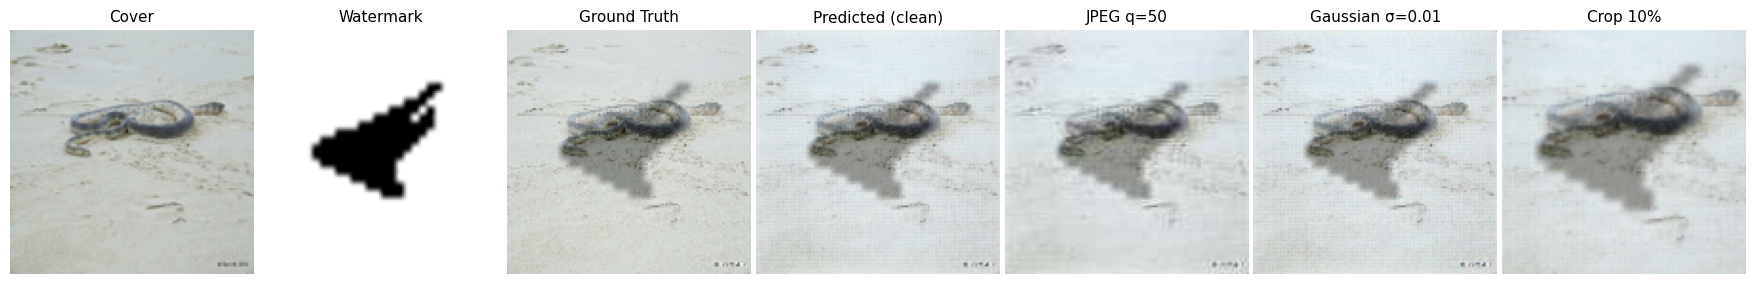

[SAVED] cgan_robustness_row.png


In [10]:
import os
from glob import glob
import numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# config
ALPHA  = 0.3
THRESH = 0.5

# helpers
def _list_many(patterns):
    paths = []
    for p in patterns:
        paths.extend(glob(p))
    return sorted(paths)

def _discover_test_pairs():
    # 1) Already built lists from DL pipeline
    if "test_cover_paths" in globals() and "test_mark_paths" in globals():
        if len(test_cover_paths) and len(test_mark_paths):
            return test_cover_paths, test_mark_paths

    # 2) Directories set earlier
    if "TEST_COVER_DIR" in globals() and "TEST_MARK_DIR" in globals():
        cov = _list_many([
            os.path.join(TEST_COVER_DIR, "*.JPEG"),
            os.path.join(TEST_COVER_DIR, "*.JPG"),
            os.path.join(TEST_COVER_DIR, "*.jpg"),
            os.path.join(TEST_COVER_DIR, "*.jpeg"),
            os.path.join(TEST_COVER_DIR, "*.png"),
        ])
        mrk = _list_many([
            os.path.join(TEST_MARK_DIR, "*.png"),
            os.path.join(TEST_MARK_DIR, "*.PNG"),
            os.path.join(TEST_MARK_DIR, "*.jpg"),
            os.path.join(TEST_MARK_DIR, "*.jpeg"),
        ])
        return cov, mrk

    # 3) Fallback:
    BASE_DIR = "/kaggle/input/image-watermarking/dataset"
    cov = _list_many([
        f"{BASE_DIR}/test/cover/*.JPEG",
        f"{BASE_DIR}/test/cover/*.JPG",
        f"{BASE_DIR}/test/cover/*.jpg",
        f"{BASE_DIR}/test/cover/*.jpeg",
        f"{BASE_DIR}/test/cover/*.png",
    ])
    mrk = _list_many([
        f"{BASE_DIR}/test/mark/*.png",
        f"{BASE_DIR}/test/mark/*.PNG",
        f"{BASE_DIR}/test/mark/*.jpg",
        f"{BASE_DIR}/test/mark/*.jpeg",
    ])
    return cov, mrk

test_cover_paths, test_mark_paths = _discover_test_pairs()
if not len(test_cover_paths) or not len(test_mark_paths):
    print("[WARN] No test cover/mark images found — BER/NC will be skipped.")

# attacks (expects float images in [0,1], HxWxC)
def _jpeg(img01, quality=50):
    buf = BytesIO()
    Image.fromarray((img01 * 255.0).astype(np.uint8)).save(buf, format="JPEG", quality=int(quality))
    buf.seek(0)
    out = np.asarray(Image.open(buf).convert("RGB"), dtype=np.float32) / 255.0
    return out

def _gaussian(img01, sigma=0.01):
    n = np.random.normal(0.0, float(sigma), img01.shape).astype(np.float32)
    return np.clip(img01 + n, 0.0, 1.0)

def _crop_and_resize(img01, crop_ratio=0.10):
    h, w = img01.shape[:2]
    dy = int(round(h * crop_ratio)); dx = int(round(w * crop_ratio))
    if dy == 0 and dx == 0 or (h - 2*dy) <= 0 or (w - 2*dx) <= 0:
        return img01.copy()
    crop = img01[dy:h-dy, dx:w-dx, :]
    out = np.asarray(
        Image.fromarray((crop * 255).astype(np.uint8)).resize((w, h), Image.BILINEAR),
        dtype=np.float32
    ) / 255.0
    return out

def _psnr_from_images(a, b, eps=1e-12):
    mse = float(np.mean((a - b) ** 2))
    psnr = 10.0 * np.log10((1.0**2) / (mse + eps))
    return mse, psnr

def _ssim_img(a, b):
    try:    return ssim(a, b, data_range=1.0, channel_axis=2)
    except TypeError: return ssim(a, b, data_range=1.0, multichannel=True)

# extraction helpers
def _to_gray01(img):
    if img.ndim == 3 and img.shape[2] == 3:
        return (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.float32)
    return img.astype(np.float32)

def _binarize01(gray, thr=0.5): return (gray >= float(thr)).astype(np.uint8)
def _ber(a_bin, b_bin):        return float(np.mean(a_bin != b_bin))

def _nc_classic(a_bin, b_bin, eps=1e-12):
    a = (a_bin.astype(np.float32) * 2.0) - 1.0
    b = (b_bin.astype(np.float32) * 2.0) - 1.0
    return float((a*b).sum() / (np.sqrt((a*a).sum())*np.sqrt((b*b).sum()) + eps))

def _extract_watermark(Y_obs, C_cover, alpha=ALPHA):
    W_hat = (Y_obs - C_cover) / float(alpha)
    return np.clip(W_hat, 0.0, 1.0)

def _get_cover_mark(i, H, W):
    if i >= len(test_cover_paths) or i >= len(test_mark_paths): 
        return None, None
    try:
        cov = Image.open(test_cover_paths[i]).convert("RGB").resize((W, H))
        mrk = Image.open(test_mark_paths[i]).convert("RGB").resize((W, H))
        return (np.asarray(cov, dtype=np.float32)/255.0,
                np.asarray(mrk, dtype=np.float32)/255.0)
    except Exception:
        return None, None

# use Yp, Yt from training cell
N, H, W, C = Yp.shape  # (N,H,W,3)

# evaluate a transform over the whole set
def _eval_attack(transform):
    mses, psnrs, ssims = [], [], []
    bers, ncs = [], []
    have_pairs = True
    for i in range(N):
        Yt_i = Yt[i]
        Yp_i = Yp[i]
        Ya   = transform(Yp_i)

        mse_i, psnr_i = _psnr_from_images(Yt_i, Ya)
        mses.append(mse_i); psnrs.append(psnr_i); ssims.append(_ssim_img(Yt_i, Ya))

        C_img, W_true = _get_cover_mark(i, H, W)
        if C_img is None or W_true is None:
            have_pairs = False
            continue
        W_hat  = _extract_watermark(Ya, C_img, alpha=ALPHA)
        Wt_bin = _binarize01(_to_gray01(W_true), thr=THRESH)
        Wh_bin = _binarize01(_to_gray01(W_hat),  thr=THRESH)
        bers.append(_ber(Wt_bin, Wh_bin))
        ncs.append(_nc_classic(Wt_bin, Wh_bin))

    return {
        "mse": float(np.mean(mses)),
        "psnr": float(np.mean(psnrs)),
        "ssim": float(np.mean(ssims)),
        "have_pairs": have_pairs and len(bers) == N,
        "ber": float(np.mean(bers)) if len(bers) else None,
        "nc":  float(np.mean(ncs))  if len(ncs)  else None,
        "ber_n": len(bers)
    }

# ---------- run ----------
res_clean = _eval_attack(lambda img: img)
res_jpeg  = _eval_attack(lambda img: _jpeg(img, quality=50))
res_gaus  = _eval_attack(lambda img: _gaussian(img, sigma=0.01))
res_crop  = _eval_attack(lambda img: _crop_and_resize(img, crop_ratio=0.10))

print("\n[ROBUSTNESS — dataset mean metrics]")
def _line(name, r):
    base = f"{name:<12} -> MSE: {r['mse']:.6f} | PSNR: {r['psnr']:.2f} dB | SSIM: {r['ssim']:.4f}"
    if r['ber'] is not None and r['nc'] is not None:
        base += f" | BER: {r['ber']:.4f} (n={r['ber_n']}) | NC(±1): {r['nc']:.4f}"
    else:
        base += " | BER/NC: n/a (need cover+watermark)"
    print(base)

_line("Clean",          res_clean)
_line("JPEG(q=50)",     res_jpeg)
_line("Gaussian(0.01)", res_gaus)
_line("Crop(10%)",      res_crop)

# Visualization
viz_idx = 0
Yt_v, Yp_v = Yt[viz_idx], Yp[viz_idx]
Yp_jpeg = _jpeg(Yp_v, quality=50)
Yp_gaus = _gaussian(Yp_v, sigma=0.01)
Yp_crop = _crop_and_resize(Yp_v, crop_ratio=0.10)
cover_img, mark_img = _get_cover_mark(viz_idx, H, W)

panels = [
    (cover_img if cover_img is not None else np.zeros_like(Yt_v), "Cover"),
    (mark_img  if mark_img  is not None else np.zeros_like(Yt_v), "Watermark"),
    (Yt_v,     "Ground Truth"),
    (Yp_v,     "Predicted (clean)"),
    (Yp_jpeg,  "JPEG q=50"),
    (Yp_gaus,  "Gaussian σ=0.01"),
    (Yp_crop,  "Crop 10%"),
]
w_per_img, h_in = 3.2, 3.2
fig, axes = plt.subplots(1, len(panels), figsize=(w_per_img*len(panels), h_in))
for ax, (img, title) in zip(axes, panels):
    ax.imshow(np.clip(img, 0, 1)); ax.set_title(title, fontsize=11); ax.axis("off")
plt.subplots_adjust(wspace=0.02, hspace=0)
out_path = "cgan_robustness_row.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()
print(f"[SAVED] {out_path}")

### HiDDeN architecture

2025-11-15 23:03:03.378455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763247783.602888      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763247783.666997      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[DATA] Train 5000 | Test 1000 | Res 128x128 | alpha=0.3


I0000 00:00:1763247797.667374      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763247797.668028      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
[codecarbon INFO @ 23:03:38] offline tracker init
[codecarbon WARNING @ 23:03:38] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:03:38] [setup] RAM Tracking...
[codecarbon INFO @ 23:03:38] [setup] CPU Tracking...
[codecarbon WARNING @ 23:03:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 23:03:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are rea

Epoch 1/10 img_loss=0.0013


[codecarbon INFO @ 23:05:09] Energy consumed for RAM : 0.000486 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:05:09] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:05:09] Energy consumed for All CPU : 0.001037 kWh
[codecarbon INFO @ 23:05:09] Energy consumed for all GPUs : 0.002276 kWh. Total GPU Power : 98.08269056997179 W
[codecarbon INFO @ 23:05:09] 0.003799 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:05:09] Energy consumed for RAM : 0.000489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:05:09] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:05:09] Energy consumed for All CPU : 0.001043 kWh
[codecarbon INFO @ 23:05:09] Energy consumed for all GPUs : 0.002289 kWh. Total GPU Power : 101.4969624887851 W
[codecarbon INFO @ 23:05:09] 0.003821 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:05

Epoch 2/10 img_loss=0.0001


[codecarbon INFO @ 23:06:44] Energy consumed for RAM : 0.001004 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:06:44] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:06:44] Energy consumed for All CPU : 0.002140 kWh
[codecarbon INFO @ 23:06:44] Energy consumed for all GPUs : 0.004763 kWh. Total GPU Power : 91.74044727668158 W
[codecarbon INFO @ 23:06:44] 0.007906 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:06:45] Energy consumed for RAM : 0.001007 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:06:45] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:06:45] Energy consumed for All CPU : 0.002146 kWh
[codecarbon INFO @ 23:06:45] Energy consumed for all GPUs : 0.004776 kWh. Total GPU Power : 98.07127937828228 W
[codecarbon INFO @ 23:06:45] 0.007928 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:06

Epoch 3/10 img_loss=0.0000


[codecarbon INFO @ 23:08:22] Energy consumed for RAM : 0.001538 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:08:22] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:08:22] Energy consumed for All CPU : 0.003278 kWh
[codecarbon INFO @ 23:08:22] Energy consumed for all GPUs : 0.007319 kWh. Total GPU Power : 96.98422235783801 W
[codecarbon INFO @ 23:08:22] 0.012135 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:08:23] Energy consumed for RAM : 0.001541 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:08:23] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:08:23] Energy consumed for All CPU : 0.003284 kWh
[codecarbon INFO @ 23:08:23] Energy consumed for all GPUs : 0.007332 kWh. Total GPU Power : 96.50963149405092 W
[codecarbon INFO @ 23:08:23] 0.012157 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:08

Epoch 4/10 img_loss=0.0000


[codecarbon INFO @ 23:10:00] Energy consumed for RAM : 0.002070 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:10:00] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:10:00] Energy consumed for All CPU : 0.004411 kWh
[codecarbon INFO @ 23:10:00] Energy consumed for all GPUs : 0.009861 kWh. Total GPU Power : 92.96122946987111 W
[codecarbon INFO @ 23:10:00] 0.016341 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:10:00] 0.012539 g.CO2eq/s mean an estimation of 395.417726490284 kg.CO2eq/year
[codecarbon INFO @ 23:10:00] Energy consumed for RAM : 0.002073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:10:00] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:10:00] Energy consumed for All CPU : 0.004416 kWh
[codecarbon INFO @ 23:10:00] Energy consumed for all GPUs : 0.009872 kWh. Total GPU Power : 83.34369918362448 W
[codecarbon INFO @ 23:10:00] 0.0163

Epoch 5/10 img_loss=0.0000


[codecarbon INFO @ 23:11:39] Energy consumed for RAM : 0.002610 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:11:39] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:11:39] Energy consumed for All CPU : 0.005560 kWh
[codecarbon INFO @ 23:11:39] Energy consumed for all GPUs : 0.012438 kWh. Total GPU Power : 96.27253228390433 W
[codecarbon INFO @ 23:11:39] 0.020608 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:11:39] Energy consumed for RAM : 0.002613 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:11:39] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:11:39] Energy consumed for All CPU : 0.005566 kWh
[codecarbon INFO @ 23:11:39] Energy consumed for all GPUs : 0.012448 kWh. Total GPU Power : 76.09490673506751 W
[codecarbon INFO @ 23:11:39] 0.020627 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:11

Epoch 6/10 img_loss=0.0000


[codecarbon INFO @ 23:13:17] Energy consumed for RAM : 0.003147 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:13:17] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:13:17] Energy consumed for All CPU : 0.006704 kWh
[codecarbon INFO @ 23:13:17] Energy consumed for all GPUs : 0.014999 kWh. Total GPU Power : 96.76025822774825 W
[codecarbon INFO @ 23:13:17] 0.024850 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:13:18] Energy consumed for RAM : 0.003149 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:13:18] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:13:18] Energy consumed for All CPU : 0.006710 kWh
[codecarbon INFO @ 23:13:18] Energy consumed for all GPUs : 0.015012 kWh. Total GPU Power : 95.28683917210103 W
[codecarbon INFO @ 23:13:18] 0.024871 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:13

Epoch 7/10 img_loss=0.0000


[codecarbon INFO @ 23:14:55] Energy consumed for RAM : 0.003678 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:14:55] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:14:55] Energy consumed for All CPU : 0.007836 kWh
[codecarbon INFO @ 23:14:55] Energy consumed for all GPUs : 0.017535 kWh. Total GPU Power : 91.50453901928502 W
[codecarbon INFO @ 23:14:55] 0.029050 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:14:55] Energy consumed for RAM : 0.003681 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:14:55] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:14:55] Energy consumed for All CPU : 0.007842 kWh
[codecarbon INFO @ 23:14:55] Energy consumed for all GPUs : 0.017548 kWh. Total GPU Power : 95.94273020102243 W
[codecarbon INFO @ 23:14:55] 0.029071 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:14

Epoch 8/10 img_loss=0.0000


[codecarbon INFO @ 23:16:33] Energy consumed for RAM : 0.004213 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:16:33] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:16:33] Energy consumed for All CPU : 0.008974 kWh
[codecarbon INFO @ 23:16:33] Energy consumed for all GPUs : 0.020084 kWh. Total GPU Power : 91.34937581333082 W
[codecarbon INFO @ 23:16:33] 0.033271 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:16:34] Energy consumed for RAM : 0.004215 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:16:34] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:16:34] Energy consumed for All CPU : 0.008980 kWh
[codecarbon INFO @ 23:16:34] Energy consumed for all GPUs : 0.020097 kWh. Total GPU Power : 97.24777836811849 W
[codecarbon INFO @ 23:16:34] 0.033293 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:16

Epoch 9/10 img_loss=0.0000


[codecarbon INFO @ 23:18:11] Energy consumed for RAM : 0.004747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:18:11] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:18:11] Energy consumed for All CPU : 0.010113 kWh
[codecarbon INFO @ 23:18:11] Energy consumed for all GPUs : 0.022636 kWh. Total GPU Power : 97.04342054134337 W
[codecarbon INFO @ 23:18:11] 0.037496 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:18:12] Energy consumed for RAM : 0.004750 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:18:12] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 23:18:12] Energy consumed for All CPU : 0.010119 kWh
[codecarbon INFO @ 23:18:12] Energy consumed for all GPUs : 0.022647 kWh. Total GPU Power : 83.18532542018892 W
[codecarbon INFO @ 23:18:12] 0.037515 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:18

Epoch 10/10 img_loss=0.0000
[TRAIN] 969.42s for ~5000 imgs | CO2: 0.012124 kg


[codecarbon INFO @ 23:20:00] offline tracker init
[codecarbon WARNING @ 23:20:00] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:20:00] [setup] RAM Tracking...
[codecarbon INFO @ 23:20:00] [setup] CPU Tracking...
[codecarbon WARNING @ 23:20:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 23:20:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 23:20:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 23:20:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:20:02] [setup] GPU Tracking...
[codecarbon INFO @ 23:20:02] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:20:02] The below tracking methods have been s

[CLEAN] MSE(blend) 0.000010 | PSNR(blend) 50.83 | SSIM(blend) 0.9993 || PSNR(cover) 15.89 | SSIM(cover) 0.7602
[EXTRACT clean] NC 0.4864 | BER 25.68% | IoU 0.4427

[ROBUSTNESS — mean per image (non-blind, vs blended)]
 jpeg50 -> MSE: 0.001594 | PSNR: 28.71 dB | SSIM: 0.8762 | NC: 0.4984 | BER: 25.08% (n=1000)
  gauss -> MSE: 0.000108 | PSNR: 39.66 dB | SSIM: 0.9772 | NC: 0.5074 | BER: 24.63% (n=1000)
 crop10 -> MSE: 0.038448 | PSNR: 14.54 dB | SSIM: 0.2012 | NC: 0.2934 | BER: 35.33% (n=1000)
[SIZE] HiDDeN-D Enc+Dec (.keras): 5.17 MB

[DONE] HiDDeN-D-NB evaluation complete. Metrics + hiddenD_nb_meta.json saved.


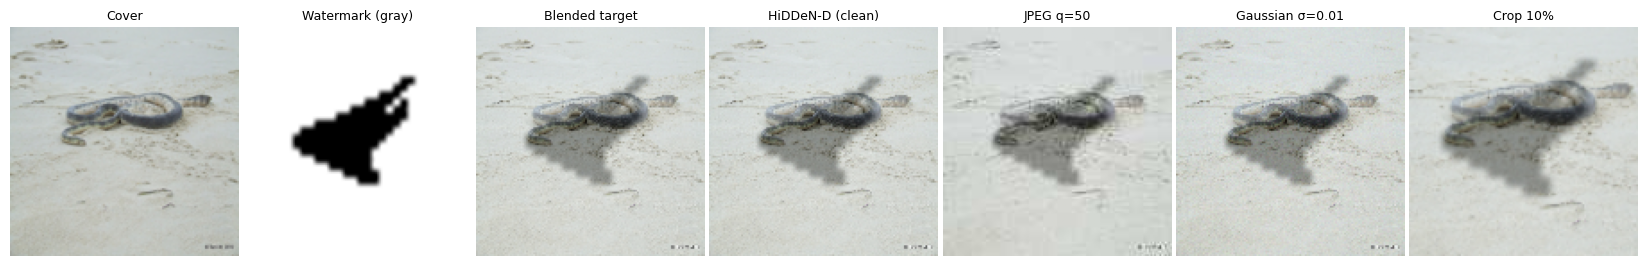

[SAVED] hiddenD_nb_robustness_row.png


In [2]:
# ============================================================
# HiDDeN-D-NB — Deep Non-blind Baseline (Blended Target)
#
# - Train on (cover, mark) -> blended target yb = (1-α)*cover + α*mark
# - Deep encoder/decoder (128 filters + residual blocks)
# - Non-blind objective: wm ≈ blended target (no BCE on logo by default)
# - No training-time noise (USE_TRAIN_NOISE = False)
# - Metrics: MSE/PSNR/SSIM (imperceptibility), NC/BER/IoU (non-blind)
# - Robustness: JPEG, Gaussian, Crop
# - Single-row visualisation (cover, grayscale watermark, blended, HiDDeN + attacks)
# ============================================================

import os, json, numpy as np, tensorflow as tf
from glob import glob
from time import perf_counter
from io import BytesIO
from PIL import Image
from skimage.metrics import structural_similarity as _ssim
import matplotlib.pyplot as plt

# -----------------------
# Repro + config
# -----------------------
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED)

BASE_DIR = '/kaggle/input/image-watermarking/dataset'
TRAIN_COVER_DIR = os.path.join(BASE_DIR, "train", "cover")
TRAIN_MARK_DIR  = os.path.join(BASE_DIR, "train", "mark")
TEST_COVER_DIR  = os.path.join(BASE_DIR, "test",  "cover")
TEST_MARK_DIR   = os.path.join(BASE_DIR, "test",  "mark")

IMG_H, IMG_W, C = 128, 128, 3
BATCH_SIZE = 32
MAX_TRAIN, MAX_TEST = 5000, 1000
ALPHA = 0.3
P = 32              # logo resolution for NC/BER
BIN_THR = 0.5

# Deep HiDDeN-D config (10-epoch budget)
EPOCHS = 10
LR     = 5e-4

# Non-blind objective: strong weight on image (blended) loss
L_IMG  = 10.0
L_LOGO = 0.0   # set >0 only if you want to train the decoder too

# How far encoder is allowed to move from cover towards blended target
RESIDUAL_SCALE = 0.5

# Training-time noise (kept False for comparability with your other models)
USE_TRAIN_NOISE = False


# -----------------------
# CodeCarbon helpers (optional)
# -----------------------
def cc_start(name="Run", out_dir=".", sample_s=0.5, country="IRL"):
    try:
        from codecarbon import EmissionsTracker, OfflineEmissionsTracker
        try:
            tracker = OfflineEmissionsTracker(
                project_name=name, output_dir=out_dir,
                measure_power_secs=sample_s, save_to_file=True,
                country_iso_code=country,
            )
        except Exception:
            tracker = EmissionsTracker(
                project_name=name, output_dir=out_dir,
                measure_power_secs=sample_s, save_to_file=True,
                tracking_mode="process", country_iso_code=country,
            )
        tracker.start()
        return tracker
    except Exception:
        return None

def cc_stop(tracker):
    try:
        return tracker.stop() if tracker is not None else None
    except Exception:
        return None


# -----------------------
# Files + decode
# -----------------------
def _list_many(patterns):
    out = []
    for p in patterns:
        out.extend(glob(p))
    return sorted(out)

def _read_resize_any(path, size=(IMG_H, IMG_W)):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size)
    img.set_shape((IMG_H, IMG_W, 3))
    return img

train_covers = _list_many([f"{TRAIN_COVER_DIR}/*.{ext}" for ext in ["jpg","jpeg","JPG","JPEG","png","PNG"]])
train_marks  = _list_many([f"{TRAIN_MARK_DIR}/*.{ext}"  for ext in ["png","PNG","jpg","jpeg","JPG","JPEG"]])
test_covers  = _list_many([f"{TEST_COVER_DIR}/*.{ext}"  for ext in ["jpg","jpeg","JPG","JPEG","png","PNG"]])
test_marks   = _list_many([f"{TEST_MARK_DIR}/*.{ext}"   for ext in ["png","PNG","jpg","jpeg","JPG","JPEG"]])

n_train = min(len(train_covers), len(train_marks))
n_test  = min(len(test_covers),  len(test_marks))
assert n_train > 0 and n_test > 0, "No images—check dataset paths."

train_covers, train_marks = train_covers[:n_train], train_marks[:n_train]
test_covers,  test_marks  = test_covers[:n_test],   test_marks[:n_test]

n_train = min(n_train, MAX_TRAIN)
n_test  = min(n_test,  MAX_TEST)
train_covers, train_marks = train_covers[:n_train], train_marks[:n_train]
test_covers,  test_marks  = test_covers[:n_test],   test_marks[:n_test]

print(f"[DATA] Train {len(train_covers)} | Test {len(test_covers)} | Res {IMG_W}x{IMG_H} | alpha={ALPHA}")


# -----------------------
# Build TF datasets (x6 = cover+mark, yb = blended target)
# -----------------------
def _to_x6_and_blend(c_path, m_path):
    cover = _read_resize_any(c_path)
    mark  = _read_resize_any(m_path)
    x6 = tf.concat([cover, mark], axis=-1)        # (H,W,6)
    yb = (1.0 - ALPHA) * cover + ALPHA * mark     # blended target
    return x6, yb

def _build_cnn_ds(covers, marks, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((covers, marks))
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda c, m: _to_x6_and_blend(c, m),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_image_ds = _build_cnn_ds(train_covers, train_marks, shuffle=True)
test_image_ds  = _build_cnn_ds(test_covers,  test_marks,  shuffle=False)

def _logo32(mark_img, P=32, thr=0.5):
    m = tf.image.rgb_to_grayscale(mark_img)
    m = tf.image.resize(m, (P, P), method='area')
    return tf.cast(m >= thr, tf.float32)

def wrap_hidden(ds, P=32, thr=0.5):
    def _map(x6, yb):
        cover, mark = x6[..., :3], x6[..., 3:]
        logo = _logo32(mark, P, thr)              # (B,32,32,1)
        return (cover, logo), (yb, logo)
    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

train_ds = wrap_hidden(train_image_ds, P, BIN_THR)
test_ds  = wrap_hidden(test_image_ds,  P, BIN_THR)


# -----------------------
# Model: Deep HiDDeN-D encoder/decoder
# -----------------------
from tensorflow.keras import layers, Model

class Noise(layers.Layer):
    def __init__(self, gauss=(0.0, 0.02), drop=(0.0, 0.05), crop=(0.0, 0.12)):
        super().__init__()
        self.g, self.d, self.c = gauss, drop, crop

    def call(self, x, training=None):
        # Kept for experiments; default path bypasses this (USE_TRAIN_NOISE=False)
        x_dtype = x.dtype
        x32 = tf.cast(x, tf.float32)

        # Gaussian noise
        std = tf.random.uniform([], self.g[0], self.g[1], dtype=tf.float32)
        x32 = tf.clip_by_value(
            x32 + tf.random.normal(tf.shape(x32), stddev=std, dtype=tf.float32),
            0., 1.
        )

        # Dropout-like masking
        rate = tf.random.uniform([], self.d[0], self.d[1], dtype=tf.float32)
        x32 = tf.nn.dropout(x32, rate=rate)

        # Random crop + resize
        r = tf.random.uniform([], self.c[0], self.c[1], dtype=tf.float32)
        h = tf.shape(x32)[1]; w = tf.shape(x32)[2]
        dy = tf.cast(tf.round(r * tf.cast(h, tf.float32)), tf.int32)
        dx = tf.cast(tf.round(r * tf.cast(w, tf.float32)), tf.int32)
        nh = tf.maximum(h - 2*dy, 1); nw = tf.maximum(w - 2*dx, 1)
        y  = x32[:, dy:dy+nh, dx:dx+nw, :]
        y  = tf.image.resize(y, (h, w), method='bilinear')
        y  = tf.clip_by_value(y, 0., 1.)

        return tf.cast(y if training else tf.cast(x, tf.float32), x_dtype)

class ResBlock(layers.Layer):
    def __init__(self, filters=128):
        super().__init__()
        self.c1 = layers.Conv2D(filters, 3, padding='same', activation='relu')
        self.c2 = layers.Conv2D(filters, 3, padding='same', activation=None)

    def call(self, x, training=None):
        y = self.c1(x)
        y = self.c2(y)
        y = layers.Add()([x, y])
        return tf.nn.relu(y)

class Encoder(Model):
    # Deep encoder: initial conv + several residual blocks
    def __init__(self, filters=128, n_blocks=3, **kwargs):
        super().__init__(**kwargs)
        self.stem = layers.Conv2D(filters, 3, padding='same', activation='relu')
        self.blocks = [ResBlock(filters) for _ in range(n_blocks)]
        self.tail = layers.Conv2D(filters, 3, padding='same', activation='relu')
        self.head = layers.Conv2D(3, 1, padding='same', activation=None)

    def call(self, x6, training=None):
        x = self.stem(x6)
        for blk in self.blocks:
            x = blk(x, training=training)
        x = self.tail(x)
        res = RESIDUAL_SCALE * self.head(x)
        cover = x6[..., :3]
        wm = tf.clip_by_value(cover + res, 0., 1.)
        return wm

class Decoder(Model):
    # Decoder for possible blind experiments; not used in loss when L_LOGO = 0
    def __init__(self, filters=128, **kwargs):
        super().__init__(**kwargs)
        self.c1 = layers.Conv2D(filters, 3, padding='same', activation='relu')
        self.c2 = layers.Conv2D(filters, 3, padding='same', activation='relu')
        self.c3 = layers.Conv2D(filters, 3, padding='same', activation='relu')
        self.pool = layers.AveragePooling2D(pool_size=4, strides=4, padding='valid')
        self.head = layers.Conv2D(1, 1, padding='same', activation='sigmoid')

    def call(self, y_noisy, training=None):
        x = self.c1(y_noisy)
        x = self.c2(x)
        x = self.c3(x)
        x = self.pool(x)
        return self.head(x)  # (B,32,32,1)

class HiDDeN(Model):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.noise = Noise()
        self.dec = Decoder()

    def call(self, cover, logo, training=None):
        H = tf.shape(cover)[1]; W = tf.shape(cover)[2]
        logo_up = tf.image.resize(logo, (H, W), method='nearest')  # (B,H,W,1)
        logo_3  = tf.concat([logo_up, logo_up, logo_up], axis=-1)  # (B,H,W,3)
        x6 = tf.concat([cover, logo_3], axis=-1)                   # (B,H,W,6)

        wm = self.enc(x6, training=training)

        if USE_TRAIN_NOISE and training:
            y = self.noise(wm, training=True)
        else:
            y = wm  # clean path

        z = self.dec(y, training=training)
        return wm, z

hidden = HiDDeN()
mse = tf.keras.losses.MeanSquaredError()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam(LR)


# -----------------------
# Train
# -----------------------
@tf.function
def _train_step(cover, logo, y_blend):
    with tf.GradientTape() as tape:
        wm, z = hidden(cover, logo, training=True)
        img_loss  = mse(y_blend, wm)
        if L_LOGO > 0.0:
            logo_loss = bce(logo, z)
        else:
            logo_loss = 0.0
        loss = L_IMG * img_loss + L_LOGO * logo_loss
    grads = tape.gradient(loss, hidden.trainable_variables)
    opt.apply_gradients(zip(grads, hidden.trainable_variables))
    return img_loss, logo_loss, loss

def _count(ds):
    n = 0
    for (cover, _), _targets in ds:
        n += int(cover.shape[0])
    return n

N_train = _count(train_ds)
train_tracker = cc_start(name="HiDDeN_D_NB_Train", out_dir=".", sample_s=0.5, country="IRL")
t0 = perf_counter()
for epoch in range(EPOCHS):
    img_losses, logo_losses = [], []
    for (cover_batch, logo_batch), (y_blend_batch, _) in train_ds:
        img_l, logo_l, _ = _train_step(cover_batch, logo_batch, y_blend_batch)
        img_losses.append(float(img_l))
        if L_LOGO > 0.0:
            logo_losses.append(float(logo_l))
    if L_LOGO > 0.0 and logo_losses:
        print(f"Epoch {epoch+1}/{EPOCHS} img_loss={np.mean(img_losses):.4f}  "
              f"logo_loss={np.mean(logo_losses):.4f}")
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} img_loss={np.mean(img_losses):.4f}")
train_time = perf_counter() - t0
train_emissions_kg = cc_stop(train_tracker)
print(f"[TRAIN] {train_time:.2f}s for ~{N_train} imgs | CO2: "
      f"{('%.6f kg' % train_emissions_kg) if train_emissions_kg is not None else 'n/a'}")


# -----------------------
# Metrics & attacks (non-blind extraction)
# -----------------------
def _psnr(a, b, eps=1e-12):
    a, b = a.astype(np.float32), b.astype(np.float32)
    mse_v = float(np.mean((a - b) ** 2))
    return 10 * np.log10(1.0 / (mse_v + eps)), mse_v

def _ssim_img(a, b):
    try:
        return float(_ssim(a, b, data_range=1.0, channel_axis=2))
    except TypeError:
        return float(_ssim(a, b, data_range=1.0, multichannel=True))

def _jpeg(img01, q=50):
    buf = BytesIO()
    Image.fromarray((np.clip(img01, 0, 1) * 255).astype(np.uint8)).save(buf, "JPEG", quality=int(q))
    buf.seek(0)
    return np.asarray(Image.open(buf).convert("RGB"), dtype=np.float32) / 255.0

def _gaussian(img01, sigma=0.01):
    return np.clip(img01 + np.random.normal(0, sigma, img01.shape).astype(np.float32), 0, 1)

def _crop_and_resize(img01, r=0.10):
    H, W, _ = img01.shape
    dy, dx = int(round(H * r)), int(round(W * r))
    if (dy == 0 and dx == 0) or (H - 2 * dy) <= 0 or (W - 2 * dx) <= 0:
        return img01.copy()
    crop = img01[dy:H-dy, dx:W-dx, :]
    return np.asarray(
        Image.fromarray((np.clip(crop, 0, 1) * 255).astype(np.uint8)).resize((W, H), Image.BILINEAR),
        dtype=np.float32
    ) / 255.0

def _ber(pred, true):
    ph = (pred > 0.5).astype(np.uint8)
    th = (true > 0.5).astype(np.uint8)
    return float(np.mean(ph != th))

def _iou(pred, true, eps=1e-9):
    ph = (pred > 0.5).astype(np.uint8)
    th = (true > 0.5).astype(np.uint8)
    inter = float((ph & th).sum())
    union = float((ph | th).sum())
    return inter / (union + eps)

def _to_gray01(img):
    return (0.299 * img[..., 0] + 0.587 * img[..., 1] + 0.114 * img[..., 2]).astype(np.float32)

def _binarize01(gray, thr=0.5): 
    return (gray >= float(thr)).astype(np.uint8)

def _nc_classic(a_bin, b_bin, eps=1e-12):
    a = (a_bin.astype(np.float32) * 2.0) - 1.0
    b = (b_bin.astype(np.float32) * 2.0) - 1.0
    return float((a * b).sum() / (np.sqrt((a * a).sum()) * np.sqrt((b * b).sum()) + eps))

def _linear_extract(Y_obs_rgb01, C_rgb01, alpha=ALPHA):
    W_hat = (Y_obs_rgb01 - C_rgb01) / float(alpha)
    return np.clip(W_hat, 0.0, 1.0)

def _to_P(img01, P=32):
    return np.asarray(
        Image.fromarray((np.clip(img01, 0, 1) * 255).astype(np.uint8)).resize((P, P), Image.BILINEAR),
        dtype=np.float32
    ) / 255.0

def _get_cover_mark(i, H, W):
    try:
        cov = Image.open(test_covers[i]).convert("RGB").resize((W, H))
        mrk = Image.open(test_marks[i]).convert("RGB").resize((W, H))
        return (np.asarray(cov, dtype=np.float32) / 255.0,
                np.asarray(mrk, dtype=np.float32) / 255.0)
    except Exception:
        return None, None


# -----------------------
# Eval (clean), inference latency, CO2 (inference)
# -----------------------
def _gather(ds, cap=None):
    Cs, Ls, YB = [], [], []
    total = 0
    for (cover, logo), (y_blend, _) in ds:
        Cs.append(cover.numpy())
        Ls.append(logo.numpy())
        YB.append(y_blend.numpy())
        total += cover.shape[0]
        if cap and total >= cap:
            break
    return np.concatenate(Cs, 0), np.concatenate(Ls, 0), np.concatenate(YB, 0)

Xc, Xl, Yb = _gather(test_ds, cap=MAX_TEST)

@tf.function
def _forward(cover, logo):
    return hidden(cover, logo, training=False)[0]

t1 = perf_counter()
wm_chunks = []
BS_EVAL = 16
for i in range(0, len(Xc), BS_EVAL):
    wmb = _forward(Xc[i:i+BS_EVAL], Xl[i:i+BS_EVAL])
    wm_chunks.append(wmb.numpy())
wm_clean = np.concatenate(wm_chunks, axis=0).astype("float32")
infer_time_forward = perf_counter() - t1

def _decode_batched(imgs, bs=16):
    outs = []
    for i in range(0, len(imgs), bs):
        y = tf.convert_to_tensor(imgs[i:i+bs])
        z = hidden.dec(y, training=False)
        outs.append(tf.cast(z, tf.float32).numpy())
    return np.concatenate(outs, 0)

cc_inf = cc_start(name="HiDDeN_D_NB_Inference", out_dir=".", sample_s=0.5, country="IRL")
t2 = perf_counter()
_ = _decode_batched(wm_clean, bs=16)
infer_time_decode = perf_counter() - t2
infer_emissions_kg = cc_stop(cc_inf)

infer_ms_per_img = (infer_time_forward / max(1, len(wm_clean))) * 1000.0

# Imperceptibility (vs blended, and also vs cover)
psnr_blend_list = []
psnr_cover_list = []
ssim_blend_list = []
ssim_cover_list = []
mse_blend_list  = []

for i in range(len(wm_clean)):
    psnr_b, mse_b = _psnr(Yb[i], wm_clean[i])
    psnr_blend_list.append(psnr_b)
    mse_blend_list.append(mse_b)
    ssim_blend_list.append(_ssim_img(Yb[i], wm_clean[i]))

    psnr_c, _ = _psnr(Xc[i], wm_clean[i])
    psnr_cover_list.append(psnr_c)
    ssim_cover_list.append(_ssim_img(Xc[i], wm_clean[i]))

psnr_blend = float(np.mean(psnr_blend_list))
ssim_blend = float(np.mean(ssim_blend_list))
psnr_cover = float(np.mean(psnr_cover_list))
ssim_cover = float(np.mean(ssim_cover_list))
mse_blend  = float(np.mean(mse_blend_list))

print(f"[CLEAN] MSE(blend) {mse_blend:.6f} | PSNR(blend) {psnr_blend:.2f} | "
      f"SSIM(blend) {ssim_blend:.4f} || PSNR(cover) {psnr_cover:.2f} | SSIM(cover) {ssim_cover:.4f}")


# -----------------------
# Non-blind payload extraction (cover-known)
# -----------------------
bers, ious, ncs = [], [], []
H, W = wm_clean.shape[1], wm_clean.shape[2]
for i in range(len(wm_clean)):
    C_img, W_true = _get_cover_mark(i, H, W)
    if C_img is None or W_true is None:
        continue
    W_hat  = _linear_extract(wm_clean[i], C_img, alpha=ALPHA)
    Wt_P   = _to_P(W_true, P)
    Wh_P   = _to_P(W_hat,  P)
    Wt_bin = _binarize01(_to_gray01(Wt_P), BIN_THR)
    Wh_bin = _binarize01(_to_gray01(Wh_P), BIN_THR)
    bers.append(_ber(Wh_bin, Wt_bin))
    ious.append(_iou(Wh_bin, Wt_bin))
    ncs.append(_nc_classic(Wh_bin, Wt_bin))

ber_clean = float(np.mean(bers)) if bers else float('nan')
iou_clean = float(np.mean(ious)) if ious else float('nan')
nc_clean  = float(np.mean(ncs))  if ncs  else float('nan')
print(f"[EXTRACT clean] NC {nc_clean:.4f} | BER {100.0*ber_clean:.2f}% | IoU {iou_clean:.4f}")

# Robustness — non-blind per attack
attacks = {
    "jpeg50":  lambda x: _jpeg(x, 50),
    "gauss":   lambda x: _gaussian(x, 0.01),
    "crop10":  lambda x: _crop_and_resize(x, 0.10),
}

def _eval_attack_nonblind(wm_array, Yb_array):
    N = wm_array.shape[0]
    H, W = wm_array.shape[1], wm_array.shape[2]
    results = {}
    for name, tfm in attacks.items():
        mses, psnrs, ssims = [], [], []
        bers, ncs = [], []
        for i in range(N):
            wm_att = tfm(wm_array[i])
            psnr_i, mse_i = _psnr(Yb_array[i], wm_att)
            mses.append(mse_i)
            psnrs.append(psnr_i)
            ssims.append(_ssim_img(Yb_array[i], wm_att))

            C_img, W_true = _get_cover_mark(i, H, W)
            if C_img is None or W_true is None:
                continue
            W_hat  = _linear_extract(wm_att, C_img, alpha=ALPHA)
            Wt_bin = _binarize01(_to_gray01(W_true), BIN_THR)
            Wh_bin = _binarize01(_to_gray01(W_hat),  BIN_THR)
            bers.append(_ber(Wh_bin, Wt_bin))
            ncs.append(_nc_classic(Wh_bin, Wt_bin))
        results[name] = {
            "mse": float(np.mean(mses)) if mses else float("nan"),
            "psnr": float(np.mean(psnrs)) if psnrs else float("nan"),
            "ssim": float(np.mean(ssims)) if ssims else float("nan"),
            "ber": float(np.mean(bers)) if bers else None,
            "nc":  float(np.mean(ncs))  if ncs  else None,
            "n": len(bers),
        }
    return results

rob = _eval_attack_nonblind(wm_clean, Yb)

print("\n[ROBUSTNESS — mean per image (non-blind, vs blended)]")
for k in ["jpeg50","gauss","crop10"]:
    r = rob[k]
    print(f"{k:>7} -> MSE: {r['mse']:.6f} | PSNR: {r['psnr']:.2f} dB | SSIM: {r['ssim']:.4f} | "
          f"NC: {r['nc']:.4f} | BER: {100.0*(r['ber'] if r['ber'] is not None else np.nan):.2f}% (n={r['n']})")


# Save & size
hidden.enc.save("hiddenD_nb_encoder.keras", overwrite=True)
hidden.dec.save("hiddenD_nb_decoder.keras", overwrite=True)
hidden.enc.save("hiddenD_nb_encoder.h5")
hidden.dec.save("hiddenD_nb_decoder.h5")

def _dir_size_mb(path):
    if os.path.isfile(path):
        return os.path.getsize(path) / (1024 ** 2)
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total / (1024 ** 2)

size_mb = 0.0
for f in ["hiddenD_nb_encoder.keras","hiddenD_nb_decoder.keras"]:
    if os.path.exists(f):
        size_mb += os.path.getsize(f) / (1024 ** 2)
print(f"[SIZE] HiDDeN-D Enc+Dec (.keras): {size_mb:.2f} MB")

with open("hiddenD_nb_meta.json","w") as f:
    json.dump({
        "dataset": {
            "train": len(train_covers),
            "test": len(test_covers),
            "H": IMG_H,
            "W": IMG_W,
            "alpha": ALPHA
        },
        "clean": {
            "mse_blend": mse_blend,
            "psnr_blend": psnr_blend,
            "ssim_blend": ssim_blend,
            "psnr_cover": psnr_cover,
            "ssim_cover": ssim_cover,
            "nc_clean": nc_clean,
            "ber_clean": ber_clean,
            "iou_clean": iou_clean
        },
        "robustness": rob,
        "timing": {
            "train_time_s": train_time,
            "infer_time_forward_s": infer_time_forward,
            "infer_time_decode_s": infer_time_decode,
            "infer_ms_per_img": infer_ms_per_img
        },
        "co2": {
            "train_kg": train_emissions_kg if train_emissions_kg is not None else "n/a",
            "infer_kg": infer_emissions_kg if infer_emissions_kg is not None else "n/a"
        },
        "size_mb_keras": size_mb,
        "use_train_noise": USE_TRAIN_NOISE,
        "mode": "HiDDeN-D-NB (deep non-blind)"
    }, f, indent=2)

print("\n[DONE] HiDDeN-D-NB evaluation complete. Metrics + hiddenD_nb_meta.json saved.")


# Visualization
viz_idx = 0   # change index if you want another example

if viz_idx >= len(wm_clean):
    raise ValueError(f"viz_idx={viz_idx} is out of range for wm_clean with length {len(wm_clean)}")

# Blended ground truth and HiDDeN prediction — cast to float32 for matplotlib
Yt_v = Yb[viz_idx].astype("float32")       # blended target
Yp_v = wm_clean[viz_idx].astype("float32") # HiDDeN output

# Apply same attacks
Yp_jpeg = _jpeg(Yp_v, q=50)
Yp_gaus = _gaussian(Yp_v, sigma=0.01)
Yp_crop = _crop_and_resize(Yp_v, r=0.10)

# Recover original cover / mark for context
H, W = wm_clean.shape[1], wm_clean.shape[2]
cover_img, mark_img = _get_cover_mark(viz_idx, H, W)

if cover_img is None:
    cover_img = Xc[viz_idx].astype("float32")
else:
    cover_img = cover_img.astype("float32")

if mark_img is None:
    mark_img_gray = np.zeros_like(cover_img, dtype=np.float32)
else:
    mark_img = mark_img.astype("float32")
    g = _to_gray01(mark_img)                       # (H,W)
    mark_img_gray = np.stack([g, g, g], axis=-1)   # grayscale 3-channel (no purple)

panels = [
    (cover_img,      "Cover"),
    (mark_img_gray,  "Watermark (gray)"),
    (Yt_v,           "Blended target"),
    (Yp_v,           "HiDDeN-D (clean)"),
    (Yp_jpeg,        "JPEG q=50"),
    (Yp_gaus,        "Gaussian σ=0.01"),
    (Yp_crop,        "Crop 10%"),
]

w_per_img, h_in = 3.0, 3.0
fig, axes = plt.subplots(1, len(panels), figsize=(w_per_img * len(panels), h_in))

for ax, (img, title) in zip(axes, panels):
    arr = np.asarray(img, dtype=np.float32)
    ax.imshow(np.clip(arr, 0, 1))
    ax.set_title(title, fontsize=9)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0)
out_path = "hiddenD_nb_robustness_row.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()
print(f"[SAVED] {out_path}")


### RivaGAN-style PIPELINE

2025-11-23 01:09:11.593419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763860152.004987      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763860152.131556      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[DATA] Train 5000 | Test 1000 | Res 128x128 | alpha=0.3


I0000 00:00:1763860171.600503      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763860171.601227      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
[codecarbon INFO @ 01:10:05] offline tracker init
[codecarbon WARNING @ 01:10:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:10:05] [setup] RAM Tracking...
[codecarbon INFO @ 01:10:05] [setup] CPU Tracking...
[codecarbon WARNING @ 01:10:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 01:10:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are rea

Epoch 1/10 img=0.00583 logo=0.27006 g_adv=0.90491 d=0.60945


[codecarbon INFO @ 01:11:20] Energy consumed for RAM : 0.000397 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:20] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:20] Energy consumed for All CPU : 0.000848 kWh
[codecarbon INFO @ 01:11:20] Energy consumed for all GPUs : 0.001789 kWh. Total GPU Power : 102.4606140434764 W
[codecarbon INFO @ 01:11:20] 0.003035 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:11:20] Energy consumed for RAM : 0.000400 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:20] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:20] Energy consumed for All CPU : 0.000854 kWh
[codecarbon INFO @ 01:11:20] Energy consumed for all GPUs : 0.001802 kWh. Total GPU Power : 91.91990094984652 W
[codecarbon INFO @ 01:11:20] 0.003056 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:11

Epoch 2/10 img=0.00560 logo=0.08866 g_adv=1.02475 d=0.58269


[codecarbon INFO @ 01:12:18] Energy consumed for RAM : 0.000713 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:18] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:18] Energy consumed for All CPU : 0.001521 kWh
[codecarbon INFO @ 01:12:18] Energy consumed for all GPUs : 0.003304 kWh. Total GPU Power : 95.1617985863763 W
[codecarbon INFO @ 01:12:18] 0.005538 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:12:18] Energy consumed for RAM : 0.000716 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:18] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:18] Energy consumed for All CPU : 0.001527 kWh
[codecarbon INFO @ 01:12:18] Energy consumed for all GPUs : 0.003317 kWh. Total GPU Power : 95.03901152783668 W
[codecarbon INFO @ 01:12:18] 0.005560 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:12:

Epoch 3/10 img=0.00646 logo=0.06730 g_adv=0.94995 d=0.59564


[codecarbon INFO @ 01:13:17] Energy consumed for RAM : 0.001034 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:17] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:17] Energy consumed for All CPU : 0.002205 kWh
[codecarbon INFO @ 01:13:17] Energy consumed for all GPUs : 0.004847 kWh. Total GPU Power : 95.50893075515306 W
[codecarbon INFO @ 01:13:17] 0.008086 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:13:17] Energy consumed for RAM : 0.001037 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:17] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:17] Energy consumed for All CPU : 0.002211 kWh
[codecarbon INFO @ 01:13:17] Energy consumed for all GPUs : 0.004860 kWh. Total GPU Power : 95.91955189464163 W
[codecarbon INFO @ 01:13:17] 0.008108 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:13

Epoch 4/10 img=0.00652 logo=0.06322 g_adv=1.01978 d=0.57529


[codecarbon INFO @ 01:14:17] Energy consumed for RAM : 0.001364 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:17] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:17] Energy consumed for All CPU : 0.002907 kWh
[codecarbon INFO @ 01:14:17] Energy consumed for all GPUs : 0.006426 kWh. Total GPU Power : 95.31460534518405 W
[codecarbon INFO @ 01:14:17] 0.010697 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:14:18] Energy consumed for RAM : 0.001366 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:18] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:18] Energy consumed for All CPU : 0.002913 kWh
[codecarbon INFO @ 01:14:18] Energy consumed for all GPUs : 0.006439 kWh. Total GPU Power : 96.88501271895969 W
[codecarbon INFO @ 01:14:18] 0.010718 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:14

Epoch 5/10 img=0.00631 logo=0.07478 g_adv=1.09616 d=0.55827


[codecarbon INFO @ 01:15:18] Energy consumed for RAM : 0.001695 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:15:18] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:18] Energy consumed for All CPU : 0.003614 kWh
[codecarbon INFO @ 01:15:18] Energy consumed for all GPUs : 0.008022 kWh. Total GPU Power : 95.76165642190995 W
[codecarbon INFO @ 01:15:18] 0.013331 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:15:19] Energy consumed for RAM : 0.001698 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:15:19] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:19] Energy consumed for All CPU : 0.003620 kWh
[codecarbon INFO @ 01:15:19] Energy consumed for all GPUs : 0.008035 kWh. Total GPU Power : 95.8425869270447 W
[codecarbon INFO @ 01:15:19] 0.013353 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:15:

Epoch 6/10 img=0.00569 logo=0.07490 g_adv=1.11240 d=0.54239


[codecarbon INFO @ 01:16:19] Energy consumed for RAM : 0.002028 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:16:19] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:19] Energy consumed for All CPU : 0.004322 kWh
[codecarbon INFO @ 01:16:19] Energy consumed for all GPUs : 0.009617 kWh. Total GPU Power : 95.23086068922997 W
[codecarbon INFO @ 01:16:19] 0.015966 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:16:20] Energy consumed for RAM : 0.002030 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:16:20] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:20] Energy consumed for All CPU : 0.004328 kWh
[codecarbon INFO @ 01:16:20] Energy consumed for all GPUs : 0.009630 kWh. Total GPU Power : 95.94019518859898 W
[codecarbon INFO @ 01:16:20] 0.015988 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:16

Epoch 7/10 img=0.00634 logo=0.08583 g_adv=1.15900 d=0.53808


[codecarbon INFO @ 01:17:21] Energy consumed for RAM : 0.002363 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:17:21] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:21] Energy consumed for All CPU : 0.005036 kWh
[codecarbon INFO @ 01:17:21] Energy consumed for all GPUs : 0.011225 kWh. Total GPU Power : 94.9621785733492 W
[codecarbon INFO @ 01:17:21] 0.018623 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:17:21] Energy consumed for RAM : 0.002365 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:17:21] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:21] Energy consumed for All CPU : 0.005041 kWh
[codecarbon INFO @ 01:17:21] Energy consumed for all GPUs : 0.011239 kWh. Total GPU Power : 96.88747888960845 W
[codecarbon INFO @ 01:17:21] 0.018645 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:17:

Epoch 8/10 img=0.00669 logo=0.06814 g_adv=1.15871 d=0.53641


[codecarbon INFO @ 01:18:23] Energy consumed for RAM : 0.002700 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:18:23] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:23] Energy consumed for All CPU : 0.005755 kWh
[codecarbon INFO @ 01:18:23] Energy consumed for all GPUs : 0.012846 kWh. Total GPU Power : 96.71392524644631 W
[codecarbon INFO @ 01:18:23] 0.021301 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:18:23] 0.012628 g.CO2eq/s mean an estimation of 398.23879457180396 kg.CO2eq/year
[codecarbon INFO @ 01:18:24] Energy consumed for RAM : 0.002703 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:18:24] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:24] Energy consumed for All CPU : 0.005761 kWh
[codecarbon INFO @ 01:18:24] Energy consumed for all GPUs : 0.012859 kWh. Total GPU Power : 96.77865693291332 W
[codecarbon INFO @ 01:18:24] 0.02

Epoch 9/10 img=0.00713 logo=0.06878 g_adv=1.16305 d=0.54917


[codecarbon INFO @ 01:19:25] Energy consumed for RAM : 0.003035 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:19:25] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:19:25] Energy consumed for All CPU : 0.006468 kWh
[codecarbon INFO @ 01:19:25] Energy consumed for all GPUs : 0.014453 kWh. Total GPU Power : 90.33132680137551 W
[codecarbon INFO @ 01:19:25] 0.023956 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:19:25] Energy consumed for RAM : 0.003038 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:19:25] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 01:19:25] Energy consumed for All CPU : 0.006474 kWh
[codecarbon INFO @ 01:19:25] Energy consumed for all GPUs : 0.014466 kWh. Total GPU Power : 95.84368101254266 W
[codecarbon INFO @ 01:19:25] 0.023977 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:19

Epoch 10/10 img=0.00743 logo=0.06831 g_adv=1.19065 d=0.54232
[TRAIN] 620.98s for ~5000 imgs | CO2: 0.007752 kg


[codecarbon INFO @ 01:20:34] offline tracker init
[codecarbon WARNING @ 01:20:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:20:34] [setup] RAM Tracking...
[codecarbon INFO @ 01:20:34] [setup] CPU Tracking...
[codecarbon WARNING @ 01:20:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 01:20:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 01:20:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 01:20:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 01:20:35] [setup] GPU Tracking...
[codecarbon INFO @ 01:20:35] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:20:35] The below tracking methods have been s

[INFER] 2.46s for 1000 imgs (2.46 ms/img) | CO2: 0.000030 kg
[CLEAN] MSE(blend) 0.006252 | PSNR(blend) 22.59 | SSIM(blend) 0.9003 || PSNR(cover) 17.80 | SSIM(cover) 0.8169
[EXTRACT clean] NC 0.3080 | BER 34.60% | IoU 0.2698

[ROBUSTNESS — mean per image (non-blind, vs blended)]
 jpeg50 -> MSE: 0.007672 | PSNR: 21.60 dB | SSIM: 0.7992 | NC: 0.3436 | BER: 32.82% (n=1000)
  gauss -> MSE: 0.006347 | PSNR: 22.50 dB | SSIM: 0.8817 | NC: 0.3482 | BER: 32.59% (n=1000)
 crop10 -> MSE: 0.045767 | PSNR: 13.77 dB | SSIM: 0.1848 | NC: 0.2065 | BER: 39.68% (n=1000)
[SIZE] RivaGAN Enc+Dec+Disc (.keras): 12.72 MB

[DONE] RivaGAN-style evaluation complete. Metrics + rivagan_meta.json saved.


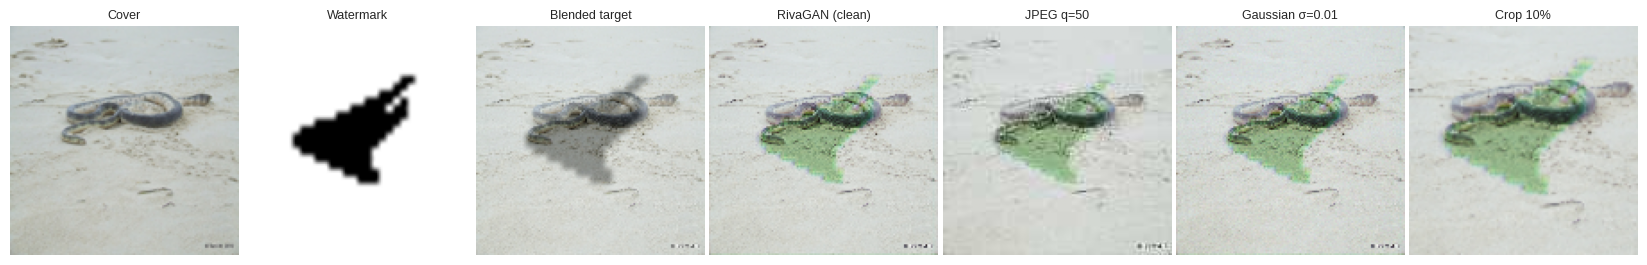

[SAVED] rivagan_row.png


In [4]:
# RivaGAN-style Watermarking (Blended Target, Non-blind Eval)

import os, json, numpy as np, tensorflow as tf
from glob import glob
from time import perf_counter
from io import BytesIO
from PIL import Image
from skimage.metrics import structural_similarity as _ssim
import matplotlib.pyplot as plt

# CodeCarbon
def cc_start(name="Run", out_dir=".", sample_s=0.5, country="IRL"):
    try:
        from codecarbon import EmissionsTracker, OfflineEmissionsTracker
        try:
            tracker = OfflineEmissionsTracker(
                project_name=name,
                output_dir=out_dir,
                measure_power_secs=sample_s,
                save_to_file=True,
                country_iso_code=country,
            )
        except Exception:
            tracker = EmissionsTracker(
                project_name=name,
                output_dir=out_dir,
                measure_power_secs=sample_s,
                save_to_file=True,
                tracking_mode="process",
                country_iso_code=country,
            )
        tracker.start()
        return tracker
    except Exception:
        return None

def cc_stop(tracker):
    try:
        return tracker.stop() if tracker is not None else None
    except Exception:
        return None

# Repro + config
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED)

BASE_DIR = '/kaggle/input/image-watermarking/dataset'
TRAIN_COVER_DIR = os.path.join(BASE_DIR, "train", "cover")
TRAIN_MARK_DIR  = os.path.join(BASE_DIR, "train", "mark")
TEST_COVER_DIR  = os.path.join(BASE_DIR, "test",  "cover")
TEST_MARK_DIR   = os.path.join(BASE_DIR, "test",  "mark")

IMG_H, IMG_W, C = 128, 128, 3
BATCH_SIZE = 16
MAX_TRAIN, MAX_TEST = 5000, 1000
ALPHA = 0.3
P = 32              # logo resolution
BIN_THR = 0.5

# RivaGAN hyperparams
EPOCHS = 10         # keep equal to your other models
LR_G   = 1e-4       # smaller LR for stability
LR_D   = 1e-4
L_IMG, L_LOGO, L_ADV = 5.0, 1.0, 0.5
RESIDUAL_SCALE = 1.5

# Files + decode
def _list_many(patterns):
    out = []
    for p in patterns:
        out.extend(glob(p))
    return sorted(out)

def _read_resize_any(path, size=(IMG_H, IMG_W)):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size)
    img.set_shape((IMG_H, IMG_W, 3))
    return img

train_covers = _list_many([f"{TRAIN_COVER_DIR}/*.{ext}" for ext in ["jpg","jpeg","JPG","JPEG","png","PNG"]])
train_marks  = _list_many([f"{TRAIN_MARK_DIR}/*.{ext}"  for ext in ["png","PNG","jpg","jpeg","JPG","JPEG"]])
test_covers  = _list_many([f"{TEST_COVER_DIR}/*.{ext}"  for ext in ["jpg","jpeg","JPG","JPEG","png","PNG"]])
test_marks   = _list_many([f"{TEST_MARK_DIR}/*.{ext}"   for ext in ["png","PNG","jpg","jpeg","JPG","JPEG"]])

n_train = min(len(train_covers), len(train_marks))
n_test  = min(len(test_covers),  len(test_marks))
assert n_train > 0 and n_test > 0, "No images—check dataset paths."

train_covers, train_marks = train_covers[:n_train], train_marks[:n_train]
test_covers,  test_marks  = test_covers[:n_test],   test_marks[:n_test]

n_train = min(n_train, MAX_TRAIN)
n_test  = min(n_test,  MAX_TEST)
train_covers, train_marks = train_covers[:n_train], train_marks[:n_train]
test_covers,  test_marks  = test_covers[:n_test],   test_marks[:n_test]

print(f"[DATA] Train {len(train_covers)} | Test {len(test_covers)} | Res {IMG_W}x{IMG_H} | alpha={ALPHA}")

# Build TF datasets
def _logo32(mark_img, P=32, thr=0.5):
    m = tf.image.rgb_to_grayscale(mark_img)
    m = tf.image.resize(m, (P, P), method='area')
    return tf.cast(m >= thr, tf.float32)  # (P,P,1) binary

def _to_cover_logo_and_blend(c_path, m_path):
    cover = _read_resize_any(c_path)
    mark  = _read_resize_any(m_path)
    yb = (1.0 - ALPHA) * cover + ALPHA * mark     # blended target
    logo = _logo32(mark, P, BIN_THR)             # (P,P,1)
    return (cover, logo), yb

def _build_rivagan_ds(covers, marks, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((covers, marks))
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda c, m: _to_cover_logo_and_blend(c, m),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = _build_rivagan_ds(train_covers, train_marks, shuffle=True)
test_ds  = _build_rivagan_ds(test_covers,  test_marks,  shuffle=False)


# RivaGAN-style models
from tensorflow.keras import layers, Model

class RivaGANGenerator(Model):
    def __init__(self):
        super().__init__()
        # shallow-ish conv tower with attention
        self.c1 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.c2 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.c3 = layers.Conv2D(128, 3, padding='same', activation='relu')
        self.c4 = layers.Conv2D(128, 3, padding='same', activation='relu')

        # attention branch
        self.att_c1 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.att_c2 = layers.Conv2D(1, 1, padding='same', activation='sigmoid')

        # residual head
        self.head = layers.Conv2D(3, 1, padding='same', activation='tanh')

    def call(self, cover, logo, training=None):
        H = tf.shape(cover)[1]; W = tf.shape(cover)[2]
        # logo: (B,P,P,1) -> upsample to (B,H,W,1)
        logo_up = tf.image.resize(logo, (H, W), method='nearest')
        logo_3  = tf.concat([logo_up, logo_up, logo_up], axis=-1)
        x = tf.concat([cover, logo_3], axis=-1)  # (B,H,W,6)

        # conv stack
        x1 = self.c1(x)
        x2 = self.c2(x1)
        x3 = self.c3(x2)
        x4 = self.c4(x3)

        # attention mask
        att = self.att_c1(x2)
        att = self.att_c2(att)  # (B,H,W,1)
        x_att = x4 * att        # spatially gated features

        # residual
        res = self.head(x_att)  # [-1,1]
        res = RESIDUAL_SCALE * res
        y = (1.0 - ALPHA) * cover + ALPHA * tf.clip_by_value(res, 0., 1.)
        return y

class RivaGANDecoder(Model):
    def __init__(self):
        super().__init__()
        self.c1 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.c2 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D(2)   # 64x64
        self.c3 = layers.Conv2D(128, 3, padding='same', activation='relu')
        self.c4 = layers.Conv2D(128, 3, padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D(2)   # 32x32
        self.head = layers.Conv2D(1, 1, padding='same', activation='sigmoid')

    def call(self, y, training=None):
        x = self.c1(y); x = self.c2(x)
        x = self.pool1(x)
        x = self.c3(x); x = self.c4(x)
        x = self.pool2(x)               # (B,32,32,128)
        z = self.head(x)                # (B,32,32,1)
        return z

class RivaGANDiscriminator(Model):
    def __init__(self):
        super().__init__()
        self.c1 = layers.Conv2D(64, 4, strides=2, padding='same')
        self.c2 = layers.Conv2D(128, 4, strides=2, padding='same')
        self.c3 = layers.Conv2D(256, 4, strides=2, padding='same')
        self.c4 = layers.Conv2D(512, 4, strides=2, padding='same')
        self.lrelu = layers.LeakyReLU(0.2)
        self.gap = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, img, training=None):
        x = self.c1(img); x = self.lrelu(x)
        x = self.c2(x); x = self.lrelu(x)
        x = self.c3(x); x = self.lrelu(x)
        x = self.c4(x); x = self.lrelu(x)
        x = self.gap(x)
        out = self.dense(x)
        return out

G = RivaGANGenerator()
Dec = RivaGANDecoder()
D = RivaGANDiscriminator()

mse = tf.keras.losses.MeanSquaredError()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

opt_G = tf.keras.optimizers.Adam(LR_G, beta_1=0.5, beta_2=0.999)
opt_D = tf.keras.optimizers.Adam(LR_D, beta_1=0.5, beta_2=0.999)

# Train step
@tf.function
def _train_step(cover, logo, y_blend):
    # Forward for generator & discriminator
    with tf.GradientTape(persistent=True) as tape:
        # Generator forward
        y_wm = G(cover, logo, training=True)   # watermarked image
        logo_hat = Dec(y_wm, training=True)   # decoded logo

        # Discriminator on real cover and fake watermarked
        d_real = D(cover, training=True)
        d_fake = D(y_wm, training=True)

        # Losses
        img_loss  = mse(y_blend, y_wm)
        logo_loss = bce(logo, logo_hat)

        d_loss_real = bce(tf.ones_like(d_real), d_real)
        d_loss_fake = bce(tf.zeros_like(d_fake), d_fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        g_adv_loss = bce(tf.ones_like(d_fake), d_fake)

        g_loss = L_IMG * img_loss + L_LOGO * logo_loss + L_ADV * g_adv_loss

    # gradients
    g_vars = G.trainable_variables + Dec.trainable_variables
    d_vars = D.trainable_variables

    g_grads = tape.gradient(g_loss, g_vars)
    d_grads = tape.gradient(d_loss, d_vars)

    opt_G.apply_gradients(zip(g_grads, g_vars))
    opt_D.apply_gradients(zip(d_grads, d_vars))

    del tape
    return img_loss, logo_loss, g_adv_loss, d_loss

def _count(ds):
    n = 0
    for (cover, _logo), _yb in ds:
        n += int(cover.shape[0])
    return n

# Train + CodeCarbon
N_train = _count(train_ds)
train_tracker = cc_start(name="RivaGAN_Train", out_dir=".", sample_s=0.5, country="IRL")
t0 = perf_counter()
for epoch in range(EPOCHS):
    img_losses, logo_losses, gadv_losses, d_losses = [], [], [], []
    for (cover_batch, logo_batch), yb_batch in train_ds:
        img_l, logo_l, gadv_l, d_l = _train_step(cover_batch, logo_batch, yb_batch)
        img_losses.append(float(img_l))
        logo_losses.append(float(logo_l))
        gadv_losses.append(float(gadv_l))
        d_losses.append(float(d_l))
    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"img={np.mean(img_losses):.5f} "
          f"logo={np.mean(logo_losses):.5f} "
          f"g_adv={np.mean(gadv_losses):.5f} "
          f"d={np.mean(d_losses):.5f}")
train_time = perf_counter() - t0
train_emissions_kg = cc_stop(train_tracker)
print(f"[TRAIN] {train_time:.2f}s for ~{N_train} imgs | CO2: "
      f"{('%.6f kg' % train_emissions_kg) if train_emissions_kg is not None else 'n/a'}")

# Metrics & attacks
def _psnr(a, b, eps=1e-12):
    a, b = a.astype(np.float32), b.astype(np.float32)
    mse_v = float(np.mean((a - b) ** 2))
    return 10 * np.log10(1.0 / (mse_v + eps)), mse_v

def _ssim_img(a, b):
    try:
        return float(_ssim(a, b, data_range=1.0, channel_axis=2))
    except TypeError:
        return float(_ssim(a, b, data_range=1.0, multichannel=True))

def _jpeg(img01, q=50):
    buf = BytesIO()
    Image.fromarray((np.clip(img01, 0, 1) * 255).astype(np.uint8)).save(buf, "JPEG", quality=int(q))
    buf.seek(0)
    return np.asarray(Image.open(buf).convert("RGB"), dtype=np.float32) / 255.0

def _gaussian(img01, sigma=0.01):
    return np.clip(img01 + np.random.normal(0, sigma, img01.shape).astype(np.float32), 0, 1)

def _crop_and_resize(img01, r=0.10):
    H, W, _ = img01.shape
    dy, dx = int(round(H * r)), int(round(W * r))
    if (dy == 0 and dx == 0) or (H - 2 * dy) <= 0 or (W - 2 * dx) <= 0:
        return img01.copy()
    crop = img01[dy:H-dy, dx:W-dx, :]
    return np.asarray(
        Image.fromarray((np.clip(crop, 0, 1) * 255).astype(np.uint8)).resize((W, H), Image.BILINEAR),
        dtype=np.float32
    ) / 255.0

def _ber(pred, true):
    ph = (pred > 0.5).astype(np.uint8)
    th = (true > 0.5).astype(np.uint8)
    return float(np.mean(ph != th))

def _iou(pred, true, eps=1e-9):
    ph = (pred > 0.5).astype(np.uint8)
    th = (true > 0.5).astype(np.uint8)
    inter = float((ph & th).sum())
    union = float((ph | th).sum())
    return inter / (union + eps)

def _to_gray01(img):
    return (0.299 * img[..., 0] + 0.587 * img[..., 1] + 0.114 * img[..., 2]).astype(np.float32)

def _binarize01(gray, thr=0.5): 
    return (gray >= float(thr)).astype(np.uint8)

def _nc_classic(a_bin, b_bin, eps=1e-12):
    a = (a_bin.astype(np.float32) * 2.0) - 1.0
    b = (b_bin.astype(np.float32) * 2.0) - 1.0
    return float((a * b).sum() / (np.sqrt((a * a).sum()) * np.sqrt((b * b).sum()) + eps))

def _linear_extract(Y_obs_rgb01, C_rgb01, alpha=ALPHA):
    W_hat = (Y_obs_rgb01 - C_rgb01) / float(alpha)
    return np.clip(W_hat, 0.0, 1.0)

def _to_P(img01, P=32):
    return np.asarray(
        Image.fromarray((np.clip(img01, 0, 1) * 255).astype(np.uint8)).resize((P, P), Image.BILINEAR),
        dtype=np.float32
    ) / 255.0

def _get_cover_mark(i, H, W):
    try:
        cov = Image.open(test_covers[i]).convert("RGB").resize((W, H))
        mrk = Image.open(test_marks[i]).convert("RGB").resize((W, H))
        return (np.asarray(cov, dtype=np.float32) / 255.0,
                np.asarray(mrk, dtype=np.float32) / 255.0)
    except Exception:
        return None, None

# Eval (clean) + inference CodeCarbon
def _gather(ds, cap=None):
    Cs, Ls, YB = [], [], []
    total = 0
    for (cover, logo), yb in ds:
        Cs.append(cover.numpy())
        Ls.append(logo.numpy())
        YB.append(yb.numpy())
        total += cover.shape[0]
        if cap and total >= cap:
            break
    return np.concatenate(Cs, 0), np.concatenate(Ls, 0), np.concatenate(YB, 0)

Xc, Xl, Yb = _gather(test_ds, cap=1000)

@tf.function
def _forward(cover, logo):
    return G(cover, logo, training=False)

inf_tracker = cc_start(name="RivaGAN_Infer", out_dir=".", sample_s=0.5, country="IRL")
t1 = perf_counter()
wm_chunks = []
BS_EVAL = 16
for i in range(0, len(Xc), BS_EVAL):
    yb_pred = _forward(Xc[i:i+BS_EVAL], Xl[i:i+BS_EVAL])
    wm_chunks.append(yb_pred.numpy())
wm_clean = np.concatenate(wm_chunks, axis=0).astype("float32")
infer_time = perf_counter() - t1
infer_emissions_kg = cc_stop(inf_tracker)

infer_ms_per_img = (infer_time / max(1, len(wm_clean))) * 1000.0
print(f"[INFER] {infer_time:.2f}s for {len(wm_clean)} imgs "
      f"({infer_ms_per_img:.2f} ms/img) | CO2: "
      f"{('%.6f kg' % infer_emissions_kg) if infer_emissions_kg is not None else 'n/a'}")

# Imperceptibility
psnr_blend_list, psnr_cover_list = [], []
ssim_blend_list, ssim_cover_list = [], []
mse_blend_list  = []

for i in range(len(wm_clean)):
    psnr_b, mse_b = _psnr(Yb[i], wm_clean[i])
    psnr_blend_list.append(psnr_b)
    mse_blend_list.append(mse_b)
    ssim_blend_list.append(_ssim_img(Yb[i], wm_clean[i]))

    psnr_c, _ = _psnr(Xc[i], wm_clean[i])
    psnr_cover_list.append(psnr_c)
    ssim_cover_list.append(_ssim_img(Xc[i], wm_clean[i]))

psnr_blend = float(np.mean(psnr_blend_list))
ssim_blend = float(np.mean(ssim_blend_list))
psnr_cover = float(np.mean(psnr_cover_list))
ssim_cover = float(np.mean(ssim_cover_list))
mse_blend  = float(np.mean(mse_blend_list))

print(f"[CLEAN] MSE(blend) {mse_blend:.6f} | PSNR(blend) {psnr_blend:.2f} | "
      f"SSIM(blend) {ssim_blend:.4f} || PSNR(cover) {psnr_cover:.2f} | SSIM(cover) {ssim_cover:.4f}")

# Non-blind payload extraction (cover-known, same as HiDDeN)
bers, ious, ncs = [], [], []
H, W = wm_clean.shape[1], wm_clean.shape[2]

for i in range(len(wm_clean)):
    C_img, W_true = _get_cover_mark(i, H, W)
    if C_img is None or W_true is None:
        continue
    W_hat  = _linear_extract(wm_clean[i], C_img, alpha=ALPHA)
    Wt_P   = _to_P(W_true, P)
    Wh_P   = _to_P(W_hat,  P)
    Wt_bin = _binarize01(_to_gray01(Wt_P), BIN_THR)
    Wh_bin = _binarize01(_to_gray01(Wh_P), BIN_THR)
    bers.append(_ber(Wh_bin, Wt_bin))
    ious.append(_iou(Wh_bin, Wt_bin))
    ncs.append(_nc_classic(Wh_bin, Wt_bin))

ber_clean = float(np.mean(bers)) if bers else float('nan')
iou_clean = float(np.mean(ious)) if ious else float('nan')
nc_clean  = float(np.mean(ncs))  if ncs  else float('nan')
print(f"[EXTRACT clean] NC {nc_clean:.4f} | BER {100.0*ber_clean:.2f}% | IoU {iou_clean:.4f}")

# Robustness — non-blind per attack
attacks = {
    "jpeg50":  lambda x: _jpeg(x, 50),
    "gauss":   lambda x: _gaussian(x, 0.01),
    "crop10":  lambda x: _crop_and_resize(x, 0.10),
}

def _eval_attack_nonblind(wm_array, Yb_array):
    N = wm_array.shape[0]
    H, W = wm_array.shape[1], wm_array.shape[2]
    results = {}
    for name, tfm in attacks.items():
        mses, psnrs, ssims = [], [], []
        bers, ncs = [], []
        for i in range(N):
            wm_att = tfm(wm_array[i])
            psnr_i, mse_i = _psnr(Yb_array[i], wm_att)
            mses.append(mse_i)
            psnrs.append(psnr_i)
            ssims.append(_ssim_img(Yb_array[i], wm_att))

            C_img, W_true = _get_cover_mark(i, H, W)
            if C_img is None or W_true is None:
                continue
            W_hat  = _linear_extract(wm_att, C_img, alpha=ALPHA)
            Wt_bin = _binarize01(_to_gray01(W_true), BIN_THR)
            Wh_bin = _binarize01(_to_gray01(W_hat),  BIN_THR)
            bers.append(_ber(Wh_bin, Wt_bin))
            ncs.append(_nc_classic(Wh_bin, Wt_bin))
        results[name] = {
            "mse": float(np.mean(mses)) if mses else float("nan"),
            "psnr": float(np.mean(psnrs)) if psnrs else float("nan"),
            "ssim": float(np.mean(ssims)) if ssims else float("nan"),
            "ber": float(np.mean(bers)) if bers else None,
            "nc":  float(np.mean(ncs))  if ncs  else None,
            "n": len(bers),
        }
    return results

rob = _eval_attack_nonblind(wm_clean, Yb)

print("\n[ROBUSTNESS — mean per image (non-blind, vs blended)]")
for k in ["jpeg50","gauss","crop10"]:
    r = rob[k]
    print(f"{k:>7} -> MSE: {r['mse']:.6f} | PSNR: {r['psnr']:.2f} dB | SSIM: {r['ssim']:.4f} | "
          f"NC: {r['nc']:.4f} | BER: {100.0*(r['ber'] if r['ber'] is not None else np.nan):.2f}% (n={r['n']})")

# Save & size
G.save("rivagan_G.keras", overwrite=True)
Dec.save("rivagan_Dec.keras", overwrite=True)
D.save("rivagan_Disc.keras", overwrite=True)

G.save("rivagan_G.h5")
Dec.save("rivagan_Dec.h5")
D.save("rivagan_Disc.h5")

def _file_mb(path):
    return os.path.getsize(path) / (1024 ** 2) if os.path.exists(path) else 0.0

size_mb = (
    _file_mb("rivagan_G.keras") +
    _file_mb("rivagan_Dec.keras") +
    _file_mb("rivagan_Disc.keras")
)
print(f"[SIZE] RivaGAN Enc+Dec+Disc (.keras): {size_mb:.2f} MB")

with open("rivagan_meta.json","w") as f:
    json.dump({
        "dataset": {
            "train": len(train_covers),
            "test": len(test_covers),
            "H": IMG_H,
            "W": IMG_W,
            "alpha": ALPHA
        },
        "clean": {
            "mse_blend": mse_blend,
            "psnr_blend": psnr_blend,
            "ssim_blend": ssim_blend,
            "psnr_cover": psnr_cover,
            "ssim_cover": ssim_cover,
            "nc_clean": nc_clean,
            "ber_clean": ber_clean,
            "iou_clean": iou_clean
        },
        "robustness": rob,
        "timing": {
            "train_time_s": train_time,
            "infer_time_s": infer_time,
            "infer_ms_per_img": infer_ms_per_img
        },
        "co2": {
            "train_kg": train_emissions_kg if train_emissions_kg is not None else "n/a",
            "infer_kg": infer_emissions_kg if infer_emissions_kg is not None else "n/a"
        },
        "size_mb_keras": size_mb,
        "alpha": ALPHA,
        "L_IMG": L_IMG,
        "L_LOGO": L_LOGO,
        "L_ADV": L_ADV
    }, f, indent=2)

print("\n[DONE] RivaGAN-style evaluation complete. Metrics + rivagan_meta.json saved.")

# Visualization
viz_idx = 0
if viz_idx >= len(wm_clean):
    raise ValueError(f"viz_idx={viz_idx} is out of range for wm_clean with length {len(wm_clean)}")

Yt_v = Yb[viz_idx].astype("float32")       # blended target
Yp_v = wm_clean[viz_idx].astype("float32") # RivaGAN output

Yp_jpeg = _jpeg(Yp_v, q=50)
Yp_gaus = _gaussian(Yp_v, sigma=0.01)
Yp_crop = _crop_and_resize(Yp_v, r=0.10)

H, W = wm_clean.shape[1], wm_clean.shape[2]
cover_img, mark_img = _get_cover_mark(viz_idx, H, W)
if cover_img is None:
    cover_img = Xc[viz_idx].astype("float32")
else:
    cover_img = cover_img.astype("float32")
if mark_img is None:
    mark_img = np.zeros_like(cover_img, dtype=np.float32)
else:
    mark_img = mark_img.astype("float32")

panels = [
    (cover_img, "Cover"),
    (mark_img,  "Watermark"),
    (Yt_v,      "Blended target"),
    (Yp_v,      "RivaGAN (clean)"),
    (Yp_jpeg,   "JPEG q=50"),
    (Yp_gaus,   "Gaussian σ=0.01"),
    (Yp_crop,   "Crop 10%"),
]

w_per_img, h_in = 3.0, 3.0
fig, axes = plt.subplots(1, len(panels), figsize=(w_per_img * len(panels), h_in))
for ax, (img, title) in zip(axes, panels):
    arr = np.asarray(img, dtype=np.float32)
    ax.imshow(np.clip(arr, 0, 1))
    ax.set_title(title, fontsize=9)
    ax.axis("off")
plt.subplots_adjust(wspace=0.02, hspace=0)
out_path = "rivagan_row.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()
print(f"[SAVED] {out_path}")


In [5]:
# ============================================================
# α-SWEEP FOR RivaGAN
# ============================================================

alphas = [0.1, 0.2, 0.3, 0.4, 0.5]

psnr_list = []
nc_list   = []
ber_list  = []

def _blend_alpha(C, W, alpha):
    return (1.0 - alpha) * C + alpha * W

def _extract_alpha(Y, C, alpha):
    # invert-blend same as ML baselines
    W_hat = (Y - C) / alpha
    return np.clip(W_hat, 0, 1)

for alpha in alphas:
    psnrs = []
    ncs   = []
    bers  = []

    for i in range(len(wm_clean)):
        C_img, W_true = _get_cover_mark(i, IMG_H, IMG_W)
        W_gray = _to_gray01(W_true)

        # 1) blended reference for this alpha
        Y_ref = _blend_alpha(C_img, W_true, alpha)

        # 2) RivaGAN output
        Y_pred = wm_clean[i]

        # --- Imperceptibility (vs blended target) ---
        psnr_i, _ = _psnr(Y_ref, Y_pred)
        psnrs.append(psnr_i)

        # --- Non-blind extraction with this alpha ---
        W_hat = _extract_alpha(Y_pred, C_img, alpha)
        Wt_P = _to_P(W_true, P)
        Wh_P = _to_P(W_hat,  P)

        Wt_bin = _binarize01(_to_gray01(Wt_P),  BIN_THR)
        Wh_bin = _binarize01(_to_gray01(Wh_P),  BIN_THR)

        # NC / BER
        ncs.append(_nc_classic(Wh_bin, Wt_bin))
        bers.append(_ber(Wh_bin, Wt_bin))

    psnr_list.append(np.mean(psnrs))
    nc_list.append(np.mean(ncs))
    ber_list.append(np.mean(bers))
    print(f"alpha={alpha:.1f} | PSNR={np.mean(psnrs):.2f} | NC={np.mean(ncs):.3f} | BER={np.mean(bers)*100:.2f}%")

# Save sweep results for plotting
np.save("rivagan_alpha_psnr.npy", psnr_list)
np.save("rivagan_alpha_nc.npy",   nc_list)
np.save("rivagan_alpha_ber.npy",  ber_list)

print("\nSaved: rivagan_alpha_psnr.npy, rivagan_alpha_nc.npy, rivagan_alpha_ber.npy")


alpha=0.1 | PSNR=20.38 | NC=0.761 | BER=11.96%
alpha=0.2 | PSNR=22.62 | NC=0.566 | BER=21.69%
alpha=0.3 | PSNR=21.24 | NC=0.308 | BER=34.60%
alpha=0.4 | PSNR=18.03 | NC=0.127 | BER=43.65%
alpha=0.5 | PSNR=15.27 | NC=0.023 | BER=48.87%

Saved: rivagan_alpha_psnr.npy, rivagan_alpha_nc.npy, rivagan_alpha_ber.npy


Saved PDF: alpha_sweep_curves_density.pdf


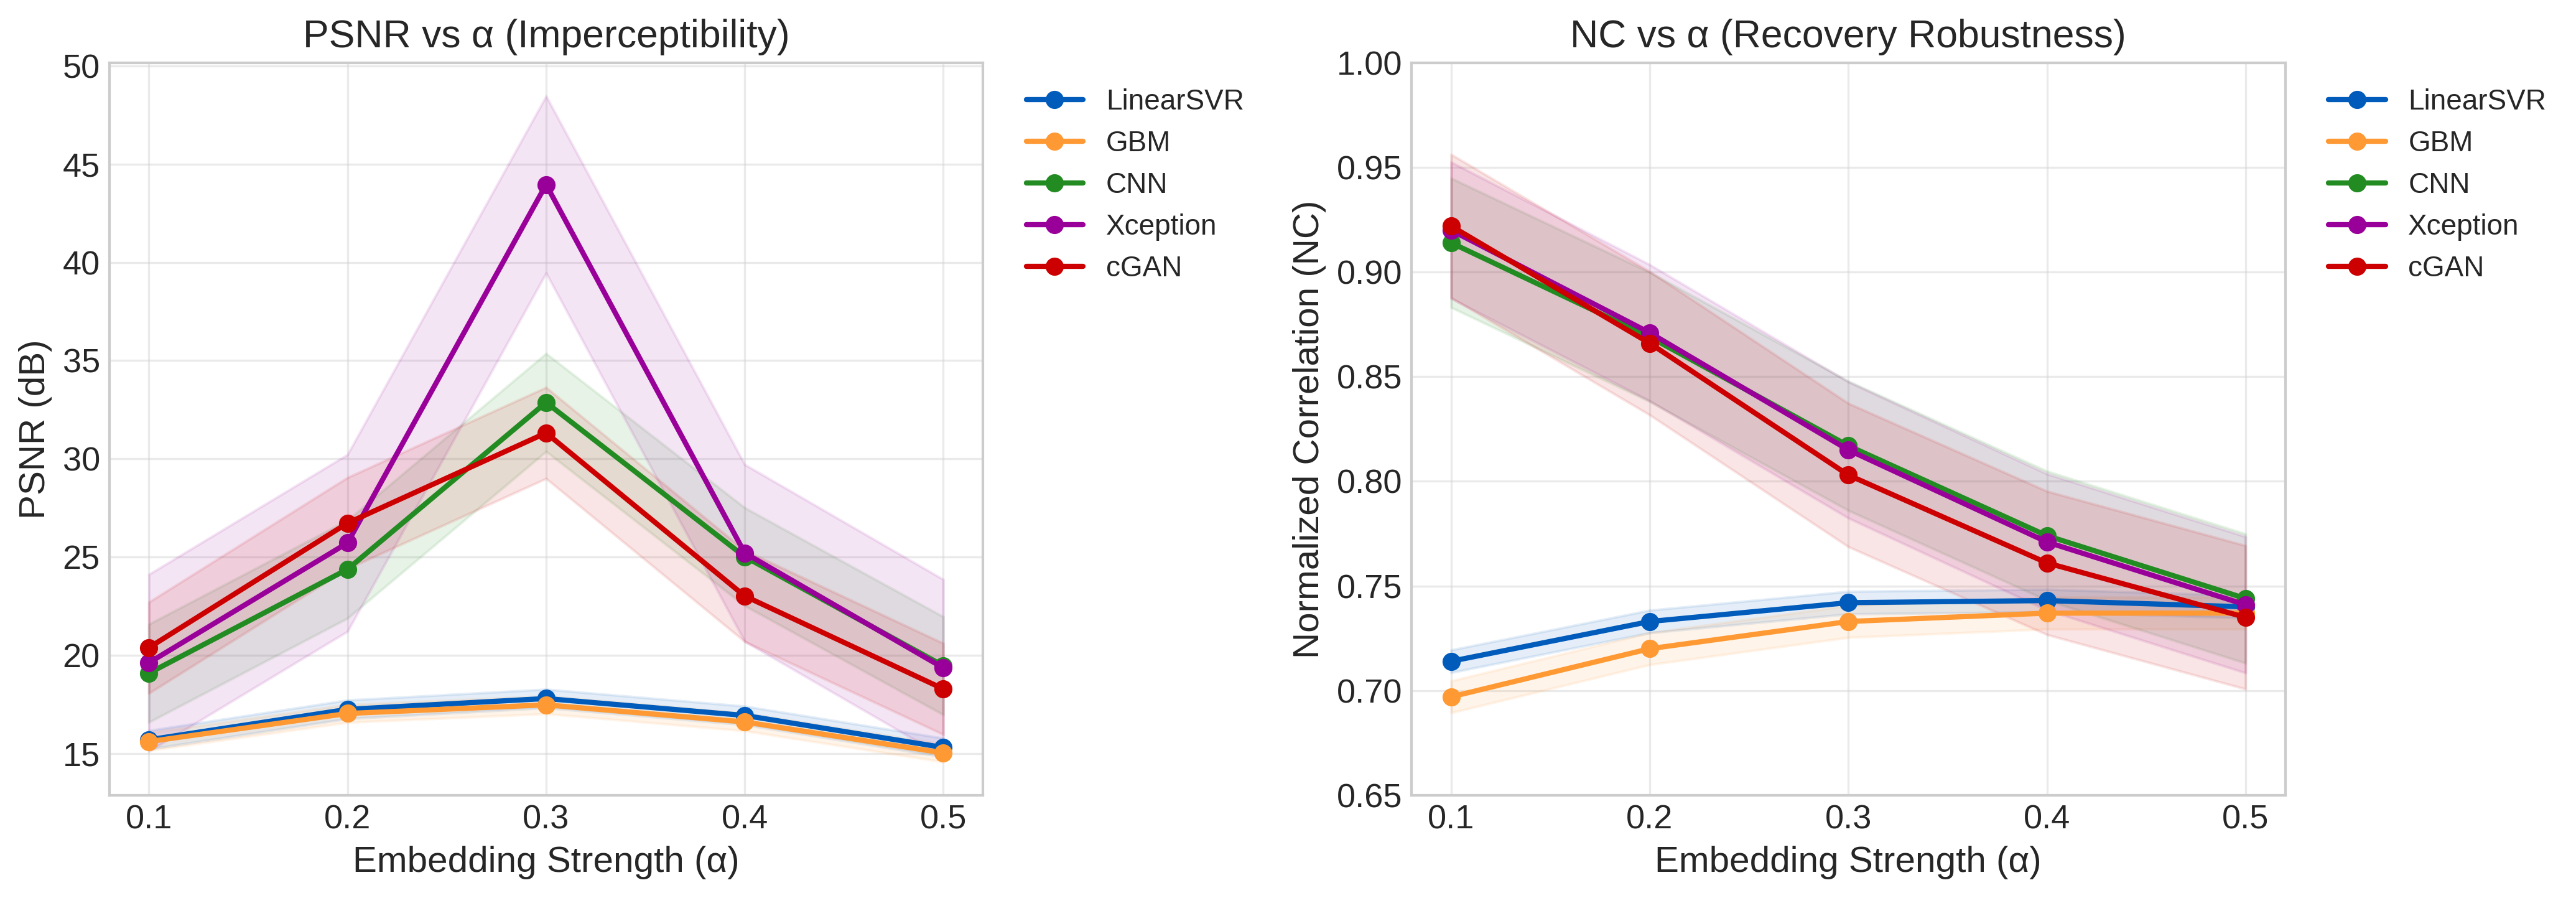

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Font style
rcParams["font.family"] = "serif"
rcParams["font.serif"]  = ["Times New Roman"]
rcParams["font.size"] = 13
rcParams["axes.titlesize"] = 15
rcParams["axes.labelsize"] = 14
rcParams["legend.fontsize"] = 11

plt.style.use("seaborn-v0_8-whitegrid")

# α sweep values
alphas = np.array([0.10, 0.20, 0.30, 0.40, 0.50])

# MODEL RESULTS

psnr_lsvr = np.array([15.70, 17.25, 17.80, 16.94, 15.31])
nc_lsvr   = np.array([0.714, 0.733, 0.742, 0.743, 0.740])

psnr_gbm = np.array([15.61, 17.04, 17.48, 16.61, 15.03])
nc_gbm   = np.array([0.697, 0.720, 0.733, 0.737, 0.737])

psnr_cnn = np.array([19.09, 24.38, 32.87, 25.02, 19.47])
nc_cnn   = np.array([0.914, 0.869, 0.817, 0.774, 0.744])

psnr_xcp = np.array([19.62, 25.72, 43.96, 25.21, 19.36])
nc_xcp   = np.array([0.920, 0.871, 0.815, 0.771, 0.741])

psnr_cgan = np.array([20.39, 26.73, 31.32, 23.02, 18.29])
nc_cgan   = np.array([0.922, 0.866, 0.803, 0.761, 0.735])

# For density ribbon — assume slight variance for shading
def compute_band(values, scale=0.5):
    std = np.std(values) * scale
    return values - std, values + std


# PLOT WITH DENSITY SHADING
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=300)

# LEFT: PSNR vs α with shaded ribbons
ax = axes[0]

models = {
    "LinearSVR": psnr_lsvr,
    "GBM": psnr_gbm,
    "CNN": psnr_cnn,
    "Xception": psnr_xcp,
    "cGAN": psnr_cgan
}

colors = ["#005BBB", "#FF9933", "#228B22", "#990099", "#CC0000"]

for (name, vals), col in zip(models.items(), colors):
    low, high = compute_band(vals)
    ax.fill_between(alphas, low, high, color=col, alpha=0.10)
    ax.plot(alphas, vals, marker="o", color=col, linewidth=2, label=name)

ax.set_title("PSNR vs α (Imperceptibility)")
ax.set_xlabel("Embedding Strength (α)")
ax.set_ylabel("PSNR (dB)")
ax.set_xticks(alphas)
ax.grid(True, alpha=0.4)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))


# RIGHT: NC vs α with shaded ribbons
ax = axes[1]

models_nc = {
    "LinearSVR": nc_lsvr,
    "GBM": nc_gbm,
    "CNN": nc_cnn,
    "Xception": nc_xcp,
    "cGAN": nc_cgan
}

for (name, vals), col in zip(models_nc.items(), colors):
    low, high = compute_band(vals)
    ax.fill_between(alphas, low, high, color=col, alpha=0.10)
    ax.plot(alphas, vals, marker="o", color=col, linewidth=2, label=name)

ax.set_title("NC vs α (Recovery Robustness)")
ax.set_xlabel("Embedding Strength (α)")
ax.set_ylabel("Normalized Correlation (NC)")
ax.set_xticks(alphas)
ax.set_ylim(0.65, 1.00)
ax.grid(True, alpha=0.4)

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

plt.tight_layout()

output_path = "alpha_sweep_curves_density.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
print("Saved PDF:", output_path)

plt.show()